## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1476, 256)
Hypercube shape: (1476, 256, 145)


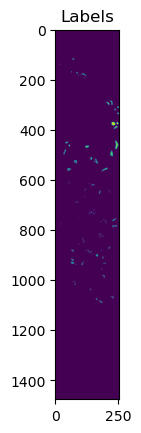

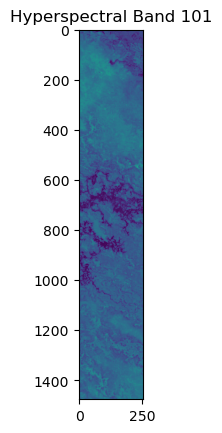

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Botswana_gt.mat'
data_files = 'Botswana.mat'
label_files = 'Botswana_gt'
hypercube_files = 'Botswana'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 3248
Extracted windows shape: (3248, 5, 5, 145)
Corresponding labels shape: (3248,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 270 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 101 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 251 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 215 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 269 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 269 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 259 samples
Shuffled class indices for class '7'
S


All datasets saved to the 'indices' folder.
(560, 5, 5, 145)
(70, 5, 5, 145)
(2618, 5, 5, 145)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 280
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (2598, 5, 5, 145)
Validation data shape: (650, 5, 5, 145)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

145


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/41], Loss: 0.2184, PSNR: -8.3640


Epoch [1/50] Training Loss: 0.2121, PSNR: -8.6923
	[Val]   Batch [1/11] Loss: 0.2056, PSNR: -6.1672
	[Val]   Batch [10/11] Loss: 0.2057, PSNR: -8.4059
Epoch [1/50] Validation Loss: 0.2056, PSNR: -8.0980

LOG: Epoch [2/50]
	 Training Batch [1/41], Loss: 0.1962, PSNR: -5.9650


Epoch [2/50] Training Loss: 0.1900, PSNR: -8.2770
	[Val]   Batch [1/11] Loss: 0.1796, PSNR: -5.5809
	[Val]   Batch [10/11] Loss: 0.1799, PSNR: -7.8237
Epoch [2/50] Validation Loss: 0.1796, PSNR: -7.5101

LOG: Epoch [3/50]
	 Training Batch [1/41], Loss: 0.1764, PSNR: -9.4344


Epoch [3/50] Training Loss: 0.1691, PSNR: -7.7442
	[Val]   Batch [1/11] Loss: 0.1555, PSNR: -4.9538
	[Val]   Batch [10/11] Loss: 0.1555, PSNR: -7.1906
Epoch [3/50] Validation Loss: 0.1553, PSNR: -6.8795

LOG: Epoch [4/50]
	 Training Batch [1/41], Loss: 0.1544, PSNR: -7.9356


Epoch [4/50] Training Loss: 0.1489, PSNR: -7.4050
	[Val]   Batch [1/11] Loss: 0.1345, PSNR: -4.3227
	[Val]   Batch [10/11] Loss: 0.1345, PSNR: -6.5611
Epoch [4/50] Validation Loss: 0.1343, PSNR: -6.2474

LOG: Epoch [5/50]
	 Training Batch [1/41], Loss: 0.1359, PSNR: -8.5923


Epoch [5/50] Training Loss: 0.1298, PSNR: -6.8121
	[Val]   Batch [1/11] Loss: 0.1131, PSNR: -3.5714
	[Val]   Batch [10/11] Loss: 0.1131, PSNR: -5.8077
Epoch [5/50] Validation Loss: 0.1129, PSNR: -5.4946

LOG: Epoch [6/50]
	 Training Batch [1/41], Loss: 0.1190, PSNR: -5.3750


Epoch [6/50] Training Loss: 0.1122, PSNR: -5.9061
	[Val]   Batch [1/11] Loss: 0.0995, PSNR: -3.0142
	[Val]   Batch [10/11] Loss: 0.0994, PSNR: -5.2485
Epoch [6/50] Validation Loss: 0.0993, PSNR: -4.9356

LOG: Epoch [7/50]
	 Training Batch [1/41], Loss: 0.1022, PSNR: -5.9373


Epoch [7/50] Training Loss: 0.0965, PSNR: -5.3691
	[Val]   Batch [1/11] Loss: 0.0842, PSNR: -2.2882
	[Val]   Batch [10/11] Loss: 0.0841, PSNR: -4.5205
Epoch [7/50] Validation Loss: 0.0840, PSNR: -4.2094

LOG: Epoch [8/50]
	 Training Batch [1/41], Loss: 0.0875, PSNR: -3.7744


Epoch [8/50] Training Loss: 0.0831, PSNR: -4.7429
	[Val]   Batch [1/11] Loss: 0.0751, PSNR: -1.7908
	[Val]   Batch [10/11] Loss: 0.0750, PSNR: -4.0216
Epoch [8/50] Validation Loss: 0.0749, PSNR: -3.7122

LOG: Epoch [9/50]
	 Training Batch [1/41], Loss: 0.0763, PSNR: -5.7936


Epoch [9/50] Training Loss: 0.0717, PSNR: -4.1184
	[Val]   Batch [1/11] Loss: 0.0643, PSNR: -1.1171
	[Val]   Batch [10/11] Loss: 0.0642, PSNR: -3.3509
Epoch [9/50] Validation Loss: 0.0642, PSNR: -3.0403

LOG: Epoch [10/50]
	 Training Batch [1/41], Loss: 0.0650, PSNR: -1.1688


Epoch [10/50] Training Loss: 0.0621, PSNR: -3.2631
	[Val]   Batch [1/11] Loss: 0.0576, PSNR: -0.6401
	[Val]   Batch [10/11] Loss: 0.0575, PSNR: -2.8732
Epoch [10/50] Validation Loss: 0.0575, PSNR: -2.5615

LOG: Epoch [11/50]
	 Training Batch [1/41], Loss: 0.0571, PSNR: -0.6064


Epoch [11/50] Training Loss: 0.0542, PSNR: -2.7390
	[Val]   Batch [1/11] Loss: 0.0498, PSNR: -0.0099
	[Val]   Batch [10/11] Loss: 0.0498, PSNR: -2.2460
Epoch [11/50] Validation Loss: 0.0497, PSNR: -1.9319

LOG: Epoch [12/50]
	 Training Batch [1/41], Loss: 0.0490, PSNR: 0.0571


Epoch [12/50] Training Loss: 0.0476, PSNR: -2.2535
	[Val]   Batch [1/11] Loss: 0.0453, PSNR: 0.4003
	[Val]   Batch [10/11] Loss: 0.0453, PSNR: -1.8344
Epoch [12/50] Validation Loss: 0.0452, PSNR: -1.5215

LOG: Epoch [13/50]
	 Training Batch [1/41], Loss: 0.0431, PSNR: -2.1812


Epoch [13/50] Training Loss: 0.0421, PSNR: -1.8524
	[Val]   Batch [1/11] Loss: 0.0392, PSNR: 1.0274
	[Val]   Batch [10/11] Loss: 0.0392, PSNR: -1.2084
Epoch [13/50] Validation Loss: 0.0391, PSNR: -0.8948

LOG: Epoch [14/50]
	 Training Batch [1/41], Loss: 0.0385, PSNR: -3.1558


Epoch [14/50] Training Loss: 0.0374, PSNR: -1.3290
	[Val]   Batch [1/11] Loss: 0.0367, PSNR: 1.3155
	[Val]   Batch [10/11] Loss: 0.0367, PSNR: -0.9181
Epoch [14/50] Validation Loss: 0.0366, PSNR: -0.6053

LOG: Epoch [15/50]
	 Training Batch [1/41], Loss: 0.0345, PSNR: -1.2174


Epoch [15/50] Training Loss: 0.0335, PSNR: -0.6629
	[Val]   Batch [1/11] Loss: 0.0320, PSNR: 1.9107
	[Val]   Batch [10/11] Loss: 0.0320, PSNR: -0.3242
Epoch [15/50] Validation Loss: 0.0319, PSNR: -0.0099

LOG: Epoch [16/50]
	 Training Batch [1/41], Loss: 0.0314, PSNR: 1.9996


Epoch [16/50] Training Loss: 0.0302, PSNR: -0.4468
	[Val]   Batch [1/11] Loss: 0.0292, PSNR: 2.3084
	[Val]   Batch [10/11] Loss: 0.0292, PSNR: 0.0749
Epoch [16/50] Validation Loss: 0.0291, PSNR: 0.3883

LOG: Epoch [17/50]
	 Training Batch [1/41], Loss: 0.0278, PSNR: 1.1991


Epoch [17/50] Training Loss: 0.0273, PSNR: -0.0557
	[Val]   Batch [1/11] Loss: 0.0268, PSNR: 2.6815
	[Val]   Batch [10/11] Loss: 0.0268, PSNR: 0.4508
Epoch [17/50] Validation Loss: 0.0267, PSNR: 0.7617

LOG: Epoch [18/50]
	 Training Batch [1/41], Loss: 0.0256, PSNR: 1.2441


Epoch [18/50] Training Loss: 0.0249, PSNR: 0.5374
	[Val]   Batch [1/11] Loss: 0.0241, PSNR: 3.1481
	[Val]   Batch [10/11] Loss: 0.0240, PSNR: 0.9181
Epoch [18/50] Validation Loss: 0.0240, PSNR: 1.2287

LOG: Epoch [19/50]
	 Training Batch [1/41], Loss: 0.0235, PSNR: 3.2553


Epoch [19/50] Training Loss: 0.0227, PSNR: 1.0385
	[Val]   Batch [1/11] Loss: 0.0225, PSNR: 3.4397
	[Val]   Batch [10/11] Loss: 0.0225, PSNR: 1.2103
Epoch [19/50] Validation Loss: 0.0224, PSNR: 1.5214

LOG: Epoch [20/50]
	 Training Batch [1/41], Loss: 0.0209, PSNR: 1.8184


Epoch [20/50] Training Loss: 0.0208, PSNR: 1.1200
	[Val]   Batch [1/11] Loss: 0.0205, PSNR: 3.8385
	[Val]   Batch [10/11] Loss: 0.0205, PSNR: 1.6075
Epoch [20/50] Validation Loss: 0.0205, PSNR: 1.9206

LOG: Epoch [21/50]
	 Training Batch [1/41], Loss: 0.0193, PSNR: 1.3095


Epoch [21/50] Training Loss: 0.0192, PSNR: 1.6704
	[Val]   Batch [1/11] Loss: 0.0188, PSNR: 4.2252
	[Val]   Batch [10/11] Loss: 0.0188, PSNR: 1.9913
Epoch [21/50] Validation Loss: 0.0187, PSNR: 2.3065

LOG: Epoch [22/50]
	 Training Batch [1/41], Loss: 0.0180, PSNR: 0.1515


Epoch [22/50] Training Loss: 0.0177, PSNR: 1.9474
	[Val]   Batch [1/11] Loss: 0.0177, PSNR: 4.4885
	[Val]   Batch [10/11] Loss: 0.0177, PSNR: 2.2555
Epoch [22/50] Validation Loss: 0.0176, PSNR: 2.5691

LOG: Epoch [23/50]
	 Training Batch [1/41], Loss: 0.0169, PSNR: 4.6778


Epoch [23/50] Training Loss: 0.0164, PSNR: 2.2678
	[Val]   Batch [1/11] Loss: 0.0162, PSNR: 4.8699
	[Val]   Batch [10/11] Loss: 0.0162, PSNR: 2.6366
Epoch [23/50] Validation Loss: 0.0162, PSNR: 2.9499

LOG: Epoch [24/50]
	 Training Batch [1/41], Loss: 0.0161, PSNR: 2.3098


Epoch [24/50] Training Loss: 0.0152, PSNR: 2.6579
	[Val]   Batch [1/11] Loss: 0.0151, PSNR: 5.1825
	[Val]   Batch [10/11] Loss: 0.0151, PSNR: 2.9500
Epoch [24/50] Validation Loss: 0.0150, PSNR: 3.2629

LOG: Epoch [25/50]
	 Training Batch [1/41], Loss: 0.0149, PSNR: 2.6298


Epoch [25/50] Training Loss: 0.0142, PSNR: 3.2365
	[Val]   Batch [1/11] Loss: 0.0142, PSNR: 5.4325
	[Val]   Batch [10/11] Loss: 0.0142, PSNR: 3.2023
Epoch [25/50] Validation Loss: 0.0142, PSNR: 3.5144

LOG: Epoch [26/50]
	 Training Batch [1/41], Loss: 0.0136, PSNR: 4.0513


Epoch [26/50] Training Loss: 0.0133, PSNR: 3.3576
	[Val]   Batch [1/11] Loss: 0.0133, PSNR: 5.7269
	[Val]   Batch [10/11] Loss: 0.0133, PSNR: 3.4969
Epoch [26/50] Validation Loss: 0.0132, PSNR: 3.8100

LOG: Epoch [27/50]
	 Training Batch [1/41], Loss: 0.0126, PSNR: 2.0326


Epoch [27/50] Training Loss: 0.0124, PSNR: 3.5186
	[Val]   Batch [1/11] Loss: 0.0124, PSNR: 6.0377
	[Val]   Batch [10/11] Loss: 0.0124, PSNR: 3.8069
Epoch [27/50] Validation Loss: 0.0123, PSNR: 4.1211

LOG: Epoch [28/50]
	 Training Batch [1/41], Loss: 0.0120, PSNR: 1.9637


Epoch [28/50] Training Loss: 0.0116, PSNR: 3.6831
	[Val]   Batch [1/11] Loss: 0.0117, PSNR: 6.2875
	[Val]   Batch [10/11] Loss: 0.0117, PSNR: 4.0576
Epoch [28/50] Validation Loss: 0.0116, PSNR: 4.3714

LOG: Epoch [29/50]
	 Training Batch [1/41], Loss: 0.0114, PSNR: 4.7916


Epoch [29/50] Training Loss: 0.0110, PSNR: 4.0548
	[Val]   Batch [1/11] Loss: 0.0110, PSNR: 6.5480
	[Val]   Batch [10/11] Loss: 0.0110, PSNR: 4.3177
Epoch [29/50] Validation Loss: 0.0110, PSNR: 4.6314

LOG: Epoch [30/50]
	 Training Batch [1/41], Loss: 0.0105, PSNR: 2.3125


Epoch [30/50] Training Loss: 0.0103, PSNR: 4.3603
	[Val]   Batch [1/11] Loss: 0.0103, PSNR: 6.8170
	[Val]   Batch [10/11] Loss: 0.0103, PSNR: 4.5864
Epoch [30/50] Validation Loss: 0.0103, PSNR: 4.9004

LOG: Epoch [31/50]
	 Training Batch [1/41], Loss: 0.0099, PSNR: 7.0260


Epoch [31/50] Training Loss: 0.0097, PSNR: 4.4712
	[Val]   Batch [1/11] Loss: 0.0098, PSNR: 7.0585
	[Val]   Batch [10/11] Loss: 0.0098, PSNR: 4.8289
Epoch [31/50] Validation Loss: 0.0098, PSNR: 5.1416

LOG: Epoch [32/50]
	 Training Batch [1/41], Loss: 0.0094, PSNR: 4.9830


Epoch [32/50] Training Loss: 0.0092, PSNR: 4.7551
	[Val]   Batch [1/11] Loss: 0.0093, PSNR: 7.2957
	[Val]   Batch [10/11] Loss: 0.0092, PSNR: 5.0683
Epoch [32/50] Validation Loss: 0.0092, PSNR: 5.3796

LOG: Epoch [33/50]
	 Training Batch [1/41], Loss: 0.0089, PSNR: 7.4835


Epoch [33/50] Training Loss: 0.0087, PSNR: 4.9861
	[Val]   Batch [1/11] Loss: 0.0087, PSNR: 7.5579
	[Val]   Batch [10/11] Loss: 0.0087, PSNR: 5.3296
Epoch [33/50] Validation Loss: 0.0087, PSNR: 5.6418

LOG: Epoch [34/50]
	 Training Batch [1/41], Loss: 0.0085, PSNR: 3.3969


Epoch [34/50] Training Loss: 0.0082, PSNR: 5.3095
	[Val]   Batch [1/11] Loss: 0.0083, PSNR: 7.7526
	[Val]   Batch [10/11] Loss: 0.0083, PSNR: 5.5240
Epoch [34/50] Validation Loss: 0.0083, PSNR: 5.8370

LOG: Epoch [35/50]
	 Training Batch [1/41], Loss: 0.0080, PSNR: 5.0289


Epoch [35/50] Training Loss: 0.0078, PSNR: 5.4116
	[Val]   Batch [1/11] Loss: 0.0079, PSNR: 7.9799
	[Val]   Batch [10/11] Loss: 0.0079, PSNR: 5.7523
Epoch [35/50] Validation Loss: 0.0079, PSNR: 6.0648

LOG: Epoch [36/50]
	 Training Batch [1/41], Loss: 0.0075, PSNR: 6.8948


Epoch [36/50] Training Loss: 0.0074, PSNR: 5.7243
	[Val]   Batch [1/11] Loss: 0.0075, PSNR: 8.2251
	[Val]   Batch [10/11] Loss: 0.0075, PSNR: 5.9991
Epoch [36/50] Validation Loss: 0.0074, PSNR: 6.3105

LOG: Epoch [37/50]
	 Training Batch [1/41], Loss: 0.0074, PSNR: 4.8298


Epoch [37/50] Training Loss: 0.0071, PSNR: 5.9436
	[Val]   Batch [1/11] Loss: 0.0071, PSNR: 8.4308
	[Val]   Batch [10/11] Loss: 0.0071, PSNR: 6.2049
Epoch [37/50] Validation Loss: 0.0071, PSNR: 6.5160

LOG: Epoch [38/50]
	 Training Batch [1/41], Loss: 0.0072, PSNR: 6.4792


Epoch [38/50] Training Loss: 0.0067, PSNR: 6.2443
	[Val]   Batch [1/11] Loss: 0.0068, PSNR: 8.6547
	[Val]   Batch [10/11] Loss: 0.0068, PSNR: 6.4285
Epoch [38/50] Validation Loss: 0.0067, PSNR: 6.7400

LOG: Epoch [39/50]
	 Training Batch [1/41], Loss: 0.0065, PSNR: 5.9805


Epoch [39/50] Training Loss: 0.0064, PSNR: 6.4598
	[Val]   Batch [1/11] Loss: 0.0065, PSNR: 8.8315
	[Val]   Batch [10/11] Loss: 0.0065, PSNR: 6.6051
Epoch [39/50] Validation Loss: 0.0065, PSNR: 6.9174

LOG: Epoch [40/50]
	 Training Batch [1/41], Loss: 0.0060, PSNR: 6.3545


Epoch [40/50] Training Loss: 0.0061, PSNR: 6.6766
	[Val]   Batch [1/11] Loss: 0.0063, PSNR: 9.0028
	[Val]   Batch [10/11] Loss: 0.0062, PSNR: 6.7766
Epoch [40/50] Validation Loss: 0.0062, PSNR: 7.0894

LOG: Epoch [41/50]
	 Training Batch [1/41], Loss: 0.0058, PSNR: 7.6730


Epoch [41/50] Training Loss: 0.0059, PSNR: 6.9085
	[Val]   Batch [1/11] Loss: 0.0059, PSNR: 9.2326
	[Val]   Batch [10/11] Loss: 0.0059, PSNR: 7.0058
Epoch [41/50] Validation Loss: 0.0059, PSNR: 7.3192

LOG: Epoch [42/50]
	 Training Batch [1/41], Loss: 0.0057, PSNR: 9.4139


Epoch [42/50] Training Loss: 0.0056, PSNR: 7.0353
	[Val]   Batch [1/11] Loss: 0.0057, PSNR: 9.4239
	[Val]   Batch [10/11] Loss: 0.0057, PSNR: 7.1965
Epoch [42/50] Validation Loss: 0.0057, PSNR: 7.5110

LOG: Epoch [43/50]
	 Training Batch [1/41], Loss: 0.0056, PSNR: 6.6419


Epoch [43/50] Training Loss: 0.0054, PSNR: 7.1699
	[Val]   Batch [1/11] Loss: 0.0054, PSNR: 9.6014
	[Val]   Batch [10/11] Loss: 0.0054, PSNR: 7.3747
Epoch [43/50] Validation Loss: 0.0054, PSNR: 7.6890

LOG: Epoch [44/50]
	 Training Batch [1/41], Loss: 0.0050, PSNR: 7.0464


Epoch [44/50] Training Loss: 0.0052, PSNR: 7.3553
	[Val]   Batch [1/11] Loss: 0.0052, PSNR: 9.7818
	[Val]   Batch [10/11] Loss: 0.0052, PSNR: 7.5560
Epoch [44/50] Validation Loss: 0.0052, PSNR: 7.8689

LOG: Epoch [45/50]
	 Training Batch [1/41], Loss: 0.0049, PSNR: 6.5982


Epoch [45/50] Training Loss: 0.0049, PSNR: 7.6089
	[Val]   Batch [1/11] Loss: 0.0050, PSNR: 9.9526
	[Val]   Batch [10/11] Loss: 0.0050, PSNR: 7.7273
Epoch [45/50] Validation Loss: 0.0050, PSNR: 8.0394

LOG: Epoch [46/50]
	 Training Batch [1/41], Loss: 0.0047, PSNR: 5.7203


Epoch [46/50] Training Loss: 0.0047, PSNR: 7.8881
	[Val]   Batch [1/11] Loss: 0.0048, PSNR: 10.1249
	[Val]   Batch [10/11] Loss: 0.0048, PSNR: 7.8997
Epoch [46/50] Validation Loss: 0.0048, PSNR: 8.2119

LOG: Epoch [47/50]
	 Training Batch [1/41], Loss: 0.0045, PSNR: 9.1556


Epoch [47/50] Training Loss: 0.0046, PSNR: 7.8400
	[Val]   Batch [1/11] Loss: 0.0046, PSNR: 10.3069
	[Val]   Batch [10/11] Loss: 0.0046, PSNR: 8.0814
Epoch [47/50] Validation Loss: 0.0046, PSNR: 8.3942

LOG: Epoch [48/50]
	 Training Batch [1/41], Loss: 0.0044, PSNR: 8.9630


Epoch [48/50] Training Loss: 0.0044, PSNR: 8.0904
	[Val]   Batch [1/11] Loss: 0.0045, PSNR: 10.4724
	[Val]   Batch [10/11] Loss: 0.0044, PSNR: 8.2468
Epoch [48/50] Validation Loss: 0.0044, PSNR: 8.5605

LOG: Epoch [49/50]
	 Training Batch [1/41], Loss: 0.0044, PSNR: 10.4849


Epoch [49/50] Training Loss: 0.0042, PSNR: 8.2907
	[Val]   Batch [1/11] Loss: 0.0043, PSNR: 10.6324
	[Val]   Batch [10/11] Loss: 0.0043, PSNR: 8.4054
Epoch [49/50] Validation Loss: 0.0043, PSNR: 8.7204

LOG: Epoch [50/50]
	 Training Batch [1/41], Loss: 0.0043, PSNR: 6.0064


Epoch [50/50] Training Loss: 0.0041, PSNR: 8.4145
	[Val]   Batch [1/11] Loss: 0.0041, PSNR: 10.8017
	[Val]   Batch [10/11] Loss: 0.0041, PSNR: 8.5743
Epoch [50/50] Validation Loss: 0.0041, PSNR: 8.8894


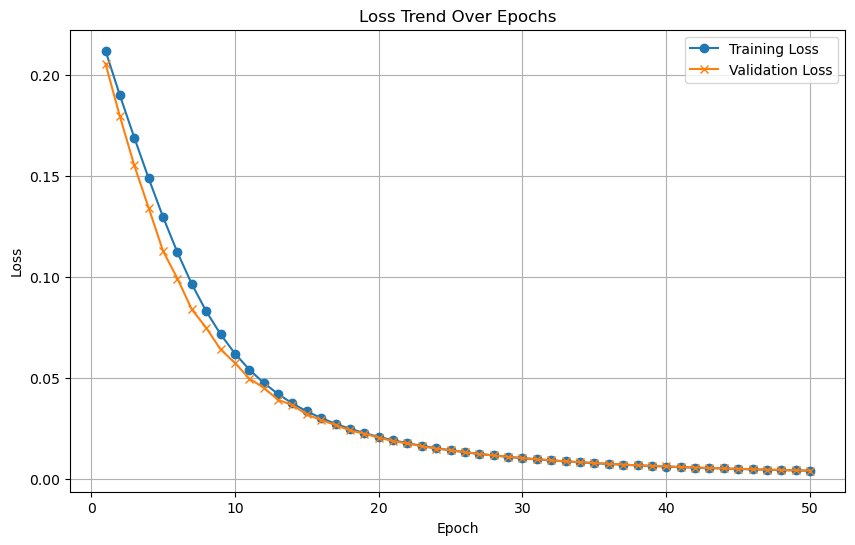

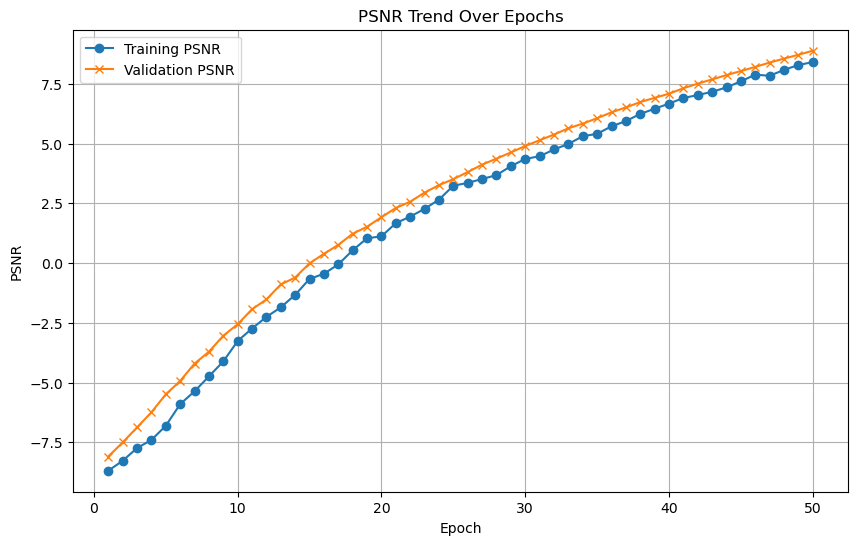

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/2 for train dataset.
    Processed batch 2/2 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/11 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training


Epoch [1/1000] completed, Average Training Loss: 2.6226
    Validation Batch [1/1], Loss: 2.6469
Validation Loss: 2.6469, Validation Accuracy: 7.14%
Validation loss improved from inf to 2.6469. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.5585
    Validation Batch [1/1], Loss: 2.6470
Validation Loss: 2.6470, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5240
    Validation Batch [1/1], Loss: 2.6470
Validation Loss: 2.6470, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.4897
    Validation Batch [1/1], Loss: 2.6472
Validation Loss: 2.6472, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Training Loss: 2.4634
    Validati

Epoch [9/1000] completed, Average Training Loss: 2.3689
    Validation Batch [1/1], Loss: 2.6488
Validation Loss: 2.6488, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 2.3486
    Validation Batch [1/1], Loss: 2.6494
Validation Loss: 2.6494, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.3339
    Validation Batch [1/1], Loss: 2.6500
Validation Loss: 2.6500, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 2.3224
    Validation Batch [1/1], Loss: 2.6507
Validation Loss: 2.6507, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [13/1000] - Training


Epoch [13/1000] completed, Average Training Loss: 2.2979
    Validation Batch [1/1], Loss: 2.6516
Validation Loss: 2.6516, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [14/1000] - Training
Epoch [14/1000] completed, Average Training Loss: 2.2866
    Validation Batch [1/1], Loss: 2.6529
Validation Loss: 2.6529, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [15/1000] - Training
Epoch [15/1000] completed, Average Training Loss: 2.2616
    Validation Batch [1/1], Loss: 2.6542
Validation Loss: 2.6542, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [16/1000] - Training
Epoch [16/1000] completed, Average Training Loss: 2.2490
    Validation Batch [1/1], Loss: 2.6558
Validation Loss: 2.6558, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [17/1000] - Training
Epoch [17/1000] completed, Average Training Loss: 2.2212
    Validat

Epoch [22/1000] completed, Average Training Loss: 2.1478
    Validation Batch [1/1], Loss: 2.6527
Validation Loss: 2.6527, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.1337
    Validation Batch [1/1], Loss: 2.6483
Validation Loss: 2.6483, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 2.1104
    Validation Batch [1/1], Loss: 2.6418
Validation Loss: 2.6418, Validation Accuracy: 7.14%
Validation loss improved from 2.6469 to 2.6418. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 2.0994
    Validation Batch [1/1], Loss: 2.6333
Validation Loss: 2.6333, Validation Accuracy: 7.14%
Validation loss improved from 2.6418 to 2.6333. Saving model...

LOG: Epoch [26/1000] - Training


Epoch [26/1000] completed, Average Training Loss: 2.0823
    Validation Batch [1/1], Loss: 2.6220
Validation Loss: 2.6220, Validation Accuracy: 7.14%
Validation loss improved from 2.6333 to 2.6220. Saving model...

LOG: Epoch [27/1000] - Training
Epoch [27/1000] completed, Average Training Loss: 2.0754
    Validation Batch [1/1], Loss: 2.6062
Validation Loss: 2.6062, Validation Accuracy: 7.14%
Validation loss improved from 2.6220 to 2.6062. Saving model...

LOG: Epoch [28/1000] - Training
Epoch [28/1000] completed, Average Training Loss: 2.0520
    Validation Batch [1/1], Loss: 2.5872
Validation Loss: 2.5872, Validation Accuracy: 7.14%
Validation loss improved from 2.6062 to 2.5872. Saving model...

LOG: Epoch [29/1000] - Training
Epoch [29/1000] completed, Average Training Loss: 2.0469
    Validation Batch [1/1], Loss: 2.5653
Validation Loss: 2.5653, Validation Accuracy: 7.14%
Validation loss improved from 2.5872 to 2.5653. Saving model...

LOG: Epoch [30/1000] - Training
Epoch [30/10

Epoch [35/1000] completed, Average Training Loss: 1.9601
    Validation Batch [1/1], Loss: 2.3666
Validation Loss: 2.3666, Validation Accuracy: 24.29%
Validation loss improved from 2.3987 to 2.3666. Saving model...

LOG: Epoch [36/1000] - Training
Epoch [36/1000] completed, Average Training Loss: 1.9431
    Validation Batch [1/1], Loss: 2.3213
Validation Loss: 2.3213, Validation Accuracy: 28.57%
Validation loss improved from 2.3666 to 2.3213. Saving model...

LOG: Epoch [37/1000] - Training
Epoch [37/1000] completed, Average Training Loss: 1.9267
    Validation Batch [1/1], Loss: 2.2703
Validation Loss: 2.2703, Validation Accuracy: 28.57%
Validation loss improved from 2.3213 to 2.2703. Saving model...

LOG: Epoch [38/1000] - Training
Epoch [38/1000] completed, Average Training Loss: 1.9090
    Validation Batch [1/1], Loss: 2.2331
Validation Loss: 2.2331, Validation Accuracy: 28.57%
Validation loss improved from 2.2703 to 2.2331. Saving model...

LOG: Epoch [39/1000] - Training


Epoch [39/1000] completed, Average Training Loss: 1.8894
    Validation Batch [1/1], Loss: 2.1818
Validation Loss: 2.1818, Validation Accuracy: 28.57%
Validation loss improved from 2.2331 to 2.1818. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 1.8819
    Validation Batch [1/1], Loss: 2.1242
Validation Loss: 2.1242, Validation Accuracy: 32.86%
Validation loss improved from 2.1818 to 2.1242. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 1.8754
    Validation Batch [1/1], Loss: 2.1031
Validation Loss: 2.1031, Validation Accuracy: 37.14%
Validation loss improved from 2.1242 to 2.1031. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 1.8523
    Validation Batch [1/1], Loss: 2.0611
Validation Loss: 2.0611, Validation Accuracy: 40.00%
Validation loss improved from 2.1031 to 2.0611. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [4

Epoch [48/1000] completed, Average Training Loss: 1.7662
    Validation Batch [1/1], Loss: 1.8253
Validation Loss: 1.8253, Validation Accuracy: 64.29%
Validation loss improved from 1.8680 to 1.8253. Saving model...

LOG: Epoch [49/1000] - Training
Epoch [49/1000] completed, Average Training Loss: 1.7507
    Validation Batch [1/1], Loss: 1.8340
Validation Loss: 1.8340, Validation Accuracy: 58.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [50/1000] - Training
Epoch [50/1000] completed, Average Training Loss: 1.7335
    Validation Batch [1/1], Loss: 1.7900
Validation Loss: 1.7900, Validation Accuracy: 68.57%
Validation loss improved from 1.8253 to 1.7900. Saving model...

LOG: Epoch [51/1000] - Training


Epoch [51/1000] completed, Average Training Loss: 1.7392
    Validation Batch [1/1], Loss: 1.7569
Validation Loss: 1.7569, Validation Accuracy: 71.43%
Validation loss improved from 1.7900 to 1.7569. Saving model...

LOG: Epoch [52/1000] - Training
Epoch [52/1000] completed, Average Training Loss: 1.7129
    Validation Batch [1/1], Loss: 1.7341
Validation Loss: 1.7341, Validation Accuracy: 72.86%
Validation loss improved from 1.7569 to 1.7341. Saving model...

LOG: Epoch [53/1000] - Training
Epoch [53/1000] completed, Average Training Loss: 1.6999
    Validation Batch [1/1], Loss: 1.7067
Validation Loss: 1.7067, Validation Accuracy: 77.14%
Validation loss improved from 1.7341 to 1.7067. Saving model...

LOG: Epoch [54/1000] - Training
Epoch [54/1000] completed, Average Training Loss: 1.6702
    Validation Batch [1/1], Loss: 1.6671
Validation Loss: 1.6671, Validation Accuracy: 75.71%
Validation loss improved from 1.7067 to 1.6671. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [5

    Validation Batch [1/1], Loss: 1.5561
Validation Loss: 1.5561, Validation Accuracy: 81.43%
Validation loss improved from 1.5717 to 1.5561. Saving model...

LOG: Epoch [62/1000] - Training
Epoch [62/1000] completed, Average Training Loss: 1.5525
    Validation Batch [1/1], Loss: 1.5382
Validation Loss: 1.5382, Validation Accuracy: 84.29%
Validation loss improved from 1.5561 to 1.5382. Saving model...

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 1.5463
    Validation Batch [1/1], Loss: 1.5432
Validation Loss: 1.5432, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [64/1000] - Training


Epoch [64/1000] completed, Average Training Loss: 1.5454
    Validation Batch [1/1], Loss: 1.4921
Validation Loss: 1.4921, Validation Accuracy: 82.86%
Validation loss improved from 1.5382 to 1.4921. Saving model...

LOG: Epoch [65/1000] - Training
Epoch [65/1000] completed, Average Training Loss: 1.5271
    Validation Batch [1/1], Loss: 1.4820
Validation Loss: 1.4820, Validation Accuracy: 77.14%
Validation loss improved from 1.4921 to 1.4820. Saving model...

LOG: Epoch [66/1000] - Training
Epoch [66/1000] completed, Average Training Loss: 1.5026
    Validation Batch [1/1], Loss: 1.5078
Validation Loss: 1.5078, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [67/1000] - Training
Epoch [67/1000] completed, Average Training Loss: 1.4879
    Validation Batch [1/1], Loss: 1.4606
Validation Loss: 1.4606, Validation Accuracy: 87.14%
Validation loss improved from 1.4820 to 1.4606. Saving model...

LOG: Epoch [68/1000] - Training
Epoch [68/1000] complet

Epoch [74/1000] completed, Average Training Loss: 1.3884
    Validation Batch [1/1], Loss: 1.4188
Validation Loss: 1.4188, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [75/1000] - Training
Epoch [75/1000] completed, Average Training Loss: 1.3726
    Validation Batch [1/1], Loss: 1.3078
Validation Loss: 1.3078, Validation Accuracy: 87.14%
Validation loss improved from 1.3793 to 1.3078. Saving model...

LOG: Epoch [76/1000] - Training
Epoch [76/1000] completed, Average Training Loss: 1.3806
    Validation Batch [1/1], Loss: 1.3079
Validation Loss: 1.3079, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [77/1000] - Training


Epoch [77/1000] completed, Average Training Loss: 1.3544
    Validation Batch [1/1], Loss: 1.3394
Validation Loss: 1.3394, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [78/1000] - Training
Epoch [78/1000] completed, Average Training Loss: 1.3428
    Validation Batch [1/1], Loss: 1.2777
Validation Loss: 1.2777, Validation Accuracy: 88.57%
Validation loss improved from 1.3078 to 1.2777. Saving model...

LOG: Epoch [79/1000] - Training
Epoch [79/1000] completed, Average Training Loss: 1.3360
    Validation Batch [1/1], Loss: 1.2983
Validation Loss: 1.2983, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [80/1000] - Training
Epoch [80/1000] completed, Average Training Loss: 1.3059
    Validation Batch [1/1], Loss: 1.2988
Validation Loss: 1.2988, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [81/1000] - Training
Epoch [81/1000] completed, Average Training Loss: 1.3

Epoch [87/1000] completed, Average Training Loss: 1.2035


    Validation Batch [1/1], Loss: 1.1694
Validation Loss: 1.1694, Validation Accuracy: 91.43%
Validation loss improved from 1.1829 to 1.1694. Saving model...

LOG: Epoch [88/1000] - Training
Epoch [88/1000] completed, Average Training Loss: 1.2056
    Validation Batch [1/1], Loss: 1.1426
Validation Loss: 1.1426, Validation Accuracy: 91.43%
Validation loss improved from 1.1694 to 1.1426. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Training Loss: 1.1618
    Validation Batch [1/1], Loss: 1.1782
Validation Loss: 1.1782, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [90/1000] - Training
Epoch [90/1000] completed, Average Training Loss: 1.1776
    Validation Batch [1/1], Loss: 1.1462
Validation Loss: 1.1462, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [91/1000] - Training
Epoch [91/1000] completed, Average Training Loss: 1.1538
    Validation Batch [1/1], Loss: 1.08

Epoch [100/1000] completed, Average Training Loss: 1.0312
    Validation Batch [1/1], Loss: 0.9596
Validation Loss: 0.9596, Validation Accuracy: 91.43%
Validation loss improved from 0.9834 to 0.9596. Saving model...

LOG: Epoch [101/1000] - Training
Epoch [101/1000] completed, Average Training Loss: 1.0192
    Validation Batch [1/1], Loss: 0.9614
Validation Loss: 0.9614, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [102/1000] - Training
Epoch [102/1000] completed, Average Training Loss: 1.0005
    Validation Batch [1/1], Loss: 0.9649
Validation Loss: 0.9649, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [103/1000] - Training
Epoch [103/1000] completed, Average Training Loss: 0.9803
    Validation Batch [1/1], Loss: 0.9320
Validation Loss: 0.9320, Validation Accuracy: 95.71%
Validation loss improved from 0.9596 to 0.9320. Saving model...

LOG: Epoch [104/1000] - Training
Epoch [104/1000] completed, Av

    Validation Batch [1/1], Loss: 0.8310
Validation Loss: 0.8310, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [113/1000] - Training
Epoch [113/1000] completed, Average Training Loss: 0.8318
    Validation Batch [1/1], Loss: 0.7943
Validation Loss: 0.7943, Validation Accuracy: 95.71%
Validation loss improved from 0.8266 to 0.7943. Saving model...

LOG: Epoch [114/1000] - Training
Epoch [114/1000] completed, Average Training Loss: 0.8194
    Validation Batch [1/1], Loss: 0.8182
Validation Loss: 0.8182, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [115/1000] - Training
Epoch [115/1000] completed, Average Training Loss: 0.8298
    Validation Batch [1/1], Loss: 0.7482
Validation Loss: 0.7482, Validation Accuracy: 100.00%
Validation loss improved from 0.7943 to 0.7482. Saving model...

LOG: Epoch [116/1000] - Training
Epoch [116/1000] completed, Average Training Loss: 0.8007
    Validation Batch [1/1], L

    Validation Batch [1/1], Loss: 0.6267
Validation Loss: 0.6267, Validation Accuracy: 100.00%
Validation loss improved from 0.6635 to 0.6267. Saving model...

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Average Training Loss: 0.7033
    Validation Batch [1/1], Loss: 0.6211
Validation Loss: 0.6211, Validation Accuracy: 98.57%
Validation loss improved from 0.6267 to 0.6211. Saving model...

LOG: Epoch [127/1000] - Training
Epoch [127/1000] completed, Average Training Loss: 0.6727
    Validation Batch [1/1], Loss: 0.6412
Validation Loss: 0.6412, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [128/1000] - Training
Epoch [128/1000] completed, Average Training Loss: 0.6476
    Validation Batch [1/1], Loss: 0.6971
Validation Loss: 0.6971, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [129/1000] - Training
Epoch [129/1000] completed, Average Training Loss: 0.6325
    Validation Batch [1/1], L

    Validation Batch [1/1], Loss: 0.4528
Validation Loss: 0.4528, Validation Accuracy: 100.00%
Validation loss improved from 0.4886 to 0.4528. Saving model...

LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Average Training Loss: 0.5399
    Validation Batch [1/1], Loss: 0.4851
Validation Loss: 0.4851, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [139/1000] - Training
Epoch [139/1000] completed, Average Training Loss: 0.4865
    Validation Batch [1/1], Loss: 0.4640
Validation Loss: 0.4640, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [140/1000] - Training
Epoch [140/1000] completed, Average Training Loss: 0.5066
    Validation Batch [1/1], Loss: 0.4492
Validation Loss: 0.4492, Validation Accuracy: 100.00%
Validation loss improved from 0.4528 to 0.4492. Saving model...

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 0.4931
    Validation Batch [1/1]

    Validation Batch [1/1], Loss: 0.3462
Validation Loss: 0.3462, Validation Accuracy: 100.00%
Validation loss improved from 0.3622 to 0.3462. Saving model...

LOG: Epoch [151/1000] - Training
Epoch [151/1000] completed, Average Training Loss: 0.3995
    Validation Batch [1/1], Loss: 0.3418
Validation Loss: 0.3418, Validation Accuracy: 100.00%
Validation loss improved from 0.3462 to 0.3418. Saving model...

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Average Training Loss: 0.4148
    Validation Batch [1/1], Loss: 0.3572
Validation Loss: 0.3572, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 0.3862
    Validation Batch [1/1], Loss: 0.3207
Validation Loss: 0.3207, Validation Accuracy: 100.00%
Validation loss improved from 0.3418 to 0.3207. Saving model...

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 0.3771
    Validat

Epoch [163/1000] completed, Average Training Loss: 0.3201
    Validation Batch [1/1], Loss: 0.2610
Validation Loss: 0.2610, Validation Accuracy: 100.00%
Validation loss improved from 0.2665 to 0.2610. Saving model...

LOG: Epoch [164/1000] - Training
Epoch [164/1000] completed, Average Training Loss: 0.3444
    Validation Batch [1/1], Loss: 0.2377
Validation Loss: 0.2377, Validation Accuracy: 100.00%
Validation loss improved from 0.2610 to 0.2377. Saving model...

LOG: Epoch [165/1000] - Training
Epoch [165/1000] completed, Average Training Loss: 0.3082
    Validation Batch [1/1], Loss: 0.2502
Validation Loss: 0.2502, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [166/1000] - Training
Epoch [166/1000] completed, Average Training Loss: 0.2917
    Validation Batch [1/1], Loss: 0.2295
Validation Loss: 0.2295, Validation Accuracy: 100.00%
Validation loss improved from 0.2377 to 0.2295. Saving model...

LOG: Epoch [167/1000] - Training
Epoch [167/

Epoch [176/1000] completed, Average Training Loss: 0.2645
    Validation Batch [1/1], Loss: 0.1952
Validation Loss: 0.1952, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [177/1000] - Training
Epoch [177/1000] completed, Average Training Loss: 0.2531
    Validation Batch [1/1], Loss: 0.2064
Validation Loss: 0.2064, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [178/1000] - Training
Epoch [178/1000] completed, Average Training Loss: 0.2606
    Validation Batch [1/1], Loss: 0.1819
Validation Loss: 0.1819, Validation Accuracy: 100.00%
Validation loss improved from 0.1883 to 0.1819. Saving model...

LOG: Epoch [179/1000] - Training
Epoch [179/1000] completed, Average Training Loss: 0.2566
    Validation Batch [1/1], Loss: 0.2162
Validation Loss: 0.2162, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Average Traini

Epoch [189/1000] completed, Average Training Loss: 0.2071
    Validation Batch [1/1], Loss: 0.1649
Validation Loss: 0.1649, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [190/1000] - Training
Epoch [190/1000] completed, Average Training Loss: 0.2016
    Validation Batch [1/1], Loss: 0.1532
Validation Loss: 0.1532, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [191/1000] - Training
Epoch [191/1000] completed, Average Training Loss: 0.2041
    Validation Batch [1/1], Loss: 0.1477
Validation Loss: 0.1477, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [192/1000] - Training
Epoch [192/1000] completed, Average Training Loss: 0.1851
    Validation Batch [1/1], Loss: 0.1615
Validation Loss: 0.1615, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [193/1000] - Training
Epoch [193/1000] completed, Average Training Loss: 0.1842

Epoch [202/1000] completed, Average Training Loss: 0.1716
    Validation Batch [1/1], Loss: 0.1391
Validation Loss: 0.1391, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [203/1000] - Training
Epoch [203/1000] completed, Average Training Loss: 0.1597
    Validation Batch [1/1], Loss: 0.1246
Validation Loss: 0.1246, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [204/1000] - Training
Epoch [204/1000] completed, Average Training Loss: 0.1607
    Validation Batch [1/1], Loss: 0.1335
Validation Loss: 0.1335, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [205/1000] - Training
Epoch [205/1000] completed, Average Training Loss: 0.1622
    Validation Batch [1/1], Loss: 0.1172
Validation Loss: 0.1172, Validation Accuracy: 100.00%
Validation loss improved from 0.1220 to 0.1172. Saving model...

LOG: Epoch [206/1000] - Training
Epoch [206/1000] completed, Average Train

Epoch [212/1000] completed, Average Training Loss: 0.1505
    Validation Batch [1/1], Loss: 0.0923
Validation Loss: 0.0923, Validation Accuracy: 100.00%
Validation loss improved from 0.1015 to 0.0923. Saving model...

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training Loss: 0.1501
    Validation Batch [1/1], Loss: 0.0924
Validation Loss: 0.0924, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [214/1000] - Training
Epoch [214/1000] completed, Average Training Loss: 0.1425
    Validation Batch [1/1], Loss: 0.0875
Validation Loss: 0.0875, Validation Accuracy: 100.00%
Validation loss improved from 0.0923 to 0.0875. Saving model...

LOG: Epoch [215/1000] - Training
Epoch [215/1000] completed, Average Training Loss: 0.1455
    Validation Batch [1/1], Loss: 0.0963
Validation Loss: 0.0963, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed

Epoch [225/1000] completed, Average Training Loss: 0.1263
    Validation Batch [1/1], Loss: 0.0950
Validation Loss: 0.0950, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [226/1000] - Training
Epoch [226/1000] completed, Average Training Loss: 0.1219
    Validation Batch [1/1], Loss: 0.0928
Validation Loss: 0.0928, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [227/1000] - Training
Epoch [227/1000] completed, Average Training Loss: 0.1203
    Validation Batch [1/1], Loss: 0.0801
Validation Loss: 0.0801, Validation Accuracy: 100.00%
Validation loss improved from 0.0875 to 0.0801. Saving model...

LOG: Epoch [228/1000] - Training
Epoch [228/1000] completed, Average Training Loss: 0.1136
    Validation Batch [1/1], Loss: 0.0751
Validation Loss: 0.0751, Validation Accuracy: 100.00%
Validation loss improved from 0.0801 to 0.0751. Saving model...

LOG: Epoch [229/1000] - Training
Epoch [229/1000] complet

    Validation Batch [1/1], Loss: 0.0783
Validation Loss: 0.0783, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [238/1000] - Training
Epoch [238/1000] completed, Average Training Loss: 0.1092
    Validation Batch [1/1], Loss: 0.0696
Validation Loss: 0.0696, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [239/1000] - Training
Epoch [239/1000] completed, Average Training Loss: 0.1075
    Validation Batch [1/1], Loss: 0.0700
Validation Loss: 0.0700, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [240/1000] - Training
Epoch [240/1000] completed, Average Training Loss: 0.1151
    Validation Batch [1/1], Loss: 0.0849
Validation Loss: 0.0849, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [241/1000] - Training
Epoch [241/1000] completed, Average Training Loss: 0.1127
    Validation Batch [1/1], Loss: 0.0658
Validation Loss

Epoch [249/1000] completed, Average Training Loss: 0.0960
    Validation Batch [1/1], Loss: 0.0640
Validation Loss: 0.0640, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [250/1000] - Training
Epoch [250/1000] completed, Average Training Loss: 0.0931
    Validation Batch [1/1], Loss: 0.0605
Validation Loss: 0.0605, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Average Training Loss: 0.1018
    Validation Batch [1/1], Loss: 0.0556
Validation Loss: 0.0556, Validation Accuracy: 100.00%
Validation loss improved from 0.0565 to 0.0556. Saving model...

LOG: Epoch [252/1000] - Training
Epoch [252/1000] completed, Average Training Loss: 0.0918
    Validation Batch [1/1], Loss: 0.0577
Validation Loss: 0.0577, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [253/1000] - Training
Epoch [253/1000] completed, Average Train

Epoch [261/1000] completed, Average Training Loss: 0.0910
    Validation Batch [1/1], Loss: 0.0538
Validation Loss: 0.0538, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [262/1000] - Training
Epoch [262/1000] completed, Average Training Loss: 0.0835
    Validation Batch [1/1], Loss: 0.0521
Validation Loss: 0.0521, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [263/1000] - Training
Epoch [263/1000] completed, Average Training Loss: 0.0869
    Validation Batch [1/1], Loss: 0.0515
Validation Loss: 0.0515, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [264/1000] - Training
Epoch [264/1000] completed, Average Training Loss: 0.0822
    Validation Batch [1/1], Loss: 0.0491
Validation Loss: 0.0491, Validation Accuracy: 100.00%
Validation loss improved from 0.0514 to 0.0491. Saving model...

LOG: Epoch [265/1000] - Training
Epoch [265/1000] completed, Average Train

Epoch [274/1000] completed, Average Training Loss: 0.0735
    Validation Batch [1/1], Loss: 0.0453
Validation Loss: 0.0453, Validation Accuracy: 100.00%
Validation loss improved from 0.0465 to 0.0453. Saving model...

LOG: Epoch [275/1000] - Training
Epoch [275/1000] completed, Average Training Loss: 0.0796
    Validation Batch [1/1], Loss: 0.0431
Validation Loss: 0.0431, Validation Accuracy: 100.00%
Validation loss improved from 0.0453 to 0.0431. Saving model...

LOG: Epoch [276/1000] - Training
Epoch [276/1000] completed, Average Training Loss: 0.0741
    Validation Batch [1/1], Loss: 0.0451
Validation Loss: 0.0451, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [277/1000] - Training
Epoch [277/1000] completed, Average Training Loss: 0.0786
    Validation Batch [1/1], Loss: 0.0432
Validation Loss: 0.0432, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [278/1000] - Training
Epoch [278/1000] completed

Epoch [287/1000] completed, Average Training Loss: 0.0648
    Validation Batch [1/1], Loss: 0.0457
Validation Loss: 0.0457, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [288/1000] - Training
Epoch [288/1000] completed, Average Training Loss: 0.0644
    Validation Batch [1/1], Loss: 0.0387
Validation Loss: 0.0387, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [289/1000] - Training
Epoch [289/1000] completed, Average Training Loss: 0.0626
    Validation Batch [1/1], Loss: 0.0359
Validation Loss: 0.0359, Validation Accuracy: 100.00%
Validation loss improved from 0.0378 to 0.0359. Saving model...

LOG: Epoch [290/1000] - Training
Epoch [290/1000] completed, Average Training Loss: 0.0626
    Validation Batch [1/1], Loss: 0.0398
Validation Loss: 0.0398, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [291/1000] - Training
Epoch [291/1000] completed, Average Train

Epoch [300/1000] completed, Average Training Loss: 0.0679
    Validation Batch [1/1], Loss: 0.0464
Validation Loss: 0.0464, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [301/1000] - Training
Epoch [301/1000] completed, Average Training Loss: 0.0594
    Validation Batch [1/1], Loss: 0.0496
Validation Loss: 0.0496, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.0565
    Validation Batch [1/1], Loss: 0.0314
Validation Loss: 0.0314, Validation Accuracy: 100.00%
Validation loss improved from 0.0323 to 0.0314. Saving model...

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Training Loss: 0.0580
    Validation Batch [1/1], Loss: 0.0385
Validation Loss: 0.0385, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Train

Epoch [313/1000] completed, Average Training Loss: 0.0537
    Validation Batch [1/1], Loss: 0.0283
Validation Loss: 0.0283, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.0590
    Validation Batch [1/1], Loss: 0.0279
Validation Loss: 0.0279, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.0492
    Validation Batch [1/1], Loss: 0.0361
Validation Loss: 0.0361, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.0535
    Validation Batch [1/1], Loss: 0.0339
Validation Loss: 0.0339, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [317/1000] - Training
Epoch [317/1000] completed, Average Training Loss: 0.049

Epoch [326/1000] completed, Average Training Loss: 0.0430
    Validation Batch [1/1], Loss: 0.0295
Validation Loss: 0.0295, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [327/1000] - Training
Epoch [327/1000] completed, Average Training Loss: 0.0434
    Validation Batch [1/1], Loss: 0.0295
Validation Loss: 0.0295, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [328/1000] - Training
Epoch [328/1000] completed, Average Training Loss: 0.0420
    Validation Batch [1/1], Loss: 0.0278
Validation Loss: 0.0278, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [329/1000] - Training
Epoch [329/1000] completed, Average Training Loss: 0.0454
    Validation Batch [1/1], Loss: 0.0259
Validation Loss: 0.0259, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [330/1000] - Training
Epoch [330/1000] completed, Average Training Loss: 0.0

Epoch [339/1000] completed, Average Training Loss: 0.0443
    Validation Batch [1/1], Loss: 0.0247
Validation Loss: 0.0247, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training Loss: 0.0384
    Validation Batch [1/1], Loss: 0.0239
Validation Loss: 0.0239, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [341/1000] - Training
Epoch [341/1000] completed, Average Training Loss: 0.0396
    Validation Batch [1/1], Loss: 0.0195
Validation Loss: 0.0195, Validation Accuracy: 100.00%
Validation loss improved from 0.0223 to 0.0195. Saving model...

LOG: Epoch [342/1000] - Training
Epoch [342/1000] completed, Average Training Loss: 0.0402
    Validation Batch [1/1], Loss: 0.0203
Validation Loss: 0.0203, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [343/1000] - Training
Epoch [343/1000] completed, Average Train

Epoch [352/1000] completed, Average Training Loss: 0.0425
    Validation Batch [1/1], Loss: 0.0208
Validation Loss: 0.0208, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [353/1000] - Training
Epoch [353/1000] completed, Average Training Loss: 0.0372
    Validation Batch [1/1], Loss: 0.0199
Validation Loss: 0.0199, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [354/1000] - Training
Epoch [354/1000] completed, Average Training Loss: 0.0446
    Validation Batch [1/1], Loss: 0.0205
Validation Loss: 0.0205, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [355/1000] - Training
Epoch [355/1000] completed, Average Training Loss: 0.0383
    Validation Batch [1/1], Loss: 0.0193
Validation Loss: 0.0193, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [356/1000] - Training
Epoch [356/1000] completed, Average Training Loss: 0.036

Epoch [365/1000] completed, Average Training Loss: 0.0359
    Validation Batch [1/1], Loss: 0.0215
Validation Loss: 0.0215, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.0367
    Validation Batch [1/1], Loss: 0.0238
Validation Loss: 0.0238, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.0382
    Validation Batch [1/1], Loss: 0.0323
Validation Loss: 0.0323, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.0345
    Validation Batch [1/1], Loss: 0.0226
Validation Loss: 0.0226, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [369/1000] - Training
Epoch [369/1000] completed, Average Training Loss: 0

Epoch [378/1000] completed, Average Training Loss: 0.0336
    Validation Batch [1/1], Loss: 0.0388
Validation Loss: 0.0388, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [379/1000] - Training
Epoch [379/1000] completed, Average Training Loss: 0.0347
    Validation Batch [1/1], Loss: 0.0204
Validation Loss: 0.0204, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [380/1000] - Training
Epoch [380/1000] completed, Average Training Loss: 0.0320
    Validation Batch [1/1], Loss: 0.0188
Validation Loss: 0.0188, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [381/1000] - Training
Epoch [381/1000] completed, Average Training Loss: 0.0365
    Validation Batch [1/1], Loss: 0.0218
Validation Loss: 0.0218, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [382/1000] - Training
Epoch [382/1000] completed, Average Training Loss: 0.

Epoch [391/1000] completed, Average Training Loss: 0.0306
    Validation Batch [1/1], Loss: 0.0179
Validation Loss: 0.0179, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [392/1000] - Training
Epoch [392/1000] completed, Average Training Loss: 0.0283
    Validation Batch [1/1], Loss: 0.0187
Validation Loss: 0.0187, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [393/1000] - Training
Epoch [393/1000] completed, Average Training Loss: 0.0303
    Validation Batch [1/1], Loss: 0.0135
Validation Loss: 0.0135, Validation Accuracy: 100.00%
Validation loss improved from 0.0148 to 0.0135. Saving model...

LOG: Epoch [394/1000] - Training
Epoch [394/1000] completed, Average Training Loss: 0.0304
    Validation Batch [1/1], Loss: 0.0139
Validation Loss: 0.0139, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [395/1000] - Training
Epoch [395/1000] completed, Average Train

Epoch [403/1000] completed, Average Training Loss: 0.0297
    Validation Batch [1/1], Loss: 0.0174
Validation Loss: 0.0174, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [404/1000] - Training
Epoch [404/1000] completed, Average Training Loss: 0.0305
    Validation Batch [1/1], Loss: 0.0172
Validation Loss: 0.0172, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [405/1000] - Training
Epoch [405/1000] completed, Average Training Loss: 0.0289
    Validation Batch [1/1], Loss: 0.0163
Validation Loss: 0.0163, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [406/1000] - Training
Epoch [406/1000] completed, Average Training Loss: 0.0309
    Validation Batch [1/1], Loss: 0.0139
Validation Loss: 0.0139, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [407/1000] - Training
Epoch [407/1000] completed, Average Training Loss: 0

Epoch [416/1000] completed, Average Training Loss: 0.0256
    Validation Batch [1/1], Loss: 0.0135
Validation Loss: 0.0135, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [417/1000] - Training
Epoch [417/1000] completed, Average Training Loss: 0.0238
    Validation Batch [1/1], Loss: 0.0138
Validation Loss: 0.0138, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [418/1000] - Training
Epoch [418/1000] completed, Average Training Loss: 0.0285
    Validation Batch [1/1], Loss: 0.0155
Validation Loss: 0.0155, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [419/1000] - Training
Epoch [419/1000] completed, Average Training Loss: 0.0263
    Validation Batch [1/1], Loss: 0.0117
Validation Loss: 0.0117, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [420/1000] - Training
Epoch [420/1000] completed, Average Training Loss: 0.02

Epoch [430/1000] completed, Average Training Loss: 0.0241
    Validation Batch [1/1], Loss: 0.0101
Validation Loss: 0.0101, Validation Accuracy: 100.00%
Validation loss improved from 0.0108 to 0.0101. Saving model...

LOG: Epoch [431/1000] - Training
Epoch [431/1000] completed, Average Training Loss: 0.0274
    Validation Batch [1/1], Loss: 0.0101
Validation Loss: 0.0101, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [432/1000] - Training
Epoch [432/1000] completed, Average Training Loss: 0.0266
    Validation Batch [1/1], Loss: 0.0112
Validation Loss: 0.0112, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [433/1000] - Training
Epoch [433/1000] completed, Average Training Loss: 0.0197
    Validation Batch [1/1], Loss: 0.0120
Validation Loss: 0.0120, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [434/1000] - Training
Epoch [434/1000] completed, Average Train

Epoch [443/1000] completed, Average Training Loss: 0.0218
    Validation Batch [1/1], Loss: 0.0212
Validation Loss: 0.0212, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [444/1000] - Training
Epoch [444/1000] completed, Average Training Loss: 0.0195
    Validation Batch [1/1], Loss: 0.0154
Validation Loss: 0.0154, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [445/1000] - Training
Epoch [445/1000] completed, Average Training Loss: 0.0234
    Validation Batch [1/1], Loss: 0.0114
Validation Loss: 0.0114, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [446/1000] - Training
Epoch [446/1000] completed, Average Training Loss: 0.0254
    Validation Batch [1/1], Loss: 0.0117
Validation Loss: 0.0117, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [447/1000] - Training
Epoch [447/1000] completed, Average Training Loss: 0.022

Epoch [456/1000] completed, Average Training Loss: 0.0191
    Validation Batch [1/1], Loss: 0.0166
Validation Loss: 0.0166, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [457/1000] - Training
Epoch [457/1000] completed, Average Training Loss: 0.0186
    Validation Batch [1/1], Loss: 0.0141
Validation Loss: 0.0141, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [458/1000] - Training
Epoch [458/1000] completed, Average Training Loss: 0.0201
    Validation Batch [1/1], Loss: 0.0074
Validation Loss: 0.0074, Validation Accuracy: 100.00%
Validation loss improved from 0.0092 to 0.0074. Saving model...

LOG: Epoch [459/1000] - Training
Epoch [459/1000] completed, Average Training Loss: 0.0234
    Validation Batch [1/1], Loss: 0.0083
Validation Loss: 0.0083, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [460/1000] - Training
Epoch [460/1000] completed, Average Train

Epoch [469/1000] completed, Average Training Loss: 0.0224
    Validation Batch [1/1], Loss: 0.0091
Validation Loss: 0.0091, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [470/1000] - Training
Epoch [470/1000] completed, Average Training Loss: 0.0174
    Validation Batch [1/1], Loss: 0.0088
Validation Loss: 0.0088, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [471/1000] - Training
Epoch [471/1000] completed, Average Training Loss: 0.0205
    Validation Batch [1/1], Loss: 0.0064
Validation Loss: 0.0064, Validation Accuracy: 100.00%
Validation loss improved from 0.0074 to 0.0064. Saving model...

LOG: Epoch [472/1000] - Training
Epoch [472/1000] completed, Average Training Loss: 0.0227
    Validation Batch [1/1], Loss: 0.0072
Validation Loss: 0.0072, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [473/1000] - Training
Epoch [473/1000] completed, Average Tra

Epoch [482/1000] completed, Average Training Loss: 0.0242
    Validation Batch [1/1], Loss: 0.0075
Validation Loss: 0.0075, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [483/1000] - Training
Epoch [483/1000] completed, Average Training Loss: 0.0172
    Validation Batch [1/1], Loss: 0.0080
Validation Loss: 0.0080, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [484/1000] - Training
Epoch [484/1000] completed, Average Training Loss: 0.0218
    Validation Batch [1/1], Loss: 0.0095
Validation Loss: 0.0095, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [485/1000] - Training
Epoch [485/1000] completed, Average Training Loss: 0.0183
    Validation Batch [1/1], Loss: 0.0093
Validation Loss: 0.0093, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [486/1000] - Training
Epoch [486/1000] completed, Average Training Loss: 0

Epoch [495/1000] completed, Average Training Loss: 0.0188
    Validation Batch [1/1], Loss: 0.0094
Validation Loss: 0.0094, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [496/1000] - Training
Epoch [496/1000] completed, Average Training Loss: 0.0148
    Validation Batch [1/1], Loss: 0.0094
Validation Loss: 0.0094, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [497/1000] - Training
Epoch [497/1000] completed, Average Training Loss: 0.0173
    Validation Batch [1/1], Loss: 0.0089
Validation Loss: 0.0089, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [498/1000] - Training
Epoch [498/1000] completed, Average Training Loss: 0.0160
    Validation Batch [1/1], Loss: 0.0085
Validation Loss: 0.0085, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [499/1000] - Training
Epoch [499/1000] completed, Average Training Loss: 0

Epoch [508/1000] completed, Average Training Loss: 0.0188
    Validation Batch [1/1], Loss: 0.0109
Validation Loss: 0.0109, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [509/1000] - Training
Epoch [509/1000] completed, Average Training Loss: 0.0157
    Validation Batch [1/1], Loss: 0.0126
Validation Loss: 0.0126, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [510/1000] - Training
Epoch [510/1000] completed, Average Training Loss: 0.0173
    Validation Batch [1/1], Loss: 0.0071
Validation Loss: 0.0071, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [511/1000] - Training
Epoch [511/1000] completed, Average Training Loss: 0.0179
    Validation Batch [1/1], Loss: 0.0117
Validation Loss: 0.0117, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [512/1000] - Training
Epoch [512/1000] completed, Average Training Loss: 0

Epoch [519/1000] completed, Average Training Loss: 0.0209
    Validation Batch [1/1], Loss: 0.0106
Validation Loss: 0.0106, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [520/1000] - Training
Epoch [520/1000] completed, Average Training Loss: 0.0155
    Validation Batch [1/1], Loss: 0.0112
Validation Loss: 0.0112, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [521/1000] - Training
Epoch [521/1000] completed, Average Training Loss: 0.0126
    Validation Batch [1/1], Loss: 0.0084
Validation Loss: 0.0084, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [522/1000] - Training
Epoch [522/1000] completed, Average Training Loss: 0.0158
    Validation Batch [1/1], Loss: 0.0072
Validation Loss: 0.0072, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [523/1000] - Training
Epoch [523/1000] completed, Average Training Loss: 0

Epoch [532/1000] completed, Average Training Loss: 0.0141
    Validation Batch [1/1], Loss: 0.0055
Validation Loss: 0.0055, Validation Accuracy: 100.00%
Validation loss improved from 0.0064 to 0.0055. Saving model...

LOG: Epoch [533/1000] - Training
Epoch [533/1000] completed, Average Training Loss: 0.0142
    Validation Batch [1/1], Loss: 0.0052
Validation Loss: 0.0052, Validation Accuracy: 100.00%
Validation loss improved from 0.0055 to 0.0052. Saving model...

LOG: Epoch [534/1000] - Training
Epoch [534/1000] completed, Average Training Loss: 0.0145
    Validation Batch [1/1], Loss: 0.0055
Validation Loss: 0.0055, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [535/1000] - Training
Epoch [535/1000] completed, Average Training Loss: 0.0148
    Validation Batch [1/1], Loss: 0.0056
Validation Loss: 0.0056, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [536/1000] - Training
Epoch [536/1000] completed

Epoch [545/1000] completed, Average Training Loss: 0.0154
    Validation Batch [1/1], Loss: 0.0059
Validation Loss: 0.0059, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [546/1000] - Training
Epoch [546/1000] completed, Average Training Loss: 0.0156
    Validation Batch [1/1], Loss: 0.0051
Validation Loss: 0.0051, Validation Accuracy: 100.00%
Validation loss improved from 0.0052 to 0.0051. Saving model...

LOG: Epoch [547/1000] - Training
Epoch [547/1000] completed, Average Training Loss: 0.0193
    Validation Batch [1/1], Loss: 0.0038
Validation Loss: 0.0038, Validation Accuracy: 100.00%
Validation loss improved from 0.0051 to 0.0038. Saving model...

LOG: Epoch [548/1000] - Training
Epoch [548/1000] completed, Average Training Loss: 0.0142
    Validation Batch [1/1], Loss: 0.0045
Validation Loss: 0.0045, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [549/1000] - Training
Epoch [549/1000] completed

Epoch [558/1000] completed, Average Training Loss: 0.0134
    Validation Batch [1/1], Loss: 0.0065
Validation Loss: 0.0065, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [559/1000] - Training
Epoch [559/1000] completed, Average Training Loss: 0.0182
    Validation Batch [1/1], Loss: 0.0044
Validation Loss: 0.0044, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [560/1000] - Training
Epoch [560/1000] completed, Average Training Loss: 0.0138
    Validation Batch [1/1], Loss: 0.0040
Validation Loss: 0.0040, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [561/1000] - Training
Epoch [561/1000] completed, Average Training Loss: 0.0106
    Validation Batch [1/1], Loss: 0.0047
Validation Loss: 0.0047, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [562/1000] - Training
Epoch [562/1000] completed, Average Training Loss: 0

Validation Loss: 0.0065, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [571/1000] - Training
Epoch [571/1000] completed, Average Training Loss: 0.0120
    Validation Batch [1/1], Loss: 0.0065
Validation Loss: 0.0065, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [572/1000] - Training
Epoch [572/1000] completed, Average Training Loss: 0.0148
    Validation Batch [1/1], Loss: 0.0073
Validation Loss: 0.0073, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [573/1000] - Training
Epoch [573/1000] completed, Average Training Loss: 0.0168
    Validation Batch [1/1], Loss: 0.0057
Validation Loss: 0.0057, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [574/1000] - Training
Epoch [574/1000] completed, Average Training Loss: 0.0120
    Validation Batch [1/1], Loss: 0.0040
Validation Loss: 0.0040, Validation Accuracy: 100.00

Epoch [583/1000] completed, Average Training Loss: 0.0120
    Validation Batch [1/1], Loss: 0.0047
Validation Loss: 0.0047, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [584/1000] - Training
Epoch [584/1000] completed, Average Training Loss: 0.0107
    Validation Batch [1/1], Loss: 0.0051
Validation Loss: 0.0051, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [585/1000] - Training
Epoch [585/1000] completed, Average Training Loss: 0.0151
    Validation Batch [1/1], Loss: 0.0061
Validation Loss: 0.0061, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [586/1000] - Training
Epoch [586/1000] completed, Average Training Loss: 0.0096
    Validation Batch [1/1], Loss: 0.0073
Validation Loss: 0.0073, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [587/1000] - Training
Epoch [587/1000] completed, Average Training Loss: 0.0

Epoch [595/1000] completed, Average Training Loss: 0.0144
    Validation Batch [1/1], Loss: 0.0053
Validation Loss: 0.0053, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [596/1000] - Training
Epoch [596/1000] completed, Average Training Loss: 0.0162
    Validation Batch [1/1], Loss: 0.0043
Validation Loss: 0.0043, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [597/1000] - Training
Epoch [597/1000] completed, Average Training Loss: 0.0140
    Validation Batch [1/1], Loss: 0.0040
Validation Loss: 0.0040, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [598/1000] - Training
Epoch [598/1000] completed, Average Training Loss: 0.0117
    Validation Batch [1/1], Loss: 0.0040
Validation Loss: 0.0040, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [599/1000] - Training
Epoch [599/1000] completed, Average Training Loss: 0

Epoch [607/1000] completed, Average Training Loss: 0.0138
    Validation Batch [1/1], Loss: 0.0070
Validation Loss: 0.0070, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [608/1000] - Training
Epoch [608/1000] completed, Average Training Loss: 0.0149
    Validation Batch [1/1], Loss: 0.0109
Validation Loss: 0.0109, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [609/1000] - Training
Epoch [609/1000] completed, Average Training Loss: 0.0111
    Validation Batch [1/1], Loss: 0.0092
Validation Loss: 0.0092, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [610/1000] - Training
Epoch [610/1000] completed, Average Training Loss: 0.0118
    Validation Batch [1/1], Loss: 0.0046
Validation Loss: 0.0046, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [611/1000] - Training
Epoch [611/1000] completed, Average Training Loss: 0

Epoch [620/1000] completed, Average Training Loss: 0.0109
    Validation Batch [1/1], Loss: 0.0071
Validation Loss: 0.0071, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [621/1000] - Training
Epoch [621/1000] completed, Average Training Loss: 0.0095
    Validation Batch [1/1], Loss: 0.0064
Validation Loss: 0.0064, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [622/1000] - Training
Epoch [622/1000] completed, Average Training Loss: 0.0106
    Validation Batch [1/1], Loss: 0.0054
Validation Loss: 0.0054, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [623/1000] - Training
Epoch [623/1000] completed, Average Training Loss: 0.0100
    Validation Batch [1/1], Loss: 0.0054
Validation Loss: 0.0054, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [624/1000] - Training
Epoch [624/1000] completed, Average Training Loss: 0

Epoch [633/1000] completed, Average Training Loss: 0.0100
    Validation Batch [1/1], Loss: 0.0057
Validation Loss: 0.0057, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [634/1000] - Training
Epoch [634/1000] completed, Average Training Loss: 0.0099
    Validation Batch [1/1], Loss: 0.0056
Validation Loss: 0.0056, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [635/1000] - Training
Epoch [635/1000] completed, Average Training Loss: 0.0104
    Validation Batch [1/1], Loss: 0.0092
Validation Loss: 0.0092, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [636/1000] - Training
Epoch [636/1000] completed, Average Training Loss: 0.0084
    Validation Batch [1/1], Loss: 0.0128
Validation Loss: 0.0128, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [637/1000] - Training
Epoch [637/1000] completed, Average Training Loss: 0.009

Epoch [646/1000] completed, Average Training Loss: 0.0135
    Validation Batch [1/1], Loss: 0.0039
Validation Loss: 0.0039, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [647/1000] - Training
Epoch [647/1000] completed, Average Training Loss: 0.0113
    Validation Batch [1/1], Loss: 0.0080
Validation Loss: 0.0080, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [648/1000] - Training
Epoch [648/1000] completed, Average Training Loss: 0.0134
    Validation Batch [1/1], Loss: 0.0041
Validation Loss: 0.0041, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [649/1000] - Training
Epoch [649/1000] completed, Average Training Loss: 0.0093
    Validation Batch [1/1], Loss: 0.0029
Validation Loss: 0.0029, Validation Accuracy: 100.00%
Validation loss improved from 0.0035 to 0.0029. Saving model...

LOG: Epoch [650/1000] - Training
Epoch [650/1000] completed, Average Tr

Epoch [658/1000] completed, Average Training Loss: 0.0094
    Validation Batch [1/1], Loss: 0.0034
Validation Loss: 0.0034, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [659/1000] - Training
Epoch [659/1000] completed, Average Training Loss: 0.0100
    Validation Batch [1/1], Loss: 0.0035
Validation Loss: 0.0035, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [660/1000] - Training
Epoch [660/1000] completed, Average Training Loss: 0.0084
    Validation Batch [1/1], Loss: 0.0036
Validation Loss: 0.0036, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [661/1000] - Training
Epoch [661/1000] completed, Average Training Loss: 0.0088
    Validation Batch [1/1], Loss: 0.0035
Validation Loss: 0.0035, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [662/1000] - Training
Epoch [662/1000] completed, Average Training Loss: 0.

    Validation Batch [1/1], Loss: 0.0035
Validation Loss: 0.0035, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [671/1000] - Training
Epoch [671/1000] completed, Average Training Loss: 0.0097
    Validation Batch [1/1], Loss: 0.0038
Validation Loss: 0.0038, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [672/1000] - Training
Epoch [672/1000] completed, Average Training Loss: 0.0124
    Validation Batch [1/1], Loss: 0.0038
Validation Loss: 0.0038, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [673/1000] - Training
Epoch [673/1000] completed, Average Training Loss: 0.0078
    Validation Batch [1/1], Loss: 0.0037
Validation Loss: 0.0037, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [674/1000] - Training
Epoch [674/1000] completed, Average Training Loss: 0.0080
    Validation Batch [1/1], Loss: 0.0040
Validation 

Epoch [682/1000] completed, Average Training Loss: 0.0094
    Validation Batch [1/1], Loss: 0.0046
Validation Loss: 0.0046, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [683/1000] - Training
Epoch [683/1000] completed, Average Training Loss: 0.0078
    Validation Batch [1/1], Loss: 0.0038
Validation Loss: 0.0038, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [684/1000] - Training
Epoch [684/1000] completed, Average Training Loss: 0.0074
    Validation Batch [1/1], Loss: 0.0035
Validation Loss: 0.0035, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [685/1000] - Training
Epoch [685/1000] completed, Average Training Loss: 0.0094
    Validation Batch [1/1], Loss: 0.0026
Validation Loss: 0.0026, Validation Accuracy: 100.00%
Validation loss improved from 0.0029 to 0.0026. Saving model...

LOG: Epoch [686/1000] - Training
Epoch [686/1000] completed, Average Tr

    Validation Batch [1/1], Loss: 0.0038
Validation Loss: 0.0038, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [693/1000] - Training
Epoch [693/1000] completed, Average Training Loss: 0.0088
    Validation Batch [1/1], Loss: 0.0059
Validation Loss: 0.0059, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [694/1000] - Training
Epoch [694/1000] completed, Average Training Loss: 0.0078
    Validation Batch [1/1], Loss: 0.0083
Validation Loss: 0.0083, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [695/1000] - Training
Epoch [695/1000] completed, Average Training Loss: 0.0090
    Validation Batch [1/1], Loss: 0.0046
Validation Loss: 0.0046, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [696/1000] - Training
Epoch [696/1000] completed, Average Training Loss: 0.0094
    Validation Batch [1/1], Loss: 0.0037
Validation Loss

Epoch [704/1000] completed, Average Training Loss: 0.0077
    Validation Batch [1/1], Loss: 0.0057
Validation Loss: 0.0057, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [705/1000] - Training
Epoch [705/1000] completed, Average Training Loss: 0.0081
    Validation Batch [1/1], Loss: 0.0043
Validation Loss: 0.0043, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [706/1000] - Training
Epoch [706/1000] completed, Average Training Loss: 0.0074
    Validation Batch [1/1], Loss: 0.0052
Validation Loss: 0.0052, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [707/1000] - Training
Epoch [707/1000] completed, Average Training Loss: 0.0089
    Validation Batch [1/1], Loss: 0.0112
Validation Loss: 0.0112, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [708/1000] - Training
Epoch [708/1000] completed, Average Training Loss: 0

Epoch [715/1000] completed, Average Training Loss: 0.0071
    Validation Batch [1/1], Loss: 0.0056
Validation Loss: 0.0056, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [716/1000] - Training
Epoch [716/1000] completed, Average Training Loss: 0.0074
    Validation Batch [1/1], Loss: 0.0044
Validation Loss: 0.0044, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [717/1000] - Training
Epoch [717/1000] completed, Average Training Loss: 0.0088
    Validation Batch [1/1], Loss: 0.0042
Validation Loss: 0.0042, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [718/1000] - Training
Epoch [718/1000] completed, Average Training Loss: 0.0091
    Validation Batch [1/1], Loss: 0.0051
Validation Loss: 0.0051, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [719/1000] - Training
Epoch [719/1000] completed, Average Training Loss: 0

Epoch [726/1000] completed, Average Training Loss: 0.0082
    Validation Batch [1/1], Loss: 0.0045
Validation Loss: 0.0045, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [727/1000] - Training
Epoch [727/1000] completed, Average Training Loss: 0.0078
    Validation Batch [1/1], Loss: 0.0039
Validation Loss: 0.0039, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [728/1000] - Training
Epoch [728/1000] completed, Average Training Loss: 0.0086
    Validation Batch [1/1], Loss: 0.0028
Validation Loss: 0.0028, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [729/1000] - Training
Epoch [729/1000] completed, Average Training Loss: 0.0061
    Validation Batch [1/1], Loss: 0.0028
Validation Loss: 0.0028, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [730/1000] - Training
Epoch [730/1000] completed, Average Training Loss: 0

Epoch [734/1000] completed, Average Training Loss: 0.0073
    Validation Batch [1/1], Loss: 0.0034
Validation Loss: 0.0034, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [735/1000] - Training
Epoch [735/1000] completed, Average Training Loss: 0.0084
    Validation Batch [1/1], Loss: 0.0032
Validation Loss: 0.0032, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [736/1000] - Training
Epoch [736/1000] completed, Average Training Loss: 0.0068
    Validation Batch [1/1], Loss: 0.0031
Validation Loss: 0.0031, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [737/1000] - Training
Epoch [737/1000] completed, Average Training Loss: 0.0113
    Validation Batch [1/1], Loss: 0.0029
Validation Loss: 0.0029, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [738/1000] - Training
Epoch [738/1000] completed, Average Training Loss: 0

Epoch [746/1000] completed, Average Training Loss: 0.0062
    Validation Batch [1/1], Loss: 0.0053
Validation Loss: 0.0053, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [747/1000] - Training
Epoch [747/1000] completed, Average Training Loss: 0.0083
    Validation Batch [1/1], Loss: 0.0047
Validation Loss: 0.0047, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [748/1000] - Training
Epoch [748/1000] completed, Average Training Loss: 0.0058
    Validation Batch [1/1], Loss: 0.0029
Validation Loss: 0.0029, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [749/1000] - Training
Epoch [749/1000] completed, Average Training Loss: 0.0070
    Validation Batch [1/1], Loss: 0.0029
Validation Loss: 0.0029, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [750/1000] - Training
Epoch [750/1000] completed, Average Training Loss: 0.006

Epoch [757/1000] completed, Average Training Loss: 0.0080
    Validation Batch [1/1], Loss: 0.0020
Validation Loss: 0.0020, Validation Accuracy: 100.00%
Validation loss improved from 0.0022 to 0.0020. Saving model...

LOG: Epoch [758/1000] - Training
Epoch [758/1000] completed, Average Training Loss: 0.0075
    Validation Batch [1/1], Loss: 0.0021
Validation Loss: 0.0021, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [759/1000] - Training
Epoch [759/1000] completed, Average Training Loss: 0.0076
    Validation Batch [1/1], Loss: 0.0028
Validation Loss: 0.0028, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [760/1000] - Training
Epoch [760/1000] completed, Average Training Loss: 0.0071
    Validation Batch [1/1], Loss: 0.0029
Validation Loss: 0.0029, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [761/1000] - Training
Epoch [761/1000] completed, Average Train

    Validation Batch [1/1], Loss: 0.0037
Validation Loss: 0.0037, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [769/1000] - Training
Epoch [769/1000] completed, Average Training Loss: 0.0096
    Validation Batch [1/1], Loss: 0.0034
Validation Loss: 0.0034, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [770/1000] - Training
Epoch [770/1000] completed, Average Training Loss: 0.0062
    Validation Batch [1/1], Loss: 0.0039
Validation Loss: 0.0039, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [771/1000] - Training
Epoch [771/1000] completed, Average Training Loss: 0.0063
    Validation Batch [1/1], Loss: 0.0043
Validation Loss: 0.0043, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [772/1000] - Training
Epoch [772/1000] completed, Average Training Loss: 0.0061
    Validation Batch [1/1], Loss: 0.0049
Validation 

Epoch [780/1000] completed, Average Training Loss: 0.0091
    Validation Batch [1/1], Loss: 0.0034
Validation Loss: 0.0034, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [781/1000] - Training
Epoch [781/1000] completed, Average Training Loss: 0.0081
    Validation Batch [1/1], Loss: 0.0036
Validation Loss: 0.0036, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [782/1000] - Training
Epoch [782/1000] completed, Average Training Loss: 0.0076
    Validation Batch [1/1], Loss: 0.0029
Validation Loss: 0.0029, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [783/1000] - Training
Epoch [783/1000] completed, Average Training Loss: 0.0049
    Validation Batch [1/1], Loss: 0.0030
Validation Loss: 0.0030, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [784/1000] - Training
Epoch [784/1000] completed, Average Training Loss: 0

Epoch [792/1000] completed, Average Training Loss: 0.0058
    Validation Batch [1/1], Loss: 0.0127
Validation Loss: 0.0127, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [793/1000] - Training
Epoch [793/1000] completed, Average Training Loss: 0.0081
    Validation Batch [1/1], Loss: 0.0085
Validation Loss: 0.0085, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [794/1000] - Training
Epoch [794/1000] completed, Average Training Loss: 0.0062
    Validation Batch [1/1], Loss: 0.0037
Validation Loss: 0.0037, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [795/1000] - Training
Epoch [795/1000] completed, Average Training Loss: 0.0056
    Validation Batch [1/1], Loss: 0.0023
Validation Loss: 0.0023, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [796/1000] - Training
Epoch [796/1000] completed, Average Training Loss: 0

Epoch [803/1000] completed, Average Training Loss: 0.0063
    Validation Batch [1/1], Loss: 0.0035
Validation Loss: 0.0035, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [804/1000] - Training
Epoch [804/1000] completed, Average Training Loss: 0.0060
    Validation Batch [1/1], Loss: 0.0035
Validation Loss: 0.0035, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [805/1000] - Training
Epoch [805/1000] completed, Average Training Loss: 0.0061
    Validation Batch [1/1], Loss: 0.0031
Validation Loss: 0.0031, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [806/1000] - Training
Epoch [806/1000] completed, Average Training Loss: 0.0064
    Validation Batch [1/1], Loss: 0.0047
Validation Loss: 0.0047, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [807/1000] - Training
Epoch [807/1000] completed, Average Training Loss: 0.00

Epoch [814/1000] completed, Average Training Loss: 0.0074
    Validation Batch [1/1], Loss: 0.0054
Validation Loss: 0.0054, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [815/1000] - Training
Epoch [815/1000] completed, Average Training Loss: 0.0074
    Validation Batch [1/1], Loss: 0.0028
Validation Loss: 0.0028, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [816/1000] - Training
Epoch [816/1000] completed, Average Training Loss: 0.0065
    Validation Batch [1/1], Loss: 0.0035
Validation Loss: 0.0035, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [817/1000] - Training
Epoch [817/1000] completed, Average Training Loss: 0.0059
    Validation Batch [1/1], Loss: 0.0039
Validation Loss: 0.0039, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [818/1000] - Training
Epoch [818/1000] completed, Average Training Loss: 0

Epoch [825/1000] completed, Average Training Loss: 0.0053
    Validation Batch [1/1], Loss: 0.0030
Validation Loss: 0.0030, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [826/1000] - Training
Epoch [826/1000] completed, Average Training Loss: 0.0066
    Validation Batch [1/1], Loss: 0.0020
Validation Loss: 0.0020, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [827/1000] - Training
Epoch [827/1000] completed, Average Training Loss: 0.0063
    Validation Batch [1/1], Loss: 0.0017
Validation Loss: 0.0017, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [828/1000] - Training
Epoch [828/1000] completed, Average Training Loss: 0.0064
    Validation Batch [1/1], Loss: 0.0015
Validation Loss: 0.0015, Validation Accuracy: 100.00%
Validation loss improved from 0.0016 to 0.0015. Saving model...

LOG: Epoch [829/1000] - Training
Epoch [829/1000] completed, Average Train

Epoch [837/1000] completed, Average Training Loss: 0.0064
    Validation Batch [1/1], Loss: 0.0032
Validation Loss: 0.0032, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [838/1000] - Training
Epoch [838/1000] completed, Average Training Loss: 0.0056
    Validation Batch [1/1], Loss: 0.0042
Validation Loss: 0.0042, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [839/1000] - Training
Epoch [839/1000] completed, Average Training Loss: 0.0045
    Validation Batch [1/1], Loss: 0.0055
Validation Loss: 0.0055, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [840/1000] - Training
Epoch [840/1000] completed, Average Training Loss: 0.0057
    Validation Batch [1/1], Loss: 0.0055
Validation Loss: 0.0055, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [841/1000] - Training
Epoch [841/1000] completed, Average Training Loss: 0.

Epoch [849/1000] completed, Average Training Loss: 0.0054
    Validation Batch [1/1], Loss: 0.0019
Validation Loss: 0.0019, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [850/1000] - Training
Epoch [850/1000] completed, Average Training Loss: 0.0064
    Validation Batch [1/1], Loss: 0.0026
Validation Loss: 0.0026, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [851/1000] - Training
Epoch [851/1000] completed, Average Training Loss: 0.0060
    Validation Batch [1/1], Loss: 0.0040
Validation Loss: 0.0040, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [852/1000] - Training
Epoch [852/1000] completed, Average Training Loss: 0.0048
    Validation Batch [1/1], Loss: 0.0047
Validation Loss: 0.0047, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [853/1000] - Training
Epoch [853/1000] completed, Average Training Loss: 0

Epoch [861/1000] completed, Average Training Loss: 0.0055
    Validation Batch [1/1], Loss: 0.0016
Validation Loss: 0.0016, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [862/1000] - Training
Epoch [862/1000] completed, Average Training Loss: 0.0055
    Validation Batch [1/1], Loss: 0.0010
Validation Loss: 0.0010, Validation Accuracy: 100.00%
Validation loss improved from 0.0015 to 0.0010. Saving model...

LOG: Epoch [863/1000] - Training
Epoch [863/1000] completed, Average Training Loss: 0.0064
    Validation Batch [1/1], Loss: 0.0010
Validation Loss: 0.0010, Validation Accuracy: 100.00%
Validation loss improved from 0.0010 to 0.0010. Saving model...

LOG: Epoch [864/1000] - Training
Epoch [864/1000] completed, Average Training Loss: 0.0061
    Validation Batch [1/1], Loss: 0.0015
Validation Loss: 0.0015, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [865/1000] - Training
Epoch [865/1000] complete

Epoch [872/1000] completed, Average Training Loss: 0.0057
    Validation Batch [1/1], Loss: 0.0061
Validation Loss: 0.0061, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [873/1000] - Training
Epoch [873/1000] completed, Average Training Loss: 0.0046
    Validation Batch [1/1], Loss: 0.0075
Validation Loss: 0.0075, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [874/1000] - Training
Epoch [874/1000] completed, Average Training Loss: 0.0050
    Validation Batch [1/1], Loss: 0.0035
Validation Loss: 0.0035, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [875/1000] - Training
Epoch [875/1000] completed, Average Training Loss: 0.0059
    Validation Batch [1/1], Loss: 0.0033
Validation Loss: 0.0033, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [876/1000] - Training
Epoch [876/1000] completed, Average Training Loss: 0.

Epoch [883/1000] completed, Average Training Loss: 0.0049
    Validation Batch [1/1], Loss: 0.0017
Validation Loss: 0.0017, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [884/1000] - Training
Epoch [884/1000] completed, Average Training Loss: 0.0049
    Validation Batch [1/1], Loss: 0.0017
Validation Loss: 0.0017, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [885/1000] - Training
Epoch [885/1000] completed, Average Training Loss: 0.0056
    Validation Batch [1/1], Loss: 0.0023
Validation Loss: 0.0023, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [886/1000] - Training
Epoch [886/1000] completed, Average Training Loss: 0.0041
    Validation Batch [1/1], Loss: 0.0026
Validation Loss: 0.0026, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [887/1000] - Training
Epoch [887/1000] completed, Average Training Loss: 0

Epoch [895/1000] completed, Average Training Loss: 0.0048
    Validation Batch [1/1], Loss: 0.0013
Validation Loss: 0.0013, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [896/1000] - Training
Epoch [896/1000] completed, Average Training Loss: 0.0054
    Validation Batch [1/1], Loss: 0.0015
Validation Loss: 0.0015, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [897/1000] - Training
Epoch [897/1000] completed, Average Training Loss: 0.0048
    Validation Batch [1/1], Loss: 0.0021
Validation Loss: 0.0021, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [898/1000] - Training
Epoch [898/1000] completed, Average Training Loss: 0.0049
    Validation Batch [1/1], Loss: 0.0030
Validation Loss: 0.0030, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [899/1000] - Training
Epoch [899/1000] completed, Average Training Loss: 0

Epoch [906/1000] completed, Average Training Loss: 0.0059
    Validation Batch [1/1], Loss: 0.0027
Validation Loss: 0.0027, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [907/1000] - Training
Epoch [907/1000] completed, Average Training Loss: 0.0041
    Validation Batch [1/1], Loss: 0.0021
Validation Loss: 0.0021, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [908/1000] - Training
Epoch [908/1000] completed, Average Training Loss: 0.0065
    Validation Batch [1/1], Loss: 0.0019
Validation Loss: 0.0019, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [909/1000] - Training
Epoch [909/1000] completed, Average Training Loss: 0.0061
    Validation Batch [1/1], Loss: 0.0018
Validation Loss: 0.0018, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [910/1000] - Training
Epoch [910/1000] completed, Average Training Loss: 0

Epoch [917/1000] completed, Average Training Loss: 0.0039
    Validation Batch [1/1], Loss: 0.0013
Validation Loss: 0.0013, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [918/1000] - Training
Epoch [918/1000] completed, Average Training Loss: 0.0038
    Validation Batch [1/1], Loss: 0.0010
Validation Loss: 0.0010, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [919/1000] - Training
Epoch [919/1000] completed, Average Training Loss: 0.0042
    Validation Batch [1/1], Loss: 0.0010
Validation Loss: 0.0010, Validation Accuracy: 100.00%
Validation loss improved from 0.0010 to 0.0010. Saving model...

LOG: Epoch [920/1000] - Training
Epoch [920/1000] completed, Average Training Loss: 0.0051
    Validation Batch [1/1], Loss: 0.0017
Validation Loss: 0.0017, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [921/1000] - Training
Epoch [921/1000] completed, Average Tra

    Validation Batch [1/1], Loss: 0.0051
Validation Loss: 0.0051, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [929/1000] - Training
Epoch [929/1000] completed, Average Training Loss: 0.0050
    Validation Batch [1/1], Loss: 0.0037
Validation Loss: 0.0037, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [930/1000] - Training
Epoch [930/1000] completed, Average Training Loss: 0.0048
    Validation Batch [1/1], Loss: 0.0048
Validation Loss: 0.0048, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [931/1000] - Training
Epoch [931/1000] completed, Average Training Loss: 0.0043
    Validation Batch [1/1], Loss: 0.0054
Validation Loss: 0.0054, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [932/1000] - Training
Epoch [932/1000] completed, Average Training Loss: 0.0039
    Validation Batch [1/1], Loss: 0.0043
Validation L

Epoch [940/1000] completed, Average Training Loss: 0.0047
    Validation Batch [1/1], Loss: 0.0010
Validation Loss: 0.0010, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [941/1000] - Training
Epoch [941/1000] completed, Average Training Loss: 0.0053
    Validation Batch [1/1], Loss: 0.0013
Validation Loss: 0.0013, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [942/1000] - Training
Epoch [942/1000] completed, Average Training Loss: 0.0050
    Validation Batch [1/1], Loss: 0.0019
Validation Loss: 0.0019, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [943/1000] - Training
Epoch [943/1000] completed, Average Training Loss: 0.0041
    Validation Batch [1/1], Loss: 0.0022
Validation Loss: 0.0022, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [944/1000] - Training
Epoch [944/1000] completed, Average Training Loss: 0

    Validation Batch [1/1], Loss: 0.0015
Validation Loss: 0.0015, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [953/1000] - Training
Epoch [953/1000] completed, Average Training Loss: 0.0048
    Validation Batch [1/1], Loss: 0.0009
Validation Loss: 0.0009, Validation Accuracy: 100.00%
Validation loss improved from 0.0010 to 0.0009. Saving model...

LOG: Epoch [954/1000] - Training
Epoch [954/1000] completed, Average Training Loss: 0.0055
    Validation Batch [1/1], Loss: 0.0008
Validation Loss: 0.0008, Validation Accuracy: 100.00%
Validation loss improved from 0.0009 to 0.0008. Saving model...

LOG: Epoch [955/1000] - Training
Epoch [955/1000] completed, Average Training Loss: 0.0035
    Validation Batch [1/1], Loss: 0.0016
Validation Loss: 0.0016, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [956/1000] - Training
Epoch [956/1000] completed, Average Training Loss: 0.0043
    Validation Batch [1/1

Epoch [965/1000] completed, Average Training Loss: 0.0060
    Validation Batch [1/1], Loss: 0.0016
Validation Loss: 0.0016, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [966/1000] - Training
Epoch [966/1000] completed, Average Training Loss: 0.0054
    Validation Batch [1/1], Loss: 0.0011
Validation Loss: 0.0011, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [967/1000] - Training
Epoch [967/1000] completed, Average Training Loss: 0.0048
    Validation Batch [1/1], Loss: 0.0019
Validation Loss: 0.0019, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [968/1000] - Training
Epoch [968/1000] completed, Average Training Loss: 0.0034
    Validation Batch [1/1], Loss: 0.0049
Validation Loss: 0.0049, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [969/1000] - Training
Epoch [969/1000] completed, Average Training Loss: 0

Epoch [977/1000] completed, Average Training Loss: 0.0050
    Validation Batch [1/1], Loss: 0.0011
Validation Loss: 0.0011, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [978/1000] - Training
Epoch [978/1000] completed, Average Training Loss: 0.0038
    Validation Batch [1/1], Loss: 0.0011
Validation Loss: 0.0011, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [979/1000] - Training
Epoch [979/1000] completed, Average Training Loss: 0.0040
    Validation Batch [1/1], Loss: 0.0015
Validation Loss: 0.0015, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [980/1000] - Training
Epoch [980/1000] completed, Average Training Loss: 0.0039
    Validation Batch [1/1], Loss: 0.0018
Validation Loss: 0.0018, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [981/1000] - Training
Epoch [981/1000] completed, Average Training Loss: 0

Epoch [989/1000] completed, Average Training Loss: 0.0038
    Validation Batch [1/1], Loss: 0.0034
Validation Loss: 0.0034, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [990/1000] - Training
Epoch [990/1000] completed, Average Training Loss: 0.0050
    Validation Batch [1/1], Loss: 0.0029
Validation Loss: 0.0029, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [991/1000] - Training
Epoch [991/1000] completed, Average Training Loss: 0.0031
    Validation Batch [1/1], Loss: 0.0038
Validation Loss: 0.0038, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [992/1000] - Training
Epoch [992/1000] completed, Average Training Loss: 0.0047
    Validation Batch [1/1], Loss: 0.0016
Validation Loss: 0.0016, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [993/1000] - Training
Epoch [993/1000] completed, Average Training Loss: 0

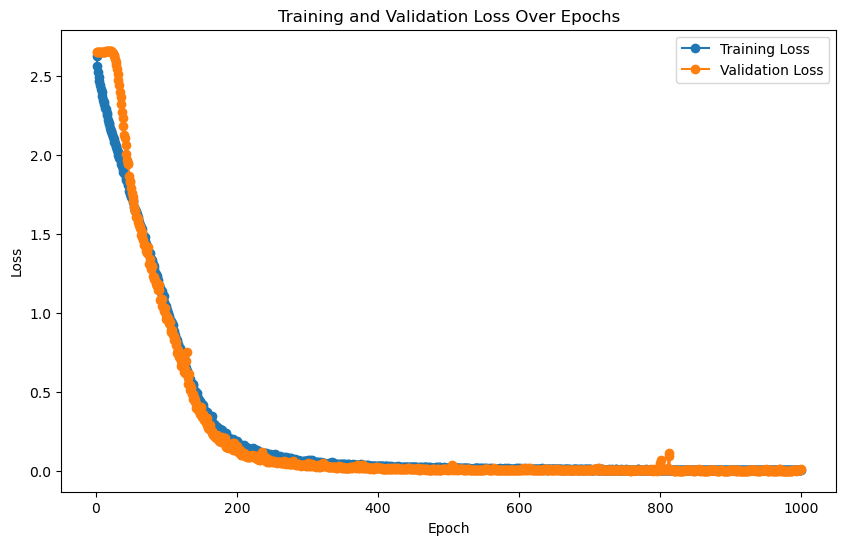

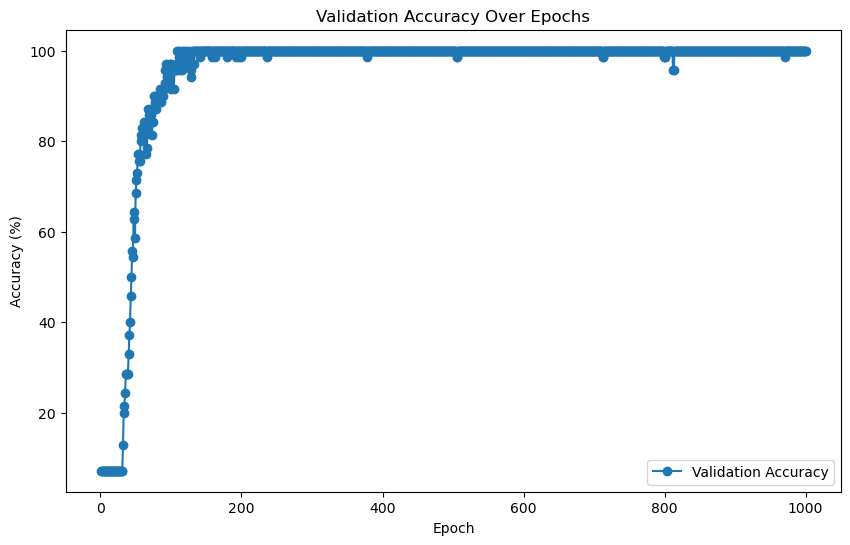


Evaluating on the test set...
    Test Batch [1/11], Loss: 0.0006

Final Test Loss: 0.0535, Test Accuracy: 98.62%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/11 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 560 samples with 64 features each
LOG: Labels shape: (560,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2618 samples with 64 features each
LOG: Labels shape: (2618,)

LOG: Training features shape: (560, 64), Training labels shape: (560,)
LOG: Validation features shape: (70, 64), Validation labels shape: (70,)
LOG: Test features shape: (2618, 64), Test labels shape: (2618,)

LOG: Training Logistic Regression model...


LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 77.14%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.62      1.00      0.77         5
           2       0.71      1.00      0.83         5
           3       0.60      0.60      0.60         5
           4       1.00      0.40      0.57         5
           5       0.40      0.40      0.40         5
           6       1.00      1.00      1.00         5
           7       1.00      0.40      0.57         5
           8       1.00      0.60      0.75         5
           9       0.62      1.00      0.77         5
          10       0.71      1.00      0.83         5
          11       0.83      1.00      0.91         5
          12       1.00      0.60      0.75         5
          13       1.00      0.80      0.89         5

    accuracy                          

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 560 samples with 64 features each
LOG: Labels shape: (560,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2618 samples with 64 features each
LOG: Labels shape: (2618,)
Train reps shape: (560, 64)
Train labels shape: (560,)
Val reps shape: (70, 64)
Val labels shape: (70,)
Test reps shape: (2618, 64)
Test labels shape: (2618,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6907  |  Val Loss: 2.6245
Validation loss improved from inf to 2.6245.
[Epoch 2/1000] Train Loss: 2.6206  |  Val Loss: 2.6076
Validation loss improved from 2.6245 to 2.6076.
[Epoch 3/1000] Train Loss: 2.6003  |  Val Loss: 2.5847
Validation loss improved from 2.6076 to 2.5847.
[Epoch 4/1000] Train Loss: 2.5842  |  Val Loss: 2.5681
Validation loss improved from 2.5847 to 2.5681.
[Epoch 5/1000] Train Loss: 2.5604  |  Val Loss: 2.5404
Validation loss improved from 2.5681 to 2.5404.


[Epoch 6/1000] Train Loss: 2.5291  |  Val Loss: 2.5025
Validation loss improved from 2.5404 to 2.5025.
[Epoch 7/1000] Train Loss: 2.4926  |  Val Loss: 2.4635
Validation loss improved from 2.5025 to 2.4635.


[Epoch 8/1000] Train Loss: 2.4526  |  Val Loss: 2.4341
Validation loss improved from 2.4635 to 2.4341.
[Epoch 9/1000] Train Loss: 2.4135  |  Val Loss: 2.3867
Validation loss improved from 2.4341 to 2.3867.
[Epoch 10/1000] Train Loss: 2.3592  |  Val Loss: 2.3322
Validation loss improved from 2.3867 to 2.3322.


[Epoch 11/1000] Train Loss: 2.3053  |  Val Loss: 2.2775
Validation loss improved from 2.3322 to 2.2775.
[Epoch 12/1000] Train Loss: 2.2546  |  Val Loss: 2.2222
Validation loss improved from 2.2775 to 2.2222.
[Epoch 13/1000] Train Loss: 2.1894  |  Val Loss: 2.1594
Validation loss improved from 2.2222 to 2.1594.
[Epoch 14/1000] Train Loss: 2.1250  |  Val Loss: 2.0713
Validation loss improved from 2.1594 to 2.0713.


[Epoch 15/1000] Train Loss: 2.0595  |  Val Loss: 2.0182
Validation loss improved from 2.0713 to 2.0182.
[Epoch 16/1000] Train Loss: 2.0006  |  Val Loss: 1.9467
Validation loss improved from 2.0182 to 1.9467.
[Epoch 17/1000] Train Loss: 1.9383  |  Val Loss: 1.9064
Validation loss improved from 1.9467 to 1.9064.


[Epoch 18/1000] Train Loss: 1.8754  |  Val Loss: 1.8247
Validation loss improved from 1.9064 to 1.8247.
[Epoch 19/1000] Train Loss: 1.8120  |  Val Loss: 1.7904
Validation loss improved from 1.8247 to 1.7904.
[Epoch 20/1000] Train Loss: 1.7758  |  Val Loss: 1.7482
Validation loss improved from 1.7904 to 1.7482.


[Epoch 21/1000] Train Loss: 1.7182  |  Val Loss: 1.6811
Validation loss improved from 1.7482 to 1.6811.
[Epoch 22/1000] Train Loss: 1.6682  |  Val Loss: 1.6505
Validation loss improved from 1.6811 to 1.6505.
[Epoch 23/1000] Train Loss: 1.6348  |  Val Loss: 1.5947
Validation loss improved from 1.6505 to 1.5947.


[Epoch 24/1000] Train Loss: 1.5950  |  Val Loss: 1.5637
Validation loss improved from 1.5947 to 1.5637.
[Epoch 25/1000] Train Loss: 1.5626  |  Val Loss: 1.5708
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 26/1000] Train Loss: 1.5320  |  Val Loss: 1.5010
Validation loss improved from 1.5637 to 1.5010.
[Epoch 27/1000] Train Loss: 1.5090  |  Val Loss: 1.4762
Validation loss improved from 1.5010 to 1.4762.


[Epoch 28/1000] Train Loss: 1.4854  |  Val Loss: 1.4739
Validation loss improved from 1.4762 to 1.4739.
[Epoch 29/1000] Train Loss: 1.4604  |  Val Loss: 1.4273
Validation loss improved from 1.4739 to 1.4273.


[Epoch 30/1000] Train Loss: 1.4328  |  Val Loss: 1.4159
Validation loss improved from 1.4273 to 1.4159.
[Epoch 31/1000] Train Loss: 1.4289  |  Val Loss: 1.4327
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 32/1000] Train Loss: 1.4302  |  Val Loss: 1.4186
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 33/1000] Train Loss: 1.3866  |  Val Loss: 1.3727
Validation loss improved from 1.4159 to 1.3727.
[Epoch 34/1000] Train Loss: 1.3801  |  Val Loss: 1.3574
Validation loss improved from 1.3727 to 1.3574.
[Epoch 35/1000] Train Loss: 1.3569  |  Val Loss: 1.3584
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 36/1000] Train Loss: 1.3615  |  Val Loss: 1.3218
Validation loss improved from 1.3574 to 1.3218.
[Epoch 37/1000] Train Loss: 1.3601  |  Val Loss: 1.3168
Validation loss improved from 1.3218 to 1.3168.


[Epoch 38/1000] Train Loss: 1.3317  |  Val Loss: 1.3271
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 39/1000] Train Loss: 1.3214  |  Val Loss: 1.3472
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 40/1000] Train Loss: 1.3121  |  Val Loss: 1.3124
Validation loss improved from 1.3168 to 1.3124.
[Epoch 41/1000] Train Loss: 1.3058  |  Val Loss: 1.2758
Validation loss improved from 1.3124 to 1.2758.
[Epoch 42/1000] Train Loss: 1.3113  |  Val Loss: 1.4948
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 43/1000] Train Loss: 1.3501  |  Val Loss: 1.2863
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 44/1000] Train Loss: 1.3231  |  Val Loss: 1.3720
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 45/1000] Train Loss: 1.2979  |  Val Loss: 1.2581
Validation loss improved from 1.2758 to 1.2581.
[Epoch 46/1000] Train Loss: 1.2760  |  Val Loss: 1.2480
Validation loss improved from 1.2581 to 1.2480.
[Epoch 47/1000] Train Loss: 1.2919  |  Val Loss: 1.3291
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 48/1000] Train Loss: 1.2854  |  Val Loss: 1.2438
Validation loss improved from 1.2480 to 1.2438.
[Epoch 49/1000] Train Loss: 1.2785  |  Val Loss: 1.2981
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 50/1000] Train Loss: 1.2694  |  Val Loss: 1.2547
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 51/1000] Train Loss: 1.2527  |  Val Loss: 1.2743
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 52/1000] Train Loss: 1.2465  |  Val Loss: 1.2762
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 53/1000] Train Loss: 1.2976  |  Val Loss: 1.2207
Validation loss improved from 1.2438 to 1.2207.
[Epoch 54/1000] Train Loss: 1.2625  |  Val Loss: 1.2337
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 55/1000] Train Loss: 1.2388  |  Val Loss: 1.3238
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 56/1000] Train Loss: 1.2477  |  Val Loss: 1.2082
Validation loss improved from 1.2207 to 1.2082.
[Epoch 57/1000] Train Loss: 1.2324  |  Val Loss: 1.3022
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 58/1000] Train Loss: 1.2489  |  Val Loss: 1.2069
Validation loss improved from 1.2082 to 1.2069.
[Epoch 59/1000] Train Loss: 1.2384  |  Val Loss: 1.2903
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 60/1000] Train Loss: 1.2688  |  Val Loss: 1.2063
Validation loss improved from 1.2069 to 1.2063.
[Epoch 61/1000] Train Loss: 1.2805  |  Val Loss: 1.2332
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 62/1000] Train Loss: 1.2206  |  Val Loss: 1.3317
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 63/1000] Train Loss: 1.2378  |  Val Loss: 1.2092
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 64/1000] Train Loss: 1.2689  |  Val Loss: 1.4749
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 65/1000] Train Loss: 1.2440  |  Val Loss: 1.2017
Validation loss improved from 1.2063 to 1.2017.
[Epoch 66/1000] Train Loss: 1.2115  |  Val Loss: 1.2013
Validation loss improved from 1.2017 to 1.2013.
[Epoch 67/1000] Train Loss: 1.2136  |  Val Loss: 1.1873
Validation loss improved from 1.2013 to 1.1873.


[Epoch 68/1000] Train Loss: 1.2221  |  Val Loss: 1.4302
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 69/1000] Train Loss: 1.2525  |  Val Loss: 1.1868
Validation loss improved from 1.1873 to 1.1868.
[Epoch 70/1000] Train Loss: 1.2185  |  Val Loss: 1.1809
Validation loss improved from 1.1868 to 1.1809.
[Epoch 71/1000] Train Loss: 1.2217  |  Val Loss: 1.2886
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 72/1000] Train Loss: 1.2006  |  Val Loss: 1.2042
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 73/1000] Train Loss: 1.2141  |  Val Loss: 1.2397
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 74/1000] Train Loss: 1.3044  |  Val Loss: 1.3227
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 75/1000] Train Loss: 1.2631  |  Val Loss: 1.2000
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 76/1000] Train Loss: 1.2537  |  Val Loss: 1.1893
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 77/1000] Train Loss: 1.1991  |  Val Loss: 1.3077
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 78/1000] Train Loss: 1.2087  |  Val Loss: 1.2022
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 79/1000] Train Loss: 1.1886  |  Val Loss: 1.2010
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 80/1000] Train Loss: 1.2027  |  Val Loss: 1.2450
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 81/1000] Train Loss: 1.2034  |  Val Loss: 1.1981
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 82/1000] Train Loss: 1.2027  |  Val Loss: 1.1726
Validation loss improved from 1.1809 to 1.1726.


[Epoch 83/1000] Train Loss: 1.1968  |  Val Loss: 1.2402
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 84/1000] Train Loss: 1.2075  |  Val Loss: 1.1887
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 85/1000] Train Loss: 1.2202  |  Val Loss: 1.2119
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 86/1000] Train Loss: 1.2311  |  Val Loss: 1.2436
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 87/1000] Train Loss: 1.1932  |  Val Loss: 1.1653
Validation loss improved from 1.1726 to 1.1653.
[Epoch 88/1000] Train Loss: 1.1949  |  Val Loss: 1.1961
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 89/1000] Train Loss: 1.1804  |  Val Loss: 1.1988
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 90/1000] Train Loss: 1.1801  |  Val Loss: 1.1640
Validation loss improved from 1.1653 to 1.1640.
[Epoch 91/1000] Train Loss: 1.2133  |  Val Loss: 1.1672
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 92/1000] Train Loss: 1.2022  |  Val Loss: 1.3069
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 93/1000] Train Loss: 1.1929  |  Val Loss: 1.4003
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 94/1000] Train Loss: 1.2548  |  Val Loss: 1.2115
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 95/1000] Train Loss: 1.2862  |  Val Loss: 1.2530
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 96/1000] Train Loss: 1.2675  |  Val Loss: 1.1763
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 97/1000] Train Loss: 1.2374  |  Val Loss: 1.2389
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 98/1000] Train Loss: 1.1806  |  Val Loss: 1.1731
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 99/1000] Train Loss: 1.1722  |  Val Loss: 1.1565
Validation loss improved from 1.1640 to 1.1565.
[Epoch 100/1000] Train Loss: 1.1654  |  Val Loss: 1.1513
Validation loss improved from 1.1565 to 1.1513.
[Epoch 101/1000] Train Loss: 1.1716  |  Val Loss: 1.2743
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 102/1000] Train Loss: 1.1893  |  Val Loss: 1.1612
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 103/1000] Train Loss: 1.1734  |  Val Loss: 1.1927
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 104/1000] Train Loss: 1.1603  |  Val Loss: 1.1769
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 105/1000] Train Loss: 1.1581  |  Val Loss: 1.1538
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 106/1000] Train Loss: 1.1672  |  Val Loss: 1.1467
Validation loss improved from 1.1513 to 1.1467.
[Epoch 107/1000] Train Loss: 1.1575  |  Val Loss: 1.2593
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 108/1000] Train Loss: 1.1677  |  Val Loss: 1.2438
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 109/1000] Train Loss: 1.1559  |  Val Loss: 1.1458
Validation loss improved from 1.1467 to 1.1458.
[Epoch 110/1000] Train Loss: 1.1853  |  Val Loss: 1.1827
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 111/1000] Train Loss: 1.1616  |  Val Loss: 1.2020
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 112/1000] Train Loss: 1.1654  |  Val Loss: 1.1492
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 113/1000] Train Loss: 1.1551  |  Val Loss: 1.2352
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 114/1000] Train Loss: 1.1802  |  Val Loss: 1.2083
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 115/1000] Train Loss: 1.1446  |  Val Loss: 1.1542
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 116/1000] Train Loss: 1.1564  |  Val Loss: 1.1681
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 117/1000] Train Loss: 1.1493  |  Val Loss: 1.1998
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 118/1000] Train Loss: 1.1763  |  Val Loss: 1.1896
!! Validation loss did NOT improve !! Patience: 9/100


[Epoch 119/1000] Train Loss: 1.1532  |  Val Loss: 1.1430
Validation loss improved from 1.1458 to 1.1430.
[Epoch 120/1000] Train Loss: 1.1605  |  Val Loss: 1.1457
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 121/1000] Train Loss: 1.1395  |  Val Loss: 1.1602
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 122/1000] Train Loss: 1.1541  |  Val Loss: 1.1993
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 123/1000] Train Loss: 1.1365  |  Val Loss: 1.1511
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 124/1000] Train Loss: 1.1517  |  Val Loss: 1.3300
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 125/1000] Train Loss: 1.1590  |  Val Loss: 1.1942
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 126/1000] Train Loss: 1.1705  |  Val Loss: 1.1389
Validation loss improved from 1.1430 to 1.1389.
[Epoch 127/1000] Train Loss: 1.1548  |  Val Loss: 1.1505
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 128/1000] Train Loss: 1.1472  |  Val Loss: 1.2184
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 129/1000] Train Loss: 1.1460  |  Val Loss: 1.1670
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 130/1000] Train Loss: 1.1304  |  Val Loss: 1.1702
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 131/1000] Train Loss: 1.1292  |  Val Loss: 1.1669
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 132/1000] Train Loss: 1.1272  |  Val Loss: 1.1480
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 133/1000] Train Loss: 1.1329  |  Val Loss: 1.1349
Validation loss improved from 1.1389 to 1.1349.


[Epoch 134/1000] Train Loss: 1.1427  |  Val Loss: 1.1644
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 135/1000] Train Loss: 1.1414  |  Val Loss: 1.2158
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 136/1000] Train Loss: 1.1362  |  Val Loss: 1.1339
Validation loss improved from 1.1349 to 1.1339.
[Epoch 137/1000] Train Loss: 1.1407  |  Val Loss: 1.1401
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 138/1000] Train Loss: 1.1339  |  Val Loss: 1.1875
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 139/1000] Train Loss: 1.1241  |  Val Loss: 1.1435
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 140/1000] Train Loss: 1.1236  |  Val Loss: 1.1371
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 141/1000] Train Loss: 1.1585  |  Val Loss: 1.1651
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 142/1000] Train Loss: 1.1833  |  Val Loss: 1.3565
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 143/1000] Train Loss: 1.1685  |  Val Loss: 1.1381
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 144/1000] Train Loss: 1.1461  |  Val Loss: 1.1316
Validation loss improved from 1.1339 to 1.1316.


[Epoch 145/1000] Train Loss: 1.1952  |  Val Loss: 1.3992
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 146/1000] Train Loss: 1.1764  |  Val Loss: 1.1281
Validation loss improved from 1.1316 to 1.1281.
[Epoch 147/1000] Train Loss: 1.1379  |  Val Loss: 1.1629
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 148/1000] Train Loss: 1.1305  |  Val Loss: 1.1592
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 149/1000] Train Loss: 1.1373  |  Val Loss: 1.1436
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 150/1000] Train Loss: 1.1349  |  Val Loss: 1.2640
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 151/1000] Train Loss: 1.1454  |  Val Loss: 1.1336
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 152/1000] Train Loss: 1.1742  |  Val Loss: 1.1306
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 153/1000] Train Loss: 1.1528  |  Val Loss: 1.2269
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 154/1000] Train Loss: 1.1193  |  Val Loss: 1.2237
!! Validation loss did NOT improve !! Patience: 8/100


[Epoch 155/1000] Train Loss: 1.1136  |  Val Loss: 1.1236
Validation loss improved from 1.1281 to 1.1236.
[Epoch 156/1000] Train Loss: 1.1173  |  Val Loss: 1.2153
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 157/1000] Train Loss: 1.1159  |  Val Loss: 1.2452
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 158/1000] Train Loss: 1.1266  |  Val Loss: 1.1480
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 159/1000] Train Loss: 1.1053  |  Val Loss: 1.1849
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 160/1000] Train Loss: 1.1134  |  Val Loss: 1.2330
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 161/1000] Train Loss: 1.1148  |  Val Loss: 1.1408
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 162/1000] Train Loss: 1.1202  |  Val Loss: 1.1648
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 163/1000] Train Loss: 1.1072  |  Val Loss: 1.1619
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 164/1000] Train Loss: 1.1092  |  Val Loss: 1.1140
Validation loss improved from 1.1236 to 1.1140.


[Epoch 165/1000] Train Loss: 1.1080  |  Val Loss: 1.1306
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 166/1000] Train Loss: 1.1134  |  Val Loss: 1.2164
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 167/1000] Train Loss: 1.1059  |  Val Loss: 1.1109
Validation loss improved from 1.1140 to 1.1109.
[Epoch 168/1000] Train Loss: 1.1017  |  Val Loss: 1.1390
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 169/1000] Train Loss: 1.0944  |  Val Loss: 1.1904
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 170/1000] Train Loss: 1.0973  |  Val Loss: 1.1176
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 171/1000] Train Loss: 1.1252  |  Val Loss: 1.1243
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 172/1000] Train Loss: 1.1200  |  Val Loss: 1.1861
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 173/1000] Train Loss: 1.0942  |  Val Loss: 1.1222
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 174/1000] Train Loss: 1.1023  |  Val Loss: 1.1360
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 175/1000] Train Loss: 1.1455  |  Val Loss: 1.2592
!! Validation loss did NOT improve !! Patience: 8/100


[Epoch 176/1000] Train Loss: 1.1547  |  Val Loss: 1.1790
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 177/1000] Train Loss: 1.1768  |  Val Loss: 1.1767
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 178/1000] Train Loss: 1.1428  |  Val Loss: 1.1883
!! Validation loss did NOT improve !! Patience: 11/100


[Epoch 179/1000] Train Loss: 1.0992  |  Val Loss: 1.1222
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 180/1000] Train Loss: 1.1401  |  Val Loss: 1.1279
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 181/1000] Train Loss: 1.1182  |  Val Loss: 1.1481
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 182/1000] Train Loss: 1.0911  |  Val Loss: 1.1066
Validation loss improved from 1.1109 to 1.1066.
[Epoch 183/1000] Train Loss: 1.0876  |  Val Loss: 1.1336
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 184/1000] Train Loss: 1.0926  |  Val Loss: 1.1881
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 185/1000] Train Loss: 1.0929  |  Val Loss: 1.1374
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 186/1000] Train Loss: 1.0992  |  Val Loss: 1.1100
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 187/1000] Train Loss: 1.1308  |  Val Loss: 1.3688
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 188/1000] Train Loss: 1.1590  |  Val Loss: 1.3683
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 189/1000] Train Loss: 1.1526  |  Val Loss: 1.1090
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 190/1000] Train Loss: 1.1231  |  Val Loss: 1.1112
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 191/1000] Train Loss: 1.1152  |  Val Loss: 1.1513
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 192/1000] Train Loss: 1.1759  |  Val Loss: 1.3475
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 193/1000] Train Loss: 1.0930  |  Val Loss: 1.1287
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 194/1000] Train Loss: 1.0771  |  Val Loss: 1.1499
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 195/1000] Train Loss: 1.1237  |  Val Loss: 1.1095
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 196/1000] Train Loss: 1.1000  |  Val Loss: 1.1561
!! Validation loss did NOT improve !! Patience: 14/100


[Epoch 197/1000] Train Loss: 1.0953  |  Val Loss: 1.2615
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 198/1000] Train Loss: 1.1297  |  Val Loss: 1.1992
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 199/1000] Train Loss: 1.0822  |  Val Loss: 1.1207
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 200/1000] Train Loss: 1.1471  |  Val Loss: 1.1247
!! Validation loss did NOT improve !! Patience: 18/100


[Epoch 201/1000] Train Loss: 1.1411  |  Val Loss: 1.1974
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 202/1000] Train Loss: 1.1135  |  Val Loss: 1.3234
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 203/1000] Train Loss: 1.0933  |  Val Loss: 1.1335
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 204/1000] Train Loss: 1.0713  |  Val Loss: 1.0995
Validation loss improved from 1.1066 to 1.0995.
[Epoch 205/1000] Train Loss: 1.0856  |  Val Loss: 1.1011
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 206/1000] Train Loss: 1.1155  |  Val Loss: 1.2842
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 207/1000] Train Loss: 1.1067  |  Val Loss: 1.0985
Validation loss improved from 1.0995 to 1.0985.


[Epoch 208/1000] Train Loss: 1.0907  |  Val Loss: 1.1288
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 209/1000] Train Loss: 1.0765  |  Val Loss: 1.2332
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 210/1000] Train Loss: 1.0963  |  Val Loss: 1.1717
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 211/1000] Train Loss: 1.0648  |  Val Loss: 1.1848
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 212/1000] Train Loss: 1.0585  |  Val Loss: 1.1790
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 213/1000] Train Loss: 1.0832  |  Val Loss: 1.1038
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 214/1000] Train Loss: 1.0783  |  Val Loss: 1.1229
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 215/1000] Train Loss: 1.0767  |  Val Loss: 1.2046
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 216/1000] Train Loss: 1.0684  |  Val Loss: 1.1632
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 217/1000] Train Loss: 1.0505  |  Val Loss: 1.1646
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 218/1000] Train Loss: 1.0537  |  Val Loss: 1.1405
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 219/1000] Train Loss: 1.0926  |  Val Loss: 1.0843
Validation loss improved from 1.0985 to 1.0843.
[Epoch 220/1000] Train Loss: 1.0632  |  Val Loss: 1.1398
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 221/1000] Train Loss: 1.0653  |  Val Loss: 1.1011
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 222/1000] Train Loss: 1.0480  |  Val Loss: 1.1188
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 223/1000] Train Loss: 1.0466  |  Val Loss: 1.1898
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 224/1000] Train Loss: 1.0707  |  Val Loss: 1.1669
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 225/1000] Train Loss: 1.0615  |  Val Loss: 1.1264
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 226/1000] Train Loss: 1.1116  |  Val Loss: 1.1146
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 227/1000] Train Loss: 1.0651  |  Val Loss: 1.2555
!! Validation loss did NOT improve !! Patience: 8/100


[Epoch 228/1000] Train Loss: 1.0436  |  Val Loss: 1.0965
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 229/1000] Train Loss: 1.0696  |  Val Loss: 1.0906
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 230/1000] Train Loss: 1.0353  |  Val Loss: 1.1202
!! Validation loss did NOT improve !! Patience: 11/100


[Epoch 231/1000] Train Loss: 1.0297  |  Val Loss: 1.0970
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 232/1000] Train Loss: 1.0227  |  Val Loss: 1.0858
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 233/1000] Train Loss: 1.0424  |  Val Loss: 1.1489
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 234/1000] Train Loss: 1.0547  |  Val Loss: 1.1501
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 235/1000] Train Loss: 1.0183  |  Val Loss: 1.0807
Validation loss improved from 1.0843 to 1.0807.
[Epoch 236/1000] Train Loss: 1.0379  |  Val Loss: 1.0665
Validation loss improved from 1.0807 to 1.0665.


[Epoch 237/1000] Train Loss: 1.0298  |  Val Loss: 1.0779
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 238/1000] Train Loss: 1.0251  |  Val Loss: 1.1428
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 239/1000] Train Loss: 1.0524  |  Val Loss: 1.1861
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 240/1000] Train Loss: 1.0467  |  Val Loss: 1.0895
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 241/1000] Train Loss: 1.0061  |  Val Loss: 1.0678
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 242/1000] Train Loss: 1.0301  |  Val Loss: 1.2145
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 243/1000] Train Loss: 1.0124  |  Val Loss: 1.0914
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 244/1000] Train Loss: 1.0062  |  Val Loss: 1.0628
Validation loss improved from 1.0665 to 1.0628.
[Epoch 245/1000] Train Loss: 1.0122  |  Val Loss: 1.1182
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 246/1000] Train Loss: 0.9988  |  Val Loss: 1.0658
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 247/1000] Train Loss: 1.0129  |  Val Loss: 1.1225
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 248/1000] Train Loss: 1.0176  |  Val Loss: 1.0599
Validation loss improved from 1.0628 to 1.0599.
[Epoch 249/1000] Train Loss: 1.0111  |  Val Loss: 1.0738
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 250/1000] Train Loss: 0.9942  |  Val Loss: 1.1319
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 251/1000] Train Loss: 1.0241  |  Val Loss: 1.0789
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 252/1000] Train Loss: 1.0163  |  Val Loss: 1.0722
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 253/1000] Train Loss: 1.0239  |  Val Loss: 1.1287
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 254/1000] Train Loss: 1.0326  |  Val Loss: 1.1679
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 255/1000] Train Loss: 1.0298  |  Val Loss: 1.0570
Validation loss improved from 1.0599 to 1.0570.
[Epoch 256/1000] Train Loss: 0.9952  |  Val Loss: 1.1089
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 257/1000] Train Loss: 0.9913  |  Val Loss: 1.1267
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 258/1000] Train Loss: 1.0238  |  Val Loss: 1.0924
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 259/1000] Train Loss: 1.0135  |  Val Loss: 1.1086
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 260/1000] Train Loss: 1.0347  |  Val Loss: 1.1920
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 261/1000] Train Loss: 1.0379  |  Val Loss: 1.2435
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 262/1000] Train Loss: 1.0130  |  Val Loss: 1.0447
Validation loss improved from 1.0570 to 1.0447.
[Epoch 263/1000] Train Loss: 1.0088  |  Val Loss: 1.0497
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 264/1000] Train Loss: 0.9694  |  Val Loss: 1.2007
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 265/1000] Train Loss: 1.0303  |  Val Loss: 1.1573
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 266/1000] Train Loss: 0.9971  |  Val Loss: 1.0399
Validation loss improved from 1.0447 to 1.0399.


[Epoch 267/1000] Train Loss: 0.9627  |  Val Loss: 1.0494
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 268/1000] Train Loss: 0.9898  |  Val Loss: 1.0841
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 269/1000] Train Loss: 0.9887  |  Val Loss: 1.1199
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 270/1000] Train Loss: 1.0751  |  Val Loss: 1.0815
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 271/1000] Train Loss: 0.9995  |  Val Loss: 1.1573
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 272/1000] Train Loss: 0.9581  |  Val Loss: 1.0517
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 273/1000] Train Loss: 1.0107  |  Val Loss: 1.0686
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 274/1000] Train Loss: 0.9899  |  Val Loss: 1.1250
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 275/1000] Train Loss: 0.9979  |  Val Loss: 1.2913
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 276/1000] Train Loss: 1.0645  |  Val Loss: 1.0415
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 277/1000] Train Loss: 1.0091  |  Val Loss: 1.0251
Validation loss improved from 1.0399 to 1.0251.


[Epoch 278/1000] Train Loss: 0.9716  |  Val Loss: 1.0602
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 279/1000] Train Loss: 0.9664  |  Val Loss: 1.1065
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 280/1000] Train Loss: 0.9946  |  Val Loss: 1.0268
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 281/1000] Train Loss: 1.0169  |  Val Loss: 1.0259
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 282/1000] Train Loss: 0.9741  |  Val Loss: 1.0456
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 283/1000] Train Loss: 0.9625  |  Val Loss: 1.0844
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 284/1000] Train Loss: 0.9293  |  Val Loss: 1.0237
Validation loss improved from 1.0251 to 1.0237.
[Epoch 285/1000] Train Loss: 0.9337  |  Val Loss: 1.0464
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 286/1000] Train Loss: 0.9407  |  Val Loss: 1.0126
Validation loss improved from 1.0237 to 1.0126.


[Epoch 287/1000] Train Loss: 0.9373  |  Val Loss: 1.0701
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 288/1000] Train Loss: 0.9455  |  Val Loss: 1.0251
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 289/1000] Train Loss: 0.9557  |  Val Loss: 1.0432
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 290/1000] Train Loss: 0.9898  |  Val Loss: 1.0994
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 291/1000] Train Loss: 0.9333  |  Val Loss: 1.0433
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 292/1000] Train Loss: 0.9479  |  Val Loss: 1.1959
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 293/1000] Train Loss: 0.9572  |  Val Loss: 1.1214
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 294/1000] Train Loss: 0.9638  |  Val Loss: 1.1066
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 295/1000] Train Loss: 1.0140  |  Val Loss: 1.0184
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 296/1000] Train Loss: 1.0176  |  Val Loss: 1.0119
Validation loss improved from 1.0126 to 1.0119.


[Epoch 297/1000] Train Loss: 0.9878  |  Val Loss: 1.1813
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 298/1000] Train Loss: 0.9617  |  Val Loss: 1.1688
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 299/1000] Train Loss: 0.9229  |  Val Loss: 1.0147
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 300/1000] Train Loss: 0.9181  |  Val Loss: 1.0235
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 301/1000] Train Loss: 0.9243  |  Val Loss: 1.0906
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 302/1000] Train Loss: 0.9322  |  Val Loss: 1.0528
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 303/1000] Train Loss: 0.9216  |  Val Loss: 1.1253
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 304/1000] Train Loss: 0.9284  |  Val Loss: 1.0683
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 305/1000] Train Loss: 0.9107  |  Val Loss: 1.0456
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 306/1000] Train Loss: 0.8963  |  Val Loss: 0.9882
Validation loss improved from 1.0119 to 0.9882.


[Epoch 307/1000] Train Loss: 0.9098  |  Val Loss: 1.0331
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 308/1000] Train Loss: 0.9023  |  Val Loss: 1.0932
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 309/1000] Train Loss: 0.9174  |  Val Loss: 1.0069
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 310/1000] Train Loss: 0.9165  |  Val Loss: 1.0126
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 311/1000] Train Loss: 0.9038  |  Val Loss: 1.1556
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 312/1000] Train Loss: 0.9475  |  Val Loss: 1.0665
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 313/1000] Train Loss: 0.9042  |  Val Loss: 1.0119
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 314/1000] Train Loss: 0.9068  |  Val Loss: 1.0427
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 315/1000] Train Loss: 0.9101  |  Val Loss: 1.1382
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 316/1000] Train Loss: 0.9003  |  Val Loss: 0.9779
Validation loss improved from 0.9882 to 0.9779.


[Epoch 317/1000] Train Loss: 0.8912  |  Val Loss: 0.9957
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 318/1000] Train Loss: 0.8803  |  Val Loss: 1.0268
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 319/1000] Train Loss: 0.8858  |  Val Loss: 1.0978
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 320/1000] Train Loss: 0.9153  |  Val Loss: 0.9739
Validation loss improved from 0.9779 to 0.9739.


[Epoch 321/1000] Train Loss: 0.9391  |  Val Loss: 1.0699
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 322/1000] Train Loss: 0.9049  |  Val Loss: 1.0047
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 323/1000] Train Loss: 0.9158  |  Val Loss: 1.0151
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 324/1000] Train Loss: 0.8721  |  Val Loss: 0.9917
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 325/1000] Train Loss: 0.8783  |  Val Loss: 1.0422
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 326/1000] Train Loss: 0.8684  |  Val Loss: 0.9592
Validation loss improved from 0.9739 to 0.9592.
[Epoch 327/1000] Train Loss: 0.9155  |  Val Loss: 1.0350
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 328/1000] Train Loss: 0.9742  |  Val Loss: 1.0697
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 329/1000] Train Loss: 0.9064  |  Val Loss: 0.9715
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 330/1000] Train Loss: 0.9036  |  Val Loss: 0.9995
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 331/1000] Train Loss: 0.9163  |  Val Loss: 0.9581
Validation loss improved from 0.9592 to 0.9581.


[Epoch 332/1000] Train Loss: 0.9396  |  Val Loss: 1.1891
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 333/1000] Train Loss: 0.8972  |  Val Loss: 1.0192
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 334/1000] Train Loss: 0.8667  |  Val Loss: 0.9527
Validation loss improved from 0.9581 to 0.9527.
[Epoch 335/1000] Train Loss: 0.8632  |  Val Loss: 0.9565
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 336/1000] Train Loss: 0.9066  |  Val Loss: 1.2079
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 337/1000] Train Loss: 0.8909  |  Val Loss: 1.1202
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 338/1000] Train Loss: 0.8967  |  Val Loss: 1.1028
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 339/1000] Train Loss: 0.9130  |  Val Loss: 1.1635
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 340/1000] Train Loss: 0.9042  |  Val Loss: 0.9764
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 341/1000] Train Loss: 0.8666  |  Val Loss: 0.9899
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 342/1000] Train Loss: 0.8595  |  Val Loss: 1.0517
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 343/1000] Train Loss: 0.8716  |  Val Loss: 0.9531
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 344/1000] Train Loss: 0.8225  |  Val Loss: 0.9571
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 345/1000] Train Loss: 0.8243  |  Val Loss: 0.9525
Validation loss improved from 0.9527 to 0.9525.
[Epoch 346/1000] Train Loss: 0.8992  |  Val Loss: 1.2076
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 347/1000] Train Loss: 0.8860  |  Val Loss: 1.1751
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 348/1000] Train Loss: 0.9004  |  Val Loss: 0.9490
Validation loss improved from 0.9525 to 0.9490.


[Epoch 349/1000] Train Loss: 0.8857  |  Val Loss: 0.9327
Validation loss improved from 0.9490 to 0.9327.
[Epoch 350/1000] Train Loss: 0.8468  |  Val Loss: 0.9246
Validation loss improved from 0.9327 to 0.9246.
[Epoch 351/1000] Train Loss: 0.8212  |  Val Loss: 0.9824
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 352/1000] Train Loss: 0.8077  |  Val Loss: 0.9727
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 353/1000] Train Loss: 0.8089  |  Val Loss: 1.0372
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 354/1000] Train Loss: 0.8240  |  Val Loss: 1.0196
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 355/1000] Train Loss: 0.8141  |  Val Loss: 1.1111
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 356/1000] Train Loss: 0.9605  |  Val Loss: 0.9735
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 357/1000] Train Loss: 0.8876  |  Val Loss: 0.9520
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 358/1000] Train Loss: 0.8106  |  Val Loss: 0.9135
Validation loss improved from 0.9246 to 0.9135.


[Epoch 359/1000] Train Loss: 0.8239  |  Val Loss: 0.9220
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 360/1000] Train Loss: 0.8086  |  Val Loss: 1.0119
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 361/1000] Train Loss: 0.8094  |  Val Loss: 0.9855
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 362/1000] Train Loss: 0.8254  |  Val Loss: 0.9360
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 363/1000] Train Loss: 0.7947  |  Val Loss: 0.9355
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 364/1000] Train Loss: 0.7849  |  Val Loss: 0.9489
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 365/1000] Train Loss: 0.8338  |  Val Loss: 0.9241
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 366/1000] Train Loss: 0.8257  |  Val Loss: 0.9430
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 367/1000] Train Loss: 0.8009  |  Val Loss: 0.9362
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 368/1000] Train Loss: 0.7968  |  Val Loss: 0.9386
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 369/1000] Train Loss: 0.8245  |  Val Loss: 0.9018
Validation loss improved from 0.9135 to 0.9018.


[Epoch 370/1000] Train Loss: 0.8073  |  Val Loss: 0.9609
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 371/1000] Train Loss: 0.7978  |  Val Loss: 1.0034
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 372/1000] Train Loss: 0.7812  |  Val Loss: 1.0162
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 373/1000] Train Loss: 0.7865  |  Val Loss: 0.9814
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 374/1000] Train Loss: 0.7973  |  Val Loss: 0.9206
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 375/1000] Train Loss: 0.7715  |  Val Loss: 0.9240
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 376/1000] Train Loss: 0.7814  |  Val Loss: 0.9928
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 377/1000] Train Loss: 0.8152  |  Val Loss: 1.0111
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 378/1000] Train Loss: 0.8328  |  Val Loss: 1.0107
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 379/1000] Train Loss: 0.7937  |  Val Loss: 0.9057
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 380/1000] Train Loss: 0.7641  |  Val Loss: 0.8826
Validation loss improved from 0.9018 to 0.8826.
[Epoch 381/1000] Train Loss: 0.7746  |  Val Loss: 0.9012
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 382/1000] Train Loss: 0.7812  |  Val Loss: 1.0166
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 383/1000] Train Loss: 0.8194  |  Val Loss: 1.0597
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 384/1000] Train Loss: 0.7874  |  Val Loss: 0.9107
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 385/1000] Train Loss: 0.7653  |  Val Loss: 0.9087
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 386/1000] Train Loss: 0.7683  |  Val Loss: 0.9245
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 387/1000] Train Loss: 0.7790  |  Val Loss: 0.8902
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 388/1000] Train Loss: 0.7788  |  Val Loss: 0.8800
Validation loss improved from 0.8826 to 0.8800.
[Epoch 389/1000] Train Loss: 0.7913  |  Val Loss: 0.8789
Validation loss improved from 0.8800 to 0.8789.


[Epoch 390/1000] Train Loss: 0.7505  |  Val Loss: 0.9395
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 391/1000] Train Loss: 0.7664  |  Val Loss: 0.8906
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 392/1000] Train Loss: 0.7671  |  Val Loss: 0.8742
Validation loss improved from 0.8789 to 0.8742.
[Epoch 393/1000] Train Loss: 0.7701  |  Val Loss: 0.9100
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 394/1000] Train Loss: 0.7454  |  Val Loss: 0.9064
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 395/1000] Train Loss: 0.7360  |  Val Loss: 0.8923
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 396/1000] Train Loss: 0.7514  |  Val Loss: 0.9318
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 397/1000] Train Loss: 0.7773  |  Val Loss: 0.9228
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 398/1000] Train Loss: 0.7955  |  Val Loss: 1.0337
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 399/1000] Train Loss: 0.7644  |  Val Loss: 0.9765
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 400/1000] Train Loss: 0.7911  |  Val Loss: 0.9041
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 401/1000] Train Loss: 0.8212  |  Val Loss: 0.8806
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 402/1000] Train Loss: 0.7598  |  Val Loss: 0.8768
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 403/1000] Train Loss: 0.7587  |  Val Loss: 1.0159
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 404/1000] Train Loss: 0.7913  |  Val Loss: 1.0132
!! Validation loss did NOT improve !! Patience: 12/100


[Epoch 405/1000] Train Loss: 0.7750  |  Val Loss: 0.9542
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 406/1000] Train Loss: 0.7481  |  Val Loss: 0.9138
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 407/1000] Train Loss: 0.7301  |  Val Loss: 1.0484
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 408/1000] Train Loss: 0.8197  |  Val Loss: 1.3783
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 409/1000] Train Loss: 0.8910  |  Val Loss: 1.1038
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 410/1000] Train Loss: 0.8197  |  Val Loss: 0.9553
!! Validation loss did NOT improve !! Patience: 18/100


[Epoch 411/1000] Train Loss: 0.7665  |  Val Loss: 0.8657
Validation loss improved from 0.8742 to 0.8657.
[Epoch 412/1000] Train Loss: 0.7934  |  Val Loss: 0.8964
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 413/1000] Train Loss: 0.7985  |  Val Loss: 0.8977
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 414/1000] Train Loss: 0.7472  |  Val Loss: 0.8968
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 415/1000] Train Loss: 0.7219  |  Val Loss: 1.1029
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 416/1000] Train Loss: 0.8551  |  Val Loss: 0.8836
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 417/1000] Train Loss: 0.7635  |  Val Loss: 0.9010
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 418/1000] Train Loss: 0.7149  |  Val Loss: 0.8478
Validation loss improved from 0.8657 to 0.8478.
[Epoch 419/1000] Train Loss: 0.7220  |  Val Loss: 0.8597
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 420/1000] Train Loss: 0.7208  |  Val Loss: 0.8705
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 421/1000] Train Loss: 0.7354  |  Val Loss: 0.9736
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 422/1000] Train Loss: 0.7119  |  Val Loss: 0.8774
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 423/1000] Train Loss: 0.7322  |  Val Loss: 0.8790
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 424/1000] Train Loss: 0.7821  |  Val Loss: 0.8568
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 425/1000] Train Loss: 0.7339  |  Val Loss: 0.8587
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 426/1000] Train Loss: 0.7347  |  Val Loss: 1.0031
!! Validation loss did NOT improve !! Patience: 8/100


[Epoch 427/1000] Train Loss: 0.7520  |  Val Loss: 0.8645
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 428/1000] Train Loss: 0.7652  |  Val Loss: 0.9325
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 429/1000] Train Loss: 0.7464  |  Val Loss: 1.0136
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 430/1000] Train Loss: 0.7425  |  Val Loss: 0.9681
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 431/1000] Train Loss: 0.7087  |  Val Loss: 0.9369
!! Validation loss did NOT improve !! Patience: 13/100


[Epoch 432/1000] Train Loss: 0.6971  |  Val Loss: 0.9814
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 433/1000] Train Loss: 0.7142  |  Val Loss: 0.8913
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 434/1000] Train Loss: 0.7089  |  Val Loss: 0.8433
Validation loss improved from 0.8478 to 0.8433.
[Epoch 435/1000] Train Loss: 0.6953  |  Val Loss: 0.8892
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 436/1000] Train Loss: 0.6925  |  Val Loss: 0.9362
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 437/1000] Train Loss: 0.6982  |  Val Loss: 0.8710
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 438/1000] Train Loss: 0.6893  |  Val Loss: 0.9128
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 439/1000] Train Loss: 0.7026  |  Val Loss: 0.8500
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 440/1000] Train Loss: 0.6941  |  Val Loss: 0.8487
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 441/1000] Train Loss: 0.7238  |  Val Loss: 0.9081
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 442/1000] Train Loss: 0.7484  |  Val Loss: 1.1984
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 443/1000] Train Loss: 0.7876  |  Val Loss: 1.0141
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 444/1000] Train Loss: 0.7458  |  Val Loss: 0.8423
Validation loss improved from 0.8433 to 0.8423.
[Epoch 445/1000] Train Loss: 0.6804  |  Val Loss: 0.9040
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 446/1000] Train Loss: 0.7350  |  Val Loss: 0.8767
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 447/1000] Train Loss: 0.6913  |  Val Loss: 0.8377
Validation loss improved from 0.8423 to 0.8377.
[Epoch 448/1000] Train Loss: 0.7288  |  Val Loss: 0.8559
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 449/1000] Train Loss: 0.7211  |  Val Loss: 1.0328
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 450/1000] Train Loss: 0.7199  |  Val Loss: 0.9180
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 451/1000] Train Loss: 0.6629  |  Val Loss: 0.9824
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 452/1000] Train Loss: 0.6875  |  Val Loss: 0.8769
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 453/1000] Train Loss: 0.6787  |  Val Loss: 0.9336
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 454/1000] Train Loss: 0.7619  |  Val Loss: 0.9876
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 455/1000] Train Loss: 0.7593  |  Val Loss: 1.0652
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 456/1000] Train Loss: 0.6881  |  Val Loss: 0.9148
!! Validation loss did NOT improve !! Patience: 9/100


[Epoch 457/1000] Train Loss: 0.6729  |  Val Loss: 0.9190
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 458/1000] Train Loss: 0.6690  |  Val Loss: 0.9113
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 459/1000] Train Loss: 0.6646  |  Val Loss: 0.8293
Validation loss improved from 0.8377 to 0.8293.
[Epoch 460/1000] Train Loss: 0.6881  |  Val Loss: 0.8867
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 461/1000] Train Loss: 0.6790  |  Val Loss: 0.8757
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 462/1000] Train Loss: 0.6812  |  Val Loss: 0.8753
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 463/1000] Train Loss: 0.6797  |  Val Loss: 0.9172
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 464/1000] Train Loss: 0.6871  |  Val Loss: 0.8282
Validation loss improved from 0.8293 to 0.8282.
[Epoch 465/1000] Train Loss: 0.6615  |  Val Loss: 0.8847
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 466/1000] Train Loss: 0.6540  |  Val Loss: 0.8313
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 467/1000] Train Loss: 0.6747  |  Val Loss: 0.8230
Validation loss improved from 0.8282 to 0.8230.
[Epoch 468/1000] Train Loss: 0.6763  |  Val Loss: 0.8680
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 469/1000] Train Loss: 0.7800  |  Val Loss: 0.8340
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 470/1000] Train Loss: 0.7927  |  Val Loss: 1.0580
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 471/1000] Train Loss: 0.7058  |  Val Loss: 0.9242
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 472/1000] Train Loss: 0.6519  |  Val Loss: 0.8736
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 473/1000] Train Loss: 0.6618  |  Val Loss: 0.8741
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 474/1000] Train Loss: 0.6729  |  Val Loss: 0.8227
Validation loss improved from 0.8230 to 0.8227.
[Epoch 475/1000] Train Loss: 0.6875  |  Val Loss: 0.8728
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 476/1000] Train Loss: 0.6590  |  Val Loss: 0.9426
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 477/1000] Train Loss: 0.6453  |  Val Loss: 0.8213
Validation loss improved from 0.8227 to 0.8213.
[Epoch 478/1000] Train Loss: 0.6552  |  Val Loss: 0.9742
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 479/1000] Train Loss: 0.6652  |  Val Loss: 0.8759
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 480/1000] Train Loss: 0.6387  |  Val Loss: 0.8728
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 481/1000] Train Loss: 0.6422  |  Val Loss: 0.8697
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 482/1000] Train Loss: 0.6757  |  Val Loss: 0.8271
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 483/1000] Train Loss: 0.6588  |  Val Loss: 0.8284
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 484/1000] Train Loss: 0.6598  |  Val Loss: 0.8606
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 485/1000] Train Loss: 0.6471  |  Val Loss: 0.8931
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 486/1000] Train Loss: 0.6749  |  Val Loss: 0.8133
Validation loss improved from 0.8213 to 0.8133.
[Epoch 487/1000] Train Loss: 0.6767  |  Val Loss: 0.8424
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 488/1000] Train Loss: 0.6482  |  Val Loss: 0.8350
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 489/1000] Train Loss: 0.6436  |  Val Loss: 0.8161
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 490/1000] Train Loss: 0.6557  |  Val Loss: 0.8560
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 491/1000] Train Loss: 0.6875  |  Val Loss: 0.9056
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 492/1000] Train Loss: 0.7709  |  Val Loss: 1.2080
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 493/1000] Train Loss: 0.7141  |  Val Loss: 0.9315
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 494/1000] Train Loss: 0.6688  |  Val Loss: 0.8206
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 495/1000] Train Loss: 0.6798  |  Val Loss: 0.9109
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 496/1000] Train Loss: 0.7107  |  Val Loss: 0.8553
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 497/1000] Train Loss: 0.6712  |  Val Loss: 1.0076
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 498/1000] Train Loss: 0.6830  |  Val Loss: 0.8541
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 499/1000] Train Loss: 0.6401  |  Val Loss: 0.8382
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 500/1000] Train Loss: 0.6396  |  Val Loss: 0.8040
Validation loss improved from 0.8133 to 0.8040.


[Epoch 501/1000] Train Loss: 0.6485  |  Val Loss: 0.8920
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 502/1000] Train Loss: 0.6352  |  Val Loss: 0.8056
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 503/1000] Train Loss: 0.6117  |  Val Loss: 0.8298
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 504/1000] Train Loss: 0.6302  |  Val Loss: 0.8660
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 505/1000] Train Loss: 0.6572  |  Val Loss: 0.9492
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 506/1000] Train Loss: 0.7051  |  Val Loss: 0.8453
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 507/1000] Train Loss: 0.6734  |  Val Loss: 0.8071
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 508/1000] Train Loss: 0.6457  |  Val Loss: 0.8128
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 509/1000] Train Loss: 0.6132  |  Val Loss: 0.8231
!! Validation loss did NOT improve !! Patience: 9/100


[Epoch 510/1000] Train Loss: 0.6107  |  Val Loss: 0.8402
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 511/1000] Train Loss: 0.6330  |  Val Loss: 0.8306
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 512/1000] Train Loss: 0.6232  |  Val Loss: 0.8223
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 513/1000] Train Loss: 0.6182  |  Val Loss: 0.8188
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 514/1000] Train Loss: 0.6267  |  Val Loss: 0.8967
!! Validation loss did NOT improve !! Patience: 14/100


[Epoch 515/1000] Train Loss: 0.6167  |  Val Loss: 0.8293
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 516/1000] Train Loss: 0.5995  |  Val Loss: 0.8661
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 517/1000] Train Loss: 0.6247  |  Val Loss: 0.8546
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 518/1000] Train Loss: 0.6415  |  Val Loss: 0.8161
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 519/1000] Train Loss: 0.6661  |  Val Loss: 0.8465
!! Validation loss did NOT improve !! Patience: 19/100


[Epoch 520/1000] Train Loss: 0.6899  |  Val Loss: 0.9868
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 521/1000] Train Loss: 0.6659  |  Val Loss: 1.0317
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 522/1000] Train Loss: 0.6712  |  Val Loss: 0.9529
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 523/1000] Train Loss: 0.7206  |  Val Loss: 0.7936
Validation loss improved from 0.8040 to 0.7936.
[Epoch 524/1000] Train Loss: 0.7160  |  Val Loss: 0.8062
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 525/1000] Train Loss: 0.6652  |  Val Loss: 0.9123
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 526/1000] Train Loss: 0.6513  |  Val Loss: 0.8190
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 527/1000] Train Loss: 0.5957  |  Val Loss: 0.8988
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 528/1000] Train Loss: 0.6202  |  Val Loss: 0.8021
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 529/1000] Train Loss: 0.6182  |  Val Loss: 0.8083
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 530/1000] Train Loss: 0.6046  |  Val Loss: 0.7979
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 531/1000] Train Loss: 0.6133  |  Val Loss: 0.8091
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 532/1000] Train Loss: 0.5975  |  Val Loss: 0.8552
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 533/1000] Train Loss: 0.6090  |  Val Loss: 0.8721
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 534/1000] Train Loss: 0.6069  |  Val Loss: 0.8163
!! Validation loss did NOT improve !! Patience: 11/100


[Epoch 535/1000] Train Loss: 0.6009  |  Val Loss: 0.8138
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 536/1000] Train Loss: 0.5965  |  Val Loss: 0.8323
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 537/1000] Train Loss: 0.6002  |  Val Loss: 0.7945
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 538/1000] Train Loss: 0.5887  |  Val Loss: 0.8067
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 539/1000] Train Loss: 0.5884  |  Val Loss: 0.8925
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 540/1000] Train Loss: 0.5887  |  Val Loss: 0.8404
!! Validation loss did NOT improve !! Patience: 17/100


[Epoch 541/1000] Train Loss: 0.5876  |  Val Loss: 0.8356
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 542/1000] Train Loss: 0.6312  |  Val Loss: 1.1045
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 543/1000] Train Loss: 0.6255  |  Val Loss: 1.0064
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 544/1000] Train Loss: 0.6078  |  Val Loss: 0.9238
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 545/1000] Train Loss: 0.6501  |  Val Loss: 0.8840
!! Validation loss did NOT improve !! Patience: 22/100


[Epoch 546/1000] Train Loss: 0.5876  |  Val Loss: 0.7871
Validation loss improved from 0.7936 to 0.7871.
[Epoch 547/1000] Train Loss: 0.5875  |  Val Loss: 0.9124
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 548/1000] Train Loss: 0.5818  |  Val Loss: 0.8589
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 549/1000] Train Loss: 0.6139  |  Val Loss: 0.8106
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 550/1000] Train Loss: 0.5917  |  Val Loss: 0.9838
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 551/1000] Train Loss: 0.6948  |  Val Loss: 0.8989
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 552/1000] Train Loss: 0.6461  |  Val Loss: 0.8443
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 553/1000] Train Loss: 0.6020  |  Val Loss: 0.9509
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 554/1000] Train Loss: 0.5972  |  Val Loss: 0.8938
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 555/1000] Train Loss: 0.6248  |  Val Loss: 0.8182
!! Validation loss did NOT improve !! Patience: 9/100


[Epoch 556/1000] Train Loss: 0.6069  |  Val Loss: 0.8092
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 557/1000] Train Loss: 0.6109  |  Val Loss: 0.8150
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 558/1000] Train Loss: 0.5807  |  Val Loss: 0.8070
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 559/1000] Train Loss: 0.5715  |  Val Loss: 0.8203
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 560/1000] Train Loss: 0.5827  |  Val Loss: 0.8473
!! Validation loss did NOT improve !! Patience: 14/100


[Epoch 561/1000] Train Loss: 0.5692  |  Val Loss: 0.8340
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 562/1000] Train Loss: 0.5655  |  Val Loss: 0.8693
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 563/1000] Train Loss: 0.5972  |  Val Loss: 0.9459
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 564/1000] Train Loss: 0.6015  |  Val Loss: 0.8789
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 565/1000] Train Loss: 0.6012  |  Val Loss: 1.0408
!! Validation loss did NOT improve !! Patience: 19/100


[Epoch 566/1000] Train Loss: 0.6693  |  Val Loss: 0.8862
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 567/1000] Train Loss: 0.6463  |  Val Loss: 0.9139
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 568/1000] Train Loss: 0.6690  |  Val Loss: 0.8204
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 569/1000] Train Loss: 0.6345  |  Val Loss: 0.7892
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 570/1000] Train Loss: 0.6365  |  Val Loss: 0.7805
Validation loss improved from 0.7871 to 0.7805.


[Epoch 571/1000] Train Loss: 0.5810  |  Val Loss: 0.8062
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 572/1000] Train Loss: 0.6116  |  Val Loss: 1.0107
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 573/1000] Train Loss: 0.6219  |  Val Loss: 0.9450
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 574/1000] Train Loss: 0.6756  |  Val Loss: 1.0747
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 575/1000] Train Loss: 0.6312  |  Val Loss: 0.8480
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 576/1000] Train Loss: 0.6061  |  Val Loss: 0.8179
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 577/1000] Train Loss: 0.6179  |  Val Loss: 0.8137
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 578/1000] Train Loss: 0.6045  |  Val Loss: 0.7771
Validation loss improved from 0.7805 to 0.7771.
[Epoch 579/1000] Train Loss: 0.6136  |  Val Loss: 0.8486
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 580/1000] Train Loss: 0.5757  |  Val Loss: 0.7807
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 581/1000] Train Loss: 0.5673  |  Val Loss: 0.8032
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 582/1000] Train Loss: 0.5808  |  Val Loss: 0.8140
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 583/1000] Train Loss: 0.5720  |  Val Loss: 0.8038
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 584/1000] Train Loss: 0.5789  |  Val Loss: 0.8386
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 585/1000] Train Loss: 0.5718  |  Val Loss: 0.9123
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 586/1000] Train Loss: 0.5871  |  Val Loss: 0.9061
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 587/1000] Train Loss: 0.5643  |  Val Loss: 0.8902
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 588/1000] Train Loss: 0.5844  |  Val Loss: 0.8288
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 589/1000] Train Loss: 0.5734  |  Val Loss: 0.8366
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 590/1000] Train Loss: 0.5621  |  Val Loss: 0.8252
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 591/1000] Train Loss: 0.5562  |  Val Loss: 0.7990
!! Validation loss did NOT improve !! Patience: 13/100


[Epoch 592/1000] Train Loss: 0.5550  |  Val Loss: 0.8010
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 593/1000] Train Loss: 0.5513  |  Val Loss: 0.8215
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 594/1000] Train Loss: 0.5887  |  Val Loss: 0.8031
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 595/1000] Train Loss: 0.5823  |  Val Loss: 0.8064
!! Validation loss did NOT improve !! Patience: 17/100


[Epoch 596/1000] Train Loss: 0.5745  |  Val Loss: 0.8518
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 597/1000] Train Loss: 0.5827  |  Val Loss: 0.9430
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 598/1000] Train Loss: 0.6056  |  Val Loss: 0.8212
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 599/1000] Train Loss: 0.5643  |  Val Loss: 0.7933
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 600/1000] Train Loss: 0.5631  |  Val Loss: 0.7888
!! Validation loss did NOT improve !! Patience: 22/100


[Epoch 601/1000] Train Loss: 0.5503  |  Val Loss: 0.8846
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 602/1000] Train Loss: 0.5720  |  Val Loss: 0.8373
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 603/1000] Train Loss: 0.5715  |  Val Loss: 0.7873
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 604/1000] Train Loss: 0.5654  |  Val Loss: 0.8103
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 605/1000] Train Loss: 0.5517  |  Val Loss: 0.8200
!! Validation loss did NOT improve !! Patience: 27/100


[Epoch 606/1000] Train Loss: 0.6088  |  Val Loss: 0.8012
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 607/1000] Train Loss: 0.6424  |  Val Loss: 0.9637
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 608/1000] Train Loss: 0.6520  |  Val Loss: 0.8250
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 609/1000] Train Loss: 0.6606  |  Val Loss: 0.8450
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 610/1000] Train Loss: 0.5889  |  Val Loss: 0.8154
!! Validation loss did NOT improve !! Patience: 32/100


[Epoch 611/1000] Train Loss: 0.5509  |  Val Loss: 0.9213
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 612/1000] Train Loss: 0.5827  |  Val Loss: 0.9076
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 613/1000] Train Loss: 0.5602  |  Val Loss: 0.9059
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 614/1000] Train Loss: 0.5867  |  Val Loss: 0.8379
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 615/1000] Train Loss: 0.5546  |  Val Loss: 0.8050
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 616/1000] Train Loss: 0.5504  |  Val Loss: 0.7988
!! Validation loss did NOT improve !! Patience: 38/100


[Epoch 617/1000] Train Loss: 0.5487  |  Val Loss: 0.8244
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 618/1000] Train Loss: 0.5616  |  Val Loss: 0.8230
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 619/1000] Train Loss: 0.5743  |  Val Loss: 0.8682
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 620/1000] Train Loss: 0.5387  |  Val Loss: 0.7868
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 621/1000] Train Loss: 0.5667  |  Val Loss: 0.9062
!! Validation loss did NOT improve !! Patience: 43/100


[Epoch 622/1000] Train Loss: 0.5519  |  Val Loss: 0.8438
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 623/1000] Train Loss: 0.5839  |  Val Loss: 0.8369
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 624/1000] Train Loss: 0.5436  |  Val Loss: 0.7951
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 625/1000] Train Loss: 0.5344  |  Val Loss: 0.7747
Validation loss improved from 0.7771 to 0.7747.
[Epoch 626/1000] Train Loss: 0.5900  |  Val Loss: 0.7700
Validation loss improved from 0.7747 to 0.7700.


[Epoch 627/1000] Train Loss: 0.5658  |  Val Loss: 0.8487
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 628/1000] Train Loss: 0.6349  |  Val Loss: 0.7733
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 629/1000] Train Loss: 0.5565  |  Val Loss: 0.7843
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 630/1000] Train Loss: 0.5659  |  Val Loss: 0.7904
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 631/1000] Train Loss: 0.5507  |  Val Loss: 0.8320
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 632/1000] Train Loss: 0.5707  |  Val Loss: 0.8335
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 633/1000] Train Loss: 0.5691  |  Val Loss: 0.8099
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 634/1000] Train Loss: 0.5546  |  Val Loss: 0.8250
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 635/1000] Train Loss: 0.5316  |  Val Loss: 0.7746
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 636/1000] Train Loss: 0.5406  |  Val Loss: 0.7830
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 637/1000] Train Loss: 0.5578  |  Val Loss: 0.9653
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 638/1000] Train Loss: 0.5527  |  Val Loss: 0.8269
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 639/1000] Train Loss: 0.5423  |  Val Loss: 0.9031
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 640/1000] Train Loss: 0.5850  |  Val Loss: 0.8457
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 641/1000] Train Loss: 0.6051  |  Val Loss: 0.7755
!! Validation loss did NOT improve !! Patience: 15/100


[Epoch 642/1000] Train Loss: 0.6321  |  Val Loss: 0.8263
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 643/1000] Train Loss: 0.6253  |  Val Loss: 0.8087
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 644/1000] Train Loss: 0.5222  |  Val Loss: 0.7874
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 645/1000] Train Loss: 0.5220  |  Val Loss: 0.7773
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 646/1000] Train Loss: 0.5444  |  Val Loss: 0.8275
!! Validation loss did NOT improve !! Patience: 20/100


[Epoch 647/1000] Train Loss: 0.5688  |  Val Loss: 0.8259
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 648/1000] Train Loss: 0.5643  |  Val Loss: 0.9712
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 649/1000] Train Loss: 0.6091  |  Val Loss: 0.9476
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 650/1000] Train Loss: 0.5545  |  Val Loss: 0.9674
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 651/1000] Train Loss: 0.5521  |  Val Loss: 0.8012
!! Validation loss did NOT improve !! Patience: 25/100


[Epoch 652/1000] Train Loss: 0.5460  |  Val Loss: 0.7791
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 653/1000] Train Loss: 0.5129  |  Val Loss: 0.7773
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 654/1000] Train Loss: 0.5175  |  Val Loss: 0.8112
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 655/1000] Train Loss: 0.5722  |  Val Loss: 0.7933
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 656/1000] Train Loss: 0.5115  |  Val Loss: 0.8205
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 657/1000] Train Loss: 0.5460  |  Val Loss: 0.7663
Validation loss improved from 0.7700 to 0.7663.


[Epoch 658/1000] Train Loss: 0.5738  |  Val Loss: 0.7886
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 659/1000] Train Loss: 0.5246  |  Val Loss: 0.7740
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 660/1000] Train Loss: 0.5037  |  Val Loss: 0.7834
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 661/1000] Train Loss: 0.5257  |  Val Loss: 0.8118
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 662/1000] Train Loss: 0.5602  |  Val Loss: 0.8984
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 663/1000] Train Loss: 0.6000  |  Val Loss: 0.7910
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 664/1000] Train Loss: 0.5643  |  Val Loss: 0.7495
Validation loss improved from 0.7663 to 0.7495.
[Epoch 665/1000] Train Loss: 0.5850  |  Val Loss: 0.8035
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 666/1000] Train Loss: 0.5934  |  Val Loss: 0.8776
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 667/1000] Train Loss: 0.6841  |  Val Loss: 0.9809
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 668/1000] Train Loss: 0.5393  |  Val Loss: 0.8475
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 669/1000] Train Loss: 0.5597  |  Val Loss: 1.1025
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 670/1000] Train Loss: 0.5734  |  Val Loss: 0.8394
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 671/1000] Train Loss: 0.5366  |  Val Loss: 0.8009
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 672/1000] Train Loss: 0.5128  |  Val Loss: 0.8005
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 673/1000] Train Loss: 0.5320  |  Val Loss: 0.7514
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 674/1000] Train Loss: 0.4989  |  Val Loss: 0.8407
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 675/1000] Train Loss: 0.5759  |  Val Loss: 0.7795
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 676/1000] Train Loss: 0.5413  |  Val Loss: 0.7981
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 677/1000] Train Loss: 0.5645  |  Val Loss: 0.9036
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 678/1000] Train Loss: 0.5759  |  Val Loss: 1.3676
!! Validation loss did NOT improve !! Patience: 14/100


[Epoch 679/1000] Train Loss: 0.6796  |  Val Loss: 0.9441
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 680/1000] Train Loss: 0.5715  |  Val Loss: 0.7557
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 681/1000] Train Loss: 0.5373  |  Val Loss: 0.8268
!! Validation loss did NOT improve !! Patience: 17/100


[Epoch 682/1000] Train Loss: 0.5369  |  Val Loss: 0.7739
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 683/1000] Train Loss: 0.5053  |  Val Loss: 0.7740
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 684/1000] Train Loss: 0.5444  |  Val Loss: 0.7288
Validation loss improved from 0.7495 to 0.7288.
[Epoch 685/1000] Train Loss: 0.5239  |  Val Loss: 0.7565
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 686/1000] Train Loss: 0.5045  |  Val Loss: 0.7448
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 687/1000] Train Loss: 0.5162  |  Val Loss: 0.8866
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 688/1000] Train Loss: 0.5522  |  Val Loss: 0.7615
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 689/1000] Train Loss: 0.5860  |  Val Loss: 0.7482
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 690/1000] Train Loss: 0.6092  |  Val Loss: 0.7501
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 691/1000] Train Loss: 0.5546  |  Val Loss: 0.7384
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 692/1000] Train Loss: 0.5319  |  Val Loss: 0.7013
Validation loss improved from 0.7288 to 0.7013.
[Epoch 693/1000] Train Loss: 0.5340  |  Val Loss: 0.7471
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 694/1000] Train Loss: 0.5877  |  Val Loss: 0.7027
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 695/1000] Train Loss: 0.6082  |  Val Loss: 0.7711
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 696/1000] Train Loss: 0.5632  |  Val Loss: 0.9393
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 697/1000] Train Loss: 0.5333  |  Val Loss: 0.7404
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 698/1000] Train Loss: 0.5175  |  Val Loss: 0.7937
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 699/1000] Train Loss: 0.5079  |  Val Loss: 0.7139
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 700/1000] Train Loss: 0.5014  |  Val Loss: 0.7711
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 701/1000] Train Loss: 0.4864  |  Val Loss: 0.7670
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 702/1000] Train Loss: 0.4952  |  Val Loss: 0.7969
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 703/1000] Train Loss: 0.5282  |  Val Loss: 0.7526
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 704/1000] Train Loss: 0.5133  |  Val Loss: 0.7214
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 705/1000] Train Loss: 0.5077  |  Val Loss: 0.8626
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 706/1000] Train Loss: 0.5691  |  Val Loss: 0.7975
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 707/1000] Train Loss: 0.5754  |  Val Loss: 0.9824
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 708/1000] Train Loss: 0.5687  |  Val Loss: 0.8218
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 709/1000] Train Loss: 0.5043  |  Val Loss: 0.7897
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 710/1000] Train Loss: 0.4821  |  Val Loss: 0.7885
!! Validation loss did NOT improve !! Patience: 18/100


[Epoch 711/1000] Train Loss: 0.5238  |  Val Loss: 0.6948
Validation loss improved from 0.7013 to 0.6948.
[Epoch 712/1000] Train Loss: 0.4978  |  Val Loss: 0.7106
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 713/1000] Train Loss: 0.4819  |  Val Loss: 0.7062
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 714/1000] Train Loss: 0.4791  |  Val Loss: 0.7272
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 715/1000] Train Loss: 0.4759  |  Val Loss: 0.7078
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 716/1000] Train Loss: 0.4939  |  Val Loss: 0.6991
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 717/1000] Train Loss: 0.4860  |  Val Loss: 0.7685
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 718/1000] Train Loss: 0.5038  |  Val Loss: 0.7590
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 719/1000] Train Loss: 0.4989  |  Val Loss: 0.7709
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 720/1000] Train Loss: 0.5110  |  Val Loss: 0.7981
!! Validation loss did NOT improve !! Patience: 9/100


[Epoch 721/1000] Train Loss: 0.5243  |  Val Loss: 0.6984
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 722/1000] Train Loss: 0.5148  |  Val Loss: 0.7933
!! Validation loss did NOT improve !! Patience: 11/100


[Epoch 723/1000] Train Loss: 0.5424  |  Val Loss: 0.7145
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 724/1000] Train Loss: 0.5132  |  Val Loss: 0.7485
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 725/1000] Train Loss: 0.5047  |  Val Loss: 0.7649
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 726/1000] Train Loss: 0.5282  |  Val Loss: 0.7079
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 727/1000] Train Loss: 0.4962  |  Val Loss: 0.7419
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 728/1000] Train Loss: 0.5378  |  Val Loss: 0.7067
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 729/1000] Train Loss: 0.5121  |  Val Loss: 0.7054
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 730/1000] Train Loss: 0.4856  |  Val Loss: 0.7235
!! Validation loss did NOT improve !! Patience: 19/100


[Epoch 731/1000] Train Loss: 0.5064  |  Val Loss: 0.8389
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 732/1000] Train Loss: 0.4973  |  Val Loss: 0.7941
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 733/1000] Train Loss: 0.5295  |  Val Loss: 0.7846
!! Validation loss did NOT improve !! Patience: 22/100


[Epoch 734/1000] Train Loss: 0.5390  |  Val Loss: 0.8201
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 735/1000] Train Loss: 0.5009  |  Val Loss: 0.7790
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 736/1000] Train Loss: 0.5245  |  Val Loss: 0.9508
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 737/1000] Train Loss: 0.5529  |  Val Loss: 0.7622
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 738/1000] Train Loss: 0.4820  |  Val Loss: 0.8581
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 739/1000] Train Loss: 0.4850  |  Val Loss: 0.7496
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 740/1000] Train Loss: 0.4762  |  Val Loss: 0.7574
!! Validation loss did NOT improve !! Patience: 29/100


[Epoch 741/1000] Train Loss: 0.5039  |  Val Loss: 0.8102
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 742/1000] Train Loss: 0.5056  |  Val Loss: 0.7882
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 743/1000] Train Loss: 0.5083  |  Val Loss: 0.7738
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 744/1000] Train Loss: 0.4984  |  Val Loss: 0.7801
!! Validation loss did NOT improve !! Patience: 33/100


[Epoch 745/1000] Train Loss: 0.4853  |  Val Loss: 0.7050
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 746/1000] Train Loss: 0.5231  |  Val Loss: 0.7467
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 747/1000] Train Loss: 0.5158  |  Val Loss: 0.8406
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 748/1000] Train Loss: 0.5151  |  Val Loss: 0.7735
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 749/1000] Train Loss: 0.5233  |  Val Loss: 0.7724
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 750/1000] Train Loss: 0.4784  |  Val Loss: 0.7176
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 751/1000] Train Loss: 0.4768  |  Val Loss: 0.7606
!! Validation loss did NOT improve !! Patience: 40/100


[Epoch 752/1000] Train Loss: 0.4933  |  Val Loss: 0.7582
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 753/1000] Train Loss: 0.4746  |  Val Loss: 0.7555
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 754/1000] Train Loss: 0.5016  |  Val Loss: 0.8630
!! Validation loss did NOT improve !! Patience: 43/100


[Epoch 755/1000] Train Loss: 0.4725  |  Val Loss: 0.6693
Validation loss improved from 0.6948 to 0.6693.
[Epoch 756/1000] Train Loss: 0.4669  |  Val Loss: 0.6877
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 757/1000] Train Loss: 0.5111  |  Val Loss: 0.7541
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 758/1000] Train Loss: 0.4656  |  Val Loss: 0.6970
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 759/1000] Train Loss: 0.5036  |  Val Loss: 0.7499
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 760/1000] Train Loss: 0.4737  |  Val Loss: 0.7916
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 761/1000] Train Loss: 0.5168  |  Val Loss: 0.7503
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 762/1000] Train Loss: 0.5258  |  Val Loss: 0.7182
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 763/1000] Train Loss: 0.5167  |  Val Loss: 0.7330
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 764/1000] Train Loss: 0.4874  |  Val Loss: 0.7289
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 765/1000] Train Loss: 0.5205  |  Val Loss: 1.0054
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 766/1000] Train Loss: 0.5914  |  Val Loss: 0.8756
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 767/1000] Train Loss: 0.5653  |  Val Loss: 0.6696
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 768/1000] Train Loss: 0.5257  |  Val Loss: 0.6913
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 769/1000] Train Loss: 0.5302  |  Val Loss: 0.7077
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 770/1000] Train Loss: 0.5163  |  Val Loss: 0.7329
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 771/1000] Train Loss: 0.5116  |  Val Loss: 0.6759
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 772/1000] Train Loss: 0.5001  |  Val Loss: 0.7018
!! Validation loss did NOT improve !! Patience: 17/100


[Epoch 773/1000] Train Loss: 0.5309  |  Val Loss: 0.7715
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 774/1000] Train Loss: 0.4980  |  Val Loss: 0.6719
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 775/1000] Train Loss: 0.4831  |  Val Loss: 0.7624
!! Validation loss did NOT improve !! Patience: 20/100


[Epoch 776/1000] Train Loss: 0.4748  |  Val Loss: 0.7669
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 777/1000] Train Loss: 0.4968  |  Val Loss: 0.7673
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 778/1000] Train Loss: 0.4578  |  Val Loss: 0.6627
Validation loss improved from 0.6693 to 0.6627.
[Epoch 779/1000] Train Loss: 0.4516  |  Val Loss: 0.6990
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 780/1000] Train Loss: 0.4989  |  Val Loss: 0.7612
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 781/1000] Train Loss: 0.4836  |  Val Loss: 0.7059
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 782/1000] Train Loss: 0.4608  |  Val Loss: 0.7174
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 783/1000] Train Loss: 0.4635  |  Val Loss: 0.8108
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 784/1000] Train Loss: 0.5231  |  Val Loss: 0.8831
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 785/1000] Train Loss: 0.5218  |  Val Loss: 0.6731
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 786/1000] Train Loss: 0.4520  |  Val Loss: 0.7186
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 787/1000] Train Loss: 0.4765  |  Val Loss: 0.6742
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 788/1000] Train Loss: 0.4702  |  Val Loss: 0.7005
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 789/1000] Train Loss: 0.4528  |  Val Loss: 0.6744
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 790/1000] Train Loss: 0.4507  |  Val Loss: 0.6927
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 791/1000] Train Loss: 0.4641  |  Val Loss: 0.6930
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 792/1000] Train Loss: 0.4578  |  Val Loss: 0.7621
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 793/1000] Train Loss: 0.4584  |  Val Loss: 0.7550
!! Validation loss did NOT improve !! Patience: 15/100


[Epoch 794/1000] Train Loss: 0.5452  |  Val Loss: 0.8814
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 795/1000] Train Loss: 0.5140  |  Val Loss: 0.7412
!! Validation loss did NOT improve !! Patience: 17/100


[Epoch 796/1000] Train Loss: 0.4768  |  Val Loss: 0.6821
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 797/1000] Train Loss: 0.4742  |  Val Loss: 0.6904
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 798/1000] Train Loss: 0.4436  |  Val Loss: 0.7047
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 799/1000] Train Loss: 0.4481  |  Val Loss: 0.7431
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 800/1000] Train Loss: 0.4615  |  Val Loss: 0.7621
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 801/1000] Train Loss: 0.5437  |  Val Loss: 0.7331
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 802/1000] Train Loss: 0.4892  |  Val Loss: 0.7600
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 803/1000] Train Loss: 0.5037  |  Val Loss: 0.7360
!! Validation loss did NOT improve !! Patience: 25/100


[Epoch 804/1000] Train Loss: 0.4667  |  Val Loss: 0.7761
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 805/1000] Train Loss: 0.4859  |  Val Loss: 0.8086
!! Validation loss did NOT improve !! Patience: 27/100


[Epoch 806/1000] Train Loss: 0.5286  |  Val Loss: 0.9216
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 807/1000] Train Loss: 0.5733  |  Val Loss: 0.6970
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 808/1000] Train Loss: 0.4703  |  Val Loss: 0.6705
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 809/1000] Train Loss: 0.4475  |  Val Loss: 0.6536
Validation loss improved from 0.6627 to 0.6536.
[Epoch 810/1000] Train Loss: 0.4654  |  Val Loss: 0.6960
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 811/1000] Train Loss: 0.4769  |  Val Loss: 0.7762
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 812/1000] Train Loss: 0.4764  |  Val Loss: 0.6485
Validation loss improved from 0.6536 to 0.6485.
[Epoch 813/1000] Train Loss: 0.4707  |  Val Loss: 0.6723
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 814/1000] Train Loss: 0.4761  |  Val Loss: 0.6725
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 815/1000] Train Loss: 0.4433  |  Val Loss: 0.7078
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 816/1000] Train Loss: 0.4423  |  Val Loss: 0.7233
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 817/1000] Train Loss: 0.4686  |  Val Loss: 0.6519
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 818/1000] Train Loss: 0.4417  |  Val Loss: 0.6537
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 819/1000] Train Loss: 0.4492  |  Val Loss: 0.6866
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 820/1000] Train Loss: 0.4436  |  Val Loss: 0.7377
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 821/1000] Train Loss: 0.4302  |  Val Loss: 0.6635
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 822/1000] Train Loss: 0.4327  |  Val Loss: 0.6955
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 823/1000] Train Loss: 0.4478  |  Val Loss: 0.6613
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 825/1000] Train Loss: 0.5397  |  Val Loss: 0.7343
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 826/1000] Train Loss: 0.5758  |  Val Loss: 0.7963
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 827/1000] Train Loss: 0.5328  |  Val Loss: 0.6790
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 828/1000] Train Loss: 0.5290  |  Val Loss: 0.7305
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 829/1000] Train Loss: 0.4684  |  Val Loss: 0.6633
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 830/1000] Train Loss: 0.4586  |  Val Loss: 0.6762
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 831/1000] Train Loss: 0.4445  |  Val Loss: 0.6559
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 832/1000] Train Loss: 0.4310  |  Val Loss: 0.6446
Validation loss improved from 0.6485 to 0.6446.
[Epoch 833/1000] Train Loss: 0.4325  |  Val Loss: 0.6595
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 835/1000] Train Loss: 0.4717  |  Val Loss: 0.8522
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 836/1000] Train Loss: 0.5090  |  Val Loss: 0.7797
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 837/1000] Train Loss: 0.5115  |  Val Loss: 1.0311
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 838/1000] Train Loss: 0.5322  |  Val Loss: 0.7263
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 839/1000] Train Loss: 0.4545  |  Val Loss: 0.6550
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 840/1000] Train Loss: 0.4434  |  Val Loss: 0.7952
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 841/1000] Train Loss: 0.5073  |  Val Loss: 0.7372
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 842/1000] Train Loss: 0.5184  |  Val Loss: 0.7380
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 843/1000] Train Loss: 0.5112  |  Val Loss: 0.7512
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 846/1000] Train Loss: 0.4255  |  Val Loss: 0.6365
Validation loss improved from 0.6446 to 0.6365.
[Epoch 847/1000] Train Loss: 0.4147  |  Val Loss: 0.6404
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 848/1000] Train Loss: 0.4201  |  Val Loss: 0.6723
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 849/1000] Train Loss: 0.4332  |  Val Loss: 0.6604
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 850/1000] Train Loss: 0.4247  |  Val Loss: 0.7362
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 851/1000] Train Loss: 0.4484  |  Val Loss: 0.6503
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 852/1000] Train Loss: 0.4596  |  Val Loss: 0.6445
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 853/1000] Train Loss: 0.5341  |  Val Loss: 0.6813
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 854/1000] Train Loss: 0.4723  |  Val Loss: 0.7476
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 857/1000] Train Loss: 0.4320  |  Val Loss: 0.7940
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 858/1000] Train Loss: 0.4558  |  Val Loss: 0.7337
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 859/1000] Train Loss: 0.4375  |  Val Loss: 0.7616
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 860/1000] Train Loss: 0.4480  |  Val Loss: 0.6612
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 861/1000] Train Loss: 0.4339  |  Val Loss: 0.7182
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 862/1000] Train Loss: 0.4407  |  Val Loss: 0.7090
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 863/1000] Train Loss: 0.4870  |  Val Loss: 0.6669
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 864/1000] Train Loss: 0.4512  |  Val Loss: 0.6683
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 865/1000] Train Loss: 0.4576  |  Val Loss: 0.6679
!! Validation loss did NOT improve !! Patience:

[Epoch 867/1000] Train Loss: 0.4246  |  Val Loss: 0.6792
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 868/1000] Train Loss: 0.4395  |  Val Loss: 0.9331
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 869/1000] Train Loss: 0.5350  |  Val Loss: 1.0144
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 870/1000] Train Loss: 0.5494  |  Val Loss: 0.8632
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 871/1000] Train Loss: 0.4562  |  Val Loss: 1.1220
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 872/1000] Train Loss: 0.5398  |  Val Loss: 1.0166
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 873/1000] Train Loss: 0.5562  |  Val Loss: 0.8228
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 874/1000] Train Loss: 0.4456  |  Val Loss: 0.7541
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 875/1000] Train Loss: 0.4814  |  Val Loss: 0.7333
!! Validation loss did NOT improve !! Patience:

[Epoch 877/1000] Train Loss: 0.4091  |  Val Loss: 0.6917
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 878/1000] Train Loss: 0.4189  |  Val Loss: 0.6333
Validation loss improved from 0.6365 to 0.6333.
[Epoch 879/1000] Train Loss: 0.4262  |  Val Loss: 0.6659
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 880/1000] Train Loss: 0.4128  |  Val Loss: 0.7009
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 881/1000] Train Loss: 0.4101  |  Val Loss: 0.6692
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 882/1000] Train Loss: 0.4393  |  Val Loss: 0.8891
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 883/1000] Train Loss: 0.5135  |  Val Loss: 0.8094
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 884/1000] Train Loss: 0.5086  |  Val Loss: 0.6978
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 885/1000] Train Loss: 0.4433  |  Val Loss: 0.6502
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch

[Epoch 887/1000] Train Loss: 0.4141  |  Val Loss: 0.7560
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 888/1000] Train Loss: 0.4067  |  Val Loss: 0.7042
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 889/1000] Train Loss: 0.4218  |  Val Loss: 0.6754
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 890/1000] Train Loss: 0.4222  |  Val Loss: 0.7544
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 891/1000] Train Loss: 0.4457  |  Val Loss: 0.8148
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 892/1000] Train Loss: 0.4235  |  Val Loss: 0.7134
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 893/1000] Train Loss: 0.4177  |  Val Loss: 0.6236
Validation loss improved from 0.6333 to 0.6236.
[Epoch 894/1000] Train Loss: 0.4213  |  Val Loss: 0.6589
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 895/1000] Train Loss: 0.4822  |  Val Loss: 0.6488
!! Validation loss did NOT improve !! Patience: 2/100
[E

[Epoch 897/1000] Train Loss: 0.4657  |  Val Loss: 0.6575
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 898/1000] Train Loss: 0.4333  |  Val Loss: 0.7812
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 899/1000] Train Loss: 0.4684  |  Val Loss: 0.6333
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 900/1000] Train Loss: 0.4231  |  Val Loss: 0.6585
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 901/1000] Train Loss: 0.4065  |  Val Loss: 0.6748
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 902/1000] Train Loss: 0.3941  |  Val Loss: 0.6296
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 903/1000] Train Loss: 0.3978  |  Val Loss: 0.6775
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 904/1000] Train Loss: 0.3973  |  Val Loss: 0.6192
Validation loss improved from 0.6236 to 0.6192.
[Epoch 905/1000] Train Loss: 0.4143  |  Val Loss: 0.7050
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch

[Epoch 907/1000] Train Loss: 0.4742  |  Val Loss: 0.8448
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 908/1000] Train Loss: 0.4704  |  Val Loss: 0.9653
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 909/1000] Train Loss: 0.4235  |  Val Loss: 0.6334
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 910/1000] Train Loss: 0.4028  |  Val Loss: 0.6851
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 911/1000] Train Loss: 0.3946  |  Val Loss: 0.6583
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 912/1000] Train Loss: 0.4202  |  Val Loss: 0.6423
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 913/1000] Train Loss: 0.4085  |  Val Loss: 0.6267
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 914/1000] Train Loss: 0.4228  |  Val Loss: 0.6408
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 915/1000] Train Loss: 0.4475  |  Val Loss: 0.6460
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 918/1000] Train Loss: 0.3962  |  Val Loss: 0.6397
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 919/1000] Train Loss: 0.4026  |  Val Loss: 0.6306
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 920/1000] Train Loss: 0.4349  |  Val Loss: 0.6631
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 921/1000] Train Loss: 0.4153  |  Val Loss: 0.6638
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 922/1000] Train Loss: 0.4424  |  Val Loss: 0.6722
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 923/1000] Train Loss: 0.4377  |  Val Loss: 0.6384
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 924/1000] Train Loss: 0.4198  |  Val Loss: 0.6922
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 925/1000] Train Loss: 0.4029  |  Val Loss: 0.7450
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 926/1000] Train Loss: 0.4000  |  Val Loss: 0.6929
!! Validation loss did NOT improve !! Patience:

[Epoch 929/1000] Train Loss: 0.4037  |  Val Loss: 0.6482
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 930/1000] Train Loss: 0.3992  |  Val Loss: 0.6672
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 931/1000] Train Loss: 0.4046  |  Val Loss: 0.6424
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 932/1000] Train Loss: 0.4072  |  Val Loss: 0.6306
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 933/1000] Train Loss: 0.4433  |  Val Loss: 0.6311
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 934/1000] Train Loss: 0.4216  |  Val Loss: 0.6158
Validation loss improved from 0.6192 to 0.6158.
[Epoch 935/1000] Train Loss: 0.4177  |  Val Loss: 0.6405
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 936/1000] Train Loss: 0.4057  |  Val Loss: 0.6260
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 937/1000] Train Loss: 0.4348  |  Val Loss: 0.6996
!! Validation loss did NOT improve !! Patience: 3/100
[E

[Epoch 939/1000] Train Loss: 0.4393  |  Val Loss: 0.7592
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 940/1000] Train Loss: 0.4705  |  Val Loss: 0.9361
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 941/1000] Train Loss: 0.4795  |  Val Loss: 1.0642
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 942/1000] Train Loss: 0.4802  |  Val Loss: 0.7369
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 943/1000] Train Loss: 0.4419  |  Val Loss: 0.7792
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 944/1000] Train Loss: 0.4067  |  Val Loss: 0.7030
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 945/1000] Train Loss: 0.4233  |  Val Loss: 0.6897
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 946/1000] Train Loss: 0.4419  |  Val Loss: 0.9103
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 947/1000] Train Loss: 0.4548  |  Val Loss: 0.7896
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 949/1000] Train Loss: 0.4096  |  Val Loss: 0.7435
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 950/1000] Train Loss: 0.4308  |  Val Loss: 0.6447
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 951/1000] Train Loss: 0.4740  |  Val Loss: 1.1259
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 952/1000] Train Loss: 0.6416  |  Val Loss: 1.2882
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 953/1000] Train Loss: 0.6500  |  Val Loss: 1.0351
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 954/1000] Train Loss: 0.4658  |  Val Loss: 0.6922
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 955/1000] Train Loss: 0.4130  |  Val Loss: 0.8796
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 956/1000] Train Loss: 0.4201  |  Val Loss: 0.6848
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 957/1000] Train Loss: 0.4191  |  Val Loss: 0.6240
!! Validation loss did NOT improve !! Patience:

[Epoch 959/1000] Train Loss: 0.4000  |  Val Loss: 0.6993
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 960/1000] Train Loss: 0.4248  |  Val Loss: 0.6743
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 961/1000] Train Loss: 0.4129  |  Val Loss: 0.6746
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 962/1000] Train Loss: 0.4050  |  Val Loss: 0.6469
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 963/1000] Train Loss: 0.3874  |  Val Loss: 0.6112
Validation loss improved from 0.6158 to 0.6112.
[Epoch 964/1000] Train Loss: 0.3817  |  Val Loss: 0.6461
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 965/1000] Train Loss: 0.3781  |  Val Loss: 0.6234
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 966/1000] Train Loss: 0.3793  |  Val Loss: 0.6202
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 967/1000] Train Loss: 0.4132  |  Val Loss: 0.8936
!! Validation loss did NOT improve !! Patience: 4/100
[Ep

[Epoch 969/1000] Train Loss: 0.4221  |  Val Loss: 0.6403
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 970/1000] Train Loss: 0.4350  |  Val Loss: 0.7849
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 971/1000] Train Loss: 0.4611  |  Val Loss: 0.6433
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 972/1000] Train Loss: 0.4009  |  Val Loss: 0.6673
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 973/1000] Train Loss: 0.3856  |  Val Loss: 0.6185
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 974/1000] Train Loss: 0.4034  |  Val Loss: 0.7134
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 975/1000] Train Loss: 0.4172  |  Val Loss: 0.8160
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 976/1000] Train Loss: 0.5653  |  Val Loss: 1.1164
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 977/1000] Train Loss: 0.4722  |  Val Loss: 0.6798
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 979/1000] Train Loss: 0.4014  |  Val Loss: 0.6783
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 980/1000] Train Loss: 0.4067  |  Val Loss: 0.8094
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 981/1000] Train Loss: 0.4530  |  Val Loss: 0.6754
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 982/1000] Train Loss: 0.3901  |  Val Loss: 0.6926
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 983/1000] Train Loss: 0.4022  |  Val Loss: 0.8106
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 984/1000] Train Loss: 0.4182  |  Val Loss: 0.7522
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 985/1000] Train Loss: 0.4330  |  Val Loss: 0.7469
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 986/1000] Train Loss: 0.4225  |  Val Loss: 0.8170
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 987/1000] Train Loss: 0.4246  |  Val Loss: 0.7173
!! Validation loss did NOT improve !! Patience:

[Epoch 990/1000] Train Loss: 0.4043  |  Val Loss: 0.7042
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 991/1000] Train Loss: 0.3938  |  Val Loss: 0.6251
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 992/1000] Train Loss: 0.3818  |  Val Loss: 0.6210
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 993/1000] Train Loss: 0.3838  |  Val Loss: 0.6218
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 994/1000] Train Loss: 0.3843  |  Val Loss: 0.6028
Validation loss improved from 0.6112 to 0.6028.
[Epoch 995/1000] Train Loss: 0.4174  |  Val Loss: 0.6188
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 996/1000] Train Loss: 0.4269  |  Val Loss: 0.6399
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 997/1000] Train Loss: 0.4128  |  Val Loss: 0.6277
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 998/1000] Train Loss: 0.3886  |  Val Loss: 0.7047
!! Validation loss did NOT improve !! Patience: 4/100
[Ep

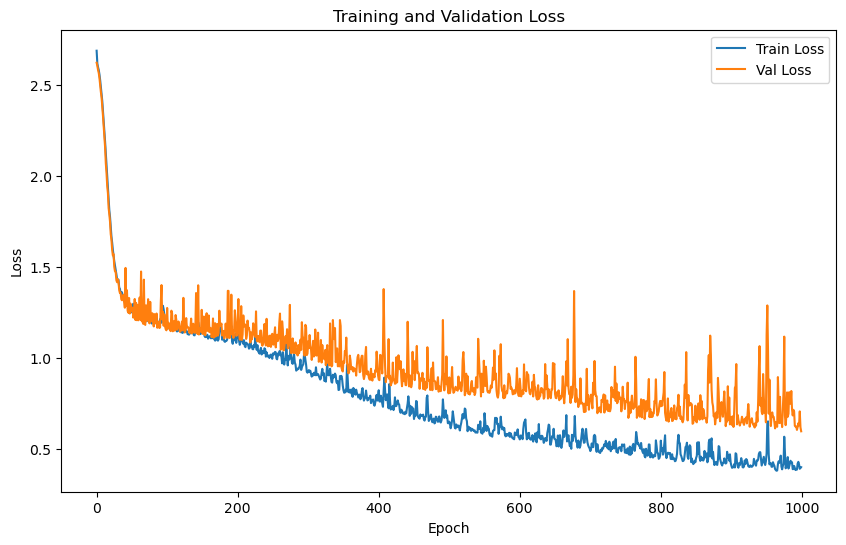

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.6718 | Test Accuracy: 77.04%


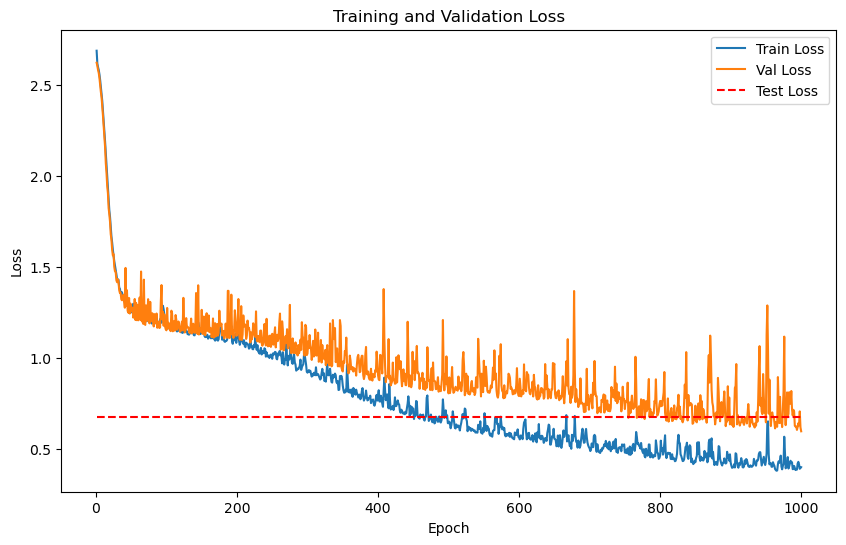

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 560 samples with 64 features each
LOG: Labels shape: (560,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2618 samples with 64 features each
LOG: Labels shape: (2618,)


Train embeddings shape: (560, 64), 
Train labels shape: (560,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (2618, 64), 
Test labels shape: (2618,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}
Training batch size: 280


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 8.4745
    Batch [2/2], Train Loss: 8.3522
Epoch [1/2000], Avg Train Loss: 8.4133
Epoch [1/2000], Avg Val Loss: 3.4843
Validation loss improved from inf to 3.4843. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 8.1099
    Batch [2/2], Train Loss: 8.2444
Epoch [2/2000], Avg Train Loss: 8.1772
Epoch [2/2000], Avg Val Loss: 3.4462
Validation loss improved from 3.4843 to 3.4462. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 8.1143
    Batch [2/2], Train Loss: 7.9725
Epoch [3/2000], Avg Train Loss: 8.0434
Epoch [3/2000], Avg Val Loss: 3.4116
Validation loss improved from 3.4462 to 3.4116. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 8.0499
    Batch [2/2], Train Loss: 7.7521
Epoch [4/2000], Avg Train Loss: 7.9010
Epoch [4/2000], Avg Val Loss: 3.3800
Validation loss improved from 3.4116 to 3.3800. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss

    Batch [1/2], Train Loss: 7.4971
    Batch [2/2], Train Loss: 7.6057
Epoch [7/2000], Avg Train Loss: 7.5514
Epoch [7/2000], Avg Val Loss: 3.3011
Validation loss improved from 3.3251 to 3.3011. Saving model...

LOG: Epoch [8/2000] - Training
    Batch [1/2], Train Loss: 7.3929
    Batch [2/2], Train Loss: 7.3826
Epoch [8/2000], Avg Train Loss: 7.3878
Epoch [8/2000], Avg Val Loss: 3.2795
Validation loss improved from 3.3011 to 3.2795. Saving model...

LOG: Epoch [9/2000] - Training
    Batch [1/2], Train Loss: 7.2370
    Batch [2/2], Train Loss: 7.3393
Epoch [9/2000], Avg Train Loss: 7.2881
Epoch [9/2000], Avg Val Loss: 3.2599
Validation loss improved from 3.2795 to 3.2599. Saving model...

LOG: Epoch [10/2000] - Training
    Batch [1/2], Train Loss: 7.3342
    Batch [2/2], Train Loss: 7.1076
Epoch [10/2000], Avg Train Loss: 7.2209
Epoch [10/2000], Avg Val Loss: 3.2421
Validation loss improved from 3.2599 to 3.2421. Saving model...

LOG: Epoch [11/2000] - Training


    Batch [1/2], Train Loss: 6.8608
    Batch [2/2], Train Loss: 6.8528
Epoch [11/2000], Avg Train Loss: 6.8568
Epoch [11/2000], Avg Val Loss: 3.2260
Validation loss improved from 3.2421 to 3.2260. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/2], Train Loss: 6.9929
    Batch [2/2], Train Loss: 6.8843
Epoch [12/2000], Avg Train Loss: 6.9386
Epoch [12/2000], Avg Val Loss: 3.2117
Validation loss improved from 3.2260 to 3.2117. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/2], Train Loss: 6.7797
    Batch [2/2], Train Loss: 6.6943
Epoch [13/2000], Avg Train Loss: 6.7370
Epoch [13/2000], Avg Val Loss: 3.1988
Validation loss improved from 3.2117 to 3.1988. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/2], Train Loss: 6.6747
    Batch [2/2], Train Loss: 6.5914
Epoch [14/2000], Avg Train Loss: 6.6330
Epoch [14/2000], Avg Val Loss: 3.1875
Validation loss improved from 3.1988 to 3.1875. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 6.1394
Epoch [20/2000], Avg Train Loss: 6.1966
Epoch [20/2000], Avg Val Loss: 3.1404
Validation loss improved from 3.1462 to 3.1404. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/2], Train Loss: 6.0496
    Batch [2/2], Train Loss: 6.0703
Epoch [21/2000], Avg Train Loss: 6.0600
Epoch [21/2000], Avg Val Loss: 3.1354
Validation loss improved from 3.1404 to 3.1354. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/2], Train Loss: 6.0735
    Batch [2/2], Train Loss: 6.0901
Epoch [22/2000], Avg Train Loss: 6.0818
Epoch [22/2000], Avg Val Loss: 3.1311
Validation loss improved from 3.1354 to 3.1311. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/2], Train Loss: 6.0608
    Batch [2/2], Train Loss: 5.9707
Epoch [23/2000], Avg Train Loss: 6.0157
Epoch [23/2000], Avg Val Loss: 3.1272
Validation loss improved from 3.1311 to 3.1272. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/2], Train Loss: 5.9444
    Batch [2

    Batch [2/2], Train Loss: 5.8630
Epoch [25/2000], Avg Train Loss: 5.8546
Epoch [25/2000], Avg Val Loss: 3.1203
Validation loss improved from 3.1236 to 3.1203. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/2], Train Loss: 5.7777
    Batch [2/2], Train Loss: 5.7191
Epoch [26/2000], Avg Train Loss: 5.7484
Epoch [26/2000], Avg Val Loss: 3.1172
Validation loss improved from 3.1203 to 3.1172. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/2], Train Loss: 5.7379
    Batch [2/2], Train Loss: 5.7255
Epoch [27/2000], Avg Train Loss: 5.7317
Epoch [27/2000], Avg Val Loss: 3.1143
Validation loss improved from 3.1172 to 3.1143. Saving model...

LOG: Epoch [28/2000] - Training


    Batch [1/2], Train Loss: 5.7916
    Batch [2/2], Train Loss: 5.6162
Epoch [28/2000], Avg Train Loss: 5.7039
Epoch [28/2000], Avg Val Loss: 3.1116
Validation loss improved from 3.1143 to 3.1116. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/2], Train Loss: 5.7190
    Batch [2/2], Train Loss: 5.6670
Epoch [29/2000], Avg Train Loss: 5.6930
Epoch [29/2000], Avg Val Loss: 3.1092
Validation loss improved from 3.1116 to 3.1092. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/2], Train Loss: 5.6394
    Batch [2/2], Train Loss: 5.6170
Epoch [30/2000], Avg Train Loss: 5.6282
Epoch [30/2000], Avg Val Loss: 3.1070
Validation loss improved from 3.1092 to 3.1070. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1/2], Train Loss: 5.6397
    Batch [2/2], Train Loss: 5.7007
Epoch [31/2000], Avg Train Loss: 5.6702
Epoch [31/2000], Avg Val Loss: 3.1049
Validation loss improved from 3.1070 to 3.1049. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 5.4354
    Batch [2/2], Train Loss: 5.3952
Epoch [39/2000], Avg Train Loss: 5.4153
Epoch [39/2000], Avg Val Loss: 3.0917
Validation loss improved from 3.0933 to 3.0917. Saving model...

LOG: Epoch [40/2000] - Training
    Batch [1/2], Train Loss: 5.3837
    Batch [2/2], Train Loss: 5.3606
Epoch [40/2000], Avg Train Loss: 5.3721
Epoch [40/2000], Avg Val Loss: 3.0902
Validation loss improved from 3.0917 to 3.0902. Saving model...

LOG: Epoch [41/2000] - Training
    Batch [1/2], Train Loss: 5.3617
    Batch [2/2], Train Loss: 5.3661
Epoch [41/2000], Avg Train Loss: 5.3639
Epoch [41/2000], Avg Val Loss: 3.0887
Validation loss improved from 3.0902 to 3.0887. Saving model...

LOG: Epoch [42/2000] - Training
    Batch [1/2], Train Loss: 5.2832
    Batch [2/2], Train Loss: 5.2881
Epoch [42/2000], Avg Train Loss: 5.2856
Epoch [42/2000], Avg Val Loss: 3.0871
Validation loss improved from 3.0887 to 3.0871. Saving model...

LOG: Epoch [43/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 5.2783


    Batch [2/2], Train Loss: 5.3116
Epoch [44/2000], Avg Train Loss: 5.2949
Epoch [44/2000], Avg Val Loss: 3.0838
Validation loss improved from 3.0855 to 3.0838. Saving model...

LOG: Epoch [45/2000] - Training
    Batch [1/2], Train Loss: 5.2262
    Batch [2/2], Train Loss: 5.2725
Epoch [45/2000], Avg Train Loss: 5.2494
Epoch [45/2000], Avg Val Loss: 3.0820
Validation loss improved from 3.0838 to 3.0820. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/2], Train Loss: 5.2644
    Batch [2/2], Train Loss: 5.2473
Epoch [46/2000], Avg Train Loss: 5.2559
Epoch [46/2000], Avg Val Loss: 3.0802
Validation loss improved from 3.0820 to 3.0802. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/2], Train Loss: 5.2250
    Batch [2/2], Train Loss: 5.2992
Epoch [47/2000], Avg Train Loss: 5.2621
Epoch [47/2000], Avg Val Loss: 3.0783
Validation loss improved from 3.0802 to 3.0783. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/2], Train Loss: 5.2258
    Batch [2

    Batch [1/2], Train Loss: 5.0880
    Batch [2/2], Train Loss: 5.1047
Epoch [57/2000], Avg Train Loss: 5.0964
Epoch [57/2000], Avg Val Loss: 3.0586
Validation loss improved from 3.0608 to 3.0586. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/2], Train Loss: 5.0591
    Batch [2/2], Train Loss: 5.0567
Epoch [58/2000], Avg Train Loss: 5.0579
Epoch [58/2000], Avg Val Loss: 3.0563
Validation loss improved from 3.0586 to 3.0563. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/2], Train Loss: 5.1269
    Batch [2/2], Train Loss: 4.9998
Epoch [59/2000], Avg Train Loss: 5.0633
Epoch [59/2000], Avg Val Loss: 3.0540
Validation loss improved from 3.0563 to 3.0540. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/2], Train Loss: 5.0901
    Batch [2/2], Train Loss: 5.0834
Epoch [60/2000], Avg Train Loss: 5.0867
Epoch [60/2000], Avg Val Loss: 3.0516
Validation loss improved from 3.0540 to 3.0516. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 5.0549
    Batch [2/2], Train Loss: 5.0329
Epoch [64/2000], Avg Train Loss: 5.0439
Epoch [64/2000], Avg Val Loss: 3.0414
Validation loss improved from 3.0441 to 3.0414. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/2], Train Loss: 5.0346
    Batch [2/2], Train Loss: 5.0525
Epoch [65/2000], Avg Train Loss: 5.0436
Epoch [65/2000], Avg Val Loss: 3.0387
Validation loss improved from 3.0414 to 3.0387. Saving model...

LOG: Epoch [66/2000] - Training
    Batch [1/2], Train Loss: 5.0382
    Batch [2/2], Train Loss: 4.9673
Epoch [66/2000], Avg Train Loss: 5.0027
Epoch [66/2000], Avg Val Loss: 3.0361
Validation loss improved from 3.0387 to 3.0361. Saving model...

LOG: Epoch [67/2000] - Training
    Batch [1/2], Train Loss: 4.9717
    Batch [2/2], Train Loss: 5.0397
Epoch [67/2000], Avg Train Loss: 5.0057
Epoch [67/2000], Avg Val Loss: 3.0333
Validation loss improved from 3.0361 to 3.0333. Saving model...

LOG: Epoch [68/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 4.9638
    Batch [2/2], Train Loss: 4.8918
Epoch [76/2000], Avg Train Loss: 4.9278
Epoch [76/2000], Avg Val Loss: 3.0087
Validation loss improved from 3.0115 to 3.0087. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/2], Train Loss: 4.9888
    Batch [2/2], Train Loss: 4.9469
Epoch [77/2000], Avg Train Loss: 4.9678
Epoch [77/2000], Avg Val Loss: 3.0060
Validation loss improved from 3.0087 to 3.0060. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/2], Train Loss: 4.9064
    Batch [2/2], Train Loss: 4.9421
Epoch [78/2000], Avg Train Loss: 4.9242
Epoch [78/2000], Avg Val Loss: 3.0031
Validation loss improved from 3.0060 to 3.0031. Saving model...

LOG: Epoch [79/2000] - Training
    Batch [1/2], Train Loss: 4.9443
    Batch [2/2], Train Loss: 4.9040
Epoch [79/2000], Avg Train Loss: 4.9241
Epoch [79/2000], Avg Val Loss: 3.0003
Validation loss improved from 3.0031 to 3.0003. Saving model...

LOG: Epoch [80/2000] - Training
    Batch [1

Epoch [82/2000], Avg Val Loss: 2.9915
Validation loss improved from 2.9945 to 2.9915. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/2], Train Loss: 4.9273
    Batch [2/2], Train Loss: 4.9200
Epoch [83/2000], Avg Train Loss: 4.9237
Epoch [83/2000], Avg Val Loss: 2.9886
Validation loss improved from 2.9915 to 2.9886. Saving model...

LOG: Epoch [84/2000] - Training
    Batch [1/2], Train Loss: 4.8762
    Batch [2/2], Train Loss: 4.9334
Epoch [84/2000], Avg Train Loss: 4.9048
Epoch [84/2000], Avg Val Loss: 2.9856
Validation loss improved from 2.9886 to 2.9856. Saving model...

LOG: Epoch [85/2000] - Training
    Batch [1/2], Train Loss: 4.9346
    Batch [2/2], Train Loss: 4.9264
Epoch [85/2000], Avg Train Loss: 4.9305
Epoch [85/2000], Avg Val Loss: 2.9828
Validation loss improved from 2.9856 to 2.9828. Saving model...

LOG: Epoch [86/2000] - Training
    Batch [1/2], Train Loss: 4.8582
    Batch [2/2], Train Loss: 4.8277
Epoch [86/2000], Avg Train Loss: 4.8429
Epoch [86/20

    Batch [2/2], Train Loss: 4.8494
Epoch [94/2000], Avg Train Loss: 4.8492
Epoch [94/2000], Avg Val Loss: 2.9567
Validation loss improved from 2.9596 to 2.9567. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/2], Train Loss: 4.8232
    Batch [2/2], Train Loss: 4.8438
Epoch [95/2000], Avg Train Loss: 4.8335
Epoch [95/2000], Avg Val Loss: 2.9540
Validation loss improved from 2.9567 to 2.9540. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/2], Train Loss: 4.8482
    Batch [2/2], Train Loss: 4.8060
Epoch [96/2000], Avg Train Loss: 4.8271
Epoch [96/2000], Avg Val Loss: 2.9512
Validation loss improved from 2.9540 to 2.9512. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/2], Train Loss: 4.8537
    Batch [2/2], Train Loss: 4.8478
Epoch [97/2000], Avg Train Loss: 4.8508
Epoch [97/2000], Avg Val Loss: 2.9484
Validation loss improved from 2.9512 to 2.9484. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/2], Train Loss: 4.8110
    Batch [2

    Batch [2/2], Train Loss: 4.7617
Epoch [100/2000], Avg Train Loss: 4.7936
Epoch [100/2000], Avg Val Loss: 2.9401
Validation loss improved from 2.9429 to 2.9401. Saving model...

LOG: Epoch [101/2000] - Training
    Batch [1/2], Train Loss: 4.8147
    Batch [2/2], Train Loss: 4.7988
Epoch [101/2000], Avg Train Loss: 4.8067
Epoch [101/2000], Avg Val Loss: 2.9374
Validation loss improved from 2.9401 to 2.9374. Saving model...

LOG: Epoch [102/2000] - Training
    Batch [1/2], Train Loss: 4.8008
    Batch [2/2], Train Loss: 4.8176
Epoch [102/2000], Avg Train Loss: 4.8092
Epoch [102/2000], Avg Val Loss: 2.9347
Validation loss improved from 2.9374 to 2.9347. Saving model...

LOG: Epoch [103/2000] - Training
    Batch [1/2], Train Loss: 4.8189
    Batch [2/2], Train Loss: 4.7549
Epoch [103/2000], Avg Train Loss: 4.7869
Epoch [103/2000], Avg Val Loss: 2.9320
Validation loss improved from 2.9347 to 2.9320. Saving model...

LOG: Epoch [104/2000] - Training
    Batch [1/2], Train Loss: 4.7616


    Batch [1/2], Train Loss: 4.7315
    Batch [2/2], Train Loss: 4.7166
Epoch [112/2000], Avg Train Loss: 4.7241
Epoch [112/2000], Avg Val Loss: 2.9068
Validation loss improved from 2.9096 to 2.9068. Saving model...

LOG: Epoch [113/2000] - Training
    Batch [1/2], Train Loss: 4.6847
    Batch [2/2], Train Loss: 4.7018
Epoch [113/2000], Avg Train Loss: 4.6932
Epoch [113/2000], Avg Val Loss: 2.9039
Validation loss improved from 2.9068 to 2.9039. Saving model...

LOG: Epoch [114/2000] - Training
    Batch [1/2], Train Loss: 4.7017
    Batch [2/2], Train Loss: 4.7545
Epoch [114/2000], Avg Train Loss: 4.7281
Epoch [114/2000], Avg Val Loss: 2.9010
Validation loss improved from 2.9039 to 2.9010. Saving model...

LOG: Epoch [115/2000] - Training
    Batch [1/2], Train Loss: 4.6933
    Batch [2/2], Train Loss: 4.7193
Epoch [115/2000], Avg Train Loss: 4.7063
Epoch [115/2000], Avg Val Loss: 2.8981
Validation loss improved from 2.9010 to 2.8981. Saving model...

LOG: Epoch [116/2000] - Training


    Batch [1/2], Train Loss: 4.7375
    Batch [2/2], Train Loss: 4.7092
Epoch [118/2000], Avg Train Loss: 4.7234
Epoch [118/2000], Avg Val Loss: 2.8895
Validation loss improved from 2.8923 to 2.8895. Saving model...

LOG: Epoch [119/2000] - Training
    Batch [1/2], Train Loss: 4.6152
    Batch [2/2], Train Loss: 4.6800
Epoch [119/2000], Avg Train Loss: 4.6476
Epoch [119/2000], Avg Val Loss: 2.8866
Validation loss improved from 2.8895 to 2.8866. Saving model...

LOG: Epoch [120/2000] - Training
    Batch [1/2], Train Loss: 4.6921
    Batch [2/2], Train Loss: 4.6981
Epoch [120/2000], Avg Train Loss: 4.6951
Epoch [120/2000], Avg Val Loss: 2.8838
Validation loss improved from 2.8866 to 2.8838. Saving model...

LOG: Epoch [121/2000] - Training
    Batch [1/2], Train Loss: 4.6725
    Batch [2/2], Train Loss: 4.7111
Epoch [121/2000], Avg Train Loss: 4.6918
Epoch [121/2000], Avg Val Loss: 2.8809
Validation loss improved from 2.8838 to 2.8809. Saving model...

LOG: Epoch [122/2000] - Training


    Batch [1/2], Train Loss: 4.6727
    Batch [2/2], Train Loss: 4.6416
Epoch [130/2000], Avg Train Loss: 4.6572
Epoch [130/2000], Avg Val Loss: 2.8561
Validation loss improved from 2.8588 to 2.8561. Saving model...

LOG: Epoch [131/2000] - Training
    Batch [1/2], Train Loss: 4.6492
    Batch [2/2], Train Loss: 4.6797
Epoch [131/2000], Avg Train Loss: 4.6645
Epoch [131/2000], Avg Val Loss: 2.8534
Validation loss improved from 2.8561 to 2.8534. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/2], Train Loss: 4.6725
    Batch [2/2], Train Loss: 4.6522
Epoch [132/2000], Avg Train Loss: 4.6623
Epoch [132/2000], Avg Val Loss: 2.8507
Validation loss improved from 2.8534 to 2.8507. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/2], Train Loss: 4.6425
    Batch [2/2], Train Loss: 4.6526
Epoch [133/2000], Avg Train Loss: 4.6476
Epoch [133/2000], Avg Val Loss: 2.8480
Validation loss improved from 2.8507 to 2.8480. Saving model...

LOG: Epoch [134/2000] - Training


    Batch [2/2], Train Loss: 4.6278
Epoch [136/2000], Avg Train Loss: 4.6200
Epoch [136/2000], Avg Val Loss: 2.8402
Validation loss improved from 2.8428 to 2.8402. Saving model...

LOG: Epoch [137/2000] - Training
    Batch [1/2], Train Loss: 4.6504
    Batch [2/2], Train Loss: 4.5871
Epoch [137/2000], Avg Train Loss: 4.6188
Epoch [137/2000], Avg Val Loss: 2.8376
Validation loss improved from 2.8402 to 2.8376. Saving model...

LOG: Epoch [138/2000] - Training
    Batch [1/2], Train Loss: 4.6215
    Batch [2/2], Train Loss: 4.6729
Epoch [138/2000], Avg Train Loss: 4.6472
Epoch [138/2000], Avg Val Loss: 2.8351
Validation loss improved from 2.8376 to 2.8351. Saving model...

LOG: Epoch [139/2000] - Training
    Batch [1/2], Train Loss: 4.5896
    Batch [2/2], Train Loss: 4.6249
Epoch [139/2000], Avg Train Loss: 4.6073
Epoch [139/2000], Avg Val Loss: 2.8325
Validation loss improved from 2.8351 to 2.8325. Saving model...

LOG: Epoch [140/2000] - Training
    Batch [1/2], Train Loss: 4.6431


    Batch [1/2], Train Loss: 4.5776
    Batch [2/2], Train Loss: 4.5816
Epoch [150/2000], Avg Train Loss: 4.5796
Epoch [150/2000], Avg Val Loss: 2.8059
Validation loss improved from 2.8082 to 2.8059. Saving model...

LOG: Epoch [151/2000] - Training
    Batch [1/2], Train Loss: 4.6279
    Batch [2/2], Train Loss: 4.5296
Epoch [151/2000], Avg Train Loss: 4.5788
Epoch [151/2000], Avg Val Loss: 2.8036
Validation loss improved from 2.8059 to 2.8036. Saving model...

LOG: Epoch [152/2000] - Training
    Batch [1/2], Train Loss: 4.5871
    Batch [2/2], Train Loss: 4.5674
Epoch [152/2000], Avg Train Loss: 4.5772
Epoch [152/2000], Avg Val Loss: 2.8013
Validation loss improved from 2.8036 to 2.8013. Saving model...

LOG: Epoch [153/2000] - Training
    Batch [1/2], Train Loss: 4.5990
    Batch [2/2], Train Loss: 4.6032
Epoch [153/2000], Avg Train Loss: 4.6011
Epoch [153/2000], Avg Val Loss: 2.7990
Validation loss improved from 2.8013 to 2.7990. Saving model...

LOG: Epoch [154/2000] - Training


    Batch [1/2], Train Loss: 4.5649
    Batch [2/2], Train Loss: 4.5926
Epoch [155/2000], Avg Train Loss: 4.5787
Epoch [155/2000], Avg Val Loss: 2.7945
Validation loss improved from 2.7968 to 2.7945. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/2], Train Loss: 4.5625
    Batch [2/2], Train Loss: 4.5284
Epoch [156/2000], Avg Train Loss: 4.5454
Epoch [156/2000], Avg Val Loss: 2.7921
Validation loss improved from 2.7945 to 2.7921. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/2], Train Loss: 4.5190
    Batch [2/2], Train Loss: 4.5575
Epoch [157/2000], Avg Train Loss: 4.5383
Epoch [157/2000], Avg Val Loss: 2.7898
Validation loss improved from 2.7921 to 2.7898. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/2], Train Loss: 4.5456
    Batch [2/2], Train Loss: 4.5813
Epoch [158/2000], Avg Train Loss: 4.5635
Epoch [158/2000], Avg Val Loss: 2.7874
Validation loss improved from 2.7898 to 2.7874. Saving model...

LOG: Epoch [159/2000] - Training


    Batch [1/2], Train Loss: 4.5533
    Batch [2/2], Train Loss: 4.5105
Epoch [168/2000], Avg Train Loss: 4.5319
Epoch [168/2000], Avg Val Loss: 2.7639
Validation loss improved from 2.7661 to 2.7639. Saving model...

LOG: Epoch [169/2000] - Training
    Batch [1/2], Train Loss: 4.5387
    Batch [2/2], Train Loss: 4.4935
Epoch [169/2000], Avg Train Loss: 4.5161
Epoch [169/2000], Avg Val Loss: 2.7617
Validation loss improved from 2.7639 to 2.7617. Saving model...

LOG: Epoch [170/2000] - Training
    Batch [1/2], Train Loss: 4.4995
    Batch [2/2], Train Loss: 4.4941
Epoch [170/2000], Avg Train Loss: 4.4968
Epoch [170/2000], Avg Val Loss: 2.7594
Validation loss improved from 2.7617 to 2.7594. Saving model...

LOG: Epoch [171/2000] - Training
    Batch [1/2], Train Loss: 4.4997
    Batch [2/2], Train Loss: 4.5028
Epoch [171/2000], Avg Train Loss: 4.5013
Epoch [171/2000], Avg Val Loss: 2.7571
Validation loss improved from 2.7594 to 2.7571. Saving model...

LOG: Epoch [172/2000] - Training


    Batch [2/2], Train Loss: 4.5374
Epoch [173/2000], Avg Train Loss: 4.5247
Epoch [173/2000], Avg Val Loss: 2.7525
Validation loss improved from 2.7548 to 2.7525. Saving model...

LOG: Epoch [174/2000] - Training
    Batch [1/2], Train Loss: 4.4903
    Batch [2/2], Train Loss: 4.4946
Epoch [174/2000], Avg Train Loss: 4.4925
Epoch [174/2000], Avg Val Loss: 2.7502
Validation loss improved from 2.7525 to 2.7502. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/2], Train Loss: 4.5041
    Batch [2/2], Train Loss: 4.4996
Epoch [175/2000], Avg Train Loss: 4.5019
Epoch [175/2000], Avg Val Loss: 2.7480
Validation loss improved from 2.7502 to 2.7480. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/2], Train Loss: 4.5457
    Batch [2/2], Train Loss: 4.4836
Epoch [176/2000], Avg Train Loss: 4.5147
Epoch [176/2000], Avg Val Loss: 2.7457
Validation loss improved from 2.7480 to 2.7457. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/2], Train Loss: 4.4499


    Batch [1/2], Train Loss: 4.4978
    Batch [2/2], Train Loss: 4.4256
Epoch [187/2000], Avg Train Loss: 4.4617
Epoch [187/2000], Avg Val Loss: 2.7215
Validation loss improved from 2.7235 to 2.7215. Saving model...

LOG: Epoch [188/2000] - Training
    Batch [1/2], Train Loss: 4.4446
    Batch [2/2], Train Loss: 4.4627
Epoch [188/2000], Avg Train Loss: 4.4536
Epoch [188/2000], Avg Val Loss: 2.7195
Validation loss improved from 2.7215 to 2.7195. Saving model...

LOG: Epoch [189/2000] - Training
    Batch [1/2], Train Loss: 4.4627
    Batch [2/2], Train Loss: 4.5219
Epoch [189/2000], Avg Train Loss: 4.4923
Epoch [189/2000], Avg Val Loss: 2.7175
Validation loss improved from 2.7195 to 2.7175. Saving model...

LOG: Epoch [190/2000] - Training
    Batch [1/2], Train Loss: 4.4350
    Batch [2/2], Train Loss: 4.4423
Epoch [190/2000], Avg Train Loss: 4.4387
Epoch [190/2000], Avg Val Loss: 2.7154
Validation loss improved from 2.7175 to 2.7154. Saving model...

LOG: Epoch [191/2000] - Training


    Batch [2/2], Train Loss: 4.4943
Epoch [191/2000], Avg Train Loss: 4.4824
Epoch [191/2000], Avg Val Loss: 2.7134
Validation loss improved from 2.7154 to 2.7134. Saving model...

LOG: Epoch [192/2000] - Training
    Batch [1/2], Train Loss: 4.4191
    Batch [2/2], Train Loss: 4.4571
Epoch [192/2000], Avg Train Loss: 4.4381
Epoch [192/2000], Avg Val Loss: 2.7114
Validation loss improved from 2.7134 to 2.7114. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/2], Train Loss: 4.3978
    Batch [2/2], Train Loss: 4.4264
Epoch [193/2000], Avg Train Loss: 4.4121
Epoch [193/2000], Avg Val Loss: 2.7094
Validation loss improved from 2.7114 to 2.7094. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/2], Train Loss: 4.4791
    Batch [2/2], Train Loss: 4.4367
Epoch [194/2000], Avg Train Loss: 4.4579
Epoch [194/2000], Avg Val Loss: 2.7074
Validation loss improved from 2.7094 to 2.7074. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/2], Train Loss: 4.4320


    Batch [2/2], Train Loss: 4.3849
Epoch [204/2000], Avg Train Loss: 4.4258
Epoch [204/2000], Avg Val Loss: 2.6879
Validation loss improved from 2.6898 to 2.6879. Saving model...

LOG: Epoch [205/2000] - Training
    Batch [1/2], Train Loss: 4.3968
    Batch [2/2], Train Loss: 4.4216
Epoch [205/2000], Avg Train Loss: 4.4092
Epoch [205/2000], Avg Val Loss: 2.6859
Validation loss improved from 2.6879 to 2.6859. Saving model...

LOG: Epoch [206/2000] - Training
    Batch [1/2], Train Loss: 4.3769
    Batch [2/2], Train Loss: 4.4058
Epoch [206/2000], Avg Train Loss: 4.3914
Epoch [206/2000], Avg Val Loss: 2.6839
Validation loss improved from 2.6859 to 2.6839. Saving model...

LOG: Epoch [207/2000] - Training
    Batch [1/2], Train Loss: 4.3464
    Batch [2/2], Train Loss: 4.4209
Epoch [207/2000], Avg Train Loss: 4.3837
Epoch [207/2000], Avg Val Loss: 2.6820
Validation loss improved from 2.6839 to 2.6820. Saving model...

LOG: Epoch [208/2000] - Training
    Batch [1/2], Train Loss: 4.4051


    Batch [1/2], Train Loss: 4.4085
    Batch [2/2], Train Loss: 4.4083
Epoch [209/2000], Avg Train Loss: 4.4084
Epoch [209/2000], Avg Val Loss: 2.6781
Validation loss improved from 2.6800 to 2.6781. Saving model...

LOG: Epoch [210/2000] - Training
    Batch [1/2], Train Loss: 4.4255
    Batch [2/2], Train Loss: 4.3582
Epoch [210/2000], Avg Train Loss: 4.3918
Epoch [210/2000], Avg Val Loss: 2.6761
Validation loss improved from 2.6781 to 2.6761. Saving model...

LOG: Epoch [211/2000] - Training
    Batch [1/2], Train Loss: 4.3723
    Batch [2/2], Train Loss: 4.3793
Epoch [211/2000], Avg Train Loss: 4.3758
Epoch [211/2000], Avg Val Loss: 2.6742
Validation loss improved from 2.6761 to 2.6742. Saving model...

LOG: Epoch [212/2000] - Training
    Batch [1/2], Train Loss: 4.3626
    Batch [2/2], Train Loss: 4.3826
Epoch [212/2000], Avg Train Loss: 4.3726
Epoch [212/2000], Avg Val Loss: 2.6724
Validation loss improved from 2.6742 to 2.6724. Saving model...

LOG: Epoch [213/2000] - Training


    Batch [1/2], Train Loss: 4.3345
    Batch [2/2], Train Loss: 4.3198
Epoch [224/2000], Avg Train Loss: 4.3271
Epoch [224/2000], Avg Val Loss: 2.6514
Validation loss improved from 2.6531 to 2.6514. Saving model...

LOG: Epoch [225/2000] - Training
    Batch [1/2], Train Loss: 4.3849
    Batch [2/2], Train Loss: 4.3554
Epoch [225/2000], Avg Train Loss: 4.3701
Epoch [225/2000], Avg Val Loss: 2.6496
Validation loss improved from 2.6514 to 2.6496. Saving model...

LOG: Epoch [226/2000] - Training
    Batch [1/2], Train Loss: 4.4136
    Batch [2/2], Train Loss: 4.3537
Epoch [226/2000], Avg Train Loss: 4.3837
Epoch [226/2000], Avg Val Loss: 2.6479
Validation loss improved from 2.6496 to 2.6479. Saving model...

LOG: Epoch [227/2000] - Training
    Batch [1/2], Train Loss: 4.3098
    Batch [2/2], Train Loss: 4.3558
Epoch [227/2000], Avg Train Loss: 4.3328


Epoch [227/2000], Avg Val Loss: 2.6462
Validation loss improved from 2.6479 to 2.6462. Saving model...

LOG: Epoch [228/2000] - Training
    Batch [1/2], Train Loss: 4.3255
    Batch [2/2], Train Loss: 4.3502
Epoch [228/2000], Avg Train Loss: 4.3379
Epoch [228/2000], Avg Val Loss: 2.6444
Validation loss improved from 2.6462 to 2.6444. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/2], Train Loss: 4.3591
    Batch [2/2], Train Loss: 4.3922
Epoch [229/2000], Avg Train Loss: 4.3756
Epoch [229/2000], Avg Val Loss: 2.6427
Validation loss improved from 2.6444 to 2.6427. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/2], Train Loss: 4.3895
    Batch [2/2], Train Loss: 4.3457
Epoch [230/2000], Avg Train Loss: 4.3676
Epoch [230/2000], Avg Val Loss: 2.6411
Validation loss improved from 2.6427 to 2.6411. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/2], Train Loss: 4.3867
    Batch [2/2], Train Loss: 4.3392
Epoch [231/2000], Avg Train Loss: 4.3630


    Batch [2/2], Train Loss: 4.2229
Epoch [242/2000], Avg Train Loss: 4.2785
Epoch [242/2000], Avg Val Loss: 2.6222
Validation loss improved from 2.6237 to 2.6222. Saving model...

LOG: Epoch [243/2000] - Training
    Batch [1/2], Train Loss: 4.3291
    Batch [2/2], Train Loss: 4.2974
Epoch [243/2000], Avg Train Loss: 4.3133
Epoch [243/2000], Avg Val Loss: 2.6207
Validation loss improved from 2.6222 to 2.6207. Saving model...

LOG: Epoch [244/2000] - Training
    Batch [1/2], Train Loss: 4.3319
    Batch [2/2], Train Loss: 4.2962
Epoch [244/2000], Avg Train Loss: 4.3141
Epoch [244/2000], Avg Val Loss: 2.6192
Validation loss improved from 2.6207 to 2.6192. Saving model...

LOG: Epoch [245/2000] - Training
    Batch [1/2], Train Loss: 4.2974
    Batch [2/2], Train Loss: 4.3056
Epoch [245/2000], Avg Train Loss: 4.3015
Epoch [245/2000], Avg Val Loss: 2.6176
Validation loss improved from 2.6192 to 2.6176. Saving model...

LOG: Epoch [246/2000] - Training
    Batch [1/2], Train Loss: 4.2870


    Batch [2/2], Train Loss: 4.3130
Epoch [246/2000], Avg Train Loss: 4.3000
Epoch [246/2000], Avg Val Loss: 2.6160
Validation loss improved from 2.6176 to 2.6160. Saving model...

LOG: Epoch [247/2000] - Training
    Batch [1/2], Train Loss: 4.3173
    Batch [2/2], Train Loss: 4.3234
Epoch [247/2000], Avg Train Loss: 4.3203
Epoch [247/2000], Avg Val Loss: 2.6144
Validation loss improved from 2.6160 to 2.6144. Saving model...

LOG: Epoch [248/2000] - Training
    Batch [1/2], Train Loss: 4.3052
    Batch [2/2], Train Loss: 4.2923
Epoch [248/2000], Avg Train Loss: 4.2988
Epoch [248/2000], Avg Val Loss: 2.6127
Validation loss improved from 2.6144 to 2.6127. Saving model...

LOG: Epoch [249/2000] - Training
    Batch [1/2], Train Loss: 4.3477
    Batch [2/2], Train Loss: 4.3064
Epoch [249/2000], Avg Train Loss: 4.3270
Epoch [249/2000], Avg Val Loss: 2.6112
Validation loss improved from 2.6127 to 2.6112. Saving model...

LOG: Epoch [250/2000] - Training
    Batch [1/2], Train Loss: 4.3061


    Batch [1/2], Train Loss: 4.3147
    Batch [2/2], Train Loss: 4.2788
Epoch [261/2000], Avg Train Loss: 4.2967
Epoch [261/2000], Avg Val Loss: 2.5934
Validation loss improved from 2.5949 to 2.5934. Saving model...

LOG: Epoch [262/2000] - Training
    Batch [1/2], Train Loss: 4.2618
    Batch [2/2], Train Loss: 4.2643
Epoch [262/2000], Avg Train Loss: 4.2631
Epoch [262/2000], Avg Val Loss: 2.5919
Validation loss improved from 2.5934 to 2.5919. Saving model...

LOG: Epoch [263/2000] - Training
    Batch [1/2], Train Loss: 4.2564
    Batch [2/2], Train Loss: 4.2829
Epoch [263/2000], Avg Train Loss: 4.2697
Epoch [263/2000], Avg Val Loss: 2.5904
Validation loss improved from 2.5919 to 2.5904. Saving model...

LOG: Epoch [264/2000] - Training
    Batch [1/2], Train Loss: 4.2920
    Batch [2/2], Train Loss: 4.2782
Epoch [264/2000], Avg Train Loss: 4.2851
Epoch [264/2000], Avg Val Loss: 2.5889
Validation loss improved from 2.5904 to 2.5889. Saving model...

LOG: Epoch [265/2000] - Training


    Batch [1/2], Train Loss: 4.2969
    Batch [2/2], Train Loss: 4.2483
Epoch [265/2000], Avg Train Loss: 4.2726
Epoch [265/2000], Avg Val Loss: 2.5875
Validation loss improved from 2.5889 to 2.5875. Saving model...

LOG: Epoch [266/2000] - Training
    Batch [1/2], Train Loss: 4.2839
    Batch [2/2], Train Loss: 4.2342
Epoch [266/2000], Avg Train Loss: 4.2590
Epoch [266/2000], Avg Val Loss: 2.5860
Validation loss improved from 2.5875 to 2.5860. Saving model...

LOG: Epoch [267/2000] - Training
    Batch [1/2], Train Loss: 4.2183
    Batch [2/2], Train Loss: 4.2349
Epoch [267/2000], Avg Train Loss: 4.2266
Epoch [267/2000], Avg Val Loss: 2.5846
Validation loss improved from 2.5860 to 2.5846. Saving model...

LOG: Epoch [268/2000] - Training
    Batch [1/2], Train Loss: 4.1935
    Batch [2/2], Train Loss: 4.2541
Epoch [268/2000], Avg Train Loss: 4.2238
Epoch [268/2000], Avg Val Loss: 2.5830
Validation loss improved from 2.5846 to 2.5830. Saving model...

LOG: Epoch [269/2000] - Training


    Batch [1/2], Train Loss: 4.2226
    Batch [2/2], Train Loss: 4.2296
Epoch [279/2000], Avg Train Loss: 4.2261
Epoch [279/2000], Avg Val Loss: 2.5668
Validation loss improved from 2.5682 to 2.5668. Saving model...

LOG: Epoch [280/2000] - Training
    Batch [1/2], Train Loss: 4.2400
    Batch [2/2], Train Loss: 4.2186
Epoch [280/2000], Avg Train Loss: 4.2293
Epoch [280/2000], Avg Val Loss: 2.5653
Validation loss improved from 2.5668 to 2.5653. Saving model...

LOG: Epoch [281/2000] - Training
    Batch [1/2], Train Loss: 4.2255
    Batch [2/2], Train Loss: 4.2184
Epoch [281/2000], Avg Train Loss: 4.2219
Epoch [281/2000], Avg Val Loss: 2.5639
Validation loss improved from 2.5653 to 2.5639. Saving model...

LOG: Epoch [282/2000] - Training
    Batch [1/2], Train Loss: 4.1918
    Batch [2/2], Train Loss: 4.3149
Epoch [282/2000], Avg Train Loss: 4.2534
Epoch [282/2000], Avg Val Loss: 2.5625
Validation loss improved from 2.5639 to 2.5625. Saving model...

LOG: Epoch [283/2000] - Training


    Batch [2/2], Train Loss: 4.2293
Epoch [283/2000], Avg Train Loss: 4.2227
Epoch [283/2000], Avg Val Loss: 2.5612
Validation loss improved from 2.5625 to 2.5612. Saving model...

LOG: Epoch [284/2000] - Training
    Batch [1/2], Train Loss: 4.1932
    Batch [2/2], Train Loss: 4.2282
Epoch [284/2000], Avg Train Loss: 4.2107
Epoch [284/2000], Avg Val Loss: 2.5599
Validation loss improved from 2.5612 to 2.5599. Saving model...

LOG: Epoch [285/2000] - Training
    Batch [1/2], Train Loss: 4.2078
    Batch [2/2], Train Loss: 4.2808
Epoch [285/2000], Avg Train Loss: 4.2443
Epoch [285/2000], Avg Val Loss: 2.5586
Validation loss improved from 2.5599 to 2.5586. Saving model...

LOG: Epoch [286/2000] - Training
    Batch [1/2], Train Loss: 4.2280
    Batch [2/2], Train Loss: 4.2073
Epoch [286/2000], Avg Train Loss: 4.2177
Epoch [286/2000], Avg Val Loss: 2.5572
Validation loss improved from 2.5586 to 2.5572. Saving model...

LOG: Epoch [287/2000] - Training
    Batch [1/2], Train Loss: 4.2346


Epoch [298/2000], Avg Val Loss: 2.5405
Validation loss improved from 2.5420 to 2.5405. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/2], Train Loss: 4.2404
    Batch [2/2], Train Loss: 4.1534
Epoch [299/2000], Avg Train Loss: 4.1969
Epoch [299/2000], Avg Val Loss: 2.5390
Validation loss improved from 2.5405 to 2.5390. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/2], Train Loss: 4.2086
    Batch [2/2], Train Loss: 4.1951
Epoch [300/2000], Avg Train Loss: 4.2019
Epoch [300/2000], Avg Val Loss: 2.5375
Validation loss improved from 2.5390 to 2.5375. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/2], Train Loss: 4.1756


    Batch [2/2], Train Loss: 4.1155
Epoch [301/2000], Avg Train Loss: 4.1455
Epoch [301/2000], Avg Val Loss: 2.5360
Validation loss improved from 2.5375 to 2.5360. Saving model...

LOG: Epoch [302/2000] - Training
    Batch [1/2], Train Loss: 4.1572
    Batch [2/2], Train Loss: 4.1451
Epoch [302/2000], Avg Train Loss: 4.1512
Epoch [302/2000], Avg Val Loss: 2.5344
Validation loss improved from 2.5360 to 2.5344. Saving model...

LOG: Epoch [303/2000] - Training
    Batch [1/2], Train Loss: 4.1569
    Batch [2/2], Train Loss: 4.2155
Epoch [303/2000], Avg Train Loss: 4.1862
Epoch [303/2000], Avg Val Loss: 2.5329
Validation loss improved from 2.5344 to 2.5329. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/2], Train Loss: 4.1948
    Batch [2/2], Train Loss: 4.1906
Epoch [304/2000], Avg Train Loss: 4.1927
Epoch [304/2000], Avg Val Loss: 2.5314
Validation loss improved from 2.5329 to 2.5314. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/2], Train Loss: 4.1632


    Batch [2/2], Train Loss: 4.1322
Epoch [316/2000], Avg Train Loss: 4.1577
Epoch [316/2000], Avg Val Loss: 2.5158
Validation loss improved from 2.5171 to 2.5158. Saving model...

LOG: Epoch [317/2000] - Training
    Batch [1/2], Train Loss: 4.1749
    Batch [2/2], Train Loss: 4.1002
Epoch [317/2000], Avg Train Loss: 4.1376
Epoch [317/2000], Avg Val Loss: 2.5145
Validation loss improved from 2.5158 to 2.5145. Saving model...

LOG: Epoch [318/2000] - Training
    Batch [1/2], Train Loss: 4.1650
    Batch [2/2], Train Loss: 4.1825
Epoch [318/2000], Avg Train Loss: 4.1738
Epoch [318/2000], Avg Val Loss: 2.5132
Validation loss improved from 2.5145 to 2.5132. Saving model...

LOG: Epoch [319/2000] - Training
    Batch [1/2], Train Loss: 4.1527
    Batch [2/2], Train Loss: 4.1625
Epoch [319/2000], Avg Train Loss: 4.1576
Epoch [319/2000], Avg Val Loss: 2.5119
Validation loss improved from 2.5132 to 2.5119. Saving model...

LOG: Epoch [320/2000] - Training
    Batch [1/2], Train Loss: 4.1189


    Batch [1/2], Train Loss: 4.1687
    Batch [2/2], Train Loss: 4.1347
Epoch [334/2000], Avg Train Loss: 4.1517
Epoch [334/2000], Avg Val Loss: 2.4928
Validation loss improved from 2.4939 to 2.4928. Saving model...

LOG: Epoch [335/2000] - Training
    Batch [1/2], Train Loss: 4.1102
    Batch [2/2], Train Loss: 4.1400
Epoch [335/2000], Avg Train Loss: 4.1251
Epoch [335/2000], Avg Val Loss: 2.4916
Validation loss improved from 2.4928 to 2.4916. Saving model...

LOG: Epoch [336/2000] - Training
    Batch [1/2], Train Loss: 4.1336
    Batch [2/2], Train Loss: 4.1582
Epoch [336/2000], Avg Train Loss: 4.1459
Epoch [336/2000], Avg Val Loss: 2.4903
Validation loss improved from 2.4916 to 2.4903. Saving model...

LOG: Epoch [337/2000] - Training
    Batch [1/2], Train Loss: 4.1365
    Batch [2/2], Train Loss: 4.1186
Epoch [337/2000], Avg Train Loss: 4.1275
Epoch [337/2000], Avg Val Loss: 2.4890
Validation loss improved from 2.4903 to 2.4890. Saving model...

LOG: Epoch [338/2000] - Training


    Batch [2/2], Train Loss: 4.0854
Epoch [352/2000], Avg Train Loss: 4.0967
Epoch [352/2000], Avg Val Loss: 2.4704
Validation loss improved from 2.4715 to 2.4704. Saving model...

LOG: Epoch [353/2000] - Training
    Batch [1/2], Train Loss: 4.0970
    Batch [2/2], Train Loss: 4.0794
Epoch [353/2000], Avg Train Loss: 4.0882
Epoch [353/2000], Avg Val Loss: 2.4692
Validation loss improved from 2.4704 to 2.4692. Saving model...

LOG: Epoch [354/2000] - Training
    Batch [1/2], Train Loss: 4.1176
    Batch [2/2], Train Loss: 4.0598
Epoch [354/2000], Avg Train Loss: 4.0887
Epoch [354/2000], Avg Val Loss: 2.4680
Validation loss improved from 2.4692 to 2.4680. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/2], Train Loss: 4.0820
    Batch [2/2], Train Loss: 4.0613
Epoch [355/2000], Avg Train Loss: 4.0717
Epoch [355/2000], Avg Val Loss: 2.4669
Validation loss improved from 2.4680 to 2.4669. Saving model...

LOG: Epoch [356/2000] - Training
    Batch [1/2], Train Loss: 4.1074


    Batch [2/2], Train Loss: 4.0830
Epoch [371/2000], Avg Train Loss: 4.0546
Epoch [371/2000], Avg Val Loss: 2.4474
Validation loss improved from 2.4486 to 2.4474. Saving model...

LOG: Epoch [372/2000] - Training
    Batch [1/2], Train Loss: 4.0368
    Batch [2/2], Train Loss: 4.0657
Epoch [372/2000], Avg Train Loss: 4.0512
Epoch [372/2000], Avg Val Loss: 2.4462
Validation loss improved from 2.4474 to 2.4462. Saving model...

LOG: Epoch [373/2000] - Training
    Batch [1/2], Train Loss: 4.0663
    Batch [2/2], Train Loss: 4.0062
Epoch [373/2000], Avg Train Loss: 4.0363
Epoch [373/2000], Avg Val Loss: 2.4450
Validation loss improved from 2.4462 to 2.4450. Saving model...

LOG: Epoch [374/2000] - Training
    Batch [1/2], Train Loss: 4.0567
    Batch [2/2], Train Loss: 4.0362
Epoch [374/2000], Avg Train Loss: 4.0465
Epoch [374/2000], Avg Val Loss: 2.4439
Validation loss improved from 2.4450 to 2.4439. Saving model...

LOG: Epoch [375/2000] - Training
    Batch [1/2], Train Loss: 4.0856


    Batch [1/2], Train Loss: 4.0122
    Batch [2/2], Train Loss: 4.0170
Epoch [390/2000], Avg Train Loss: 4.0146
Epoch [390/2000], Avg Val Loss: 2.4270
Validation loss improved from 2.4280 to 2.4270. Saving model...

LOG: Epoch [391/2000] - Training
    Batch [1/2], Train Loss: 4.0047
    Batch [2/2], Train Loss: 4.0098
Epoch [391/2000], Avg Train Loss: 4.0072
Epoch [391/2000], Avg Val Loss: 2.4259
Validation loss improved from 2.4270 to 2.4259. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/2], Train Loss: 3.9874
    Batch [2/2], Train Loss: 4.0268
Epoch [392/2000], Avg Train Loss: 4.0071
Epoch [392/2000], Avg Val Loss: 2.4249
Validation loss improved from 2.4259 to 2.4249. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/2], Train Loss: 4.0513
    Batch [2/2], Train Loss: 4.0326
Epoch [393/2000], Avg Train Loss: 4.0420
Epoch [393/2000], Avg Val Loss: 2.4238
Validation loss improved from 2.4249 to 2.4238. Saving model...

LOG: Epoch [394/2000] - Training


Epoch [407/2000], Avg Val Loss: 2.4101
Validation loss improved from 2.4112 to 2.4101. Saving model...

LOG: Epoch [408/2000] - Training
    Batch [1/2], Train Loss: 4.0553
    Batch [2/2], Train Loss: 4.0086
Epoch [408/2000], Avg Train Loss: 4.0320
Epoch [408/2000], Avg Val Loss: 2.4091
Validation loss improved from 2.4101 to 2.4091. Saving model...

LOG: Epoch [409/2000] - Training
    Batch [1/2], Train Loss: 4.0178
    Batch [2/2], Train Loss: 4.0001
Epoch [409/2000], Avg Train Loss: 4.0089
Epoch [409/2000], Avg Val Loss: 2.4080
Validation loss improved from 2.4091 to 2.4080. Saving model...

LOG: Epoch [410/2000] - Training
    Batch [1/2], Train Loss: 3.9881
    Batch [2/2], Train Loss: 3.9652
Epoch [410/2000], Avg Train Loss: 3.9767
Epoch [410/2000], Avg Val Loss: 2.4069
Validation loss improved from 2.4080 to 2.4069. Saving model...

LOG: Epoch [411/2000] - Training
    Batch [1/2], Train Loss: 3.9705
    Batch [2/2], Train Loss: 4.0463
Epoch [411/2000], Avg Train Loss: 4.0084


    Batch [1/2], Train Loss: 3.9471
    Batch [2/2], Train Loss: 3.9811
Epoch [426/2000], Avg Train Loss: 3.9641
Epoch [426/2000], Avg Val Loss: 2.3906
Validation loss improved from 2.3916 to 2.3906. Saving model...

LOG: Epoch [427/2000] - Training
    Batch [1/2], Train Loss: 3.9448
    Batch [2/2], Train Loss: 3.9588
Epoch [427/2000], Avg Train Loss: 3.9518
Epoch [427/2000], Avg Val Loss: 2.3897
Validation loss improved from 2.3906 to 2.3897. Saving model...

LOG: Epoch [428/2000] - Training
    Batch [1/2], Train Loss: 3.9471
    Batch [2/2], Train Loss: 3.9558
Epoch [428/2000], Avg Train Loss: 3.9515
Epoch [428/2000], Avg Val Loss: 2.3888
Validation loss improved from 2.3897 to 2.3888. Saving model...

LOG: Epoch [429/2000] - Training
    Batch [1/2], Train Loss: 3.9819
    Batch [2/2], Train Loss: 3.9592
Epoch [429/2000], Avg Train Loss: 3.9705
Epoch [429/2000], Avg Val Loss: 2.3878
Validation loss improved from 2.3888 to 2.3878. Saving model...

LOG: Epoch [430/2000] - Training


    Batch [1/2], Train Loss: 3.9375
    Batch [2/2], Train Loss: 3.9516
Epoch [445/2000], Avg Train Loss: 3.9446
Epoch [445/2000], Avg Val Loss: 2.3726
Validation loss improved from 2.3734 to 2.3726. Saving model...

LOG: Epoch [446/2000] - Training
    Batch [1/2], Train Loss: 3.9483
    Batch [2/2], Train Loss: 3.9243
Epoch [446/2000], Avg Train Loss: 3.9363
Epoch [446/2000], Avg Val Loss: 2.3718
Validation loss improved from 2.3726 to 2.3718. Saving model...

LOG: Epoch [447/2000] - Training
    Batch [1/2], Train Loss: 3.9868
    Batch [2/2], Train Loss: 3.9238
Epoch [447/2000], Avg Train Loss: 3.9553
Epoch [447/2000], Avg Val Loss: 2.3709
Validation loss improved from 2.3718 to 2.3709. Saving model...

LOG: Epoch [448/2000] - Training
    Batch [1/2], Train Loss: 3.9167
    Batch [2/2], Train Loss: 3.9382
Epoch [448/2000], Avg Train Loss: 3.9275
Epoch [448/2000], Avg Val Loss: 2.3700
Validation loss improved from 2.3709 to 2.3700. Saving model...

LOG: Epoch [449/2000] - Training


    Batch [1/2], Train Loss: 3.9783
    Batch [2/2], Train Loss: 3.9315
Epoch [464/2000], Avg Train Loss: 3.9549
Epoch [464/2000], Avg Val Loss: 2.3553
Validation loss improved from 2.3561 to 2.3553. Saving model...

LOG: Epoch [465/2000] - Training
    Batch [1/2], Train Loss: 3.9661
    Batch [2/2], Train Loss: 3.8723
Epoch [465/2000], Avg Train Loss: 3.9192
Epoch [465/2000], Avg Val Loss: 2.3546
Validation loss improved from 2.3553 to 2.3546. Saving model...

LOG: Epoch [466/2000] - Training
    Batch [1/2], Train Loss: 3.8948
    Batch [2/2], Train Loss: 3.9364
Epoch [466/2000], Avg Train Loss: 3.9156
Epoch [466/2000], Avg Val Loss: 2.3539
Validation loss improved from 2.3546 to 2.3539. Saving model...

LOG: Epoch [467/2000] - Training
    Batch [1/2], Train Loss: 3.9276
    Batch [2/2], Train Loss: 3.9168
Epoch [467/2000], Avg Train Loss: 3.9222
Epoch [467/2000], Avg Val Loss: 2.3532
Validation loss improved from 2.3539 to 2.3532. Saving model...

LOG: Epoch [468/2000] - Training


    Batch [2/2], Train Loss: 3.9120
Epoch [482/2000], Avg Train Loss: 3.9005
Epoch [482/2000], Avg Val Loss: 2.3428
Validation loss improved from 2.3436 to 2.3428. Saving model...

LOG: Epoch [483/2000] - Training
    Batch [1/2], Train Loss: 3.9012
    Batch [2/2], Train Loss: 3.8762
Epoch [483/2000], Avg Train Loss: 3.8887
Epoch [483/2000], Avg Val Loss: 2.3419
Validation loss improved from 2.3428 to 2.3419. Saving model...

LOG: Epoch [484/2000] - Training
    Batch [1/2], Train Loss: 3.8517
    Batch [2/2], Train Loss: 3.8868
Epoch [484/2000], Avg Train Loss: 3.8692
Epoch [484/2000], Avg Val Loss: 2.3410
Validation loss improved from 2.3419 to 2.3410. Saving model...

LOG: Epoch [485/2000] - Training
    Batch [1/2], Train Loss: 3.8615
    Batch [2/2], Train Loss: 3.8873
Epoch [485/2000], Avg Train Loss: 3.8744
Epoch [485/2000], Avg Val Loss: 2.3400
Validation loss improved from 2.3410 to 2.3400. Saving model...

LOG: Epoch [486/2000] - Training
    Batch [1/2], Train Loss: 3.8744


Epoch [500/2000], Avg Val Loss: 2.3274
Validation loss improved from 2.3282 to 2.3274. Saving model...

LOG: Epoch [501/2000] - Training
    Batch [1/2], Train Loss: 3.8490
    Batch [2/2], Train Loss: 3.8800
Epoch [501/2000], Avg Train Loss: 3.8645
Epoch [501/2000], Avg Val Loss: 2.3265
Validation loss improved from 2.3274 to 2.3265. Saving model...

LOG: Epoch [502/2000] - Training
    Batch [1/2], Train Loss: 3.8858
    Batch [2/2], Train Loss: 3.8532
Epoch [502/2000], Avg Train Loss: 3.8695
Epoch [502/2000], Avg Val Loss: 2.3257
Validation loss improved from 2.3265 to 2.3257. Saving model...

LOG: Epoch [503/2000] - Training
    Batch [1/2], Train Loss: 3.8133
    Batch [2/2], Train Loss: 3.8510
Epoch [503/2000], Avg Train Loss: 3.8321
Epoch [503/2000], Avg Val Loss: 2.3249
Validation loss improved from 2.3257 to 2.3249. Saving model...

LOG: Epoch [504/2000] - Training
    Batch [1/2], Train Loss: 3.8249
    Batch [2/2], Train Loss: 3.8866
Epoch [504/2000], Avg Train Loss: 3.8557


    Batch [1/2], Train Loss: 3.8464
    Batch [2/2], Train Loss: 3.8069
Epoch [520/2000], Avg Train Loss: 3.8266
Epoch [520/2000], Avg Val Loss: 2.3124
Validation loss improved from 2.3129 to 2.3124. Saving model...

LOG: Epoch [521/2000] - Training
    Batch [1/2], Train Loss: 3.8703
    Batch [2/2], Train Loss: 3.8451
Epoch [521/2000], Avg Train Loss: 3.8577
Epoch [521/2000], Avg Val Loss: 2.3118
Validation loss improved from 2.3124 to 2.3118. Saving model...

LOG: Epoch [522/2000] - Training
    Batch [1/2], Train Loss: 3.8990
    Batch [2/2], Train Loss: 3.8711
Epoch [522/2000], Avg Train Loss: 3.8850
Epoch [522/2000], Avg Val Loss: 2.3113
Validation loss improved from 2.3118 to 2.3113. Saving model...

LOG: Epoch [523/2000] - Training
    Batch [1/2], Train Loss: 3.8119
    Batch [2/2], Train Loss: 3.8311
Epoch [523/2000], Avg Train Loss: 3.8215
Epoch [523/2000], Avg Val Loss: 2.3109
Validation loss improved from 2.3113 to 2.3109. Saving model...

LOG: Epoch [524/2000] - Training


    Batch [2/2], Train Loss: 3.8429
Epoch [538/2000], Avg Train Loss: 3.8348
Epoch [538/2000], Avg Val Loss: 2.3025
Validation loss improved from 2.3031 to 2.3025. Saving model...

LOG: Epoch [539/2000] - Training
    Batch [1/2], Train Loss: 3.7750
    Batch [2/2], Train Loss: 3.8480
Epoch [539/2000], Avg Train Loss: 3.8115
Epoch [539/2000], Avg Val Loss: 2.3019
Validation loss improved from 2.3025 to 2.3019. Saving model...

LOG: Epoch [540/2000] - Training
    Batch [1/2], Train Loss: 3.7597
    Batch [2/2], Train Loss: 3.8239
Epoch [540/2000], Avg Train Loss: 3.7918
Epoch [540/2000], Avg Val Loss: 2.3013
Validation loss improved from 2.3019 to 2.3013. Saving model...

LOG: Epoch [541/2000] - Training
    Batch [1/2], Train Loss: 3.8208
    Batch [2/2], Train Loss: 3.8628
Epoch [541/2000], Avg Train Loss: 3.8418
Epoch [541/2000], Avg Val Loss: 2.3007
Validation loss improved from 2.3013 to 2.3007. Saving model...

LOG: Epoch [542/2000] - Training
    Batch [1/2], Train Loss: 3.8062


Epoch [556/2000], Avg Val Loss: 2.2895
Validation loss improved from 2.2901 to 2.2895. Saving model...

LOG: Epoch [557/2000] - Training
    Batch [1/2], Train Loss: 3.8278
    Batch [2/2], Train Loss: 3.7627
Epoch [557/2000], Avg Train Loss: 3.7952
Epoch [557/2000], Avg Val Loss: 2.2890
Validation loss improved from 2.2895 to 2.2890. Saving model...

LOG: Epoch [558/2000] - Training
    Batch [1/2], Train Loss: 3.8455
    Batch [2/2], Train Loss: 3.7902
Epoch [558/2000], Avg Train Loss: 3.8178
Epoch [558/2000], Avg Val Loss: 2.2883
Validation loss improved from 2.2890 to 2.2883. Saving model...

LOG: Epoch [559/2000] - Training
    Batch [1/2], Train Loss: 3.8017
    Batch [2/2], Train Loss: 3.7776
Epoch [559/2000], Avg Train Loss: 3.7897
Epoch [559/2000], Avg Val Loss: 2.2878
Validation loss improved from 2.2883 to 2.2878. Saving model...

LOG: Epoch [560/2000] - Training
    Batch [1/2], Train Loss: 3.7913
    Batch [2/2], Train Loss: 3.7897
Epoch [560/2000], Avg Train Loss: 3.7905


    Batch [1/2], Train Loss: 3.7635
    Batch [2/2], Train Loss: 3.7775
Epoch [576/2000], Avg Train Loss: 3.7705
Epoch [576/2000], Avg Val Loss: 2.2744
Validation loss improved from 2.2754 to 2.2744. Saving model...

LOG: Epoch [577/2000] - Training
    Batch [1/2], Train Loss: 3.7923
    Batch [2/2], Train Loss: 3.7679
Epoch [577/2000], Avg Train Loss: 3.7801
Epoch [577/2000], Avg Val Loss: 2.2737
Validation loss improved from 2.2744 to 2.2737. Saving model...

LOG: Epoch [578/2000] - Training
    Batch [1/2], Train Loss: 3.7382
    Batch [2/2], Train Loss: 3.7845
Epoch [578/2000], Avg Train Loss: 3.7614
Epoch [578/2000], Avg Val Loss: 2.2731
Validation loss improved from 2.2737 to 2.2731. Saving model...

LOG: Epoch [579/2000] - Training
    Batch [1/2], Train Loss: 3.7841
    Batch [2/2], Train Loss: 3.7772
Epoch [579/2000], Avg Train Loss: 3.7806
Epoch [579/2000], Avg Val Loss: 2.2726
Validation loss improved from 2.2731 to 2.2726. Saving model...

LOG: Epoch [580/2000] - Training


    Batch [2/2], Train Loss: 3.7004
Epoch [589/2000], Avg Train Loss: 3.7185
Epoch [589/2000], Avg Val Loss: 2.2685
Validation loss improved from 2.2690 to 2.2685. Saving model...

LOG: Epoch [590/2000] - Training
    Batch [1/2], Train Loss: 3.7799
    Batch [2/2], Train Loss: 3.7950
Epoch [590/2000], Avg Train Loss: 3.7875
Epoch [590/2000], Avg Val Loss: 2.2680
Validation loss improved from 2.2685 to 2.2680. Saving model...

LOG: Epoch [591/2000] - Training
    Batch [1/2], Train Loss: 3.7497
    Batch [2/2], Train Loss: 3.7654
Epoch [591/2000], Avg Train Loss: 3.7576
Epoch [591/2000], Avg Val Loss: 2.2674
Validation loss improved from 2.2680 to 2.2674. Saving model...

LOG: Epoch [592/2000] - Training
    Batch [1/2], Train Loss: 3.7332
    Batch [2/2], Train Loss: 3.6966
Epoch [592/2000], Avg Train Loss: 3.7149
Epoch [592/2000], Avg Val Loss: 2.2668
Validation loss improved from 2.2674 to 2.2668. Saving model...

LOG: Epoch [593/2000] - Training
    Batch [1/2], Train Loss: 3.7218


    Batch [1/2], Train Loss: 3.7243
    Batch [2/2], Train Loss: 3.7489
Epoch [607/2000], Avg Train Loss: 3.7366
Epoch [607/2000], Avg Val Loss: 2.2578
Validation loss improved from 2.2586 to 2.2578. Saving model...

LOG: Epoch [608/2000] - Training
    Batch [1/2], Train Loss: 3.7517
    Batch [2/2], Train Loss: 3.7572
Epoch [608/2000], Avg Train Loss: 3.7545
Epoch [608/2000], Avg Val Loss: 2.2570
Validation loss improved from 2.2578 to 2.2570. Saving model...

LOG: Epoch [609/2000] - Training
    Batch [1/2], Train Loss: 3.7586
    Batch [2/2], Train Loss: 3.7267
Epoch [609/2000], Avg Train Loss: 3.7427
Epoch [609/2000], Avg Val Loss: 2.2562
Validation loss improved from 2.2570 to 2.2562. Saving model...

LOG: Epoch [610/2000] - Training
    Batch [1/2], Train Loss: 3.7268
    Batch [2/2], Train Loss: 3.7259
Epoch [610/2000], Avg Train Loss: 3.7264
Epoch [610/2000], Avg Val Loss: 2.2554
Validation loss improved from 2.2562 to 2.2554. Saving model...

LOG: Epoch [611/2000] - Training


    Batch [1/2], Train Loss: 3.7140
    Batch [2/2], Train Loss: 3.7396
Epoch [626/2000], Avg Train Loss: 3.7268
Epoch [626/2000], Avg Val Loss: 2.2451
Validation loss improved from 2.2459 to 2.2451. Saving model...

LOG: Epoch [627/2000] - Training
    Batch [1/2], Train Loss: 3.7286
    Batch [2/2], Train Loss: 3.6748
Epoch [627/2000], Avg Train Loss: 3.7017
Epoch [627/2000], Avg Val Loss: 2.2444
Validation loss improved from 2.2451 to 2.2444. Saving model...

LOG: Epoch [628/2000] - Training
    Batch [1/2], Train Loss: 3.7178
    Batch [2/2], Train Loss: 3.6985
Epoch [628/2000], Avg Train Loss: 3.7081
Epoch [628/2000], Avg Val Loss: 2.2436
Validation loss improved from 2.2444 to 2.2436. Saving model...

LOG: Epoch [629/2000] - Training
    Batch [1/2], Train Loss: 3.7087
    Batch [2/2], Train Loss: 3.6833
Epoch [629/2000], Avg Train Loss: 3.6960
Epoch [629/2000], Avg Val Loss: 2.2429
Validation loss improved from 2.2436 to 2.2429. Saving model...

LOG: Epoch [630/2000] - Training


    Batch [1/2], Train Loss: 3.6878
    Batch [2/2], Train Loss: 3.7760
Epoch [645/2000], Avg Train Loss: 3.7319
Epoch [645/2000], Avg Val Loss: 2.2350
Validation loss improved from 2.2357 to 2.2350. Saving model...

LOG: Epoch [646/2000] - Training
    Batch [1/2], Train Loss: 3.7294
    Batch [2/2], Train Loss: 3.6789
Epoch [646/2000], Avg Train Loss: 3.7041
Epoch [646/2000], Avg Val Loss: 2.2344
Validation loss improved from 2.2350 to 2.2344. Saving model...

LOG: Epoch [647/2000] - Training
    Batch [1/2], Train Loss: 3.7307
    Batch [2/2], Train Loss: 3.7231
Epoch [647/2000], Avg Train Loss: 3.7269
Epoch [647/2000], Avg Val Loss: 2.2340
Validation loss improved from 2.2344 to 2.2340. Saving model...

LOG: Epoch [648/2000] - Training
    Batch [1/2], Train Loss: 3.6973
    Batch [2/2], Train Loss: 3.7274
Epoch [648/2000], Avg Train Loss: 3.7123
Epoch [648/2000], Avg Val Loss: 2.2334
Validation loss improved from 2.2340 to 2.2334. Saving model...

LOG: Epoch [649/2000] - Training


    Batch [1/2], Train Loss: 3.6172
    Batch [2/2], Train Loss: 3.6847
Epoch [664/2000], Avg Train Loss: 3.6509
Epoch [664/2000], Avg Val Loss: 2.2256
Validation loss improved from 2.2260 to 2.2256. Saving model...

LOG: Epoch [665/2000] - Training
    Batch [1/2], Train Loss: 3.7064
    Batch [2/2], Train Loss: 3.6692
Epoch [665/2000], Avg Train Loss: 3.6878
Epoch [665/2000], Avg Val Loss: 2.2251
Validation loss improved from 2.2256 to 2.2251. Saving model...

LOG: Epoch [666/2000] - Training
    Batch [1/2], Train Loss: 3.6857
    Batch [2/2], Train Loss: 3.6731
Epoch [666/2000], Avg Train Loss: 3.6794
Epoch [666/2000], Avg Val Loss: 2.2244
Validation loss improved from 2.2251 to 2.2244. Saving model...

LOG: Epoch [667/2000] - Training
    Batch [1/2], Train Loss: 3.6878
    Batch [2/2], Train Loss: 3.6785
Epoch [667/2000], Avg Train Loss: 3.6831
Epoch [667/2000], Avg Val Loss: 2.2235
Validation loss improved from 2.2244 to 2.2235. Saving model...

LOG: Epoch [668/2000] - Training


    Batch [2/2], Train Loss: 3.6959
Epoch [682/2000], Avg Train Loss: 3.6996
Epoch [682/2000], Avg Val Loss: 2.2194
Validation loss improved from 2.2199 to 2.2194. Saving model...

LOG: Epoch [683/2000] - Training
    Batch [1/2], Train Loss: 3.6650
    Batch [2/2], Train Loss: 3.6822
Epoch [683/2000], Avg Train Loss: 3.6736
Epoch [683/2000], Avg Val Loss: 2.2189
Validation loss improved from 2.2194 to 2.2189. Saving model...

LOG: Epoch [684/2000] - Training
    Batch [1/2], Train Loss: 3.6593
    Batch [2/2], Train Loss: 3.6406
Epoch [684/2000], Avg Train Loss: 3.6499
Epoch [684/2000], Avg Val Loss: 2.2183
Validation loss improved from 2.2189 to 2.2183. Saving model...

LOG: Epoch [685/2000] - Training
    Batch [1/2], Train Loss: 3.6873
    Batch [2/2], Train Loss: 3.6497
Epoch [685/2000], Avg Train Loss: 3.6685
Epoch [685/2000], Avg Val Loss: 2.2177
Validation loss improved from 2.2183 to 2.2177. Saving model...

LOG: Epoch [686/2000] - Training
    Batch [1/2], Train Loss: 3.6734


    Batch [2/2], Train Loss: 3.6909
Epoch [700/2000], Avg Train Loss: 3.6616
Epoch [700/2000], Avg Val Loss: 2.2112
Validation loss improved from 2.2115 to 2.2112. Saving model...

LOG: Epoch [701/2000] - Training
    Batch [1/2], Train Loss: 3.6443
    Batch [2/2], Train Loss: 3.6547
Epoch [701/2000], Avg Train Loss: 3.6495
Epoch [701/2000], Avg Val Loss: 2.2108
Validation loss improved from 2.2112 to 2.2108. Saving model...

LOG: Epoch [702/2000] - Training
    Batch [1/2], Train Loss: 3.6411
    Batch [2/2], Train Loss: 3.6410
Epoch [702/2000], Avg Train Loss: 3.6411
Epoch [702/2000], Avg Val Loss: 2.2106
Validation loss improved from 2.2108 to 2.2106. Saving model...

LOG: Epoch [703/2000] - Training
    Batch [1/2], Train Loss: 3.6559
    Batch [2/2], Train Loss: 3.6594
Epoch [703/2000], Avg Train Loss: 3.6576
Epoch [703/2000], Avg Val Loss: 2.2103
Validation loss improved from 2.2106 to 2.2103. Saving model...

LOG: Epoch [704/2000] - Training
    Batch [1/2], Train Loss: 3.6470


    Batch [1/2], Train Loss: 3.6109
    Batch [2/2], Train Loss: 3.6507
Epoch [719/2000], Avg Train Loss: 3.6308
Epoch [719/2000], Avg Val Loss: 2.2101
Validation loss did not improve. Patience: 14/100

LOG: Epoch [720/2000] - Training
    Batch [1/2], Train Loss: 3.6888
    Batch [2/2], Train Loss: 3.6483
Epoch [720/2000], Avg Train Loss: 3.6685
Epoch [720/2000], Avg Val Loss: 2.2099
Validation loss improved from 2.2101 to 2.2099. Saving model...

LOG: Epoch [721/2000] - Training
    Batch [1/2], Train Loss: 3.5772
    Batch [2/2], Train Loss: 3.6659
Epoch [721/2000], Avg Train Loss: 3.6216
Epoch [721/2000], Avg Val Loss: 2.2098
Validation loss improved from 2.2099 to 2.2098. Saving model...

LOG: Epoch [722/2000] - Training
    Batch [1/2], Train Loss: 3.6145
    Batch [2/2], Train Loss: 3.6561
Epoch [722/2000], Avg Train Loss: 3.6353
Epoch [722/2000], Avg Val Loss: 2.2093
Validation loss improved from 2.2098 to 2.2093. Saving model...

LOG: Epoch [723/2000] - Training
    Batch [1/2

Epoch [738/2000], Avg Val Loss: 2.2015
Validation loss improved from 2.2020 to 2.2015. Saving model...

LOG: Epoch [739/2000] - Training
    Batch [1/2], Train Loss: 3.5970
    Batch [2/2], Train Loss: 3.5499
Epoch [739/2000], Avg Train Loss: 3.5735
Epoch [739/2000], Avg Val Loss: 2.2010
Validation loss improved from 2.2015 to 2.2010. Saving model...

LOG: Epoch [740/2000] - Training
    Batch [1/2], Train Loss: 3.6504
    Batch [2/2], Train Loss: 3.6074
Epoch [740/2000], Avg Train Loss: 3.6289
Epoch [740/2000], Avg Val Loss: 2.2006
Validation loss improved from 2.2010 to 2.2006. Saving model...

LOG: Epoch [741/2000] - Training
    Batch [1/2], Train Loss: 3.6028
    Batch [2/2], Train Loss: 3.6330
Epoch [741/2000], Avg Train Loss: 3.6179
Epoch [741/2000], Avg Val Loss: 2.2003
Validation loss improved from 2.2006 to 2.2003. Saving model...

LOG: Epoch [742/2000] - Training
    Batch [1/2], Train Loss: 3.5929
    Batch [2/2], Train Loss: 3.6194
Epoch [742/2000], Avg Train Loss: 3.6061


    Batch [2/2], Train Loss: 3.6340
Epoch [757/2000], Avg Train Loss: 3.6111
Epoch [757/2000], Avg Val Loss: 2.1958
Validation loss improved from 2.1964 to 2.1958. Saving model...

LOG: Epoch [758/2000] - Training
    Batch [1/2], Train Loss: 3.5898
    Batch [2/2], Train Loss: 3.6460
Epoch [758/2000], Avg Train Loss: 3.6179
Epoch [758/2000], Avg Val Loss: 2.1954
Validation loss improved from 2.1958 to 2.1954. Saving model...

LOG: Epoch [759/2000] - Training
    Batch [1/2], Train Loss: 3.6299
    Batch [2/2], Train Loss: 3.6066
Epoch [759/2000], Avg Train Loss: 3.6182
Epoch [759/2000], Avg Val Loss: 2.1950
Validation loss improved from 2.1954 to 2.1950. Saving model...

LOG: Epoch [760/2000] - Training
    Batch [1/2], Train Loss: 3.5879
    Batch [2/2], Train Loss: 3.6028
Epoch [760/2000], Avg Train Loss: 3.5954
Epoch [760/2000], Avg Val Loss: 2.1947
Validation loss improved from 2.1950 to 2.1947. Saving model...

LOG: Epoch [761/2000] - Training
    Batch [1/2], Train Loss: 3.5475


    Batch [1/2], Train Loss: 3.5610
    Batch [2/2], Train Loss: 3.5993
Epoch [776/2000], Avg Train Loss: 3.5802
Epoch [776/2000], Avg Val Loss: 2.1914
Validation loss improved from 2.1918 to 2.1914. Saving model...

LOG: Epoch [777/2000] - Training
    Batch [1/2], Train Loss: 3.6172
    Batch [2/2], Train Loss: 3.5990
Epoch [777/2000], Avg Train Loss: 3.6081
Epoch [777/2000], Avg Val Loss: 2.1909
Validation loss improved from 2.1914 to 2.1909. Saving model...

LOG: Epoch [778/2000] - Training
    Batch [1/2], Train Loss: 3.5372
    Batch [2/2], Train Loss: 3.5890
Epoch [778/2000], Avg Train Loss: 3.5631
Epoch [778/2000], Avg Val Loss: 2.1903
Validation loss improved from 2.1909 to 2.1903. Saving model...

LOG: Epoch [779/2000] - Training
    Batch [1/2], Train Loss: 3.5837
    Batch [2/2], Train Loss: 3.5738
Epoch [779/2000], Avg Train Loss: 3.5787
Epoch [779/2000], Avg Val Loss: 2.1897
Validation loss improved from 2.1903 to 2.1897. Saving model...

LOG: Epoch [780/2000] - Training


    Batch [1/2], Train Loss: 3.5969
    Batch [2/2], Train Loss: 3.5760
Epoch [794/2000], Avg Train Loss: 3.5864
Epoch [794/2000], Avg Val Loss: 2.1851
Validation loss improved from 2.1855 to 2.1851. Saving model...

LOG: Epoch [795/2000] - Training
    Batch [1/2], Train Loss: 3.5535
    Batch [2/2], Train Loss: 3.5613
Epoch [795/2000], Avg Train Loss: 3.5574
Epoch [795/2000], Avg Val Loss: 2.1850
Validation loss improved from 2.1851 to 2.1850. Saving model...

LOG: Epoch [796/2000] - Training
    Batch [1/2], Train Loss: 3.5758
    Batch [2/2], Train Loss: 3.5580
Epoch [796/2000], Avg Train Loss: 3.5669
Epoch [796/2000], Avg Val Loss: 2.1851
Validation loss did not improve. Patience: 1/100

LOG: Epoch [797/2000] - Training
    Batch [1/2], Train Loss: 3.5218
    Batch [2/2], Train Loss: 3.5630
Epoch [797/2000], Avg Train Loss: 3.5424
Epoch [797/2000], Avg Val Loss: 2.1851
Validation loss did not improve. Patience: 2/100

LOG: Epoch [798/2000] - Training
    Batch [1/2], Train Loss: 3

    Batch [2/2], Train Loss: 3.5727
Epoch [812/2000], Avg Train Loss: 3.5613
Epoch [812/2000], Avg Val Loss: 2.1828
Validation loss improved from 2.1832 to 2.1828. Saving model...

LOG: Epoch [813/2000] - Training
    Batch [1/2], Train Loss: 3.5685
    Batch [2/2], Train Loss: 3.5805
Epoch [813/2000], Avg Train Loss: 3.5745
Epoch [813/2000], Avg Val Loss: 2.1823
Validation loss improved from 2.1828 to 2.1823. Saving model...

LOG: Epoch [814/2000] - Training
    Batch [1/2], Train Loss: 3.5524
    Batch [2/2], Train Loss: 3.5878
Epoch [814/2000], Avg Train Loss: 3.5701
Epoch [814/2000], Avg Val Loss: 2.1818
Validation loss improved from 2.1823 to 2.1818. Saving model...

LOG: Epoch [815/2000] - Training
    Batch [1/2], Train Loss: 3.5668
    Batch [2/2], Train Loss: 3.5462
Epoch [815/2000], Avg Train Loss: 3.5565
Epoch [815/2000], Avg Val Loss: 2.1815
Validation loss improved from 2.1818 to 2.1815. Saving model...

LOG: Epoch [816/2000] - Training
    Batch [1/2], Train Loss: 3.5598


    Batch [2/2], Train Loss: 3.5817
Epoch [830/2000], Avg Train Loss: 3.5725
Epoch [830/2000], Avg Val Loss: 2.1755
Validation loss improved from 2.1763 to 2.1755. Saving model...

LOG: Epoch [831/2000] - Training
    Batch [1/2], Train Loss: 3.5159
    Batch [2/2], Train Loss: 3.5685
Epoch [831/2000], Avg Train Loss: 3.5422
Epoch [831/2000], Avg Val Loss: 2.1750
Validation loss improved from 2.1755 to 2.1750. Saving model...

LOG: Epoch [832/2000] - Training
    Batch [1/2], Train Loss: 3.5246
    Batch [2/2], Train Loss: 3.5720
Epoch [832/2000], Avg Train Loss: 3.5483
Epoch [832/2000], Avg Val Loss: 2.1747
Validation loss improved from 2.1750 to 2.1747. Saving model...

LOG: Epoch [833/2000] - Training
    Batch [1/2], Train Loss: 3.5936
    Batch [2/2], Train Loss: 3.5763
Epoch [833/2000], Avg Train Loss: 3.5850
Epoch [833/2000], Avg Val Loss: 2.1745
Validation loss improved from 2.1747 to 2.1745. Saving model...

LOG: Epoch [834/2000] - Training
    Batch [1/2], Train Loss: 3.5739


    Batch [2/2], Train Loss: 3.5225
Epoch [848/2000], Avg Train Loss: 3.5458
Epoch [848/2000], Avg Val Loss: 2.1676
Validation loss did not improve. Patience: 1/100

LOG: Epoch [849/2000] - Training
    Batch [1/2], Train Loss: 3.5762
    Batch [2/2], Train Loss: 3.5151
Epoch [849/2000], Avg Train Loss: 3.5456
Epoch [849/2000], Avg Val Loss: 2.1682
Validation loss did not improve. Patience: 2/100

LOG: Epoch [850/2000] - Training
    Batch [1/2], Train Loss: 3.5046
    Batch [2/2], Train Loss: 3.5175
Epoch [850/2000], Avg Train Loss: 3.5111
Epoch [850/2000], Avg Val Loss: 2.1691
Validation loss did not improve. Patience: 3/100

LOG: Epoch [851/2000] - Training
    Batch [1/2], Train Loss: 3.5244
    Batch [2/2], Train Loss: 3.5543
Epoch [851/2000], Avg Train Loss: 3.5394
Epoch [851/2000], Avg Val Loss: 2.1692
Validation loss did not improve. Patience: 4/100

LOG: Epoch [852/2000] - Training
    Batch [1/2], Train Loss: 3.5295
    Batch [2/2], Train Loss: 3.5361
Epoch [852/2000], Avg Tr

Epoch [866/2000], Avg Val Loss: 2.1680
Validation loss did not improve. Patience: 5/100

LOG: Epoch [867/2000] - Training
    Batch [1/2], Train Loss: 3.5349
    Batch [2/2], Train Loss: 3.5459
Epoch [867/2000], Avg Train Loss: 3.5404
Epoch [867/2000], Avg Val Loss: 2.1681
Validation loss did not improve. Patience: 6/100

LOG: Epoch [868/2000] - Training
    Batch [1/2], Train Loss: 3.5220
    Batch [2/2], Train Loss: 3.5209
Epoch [868/2000], Avg Train Loss: 3.5214
Epoch [868/2000], Avg Val Loss: 2.1680
Validation loss did not improve. Patience: 7/100

LOG: Epoch [869/2000] - Training
    Batch [1/2], Train Loss: 3.5134
    Batch [2/2], Train Loss: 3.5433
Epoch [869/2000], Avg Train Loss: 3.5284
Epoch [869/2000], Avg Val Loss: 2.1677
Validation loss did not improve. Patience: 8/100

LOG: Epoch [870/2000] - Training
    Batch [1/2], Train Loss: 3.5429
    Batch [2/2], Train Loss: 3.5156
Epoch [870/2000], Avg Train Loss: 3.5293
Epoch [870/2000], Avg Val Loss: 2.1672
Validation loss did n

Epoch [884/2000], Avg Val Loss: 2.1652
Validation loss did not improve. Patience: 6/100

LOG: Epoch [885/2000] - Training
    Batch [1/2], Train Loss: 3.5354
    Batch [2/2], Train Loss: 3.5024
Epoch [885/2000], Avg Train Loss: 3.5189
Epoch [885/2000], Avg Val Loss: 2.1652
Validation loss did not improve. Patience: 7/100

LOG: Epoch [886/2000] - Training
    Batch [1/2], Train Loss: 3.5494
    Batch [2/2], Train Loss: 3.5390
Epoch [886/2000], Avg Train Loss: 3.5442
Epoch [886/2000], Avg Val Loss: 2.1655
Validation loss did not improve. Patience: 8/100

LOG: Epoch [887/2000] - Training
    Batch [1/2], Train Loss: 3.5305
    Batch [2/2], Train Loss: 3.4884
Epoch [887/2000], Avg Train Loss: 3.5095
Epoch [887/2000], Avg Val Loss: 2.1657
Validation loss did not improve. Patience: 9/100

LOG: Epoch [888/2000] - Training
    Batch [1/2], Train Loss: 3.5091
    Batch [2/2], Train Loss: 3.5399
Epoch [888/2000], Avg Train Loss: 3.5245
Epoch [888/2000], Avg Val Loss: 2.1662
Validation loss did n

    Batch [2/2], Train Loss: 3.5164
Epoch [903/2000], Avg Train Loss: 3.5159
Epoch [903/2000], Avg Val Loss: 2.1629
Validation loss improved from 2.1634 to 2.1629. Saving model...

LOG: Epoch [904/2000] - Training
    Batch [1/2], Train Loss: 3.5072
    Batch [2/2], Train Loss: 3.5065
Epoch [904/2000], Avg Train Loss: 3.5069
Epoch [904/2000], Avg Val Loss: 2.1621
Validation loss improved from 2.1629 to 2.1621. Saving model...

LOG: Epoch [905/2000] - Training
    Batch [1/2], Train Loss: 3.4864
    Batch [2/2], Train Loss: 3.4888
Epoch [905/2000], Avg Train Loss: 3.4876
Epoch [905/2000], Avg Val Loss: 2.1617
Validation loss improved from 2.1621 to 2.1617. Saving model...

LOG: Epoch [906/2000] - Training
    Batch [1/2], Train Loss: 3.4905
    Batch [2/2], Train Loss: 3.5085
Epoch [906/2000], Avg Train Loss: 3.4995
Epoch [906/2000], Avg Val Loss: 2.1612
Validation loss improved from 2.1617 to 2.1612. Saving model...

LOG: Epoch [907/2000] - Training
    Batch [1/2], Train Loss: 3.5298


    Batch [2/2], Train Loss: 3.4532
Epoch [921/2000], Avg Train Loss: 3.4665
Epoch [921/2000], Avg Val Loss: 2.1564
Validation loss improved from 2.1569 to 2.1564. Saving model...

LOG: Epoch [922/2000] - Training
    Batch [1/2], Train Loss: 3.5004
    Batch [2/2], Train Loss: 3.4908
Epoch [922/2000], Avg Train Loss: 3.4956
Epoch [922/2000], Avg Val Loss: 2.1560
Validation loss improved from 2.1564 to 2.1560. Saving model...

LOG: Epoch [923/2000] - Training
    Batch [1/2], Train Loss: 3.5405
    Batch [2/2], Train Loss: 3.5139
Epoch [923/2000], Avg Train Loss: 3.5272
Epoch [923/2000], Avg Val Loss: 2.1559
Validation loss improved from 2.1560 to 2.1559. Saving model...

LOG: Epoch [924/2000] - Training
    Batch [1/2], Train Loss: 3.5062
    Batch [2/2], Train Loss: 3.5214
Epoch [924/2000], Avg Train Loss: 3.5138
Epoch [924/2000], Avg Val Loss: 2.1555
Validation loss improved from 2.1559 to 2.1555. Saving model...

LOG: Epoch [925/2000] - Training
    Batch [1/2], Train Loss: 3.5034


    Batch [1/2], Train Loss: 3.4864
    Batch [2/2], Train Loss: 3.4793
Epoch [939/2000], Avg Train Loss: 3.4828
Epoch [939/2000], Avg Val Loss: 2.1540
Validation loss did not improve. Patience: 2/100

LOG: Epoch [940/2000] - Training
    Batch [1/2], Train Loss: 3.4683
    Batch [2/2], Train Loss: 3.5146
Epoch [940/2000], Avg Train Loss: 3.4915
Epoch [940/2000], Avg Val Loss: 2.1538
Validation loss did not improve. Patience: 3/100

LOG: Epoch [941/2000] - Training
    Batch [1/2], Train Loss: 3.5260
    Batch [2/2], Train Loss: 3.5208
Epoch [941/2000], Avg Train Loss: 3.5234
Epoch [941/2000], Avg Val Loss: 2.1540
Validation loss did not improve. Patience: 4/100

LOG: Epoch [942/2000] - Training
    Batch [1/2], Train Loss: 3.4789
    Batch [2/2], Train Loss: 3.5002
Epoch [942/2000], Avg Train Loss: 3.4896
Epoch [942/2000], Avg Val Loss: 2.1541
Validation loss did not improve. Patience: 5/100

LOG: Epoch [943/2000] - Training
    Batch [1/2], Train Loss: 3.4606
    Batch [2/2], Train L

    Batch [1/2], Train Loss: 3.4668
    Batch [2/2], Train Loss: 3.4813
Epoch [958/2000], Avg Train Loss: 3.4741
Epoch [958/2000], Avg Val Loss: 2.1491
Validation loss improved from 2.1492 to 2.1491. Saving model...

LOG: Epoch [959/2000] - Training
    Batch [1/2], Train Loss: 3.4926
    Batch [2/2], Train Loss: 3.4368
Epoch [959/2000], Avg Train Loss: 3.4647
Epoch [959/2000], Avg Val Loss: 2.1491
Validation loss did not improve. Patience: 1/100

LOG: Epoch [960/2000] - Training
    Batch [1/2], Train Loss: 3.4984
    Batch [2/2], Train Loss: 3.4612
Epoch [960/2000], Avg Train Loss: 3.4798
Epoch [960/2000], Avg Val Loss: 2.1498
Validation loss did not improve. Patience: 2/100

LOG: Epoch [961/2000] - Training
    Batch [1/2], Train Loss: 3.4771
    Batch [2/2], Train Loss: 3.5229
Epoch [961/2000], Avg Train Loss: 3.5000
Epoch [961/2000], Avg Val Loss: 2.1504
Validation loss did not improve. Patience: 3/100

LOG: Epoch [962/2000] - Training
    Batch [1/2], Train Loss: 3.4577
    Batch

    Batch [2/2], Train Loss: 3.4949
Epoch [976/2000], Avg Train Loss: 3.4607
Epoch [976/2000], Avg Val Loss: 2.1520
Validation loss did not improve. Patience: 18/100

LOG: Epoch [977/2000] - Training
    Batch [1/2], Train Loss: 3.4306
    Batch [2/2], Train Loss: 3.4873
Epoch [977/2000], Avg Train Loss: 3.4590
Epoch [977/2000], Avg Val Loss: 2.1517
Validation loss did not improve. Patience: 19/100

LOG: Epoch [978/2000] - Training
    Batch [1/2], Train Loss: 3.5016
    Batch [2/2], Train Loss: 3.4654
Epoch [978/2000], Avg Train Loss: 3.4835
Epoch [978/2000], Avg Val Loss: 2.1511
Validation loss did not improve. Patience: 20/100

LOG: Epoch [979/2000] - Training
    Batch [1/2], Train Loss: 3.4995
    Batch [2/2], Train Loss: 3.4799
Epoch [979/2000], Avg Train Loss: 3.4897
Epoch [979/2000], Avg Val Loss: 2.1502
Validation loss did not improve. Patience: 21/100

LOG: Epoch [980/2000] - Training
    Batch [1/2], Train Loss: 3.4916
    Batch [2/2], Train Loss: 3.4378
Epoch [980/2000], Av

    Batch [1/2], Train Loss: 3.4710
    Batch [2/2], Train Loss: 3.4452
Epoch [995/2000], Avg Train Loss: 3.4581
Epoch [995/2000], Avg Val Loss: 2.1426
Validation loss improved from 2.1432 to 2.1426. Saving model...

LOG: Epoch [996/2000] - Training
    Batch [1/2], Train Loss: 3.4878
    Batch [2/2], Train Loss: 3.4707
Epoch [996/2000], Avg Train Loss: 3.4792
Epoch [996/2000], Avg Val Loss: 2.1420
Validation loss improved from 2.1426 to 2.1420. Saving model...

LOG: Epoch [997/2000] - Training
    Batch [1/2], Train Loss: 3.4866
    Batch [2/2], Train Loss: 3.4697
Epoch [997/2000], Avg Train Loss: 3.4781
Epoch [997/2000], Avg Val Loss: 2.1416
Validation loss improved from 2.1420 to 2.1416. Saving model...

LOG: Epoch [998/2000] - Training
    Batch [1/2], Train Loss: 3.4834
    Batch [2/2], Train Loss: 3.4671
Epoch [998/2000], Avg Train Loss: 3.4752
Epoch [998/2000], Avg Val Loss: 2.1412
Validation loss improved from 2.1416 to 2.1412. Saving model...

LOG: Epoch [999/2000] - Training


    Batch [1/2], Train Loss: 3.4560
    Batch [2/2], Train Loss: 3.4839
Epoch [1013/2000], Avg Train Loss: 3.4700
Epoch [1013/2000], Avg Val Loss: 2.1395
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1014/2000] - Training
    Batch [1/2], Train Loss: 3.4345
    Batch [2/2], Train Loss: 3.4364
Epoch [1014/2000], Avg Train Loss: 3.4355
Epoch [1014/2000], Avg Val Loss: 2.1398
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1015/2000] - Training
    Batch [1/2], Train Loss: 3.4574
    Batch [2/2], Train Loss: 3.4839
Epoch [1015/2000], Avg Train Loss: 3.4707
Epoch [1015/2000], Avg Val Loss: 2.1398
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1016/2000] - Training
    Batch [1/2], Train Loss: 3.4905
    Batch [2/2], Train Loss: 3.4314
Epoch [1016/2000], Avg Train Loss: 3.4610
Epoch [1016/2000], Avg Val Loss: 2.1400
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1017/2000] - Training
    Batch [1/2], Train Loss: 3.4244
    Batch [2

    Batch [2/2], Train Loss: 3.4588
Epoch [1031/2000], Avg Train Loss: 3.4561
Epoch [1031/2000], Avg Val Loss: 2.1398
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1032/2000] - Training
    Batch [1/2], Train Loss: 3.4660
    Batch [2/2], Train Loss: 3.4662
Epoch [1032/2000], Avg Train Loss: 3.4661
Epoch [1032/2000], Avg Val Loss: 2.1398
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1033/2000] - Training
    Batch [1/2], Train Loss: 3.4452
    Batch [2/2], Train Loss: 3.4411
Epoch [1033/2000], Avg Train Loss: 3.4431
Epoch [1033/2000], Avg Val Loss: 2.1398
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1034/2000] - Training
    Batch [1/2], Train Loss: 3.4683
    Batch [2/2], Train Loss: 3.3952
Epoch [1034/2000], Avg Train Loss: 3.4317
Epoch [1034/2000], Avg Val Loss: 2.1398
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1035/2000] - Training
    Batch [1/2], Train Loss: 3.4166
    Batch [2/2], Train Loss: 3.4809
Epoch [1035

    Batch [1/2], Train Loss: 3.4340
    Batch [2/2], Train Loss: 3.4104
Epoch [1051/2000], Avg Train Loss: 3.4222
Epoch [1051/2000], Avg Val Loss: 2.1353
Validation loss improved from 2.1356 to 2.1353. Saving model...

LOG: Epoch [1052/2000] - Training
    Batch [1/2], Train Loss: 3.4766
    Batch [2/2], Train Loss: 3.4471
Epoch [1052/2000], Avg Train Loss: 3.4619
Epoch [1052/2000], Avg Val Loss: 2.1352
Validation loss improved from 2.1353 to 2.1352. Saving model...

LOG: Epoch [1053/2000] - Training
    Batch [1/2], Train Loss: 3.4491
    Batch [2/2], Train Loss: 3.4731
Epoch [1053/2000], Avg Train Loss: 3.4611
Epoch [1053/2000], Avg Val Loss: 2.1348
Validation loss improved from 2.1352 to 2.1348. Saving model...

LOG: Epoch [1054/2000] - Training
    Batch [1/2], Train Loss: 3.4268
    Batch [2/2], Train Loss: 3.4063
Epoch [1054/2000], Avg Train Loss: 3.4166
Epoch [1054/2000], Avg Val Loss: 2.1346
Validation loss improved from 2.1348 to 2.1346. Saving model...

LOG: Epoch [1055/2000]

    Batch [1/2], Train Loss: 3.4748
    Batch [2/2], Train Loss: 3.4011
Epoch [1069/2000], Avg Train Loss: 3.4379
Epoch [1069/2000], Avg Val Loss: 2.1327
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1070/2000] - Training
    Batch [1/2], Train Loss: 3.4634
    Batch [2/2], Train Loss: 3.4153
Epoch [1070/2000], Avg Train Loss: 3.4393
Epoch [1070/2000], Avg Val Loss: 2.1333
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1071/2000] - Training
    Batch [1/2], Train Loss: 3.4566
    Batch [2/2], Train Loss: 3.4632
Epoch [1071/2000], Avg Train Loss: 3.4599
Epoch [1071/2000], Avg Val Loss: 2.1336
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1072/2000] - Training
    Batch [1/2], Train Loss: 3.4153
    Batch [2/2], Train Loss: 3.4106
Epoch [1072/2000], Avg Train Loss: 3.4129
Epoch [1072/2000], Avg Val Loss: 2.1337
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1073/2000] - Training
    Batch [1/2], Train Loss: 3.4077
    Batch [2

Epoch [1087/2000], Avg Val Loss: 2.1358
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1088/2000] - Training
    Batch [1/2], Train Loss: 3.4100
    Batch [2/2], Train Loss: 3.4101
Epoch [1088/2000], Avg Train Loss: 3.4101
Epoch [1088/2000], Avg Val Loss: 2.1358
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1089/2000] - Training
    Batch [1/2], Train Loss: 3.4278
    Batch [2/2], Train Loss: 3.4078
Epoch [1089/2000], Avg Train Loss: 3.4178
Epoch [1089/2000], Avg Val Loss: 2.1360
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1090/2000] - Training
    Batch [1/2], Train Loss: 3.4125
    Batch [2/2], Train Loss: 3.4027
Epoch [1090/2000], Avg Train Loss: 3.4076
Epoch [1090/2000], Avg Val Loss: 2.1365
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1091/2000] - Training
    Batch [1/2], Train Loss: 3.4246
    Batch [2/2], Train Loss: 3.4484
Epoch [1091/2000], Avg Train Loss: 3.4365
Epoch [1091/2000], Avg Val Loss: 2.1370
Vali

    Batch [2/2], Train Loss: 3.4026
Epoch [1106/2000], Avg Train Loss: 3.3911
Epoch [1106/2000], Avg Val Loss: 2.1379
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1107/2000] - Training
    Batch [1/2], Train Loss: 3.4170
    Batch [2/2], Train Loss: 3.4189
Epoch [1107/2000], Avg Train Loss: 3.4179
Epoch [1107/2000], Avg Val Loss: 2.1384
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1108/2000] - Training
    Batch [1/2], Train Loss: 3.3915
    Batch [2/2], Train Loss: 3.4463
Epoch [1108/2000], Avg Train Loss: 3.4189
Epoch [1108/2000], Avg Val Loss: 2.1389
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1109/2000] - Training
    Batch [1/2], Train Loss: 3.4272
    Batch [2/2], Train Loss: 3.3923
Epoch [1109/2000], Avg Train Loss: 3.4098
Epoch [1109/2000], Avg Val Loss: 2.1390
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1110/2000] - Training
    Batch [1/2], Train Loss: 3.4010
    Batch [2/2], Train Loss: 3.4045
Epoch [1

    Batch [1/2], Train Loss: 3.4081
    Batch [2/2], Train Loss: 3.3816
Epoch [1125/2000], Avg Train Loss: 3.3948
Epoch [1125/2000], Avg Val Loss: 2.1330
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1126/2000] - Training
    Batch [1/2], Train Loss: 3.4000
    Batch [2/2], Train Loss: 3.4297
Epoch [1126/2000], Avg Train Loss: 3.4148
Epoch [1126/2000], Avg Val Loss: 2.1339
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1127/2000] - Training
    Batch [1/2], Train Loss: 3.4164
    Batch [2/2], Train Loss: 3.4352
Epoch [1127/2000], Avg Train Loss: 3.4258
Epoch [1127/2000], Avg Val Loss: 2.1343
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1128/2000] - Training
    Batch [1/2], Train Loss: 3.4404
    Batch [2/2], Train Loss: 3.4134
Epoch [1128/2000], Avg Train Loss: 3.4269
Epoch [1128/2000], Avg Val Loss: 2.1343
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1129/2000] - Training
    Batch [1/2], Train Loss: 3.4149
    Batch [2

    Batch [2/2], Train Loss: 3.3577
Epoch [1143/2000], Avg Train Loss: 3.3731
Epoch [1143/2000], Avg Val Loss: 2.1288
Validation loss improved from 2.1294 to 2.1288. Saving model...

LOG: Epoch [1144/2000] - Training
    Batch [1/2], Train Loss: 3.4032
    Batch [2/2], Train Loss: 3.4210
Epoch [1144/2000], Avg Train Loss: 3.4121
Epoch [1144/2000], Avg Val Loss: 2.1286
Validation loss improved from 2.1288 to 2.1286. Saving model...

LOG: Epoch [1145/2000] - Training
    Batch [1/2], Train Loss: 3.3831
    Batch [2/2], Train Loss: 3.4277
Epoch [1145/2000], Avg Train Loss: 3.4054
Epoch [1145/2000], Avg Val Loss: 2.1287
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1146/2000] - Training
    Batch [1/2], Train Loss: 3.4114
    Batch [2/2], Train Loss: 3.4026
Epoch [1146/2000], Avg Train Loss: 3.4070
Epoch [1146/2000], Avg Val Loss: 2.1288
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1147/2000] - Training
    Batch [1/2], Train Loss: 3.3818
    Batch [2/2], T

    Batch [1/2], Train Loss: 3.3821
    Batch [2/2], Train Loss: 3.3911
Epoch [1162/2000], Avg Train Loss: 3.3866
Epoch [1162/2000], Avg Val Loss: 2.1324
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1163/2000] - Training
    Batch [1/2], Train Loss: 3.3824
    Batch [2/2], Train Loss: 3.3790
Epoch [1163/2000], Avg Train Loss: 3.3807
Epoch [1163/2000], Avg Val Loss: 2.1324
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1164/2000] - Training
    Batch [1/2], Train Loss: 3.3884
    Batch [2/2], Train Loss: 3.4658
Epoch [1164/2000], Avg Train Loss: 3.4271
Epoch [1164/2000], Avg Val Loss: 2.1322
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1165/2000] - Training
    Batch [1/2], Train Loss: 3.3508
    Batch [2/2], Train Loss: 3.3638
Epoch [1165/2000], Avg Train Loss: 3.3573
Epoch [1165/2000], Avg Val Loss: 2.1327
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1166/2000] - Training
    Batch [1/2], Train Loss: 3.3743
    Batc

    Batch [1/2], Train Loss: 3.4014
    Batch [2/2], Train Loss: 3.3937
Epoch [1175/2000], Avg Train Loss: 3.3976
Epoch [1175/2000], Avg Val Loss: 2.1290
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1176/2000] - Training
    Batch [1/2], Train Loss: 3.3905
    Batch [2/2], Train Loss: 3.3787
Epoch [1176/2000], Avg Train Loss: 3.3846
Epoch [1176/2000], Avg Val Loss: 2.1292
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1177/2000] - Training
    Batch [1/2], Train Loss: 3.3657
    Batch [2/2], Train Loss: 3.4240
Epoch [1177/2000], Avg Train Loss: 3.3948
Epoch [1177/2000], Avg Val Loss: 2.1293
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1178/2000] - Training
    Batch [1/2], Train Loss: 3.4249
    Batch [2/2], Train Loss: 3.3970
Epoch [1178/2000], Avg Train Loss: 3.4110
Epoch [1178/2000], Avg Val Loss: 2.1291
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1179/2000] - Training
    Batch [1/2], Train Loss: 3.4079
    Batch [2

Epoch [1193/2000], Avg Val Loss: 2.1313
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1194/2000] - Training
    Batch [1/2], Train Loss: 3.3929
    Batch [2/2], Train Loss: 3.3924
Epoch [1194/2000], Avg Train Loss: 3.3927
Epoch [1194/2000], Avg Val Loss: 2.1318
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1195/2000] - Training
    Batch [1/2], Train Loss: 3.3652
    Batch [2/2], Train Loss: 3.3363
Epoch [1195/2000], Avg Train Loss: 3.3507
Epoch [1195/2000], Avg Val Loss: 2.1322
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1196/2000] - Training
    Batch [1/2], Train Loss: 3.3724
    Batch [2/2], Train Loss: 3.3518
Epoch [1196/2000], Avg Train Loss: 3.3621
Epoch [1196/2000], Avg Val Loss: 2.1323
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1197/2000] - Training
    Batch [1/2], Train Loss: 3.3569
    Batch [2/2], Train Loss: 3.3545
Epoch [1197/2000], Avg Train Loss: 3.3557
Epoch [1197/2000], Avg Val Loss: 2.1325
Vali

    Batch [1/2], Train Loss: 3.3710
    Batch [2/2], Train Loss: 3.3747
Epoch [1212/2000], Avg Train Loss: 3.3729
Epoch [1212/2000], Avg Val Loss: 2.1304
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1213/2000] - Training
    Batch [1/2], Train Loss: 3.3756
    Batch [2/2], Train Loss: 3.3804
Epoch [1213/2000], Avg Train Loss: 3.3780
Epoch [1213/2000], Avg Val Loss: 2.1307
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1214/2000] - Training
    Batch [1/2], Train Loss: 3.3728
    Batch [2/2], Train Loss: 3.3698
Epoch [1214/2000], Avg Train Loss: 3.3713
Epoch [1214/2000], Avg Val Loss: 2.1305
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1215/2000] - Training
    Batch [1/2], Train Loss: 3.3631
    Batch [2/2], Train Loss: 3.3786
Epoch [1215/2000], Avg Train Loss: 3.3708
Epoch [1215/2000], Avg Val Loss: 2.1302
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1216/2000] - Training
    Batch [1/2], Train Loss: 3.3710
    Batc

    Batch [2/2], Train Loss: 3.3095
Epoch [1230/2000], Avg Train Loss: 3.3335
Epoch [1230/2000], Avg Val Loss: 2.1291
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1231/2000] - Training
    Batch [1/2], Train Loss: 3.3368
    Batch [2/2], Train Loss: 3.3882
Epoch [1231/2000], Avg Train Loss: 3.3625
Epoch [1231/2000], Avg Val Loss: 2.1293
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1232/2000] - Training
    Batch [1/2], Train Loss: 3.3533
    Batch [2/2], Train Loss: 3.3727
Epoch [1232/2000], Avg Train Loss: 3.3630
Epoch [1232/2000], Avg Val Loss: 2.1292
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1233/2000] - Training
    Batch [1/2], Train Loss: 3.3657
    Batch [2/2], Train Loss: 3.3603
Epoch [1233/2000], Avg Train Loss: 3.3630
Epoch [1233/2000], Avg Val Loss: 2.1290
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1234/2000] - Training
    Batch [1/2], Train Loss: 3.3894
    Batch [2/2], Train Loss: 3.3624
Epoch [1234/

    Batch [2/2], Train Loss: 3.3717
Epoch [1249/2000], Avg Train Loss: 3.3810
Epoch [1249/2000], Avg Val Loss: 2.1258
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1250/2000] - Training
    Batch [1/2], Train Loss: 3.3629
    Batch [2/2], Train Loss: 3.3262
Epoch [1250/2000], Avg Train Loss: 3.3445
Epoch [1250/2000], Avg Val Loss: 2.1265
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1251/2000] - Training
    Batch [1/2], Train Loss: 3.3841
    Batch [2/2], Train Loss: 3.3761
Epoch [1251/2000], Avg Train Loss: 3.3801
Epoch [1251/2000], Avg Val Loss: 2.1271
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1252/2000] - Training
    Batch [1/2], Train Loss: 3.3578
    Batch [2/2], Train Loss: 3.3888
Epoch [1252/2000], Avg Train Loss: 3.3733
Epoch [1252/2000], Avg Val Loss: 2.1278
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1253/2000] - Training
    Batch [1/2], Train Loss: 3.3458
    Batch [2/2], Train Loss: 3.3407
Epoch [1253/

    Batch [1/2], Train Loss: 3.3669
    Batch [2/2], Train Loss: 3.3385
Epoch [1268/2000], Avg Train Loss: 3.3527
Epoch [1268/2000], Avg Val Loss: 2.1329
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1269/2000] - Training
    Batch [1/2], Train Loss: 3.3493
    Batch [2/2], Train Loss: 3.3993
Epoch [1269/2000], Avg Train Loss: 3.3743
Epoch [1269/2000], Avg Val Loss: 2.1325
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1270/2000] - Training
    Batch [1/2], Train Loss: 3.3574
    Batch [2/2], Train Loss: 3.3315
Epoch [1270/2000], Avg Train Loss: 3.3445
Epoch [1270/2000], Avg Val Loss: 2.1317
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1271/2000] - Training
    Batch [1/2], Train Loss: 3.3537
    Batch [2/2], Train Loss: 3.3555
Epoch [1271/2000], Avg Train Loss: 3.3546
Epoch [1271/2000], Avg Val Loss: 2.1313
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1272/2000] - Training
    Batch [1/2], Train Loss: 3.3625
    Batc

    Batch [2/2], Train Loss: 3.3399
Epoch [1286/2000], Avg Train Loss: 3.3426
Epoch [1286/2000], Avg Val Loss: 2.1320
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1287/2000] - Training
    Batch [1/2], Train Loss: 3.3247
    Batch [2/2], Train Loss: 3.3701
Epoch [1287/2000], Avg Train Loss: 3.3474
Epoch [1287/2000], Avg Val Loss: 2.1309
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1288/2000] - Training
    Batch [1/2], Train Loss: 3.3209
    Batch [2/2], Train Loss: 3.3285
Epoch [1288/2000], Avg Train Loss: 3.3247
Epoch [1288/2000], Avg Val Loss: 2.1299
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1289/2000] - Training
    Batch [1/2], Train Loss: 3.3689
    Batch [2/2], Train Loss: 3.3077
Epoch [1289/2000], Avg Train Loss: 3.3383
Epoch [1289/2000], Avg Val Loss: 2.1289
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1290/2000] - Training
    Batch [1/2], Train Loss: 3.3297
    Batch [2/2], Train Loss: 3.3701
Epoch [1

    Batch [2/2], Train Loss: 3.3539
Epoch [1304/2000], Avg Train Loss: 3.3306
Epoch [1304/2000], Avg Val Loss: 2.1226
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1305/2000] - Training
    Batch [1/2], Train Loss: 3.3779
    Batch [2/2], Train Loss: 3.3478
Epoch [1305/2000], Avg Train Loss: 3.3628
Epoch [1305/2000], Avg Val Loss: 2.1232
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1306/2000] - Training
    Batch [1/2], Train Loss: 3.3312
    Batch [2/2], Train Loss: 3.3437
Epoch [1306/2000], Avg Train Loss: 3.3375
Epoch [1306/2000], Avg Val Loss: 2.1238
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1307/2000] - Training
    Batch [1/2], Train Loss: 3.3442
    Batch [2/2], Train Loss: 3.3347
Epoch [1307/2000], Avg Train Loss: 3.3394
Epoch [1307/2000], Avg Val Loss: 2.1247
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1308/2000] - Training
    Batch [1/2], Train Loss: 3.3716
    Batch [2/2], Train Loss: 3.3705
Epoch [1308/

    Batch [2/2], Train Loss: 3.3298
Epoch [1323/2000], Avg Train Loss: 3.3583
Epoch [1323/2000], Avg Val Loss: 2.1273
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1324/2000] - Training
    Batch [1/2], Train Loss: 3.3257
    Batch [2/2], Train Loss: 3.3281
Epoch [1324/2000], Avg Train Loss: 3.3269
Epoch [1324/2000], Avg Val Loss: 2.1267
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1325/2000] - Training
    Batch [1/2], Train Loss: 3.3581
    Batch [2/2], Train Loss: 3.3456
Epoch [1325/2000], Avg Train Loss: 3.3519
Epoch [1325/2000], Avg Val Loss: 2.1258
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1326/2000] - Training
    Batch [1/2], Train Loss: 3.3258
    Batch [2/2], Train Loss: 3.3445
Epoch [1326/2000], Avg Train Loss: 3.3352
Epoch [1326/2000], Avg Val Loss: 2.1249
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1327/2000] - Training
    Batch [1/2], Train Loss: 3.3943
    Batch [2/2], Train Loss: 3.3393
Epoch [1

Epoch [1341/2000], Avg Val Loss: 2.1261
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1342/2000] - Training
    Batch [1/2], Train Loss: 3.3277
    Batch [2/2], Train Loss: 3.3353
Epoch [1342/2000], Avg Train Loss: 3.3315
Epoch [1342/2000], Avg Val Loss: 2.1257
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1343/2000] - Training
    Batch [1/2], Train Loss: 3.3428
    Batch [2/2], Train Loss: 3.3514
Epoch [1343/2000], Avg Train Loss: 3.3471
Epoch [1343/2000], Avg Val Loss: 2.1254
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1344/2000] - Training
    Batch [1/2], Train Loss: 3.3005
    Batch [2/2], Train Loss: 3.3247
Epoch [1344/2000], Avg Train Loss: 3.3126
Epoch [1344/2000], Avg Val Loss: 2.1251
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1345/2000] - Training
    Batch [1/2], Train Loss: 3.3539
    Batch [2/2], Train Loss: 3.3700
Epoch [1345/2000], Avg Train Loss: 3.3619
Epoch [1345/2000], Avg Val Loss: 2.1248
Vali

    Batch [1/2], Train Loss: 3.3087
    Batch [2/2], Train Loss: 3.3480
Epoch [1359/2000], Avg Train Loss: 3.3284
Epoch [1359/2000], Avg Val Loss: 2.1271
Validation loss did not improve. Patience: 56/100

LOG: Epoch [1360/2000] - Training
    Batch [1/2], Train Loss: 3.3284
    Batch [2/2], Train Loss: 3.3428
Epoch [1360/2000], Avg Train Loss: 3.3356
Epoch [1360/2000], Avg Val Loss: 2.1260
Validation loss did not improve. Patience: 57/100

LOG: Epoch [1361/2000] - Training
    Batch [1/2], Train Loss: 3.3549
    Batch [2/2], Train Loss: 3.3384
Epoch [1361/2000], Avg Train Loss: 3.3467
Epoch [1361/2000], Avg Val Loss: 2.1247
Validation loss did not improve. Patience: 58/100

LOG: Epoch [1362/2000] - Training
    Batch [1/2], Train Loss: 3.3209
    Batch [2/2], Train Loss: 3.3091
Epoch [1362/2000], Avg Train Loss: 3.3150
Epoch [1362/2000], Avg Val Loss: 2.1236
Validation loss did not improve. Patience: 59/100

LOG: Epoch [1363/2000] - Training
    Batch [1/2], Train Loss: 3.2968
    Batc

Epoch [1376/2000], Avg Val Loss: 2.1282
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1377/2000] - Training
    Batch [1/2], Train Loss: 3.3183
    Batch [2/2], Train Loss: 3.3461
Epoch [1377/2000], Avg Train Loss: 3.3322
Epoch [1377/2000], Avg Val Loss: 2.1284
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1378/2000] - Training
    Batch [1/2], Train Loss: 3.3569
    Batch [2/2], Train Loss: 3.3471
Epoch [1378/2000], Avg Train Loss: 3.3520
Epoch [1378/2000], Avg Val Loss: 2.1281
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1379/2000] - Training
    Batch [1/2], Train Loss: 3.3405
    Batch [2/2], Train Loss: 3.2968
Epoch [1379/2000], Avg Train Loss: 3.3187
Epoch [1379/2000], Avg Val Loss: 2.1276
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1380/2000] - Training
    Batch [1/2], Train Loss: 3.3044
    Batch [2/2], Train Loss: 3.3190
Epoch [1380/2000], Avg Train Loss: 3.3117
Epoch [1380/2000], Avg Val Loss: 2.1273
Vali

    Batch [1/2], Train Loss: 3.3122
    Batch [2/2], Train Loss: 3.3005
Epoch [1394/2000], Avg Train Loss: 3.3063
Epoch [1394/2000], Avg Val Loss: 2.1253
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1395/2000] - Training
    Batch [1/2], Train Loss: 3.3067
    Batch [2/2], Train Loss: 3.2594
Epoch [1395/2000], Avg Train Loss: 3.2831
Epoch [1395/2000], Avg Val Loss: 2.1248
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1396/2000] - Training
    Batch [1/2], Train Loss: 3.3123
    Batch [2/2], Train Loss: 3.3319
Epoch [1396/2000], Avg Train Loss: 3.3221
Epoch [1396/2000], Avg Val Loss: 2.1248
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1397/2000] - Training
    Batch [1/2], Train Loss: 3.3345
    Batch [2/2], Train Loss: 3.3244
Epoch [1397/2000], Avg Train Loss: 3.3294
Epoch [1397/2000], Avg Val Loss: 2.1248
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1398/2000] - Training
    Batch [1/2], Train Loss: 3.3091
    Batc

    Batch [2/2], Train Loss: 3.3202
Epoch [1412/2000], Avg Train Loss: 3.3133
Epoch [1412/2000], Avg Val Loss: 2.1282
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1413/2000] - Training
    Batch [1/2], Train Loss: 3.3161
    Batch [2/2], Train Loss: 3.2816
Epoch [1413/2000], Avg Train Loss: 3.2988
Epoch [1413/2000], Avg Val Loss: 2.1286
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1414/2000] - Training
    Batch [1/2], Train Loss: 3.3304
    Batch [2/2], Train Loss: 3.3392
Epoch [1414/2000], Avg Train Loss: 3.3348
Epoch [1414/2000], Avg Val Loss: 2.1289
Validation loss did not improve. Patience: 48/100

LOG: Epoch [1415/2000] - Training
    Batch [1/2], Train Loss: 3.3226
    Batch [2/2], Train Loss: 3.3649
Epoch [1415/2000], Avg Train Loss: 3.3438
Epoch [1415/2000], Avg Val Loss: 2.1293
Validation loss did not improve. Patience: 49/100

LOG: Epoch [1416/2000] - Training
    Batch [1/2], Train Loss: 3.3203
    Batch [2/2], Train Loss: 3.3016
Epoch [1

    Batch [1/2], Train Loss: 3.3187
    Batch [2/2], Train Loss: 3.3031
Epoch [1431/2000], Avg Train Loss: 3.3109
Epoch [1431/2000], Avg Val Loss: 2.1246
Validation loss did not improve. Patience: 65/100

LOG: Epoch [1432/2000] - Training
    Batch [1/2], Train Loss: 3.3077
    Batch [2/2], Train Loss: 3.3245
Epoch [1432/2000], Avg Train Loss: 3.3161
Epoch [1432/2000], Avg Val Loss: 2.1244
Validation loss did not improve. Patience: 66/100

LOG: Epoch [1433/2000] - Training
    Batch [1/2], Train Loss: 3.3168
    Batch [2/2], Train Loss: 3.2894
Epoch [1433/2000], Avg Train Loss: 3.3031
Epoch [1433/2000], Avg Val Loss: 2.1246
Validation loss did not improve. Patience: 67/100

LOG: Epoch [1434/2000] - Training
    Batch [1/2], Train Loss: 3.3263
    Batch [2/2], Train Loss: 3.3238
Epoch [1434/2000], Avg Train Loss: 3.3250
Epoch [1434/2000], Avg Val Loss: 2.1246
Validation loss did not improve. Patience: 68/100

LOG: Epoch [1435/2000] - Training
    Batch [1/2], Train Loss: 3.3197
    Batc

    Batch [1/2], Train Loss: 3.3032
    Batch [2/2], Train Loss: 3.3065
Epoch [1450/2000], Avg Train Loss: 3.3048
Epoch [1450/2000], Avg Val Loss: 2.1265
Validation loss did not improve. Patience: 84/100

LOG: Epoch [1451/2000] - Training
    Batch [1/2], Train Loss: 3.2995
    Batch [2/2], Train Loss: 3.3168
Epoch [1451/2000], Avg Train Loss: 3.3081
Epoch [1451/2000], Avg Val Loss: 2.1266
Validation loss did not improve. Patience: 85/100

LOG: Epoch [1452/2000] - Training
    Batch [1/2], Train Loss: 3.2914
    Batch [2/2], Train Loss: 3.2505
Epoch [1452/2000], Avg Train Loss: 3.2709
Epoch [1452/2000], Avg Val Loss: 2.1269
Validation loss did not improve. Patience: 86/100

LOG: Epoch [1453/2000] - Training
    Batch [1/2], Train Loss: 3.3095
    Batch [2/2], Train Loss: 3.3087
Epoch [1453/2000], Avg Train Loss: 3.3091
Epoch [1453/2000], Avg Val Loss: 2.1275
Validation loss did not improve. Patience: 87/100

LOG: Epoch [1454/2000] - Training
    Batch [1/2], Train Loss: 3.3088
    Batc

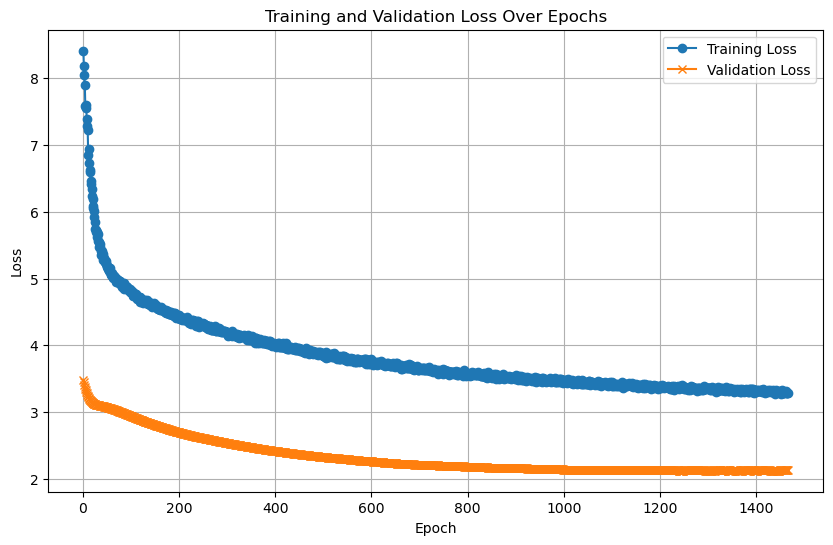

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/11], Loss: 4.8996

Test Loss: 5.0542


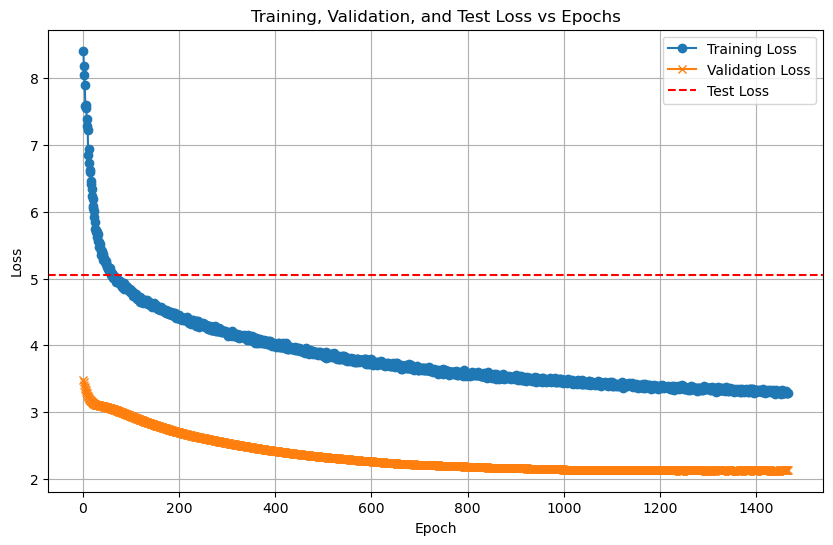

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/11 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (560, 128)
Train labels shape: (560,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2618, 128)
Test labels shape: (2618,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 95.71%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         5
           5       1.00      0.60      0.75         5
           6       1.00      1.00      1.00         5
           7       1.00      0.80      0.89         5
           8       0.83      1.00      0.91         5
           9       0.83      1.00      0.91         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (560, 128)
Train labels shape: (560,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2618, 128)
Test labels shape: (2618,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 3.0211  |  Val Loss: 2.8963
Validation loss improved from inf to 2.8963.
[Epoch 2/1000] Train Loss: 2.8708  |  Val Loss: 2.7752
Validation loss improved from 2.8963 to 2.7752.
[Epoch 3/1000] Train Loss: 2.7515  |  Val Loss: 2.6739
Validation loss improved from 2.7752 to 2.6739.
[Epoch 4/1000] Train Loss: 2.6508  |  Val Loss: 2.5888
Validation loss improved from 2.6739 to 2.5888.


[Epoch 5/1000] Train Loss: 2.5656  |  Val Loss: 2.5086
Validation loss improved from 2.5888 to 2.5086.
[Epoch 6/1000] Train Loss: 2.4858  |  Val Loss: 2.4475
Validation loss improved from 2.5086 to 2.4475.
[Epoch 7/1000] Train Loss: 2.4218  |  Val Loss: 2.3995
Validation loss improved from 2.4475 to 2.3995.


[Epoch 8/1000] Train Loss: 2.3747  |  Val Loss: 2.3565
Validation loss improved from 2.3995 to 2.3565.
[Epoch 9/1000] Train Loss: 2.3311  |  Val Loss: 2.3163
Validation loss improved from 2.3565 to 2.3163.
[Epoch 10/1000] Train Loss: 2.2919  |  Val Loss: 2.2792
Validation loss improved from 2.3163 to 2.2792.


[Epoch 11/1000] Train Loss: 2.2573  |  Val Loss: 2.2453
Validation loss improved from 2.2792 to 2.2453.
[Epoch 12/1000] Train Loss: 2.2238  |  Val Loss: 2.2129
Validation loss improved from 2.2453 to 2.2129.
[Epoch 13/1000] Train Loss: 2.1912  |  Val Loss: 2.1808
Validation loss improved from 2.2129 to 2.1808.
[Epoch 14/1000] Train Loss: 2.1602  |  Val Loss: 2.1477
Validation loss improved from 2.1808 to 2.1477.


[Epoch 15/1000] Train Loss: 2.1267  |  Val Loss: 2.1101
Validation loss improved from 2.1477 to 2.1101.
[Epoch 16/1000] Train Loss: 2.0903  |  Val Loss: 2.0714
Validation loss improved from 2.1101 to 2.0714.
[Epoch 17/1000] Train Loss: 2.0515  |  Val Loss: 2.0343
Validation loss improved from 2.0714 to 2.0343.


[Epoch 18/1000] Train Loss: 2.0155  |  Val Loss: 1.9980
Validation loss improved from 2.0343 to 1.9980.
[Epoch 19/1000] Train Loss: 1.9802  |  Val Loss: 1.9632
Validation loss improved from 1.9980 to 1.9632.
[Epoch 20/1000] Train Loss: 1.9466  |  Val Loss: 1.9291
Validation loss improved from 1.9632 to 1.9291.


[Epoch 21/1000] Train Loss: 1.9119  |  Val Loss: 1.8963
Validation loss improved from 1.9291 to 1.8963.
[Epoch 22/1000] Train Loss: 1.8786  |  Val Loss: 1.8626
Validation loss improved from 1.8963 to 1.8626.
[Epoch 23/1000] Train Loss: 1.8454  |  Val Loss: 1.8307
Validation loss improved from 1.8626 to 1.8307.
[Epoch 24/1000] Train Loss: 1.8132  |  Val Loss: 1.8001
Validation loss improved from 1.8307 to 1.8001.


[Epoch 25/1000] Train Loss: 1.7825  |  Val Loss: 1.7707
Validation loss improved from 1.8001 to 1.7707.
[Epoch 26/1000] Train Loss: 1.7519  |  Val Loss: 1.7424
Validation loss improved from 1.7707 to 1.7424.
[Epoch 27/1000] Train Loss: 1.7225  |  Val Loss: 1.7150
Validation loss improved from 1.7424 to 1.7150.


[Epoch 28/1000] Train Loss: 1.6938  |  Val Loss: 1.6881
Validation loss improved from 1.7150 to 1.6881.
[Epoch 29/1000] Train Loss: 1.6650  |  Val Loss: 1.6608
Validation loss improved from 1.6881 to 1.6608.
[Epoch 30/1000] Train Loss: 1.6361  |  Val Loss: 1.6346
Validation loss improved from 1.6608 to 1.6346.


[Epoch 31/1000] Train Loss: 1.6085  |  Val Loss: 1.6087
Validation loss improved from 1.6346 to 1.6087.
[Epoch 32/1000] Train Loss: 1.5811  |  Val Loss: 1.5841
Validation loss improved from 1.6087 to 1.5841.
[Epoch 33/1000] Train Loss: 1.5544  |  Val Loss: 1.5585
Validation loss improved from 1.5841 to 1.5585.
[Epoch 34/1000] Train Loss: 1.5282  |  Val Loss: 1.5336
Validation loss improved from 1.5585 to 1.5336.


[Epoch 35/1000] Train Loss: 1.5016  |  Val Loss: 1.5090
Validation loss improved from 1.5336 to 1.5090.
[Epoch 36/1000] Train Loss: 1.4755  |  Val Loss: 1.4842
Validation loss improved from 1.5090 to 1.4842.
[Epoch 37/1000] Train Loss: 1.4495  |  Val Loss: 1.4595
Validation loss improved from 1.4842 to 1.4595.


[Epoch 38/1000] Train Loss: 1.4234  |  Val Loss: 1.4357
Validation loss improved from 1.4595 to 1.4357.
[Epoch 39/1000] Train Loss: 1.3979  |  Val Loss: 1.4120
Validation loss improved from 1.4357 to 1.4120.
[Epoch 40/1000] Train Loss: 1.3728  |  Val Loss: 1.3876
Validation loss improved from 1.4120 to 1.3876.


[Epoch 41/1000] Train Loss: 1.3481  |  Val Loss: 1.3641
Validation loss improved from 1.3876 to 1.3641.
[Epoch 42/1000] Train Loss: 1.3227  |  Val Loss: 1.3421
Validation loss improved from 1.3641 to 1.3421.
[Epoch 43/1000] Train Loss: 1.2982  |  Val Loss: 1.3202
Validation loss improved from 1.3421 to 1.3202.
[Epoch 44/1000] Train Loss: 1.2738  |  Val Loss: 1.2978
Validation loss improved from 1.3202 to 1.2978.


[Epoch 45/1000] Train Loss: 1.2496  |  Val Loss: 1.2752
Validation loss improved from 1.2978 to 1.2752.
[Epoch 46/1000] Train Loss: 1.2251  |  Val Loss: 1.2538
Validation loss improved from 1.2752 to 1.2538.
[Epoch 47/1000] Train Loss: 1.2012  |  Val Loss: 1.2321
Validation loss improved from 1.2538 to 1.2321.


[Epoch 48/1000] Train Loss: 1.1777  |  Val Loss: 1.2105
Validation loss improved from 1.2321 to 1.2105.
[Epoch 49/1000] Train Loss: 1.1543  |  Val Loss: 1.1896
Validation loss improved from 1.2105 to 1.1896.
[Epoch 50/1000] Train Loss: 1.1308  |  Val Loss: 1.1689
Validation loss improved from 1.1896 to 1.1689.
[Epoch 51/1000] Train Loss: 1.1077  |  Val Loss: 1.1484
Validation loss improved from 1.1689 to 1.1484.


[Epoch 52/1000] Train Loss: 1.0851  |  Val Loss: 1.1285
Validation loss improved from 1.1484 to 1.1285.
[Epoch 53/1000] Train Loss: 1.0625  |  Val Loss: 1.1088
Validation loss improved from 1.1285 to 1.1088.
[Epoch 54/1000] Train Loss: 1.0400  |  Val Loss: 1.0896
Validation loss improved from 1.1088 to 1.0896.


[Epoch 55/1000] Train Loss: 1.0181  |  Val Loss: 1.0704
Validation loss improved from 1.0896 to 1.0704.
[Epoch 56/1000] Train Loss: 0.9965  |  Val Loss: 1.0506
Validation loss improved from 1.0704 to 1.0506.
[Epoch 57/1000] Train Loss: 0.9747  |  Val Loss: 1.0321
Validation loss improved from 1.0506 to 1.0321.


[Epoch 58/1000] Train Loss: 0.9533  |  Val Loss: 1.0144
Validation loss improved from 1.0321 to 1.0144.
[Epoch 59/1000] Train Loss: 0.9324  |  Val Loss: 0.9958
Validation loss improved from 1.0144 to 0.9958.
[Epoch 60/1000] Train Loss: 0.9114  |  Val Loss: 0.9786
Validation loss improved from 0.9958 to 0.9786.
[Epoch 61/1000] Train Loss: 0.8907  |  Val Loss: 0.9611
Validation loss improved from 0.9786 to 0.9611.


[Epoch 62/1000] Train Loss: 0.8703  |  Val Loss: 0.9448
Validation loss improved from 0.9611 to 0.9448.
[Epoch 63/1000] Train Loss: 0.8502  |  Val Loss: 0.9276
Validation loss improved from 0.9448 to 0.9276.
[Epoch 64/1000] Train Loss: 0.8303  |  Val Loss: 0.9106
Validation loss improved from 0.9276 to 0.9106.
[Epoch 65/1000] Train Loss: 0.8103  |  Val Loss: 0.8946
Validation loss improved from 0.9106 to 0.8946.


[Epoch 66/1000] Train Loss: 0.7909  |  Val Loss: 0.8789
Validation loss improved from 0.8946 to 0.8789.
[Epoch 67/1000] Train Loss: 0.7717  |  Val Loss: 0.8629
Validation loss improved from 0.8789 to 0.8629.
[Epoch 68/1000] Train Loss: 0.7526  |  Val Loss: 0.8470
Validation loss improved from 0.8629 to 0.8470.


[Epoch 69/1000] Train Loss: 0.7340  |  Val Loss: 0.8309
Validation loss improved from 0.8470 to 0.8309.
[Epoch 70/1000] Train Loss: 0.7147  |  Val Loss: 0.8161
Validation loss improved from 0.8309 to 0.8161.
[Epoch 71/1000] Train Loss: 0.6963  |  Val Loss: 0.8007
Validation loss improved from 0.8161 to 0.8007.
[Epoch 72/1000] Train Loss: 0.6775  |  Val Loss: 0.7868
Validation loss improved from 0.8007 to 0.7868.


[Epoch 73/1000] Train Loss: 0.6598  |  Val Loss: 0.7717
Validation loss improved from 0.7868 to 0.7717.
[Epoch 74/1000] Train Loss: 0.6413  |  Val Loss: 0.7572
Validation loss improved from 0.7717 to 0.7572.
[Epoch 75/1000] Train Loss: 0.6233  |  Val Loss: 0.7428
Validation loss improved from 0.7572 to 0.7428.


[Epoch 76/1000] Train Loss: 0.6054  |  Val Loss: 0.7286
Validation loss improved from 0.7428 to 0.7286.
[Epoch 77/1000] Train Loss: 0.5880  |  Val Loss: 0.7147
Validation loss improved from 0.7286 to 0.7147.
[Epoch 78/1000] Train Loss: 0.5707  |  Val Loss: 0.7007
Validation loss improved from 0.7147 to 0.7007.


[Epoch 79/1000] Train Loss: 0.5530  |  Val Loss: 0.6868
Validation loss improved from 0.7007 to 0.6868.
[Epoch 80/1000] Train Loss: 0.5358  |  Val Loss: 0.6738
Validation loss improved from 0.6868 to 0.6738.
[Epoch 81/1000] Train Loss: 0.5193  |  Val Loss: 0.6607
Validation loss improved from 0.6738 to 0.6607.
[Epoch 82/1000] Train Loss: 0.5023  |  Val Loss: 0.6476
Validation loss improved from 0.6607 to 0.6476.


[Epoch 83/1000] Train Loss: 0.4862  |  Val Loss: 0.6339
Validation loss improved from 0.6476 to 0.6339.
[Epoch 84/1000] Train Loss: 0.4700  |  Val Loss: 0.6209
Validation loss improved from 0.6339 to 0.6209.
[Epoch 85/1000] Train Loss: 0.4542  |  Val Loss: 0.6086
Validation loss improved from 0.6209 to 0.6086.


[Epoch 86/1000] Train Loss: 0.4387  |  Val Loss: 0.5958
Validation loss improved from 0.6086 to 0.5958.
[Epoch 87/1000] Train Loss: 0.4232  |  Val Loss: 0.5846
Validation loss improved from 0.5958 to 0.5846.
[Epoch 88/1000] Train Loss: 0.4083  |  Val Loss: 0.5722
Validation loss improved from 0.5846 to 0.5722.


[Epoch 89/1000] Train Loss: 0.3938  |  Val Loss: 0.5604
Validation loss improved from 0.5722 to 0.5604.
[Epoch 90/1000] Train Loss: 0.3802  |  Val Loss: 0.5490
Validation loss improved from 0.5604 to 0.5490.
[Epoch 91/1000] Train Loss: 0.3662  |  Val Loss: 0.5377
Validation loss improved from 0.5490 to 0.5377.
[Epoch 92/1000] Train Loss: 0.3528  |  Val Loss: 0.5273
Validation loss improved from 0.5377 to 0.5273.
[Epoch 93/1000] Train Loss: 0.3400  |  Val Loss: 0.5168
Validation loss improved from 0.5273 to 0.5168.


[Epoch 94/1000] Train Loss: 0.3276  |  Val Loss: 0.5061
Validation loss improved from 0.5168 to 0.5061.
[Epoch 95/1000] Train Loss: 0.3156  |  Val Loss: 0.4955
Validation loss improved from 0.5061 to 0.4955.
[Epoch 96/1000] Train Loss: 0.3039  |  Val Loss: 0.4862
Validation loss improved from 0.4955 to 0.4862.


[Epoch 97/1000] Train Loss: 0.2929  |  Val Loss: 0.4761
Validation loss improved from 0.4862 to 0.4761.
[Epoch 98/1000] Train Loss: 0.2818  |  Val Loss: 0.4669
Validation loss improved from 0.4761 to 0.4669.
[Epoch 99/1000] Train Loss: 0.2714  |  Val Loss: 0.4578
Validation loss improved from 0.4669 to 0.4578.


[Epoch 100/1000] Train Loss: 0.2615  |  Val Loss: 0.4493
Validation loss improved from 0.4578 to 0.4493.
[Epoch 101/1000] Train Loss: 0.2518  |  Val Loss: 0.4406
Validation loss improved from 0.4493 to 0.4406.
[Epoch 102/1000] Train Loss: 0.2427  |  Val Loss: 0.4325
Validation loss improved from 0.4406 to 0.4325.
[Epoch 103/1000] Train Loss: 0.2340  |  Val Loss: 0.4241
Validation loss improved from 0.4325 to 0.4241.


[Epoch 104/1000] Train Loss: 0.2254  |  Val Loss: 0.4167
Validation loss improved from 0.4241 to 0.4167.
[Epoch 105/1000] Train Loss: 0.2174  |  Val Loss: 0.4087
Validation loss improved from 0.4167 to 0.4087.
[Epoch 106/1000] Train Loss: 0.2095  |  Val Loss: 0.4019
Validation loss improved from 0.4087 to 0.4019.
[Epoch 107/1000] Train Loss: 0.2022  |  Val Loss: 0.3947
Validation loss improved from 0.4019 to 0.3947.


[Epoch 108/1000] Train Loss: 0.1951  |  Val Loss: 0.3877
Validation loss improved from 0.3947 to 0.3877.
[Epoch 109/1000] Train Loss: 0.1883  |  Val Loss: 0.3808
Validation loss improved from 0.3877 to 0.3808.


[Epoch 110/1000] Train Loss: 0.1820  |  Val Loss: 0.3746
Validation loss improved from 0.3808 to 0.3746.
[Epoch 111/1000] Train Loss: 0.1757  |  Val Loss: 0.3681
Validation loss improved from 0.3746 to 0.3681.
[Epoch 112/1000] Train Loss: 0.1697  |  Val Loss: 0.3622
Validation loss improved from 0.3681 to 0.3622.


[Epoch 113/1000] Train Loss: 0.1641  |  Val Loss: 0.3565
Validation loss improved from 0.3622 to 0.3565.
[Epoch 114/1000] Train Loss: 0.1588  |  Val Loss: 0.3503
Validation loss improved from 0.3565 to 0.3503.
[Epoch 115/1000] Train Loss: 0.1535  |  Val Loss: 0.3450
Validation loss improved from 0.3503 to 0.3450.
[Epoch 116/1000] Train Loss: 0.1487  |  Val Loss: 0.3397
Validation loss improved from 0.3450 to 0.3397.
[Epoch 117/1000] Train Loss: 0.1438  |  Val Loss: 0.3353
Validation loss improved from 0.3397 to 0.3353.


[Epoch 118/1000] Train Loss: 0.1394  |  Val Loss: 0.3296
Validation loss improved from 0.3353 to 0.3296.
[Epoch 119/1000] Train Loss: 0.1351  |  Val Loss: 0.3251
Validation loss improved from 0.3296 to 0.3251.


[Epoch 120/1000] Train Loss: 0.1309  |  Val Loss: 0.3214
Validation loss improved from 0.3251 to 0.3214.
[Epoch 121/1000] Train Loss: 0.1270  |  Val Loss: 0.3164
Validation loss improved from 0.3214 to 0.3164.
[Epoch 122/1000] Train Loss: 0.1233  |  Val Loss: 0.3124
Validation loss improved from 0.3164 to 0.3124.


[Epoch 123/1000] Train Loss: 0.1196  |  Val Loss: 0.3081
Validation loss improved from 0.3124 to 0.3081.
[Epoch 124/1000] Train Loss: 0.1162  |  Val Loss: 0.3045
Validation loss improved from 0.3081 to 0.3045.
[Epoch 125/1000] Train Loss: 0.1129  |  Val Loss: 0.3002
Validation loss improved from 0.3045 to 0.3002.
[Epoch 126/1000] Train Loss: 0.1096  |  Val Loss: 0.2968
Validation loss improved from 0.3002 to 0.2968.


[Epoch 127/1000] Train Loss: 0.1066  |  Val Loss: 0.2933
Validation loss improved from 0.2968 to 0.2933.
[Epoch 128/1000] Train Loss: 0.1037  |  Val Loss: 0.2897
Validation loss improved from 0.2933 to 0.2897.
[Epoch 129/1000] Train Loss: 0.1008  |  Val Loss: 0.2862
Validation loss improved from 0.2897 to 0.2862.


[Epoch 130/1000] Train Loss: 0.0981  |  Val Loss: 0.2832
Validation loss improved from 0.2862 to 0.2832.
[Epoch 131/1000] Train Loss: 0.0956  |  Val Loss: 0.2804
Validation loss improved from 0.2832 to 0.2804.
[Epoch 132/1000] Train Loss: 0.0931  |  Val Loss: 0.2770
Validation loss improved from 0.2804 to 0.2770.
[Epoch 133/1000] Train Loss: 0.0907  |  Val Loss: 0.2744
Validation loss improved from 0.2770 to 0.2744.


[Epoch 134/1000] Train Loss: 0.0883  |  Val Loss: 0.2716
Validation loss improved from 0.2744 to 0.2716.
[Epoch 135/1000] Train Loss: 0.0861  |  Val Loss: 0.2688
Validation loss improved from 0.2716 to 0.2688.
[Epoch 136/1000] Train Loss: 0.0840  |  Val Loss: 0.2660
Validation loss improved from 0.2688 to 0.2660.


[Epoch 137/1000] Train Loss: 0.0819  |  Val Loss: 0.2637
Validation loss improved from 0.2660 to 0.2637.
[Epoch 138/1000] Train Loss: 0.0801  |  Val Loss: 0.2611
Validation loss improved from 0.2637 to 0.2611.
[Epoch 139/1000] Train Loss: 0.0781  |  Val Loss: 0.2588
Validation loss improved from 0.2611 to 0.2588.


[Epoch 140/1000] Train Loss: 0.0762  |  Val Loss: 0.2562
Validation loss improved from 0.2588 to 0.2562.
[Epoch 141/1000] Train Loss: 0.0744  |  Val Loss: 0.2539
Validation loss improved from 0.2562 to 0.2539.
[Epoch 142/1000] Train Loss: 0.0728  |  Val Loss: 0.2520
Validation loss improved from 0.2539 to 0.2520.
[Epoch 143/1000] Train Loss: 0.0711  |  Val Loss: 0.2496
Validation loss improved from 0.2520 to 0.2496.


[Epoch 144/1000] Train Loss: 0.0695  |  Val Loss: 0.2476
Validation loss improved from 0.2496 to 0.2476.
[Epoch 145/1000] Train Loss: 0.0679  |  Val Loss: 0.2452
Validation loss improved from 0.2476 to 0.2452.
[Epoch 146/1000] Train Loss: 0.0664  |  Val Loss: 0.2432
Validation loss improved from 0.2452 to 0.2432.


[Epoch 147/1000] Train Loss: 0.0650  |  Val Loss: 0.2413
Validation loss improved from 0.2432 to 0.2413.
[Epoch 148/1000] Train Loss: 0.0636  |  Val Loss: 0.2393
Validation loss improved from 0.2413 to 0.2393.
[Epoch 149/1000] Train Loss: 0.0623  |  Val Loss: 0.2379
Validation loss improved from 0.2393 to 0.2379.
[Epoch 150/1000] Train Loss: 0.0609  |  Val Loss: 0.2363
Validation loss improved from 0.2379 to 0.2363.


[Epoch 151/1000] Train Loss: 0.0598  |  Val Loss: 0.2342
Validation loss improved from 0.2363 to 0.2342.
[Epoch 152/1000] Train Loss: 0.0585  |  Val Loss: 0.2324
Validation loss improved from 0.2342 to 0.2324.
[Epoch 153/1000] Train Loss: 0.0573  |  Val Loss: 0.2308
Validation loss improved from 0.2324 to 0.2308.
[Epoch 154/1000] Train Loss: 0.0562  |  Val Loss: 0.2293
Validation loss improved from 0.2308 to 0.2293.


[Epoch 155/1000] Train Loss: 0.0550  |  Val Loss: 0.2276
Validation loss improved from 0.2293 to 0.2276.
[Epoch 156/1000] Train Loss: 0.0540  |  Val Loss: 0.2266
Validation loss improved from 0.2276 to 0.2266.
[Epoch 157/1000] Train Loss: 0.0529  |  Val Loss: 0.2251
Validation loss improved from 0.2266 to 0.2251.


[Epoch 158/1000] Train Loss: 0.0519  |  Val Loss: 0.2236
Validation loss improved from 0.2251 to 0.2236.
[Epoch 159/1000] Train Loss: 0.0509  |  Val Loss: 0.2223
Validation loss improved from 0.2236 to 0.2223.
[Epoch 160/1000] Train Loss: 0.0500  |  Val Loss: 0.2209
Validation loss improved from 0.2223 to 0.2209.
[Epoch 161/1000] Train Loss: 0.0491  |  Val Loss: 0.2194
Validation loss improved from 0.2209 to 0.2194.


[Epoch 162/1000] Train Loss: 0.0482  |  Val Loss: 0.2183
Validation loss improved from 0.2194 to 0.2183.
[Epoch 163/1000] Train Loss: 0.0473  |  Val Loss: 0.2174
Validation loss improved from 0.2183 to 0.2174.
[Epoch 164/1000] Train Loss: 0.0464  |  Val Loss: 0.2162
Validation loss improved from 0.2174 to 0.2162.
[Epoch 165/1000] Train Loss: 0.0456  |  Val Loss: 0.2149
Validation loss improved from 0.2162 to 0.2149.


[Epoch 166/1000] Train Loss: 0.0448  |  Val Loss: 0.2137
Validation loss improved from 0.2149 to 0.2137.
[Epoch 167/1000] Train Loss: 0.0440  |  Val Loss: 0.2127
Validation loss improved from 0.2137 to 0.2127.


[Epoch 168/1000] Train Loss: 0.0432  |  Val Loss: 0.2111
Validation loss improved from 0.2127 to 0.2111.
[Epoch 169/1000] Train Loss: 0.0424  |  Val Loss: 0.2103
Validation loss improved from 0.2111 to 0.2103.
[Epoch 170/1000] Train Loss: 0.0416  |  Val Loss: 0.2087
Validation loss improved from 0.2103 to 0.2087.
[Epoch 171/1000] Train Loss: 0.0408  |  Val Loss: 0.2078
Validation loss improved from 0.2087 to 0.2078.
[Epoch 172/1000] Train Loss: 0.0401  |  Val Loss: 0.2074
Validation loss improved from 0.2078 to 0.2074.


[Epoch 173/1000] Train Loss: 0.0394  |  Val Loss: 0.2063
Validation loss improved from 0.2074 to 0.2063.
[Epoch 174/1000] Train Loss: 0.0387  |  Val Loss: 0.2054
Validation loss improved from 0.2063 to 0.2054.
[Epoch 175/1000] Train Loss: 0.0381  |  Val Loss: 0.2045
Validation loss improved from 0.2054 to 0.2045.


[Epoch 176/1000] Train Loss: 0.0374  |  Val Loss: 0.2035
Validation loss improved from 0.2045 to 0.2035.
[Epoch 177/1000] Train Loss: 0.0368  |  Val Loss: 0.2024
Validation loss improved from 0.2035 to 0.2024.
[Epoch 178/1000] Train Loss: 0.0362  |  Val Loss: 0.2016
Validation loss improved from 0.2024 to 0.2016.


[Epoch 179/1000] Train Loss: 0.0356  |  Val Loss: 0.2011
Validation loss improved from 0.2016 to 0.2011.
[Epoch 180/1000] Train Loss: 0.0350  |  Val Loss: 0.2003
Validation loss improved from 0.2011 to 0.2003.
[Epoch 181/1000] Train Loss: 0.0344  |  Val Loss: 0.1998
Validation loss improved from 0.2003 to 0.1998.
[Epoch 182/1000] Train Loss: 0.0338  |  Val Loss: 0.1991
Validation loss improved from 0.1998 to 0.1991.
[Epoch 183/1000] Train Loss: 0.0333  |  Val Loss: 0.1984
Validation loss improved from 0.1991 to 0.1984.


[Epoch 184/1000] Train Loss: 0.0328  |  Val Loss: 0.1975
Validation loss improved from 0.1984 to 0.1975.
[Epoch 185/1000] Train Loss: 0.0323  |  Val Loss: 0.1968
Validation loss improved from 0.1975 to 0.1968.
[Epoch 186/1000] Train Loss: 0.0318  |  Val Loss: 0.1962
Validation loss improved from 0.1968 to 0.1962.


[Epoch 187/1000] Train Loss: 0.0313  |  Val Loss: 0.1956
Validation loss improved from 0.1962 to 0.1956.
[Epoch 188/1000] Train Loss: 0.0309  |  Val Loss: 0.1949
Validation loss improved from 0.1956 to 0.1949.
[Epoch 189/1000] Train Loss: 0.0304  |  Val Loss: 0.1942
Validation loss improved from 0.1949 to 0.1942.


[Epoch 190/1000] Train Loss: 0.0299  |  Val Loss: 0.1935
Validation loss improved from 0.1942 to 0.1935.
[Epoch 191/1000] Train Loss: 0.0295  |  Val Loss: 0.1930
Validation loss improved from 0.1935 to 0.1930.
[Epoch 192/1000] Train Loss: 0.0291  |  Val Loss: 0.1922
Validation loss improved from 0.1930 to 0.1922.
[Epoch 193/1000] Train Loss: 0.0287  |  Val Loss: 0.1925
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 194/1000] Train Loss: 0.0283  |  Val Loss: 0.1914
Validation loss improved from 0.1922 to 0.1914.


[Epoch 195/1000] Train Loss: 0.0278  |  Val Loss: 0.1911
Validation loss improved from 0.1914 to 0.1911.
[Epoch 196/1000] Train Loss: 0.0274  |  Val Loss: 0.1906
Validation loss improved from 0.1911 to 0.1906.
[Epoch 197/1000] Train Loss: 0.0271  |  Val Loss: 0.1898
Validation loss improved from 0.1906 to 0.1898.


[Epoch 198/1000] Train Loss: 0.0267  |  Val Loss: 0.1897
Validation loss improved from 0.1898 to 0.1897.
[Epoch 199/1000] Train Loss: 0.0263  |  Val Loss: 0.1890
Validation loss improved from 0.1897 to 0.1890.
[Epoch 200/1000] Train Loss: 0.0260  |  Val Loss: 0.1885
Validation loss improved from 0.1890 to 0.1885.


[Epoch 201/1000] Train Loss: 0.0256  |  Val Loss: 0.1879
Validation loss improved from 0.1885 to 0.1879.
[Epoch 202/1000] Train Loss: 0.0253  |  Val Loss: 0.1875
Validation loss improved from 0.1879 to 0.1875.
[Epoch 203/1000] Train Loss: 0.0250  |  Val Loss: 0.1872
Validation loss improved from 0.1875 to 0.1872.
[Epoch 204/1000] Train Loss: 0.0246  |  Val Loss: 0.1868
Validation loss improved from 0.1872 to 0.1868.


[Epoch 205/1000] Train Loss: 0.0243  |  Val Loss: 0.1864
Validation loss improved from 0.1868 to 0.1864.
[Epoch 206/1000] Train Loss: 0.0240  |  Val Loss: 0.1857
Validation loss improved from 0.1864 to 0.1857.
[Epoch 207/1000] Train Loss: 0.0237  |  Val Loss: 0.1855
Validation loss improved from 0.1857 to 0.1855.
[Epoch 208/1000] Train Loss: 0.0234  |  Val Loss: 0.1852
Validation loss improved from 0.1855 to 0.1852.


[Epoch 209/1000] Train Loss: 0.0231  |  Val Loss: 0.1848
Validation loss improved from 0.1852 to 0.1848.
[Epoch 210/1000] Train Loss: 0.0228  |  Val Loss: 0.1842
Validation loss improved from 0.1848 to 0.1842.
[Epoch 211/1000] Train Loss: 0.0225  |  Val Loss: 0.1841
Validation loss improved from 0.1842 to 0.1841.


[Epoch 212/1000] Train Loss: 0.0223  |  Val Loss: 0.1837
Validation loss improved from 0.1841 to 0.1837.
[Epoch 213/1000] Train Loss: 0.0220  |  Val Loss: 0.1829
Validation loss improved from 0.1837 to 0.1829.
[Epoch 214/1000] Train Loss: 0.0217  |  Val Loss: 0.1828
Validation loss improved from 0.1829 to 0.1828.
[Epoch 215/1000] Train Loss: 0.0215  |  Val Loss: 0.1823
Validation loss improved from 0.1828 to 0.1823.


[Epoch 216/1000] Train Loss: 0.0212  |  Val Loss: 0.1820
Validation loss improved from 0.1823 to 0.1820.
[Epoch 217/1000] Train Loss: 0.0210  |  Val Loss: 0.1819
Validation loss improved from 0.1820 to 0.1819.
[Epoch 218/1000] Train Loss: 0.0207  |  Val Loss: 0.1818
Validation loss improved from 0.1819 to 0.1818.


[Epoch 219/1000] Train Loss: 0.0205  |  Val Loss: 0.1811
Validation loss improved from 0.1818 to 0.1811.
[Epoch 220/1000] Train Loss: 0.0203  |  Val Loss: 0.1810
Validation loss improved from 0.1811 to 0.1810.
[Epoch 221/1000] Train Loss: 0.0200  |  Val Loss: 0.1801
Validation loss improved from 0.1810 to 0.1801.


[Epoch 222/1000] Train Loss: 0.0198  |  Val Loss: 0.1798
Validation loss improved from 0.1801 to 0.1798.
[Epoch 223/1000] Train Loss: 0.0196  |  Val Loss: 0.1798
Validation loss improved from 0.1798 to 0.1798.
[Epoch 224/1000] Train Loss: 0.0193  |  Val Loss: 0.1797
Validation loss improved from 0.1798 to 0.1797.
[Epoch 225/1000] Train Loss: 0.0191  |  Val Loss: 0.1794
Validation loss improved from 0.1797 to 0.1794.


[Epoch 226/1000] Train Loss: 0.0189  |  Val Loss: 0.1789
Validation loss improved from 0.1794 to 0.1789.
[Epoch 227/1000] Train Loss: 0.0187  |  Val Loss: 0.1788
Validation loss improved from 0.1789 to 0.1788.
[Epoch 228/1000] Train Loss: 0.0185  |  Val Loss: 0.1782
Validation loss improved from 0.1788 to 0.1782.
[Epoch 229/1000] Train Loss: 0.0183  |  Val Loss: 0.1782
Validation loss improved from 0.1782 to 0.1782.


[Epoch 230/1000] Train Loss: 0.0181  |  Val Loss: 0.1781
Validation loss improved from 0.1782 to 0.1781.
[Epoch 231/1000] Train Loss: 0.0179  |  Val Loss: 0.1774
Validation loss improved from 0.1781 to 0.1774.
[Epoch 232/1000] Train Loss: 0.0177  |  Val Loss: 0.1776
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 233/1000] Train Loss: 0.0175  |  Val Loss: 0.1773
Validation loss improved from 0.1774 to 0.1773.


[Epoch 234/1000] Train Loss: 0.0173  |  Val Loss: 0.1769
Validation loss improved from 0.1773 to 0.1769.
[Epoch 235/1000] Train Loss: 0.0171  |  Val Loss: 0.1764
Validation loss improved from 0.1769 to 0.1764.


[Epoch 236/1000] Train Loss: 0.0170  |  Val Loss: 0.1761
Validation loss improved from 0.1764 to 0.1761.
[Epoch 237/1000] Train Loss: 0.0168  |  Val Loss: 0.1761
Validation loss improved from 0.1761 to 0.1761.
[Epoch 238/1000] Train Loss: 0.0166  |  Val Loss: 0.1762
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 239/1000] Train Loss: 0.0164  |  Val Loss: 0.1757
Validation loss improved from 0.1761 to 0.1757.
[Epoch 240/1000] Train Loss: 0.0163  |  Val Loss: 0.1758
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 241/1000] Train Loss: 0.0161  |  Val Loss: 0.1754
Validation loss improved from 0.1757 to 0.1754.
[Epoch 242/1000] Train Loss: 0.0160  |  Val Loss: 0.1756
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 243/1000] Train Loss: 0.0158  |  Val Loss: 0.1751
Validation loss improved from 0.1754 to 0.1751.
[Epoch 244/1000] Train Loss: 0.0157  |  Val Loss: 0.1749
Validation loss improved from 0.1751 to 0.1749.


[Epoch 245/1000] Train Loss: 0.0156  |  Val Loss: 0.1751
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 246/1000] Train Loss: 0.0153  |  Val Loss: 0.1746
Validation loss improved from 0.1749 to 0.1746.
[Epoch 247/1000] Train Loss: 0.0152  |  Val Loss: 0.1744
Validation loss improved from 0.1746 to 0.1744.
[Epoch 248/1000] Train Loss: 0.0150  |  Val Loss: 0.1740
Validation loss improved from 0.1744 to 0.1740.
[Epoch 249/1000] Train Loss: 0.0149  |  Val Loss: 0.1737
Validation loss improved from 0.1740 to 0.1737.
[Epoch 250/1000] Train Loss: 0.0147  |  Val Loss: 0.1737
Validation loss improved from 0.1737 to 0.1737.
[Epoch 251/1000] Train Loss: 0.0146  |  Val Loss: 0.1735
Validation loss improved from 0.1737 to 0.1735.
[Epoch 252/1000] Train Loss: 0.0145  |  Val Loss: 0.1736
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 253/1000] Train Loss: 0.0143  |  Val Loss: 0.1734
Validation loss improved from 0.1735 to 0.1734.
[Epoch 254/1000] Train Loss: 0.0142  |  Val Loss: 0.1734
Validation loss improved from 0.1734 to 0.1734.
[Epoch 255/1000] Train Loss: 0.0141  |  Val Loss: 0.1737
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 256/1000] Train Loss: 0.0140  |  Val Loss: 0.1731
Validation loss improved from 0.1734 to 0.1731.
[Epoch 257/1000] Train Loss: 0.0138  |  Val Loss: 0.1725
Validation loss improved from 0.1731 to 0.1725.
[Epoch 258/1000] Train Loss: 0.0137  |  Val Loss: 0.1725
Validation loss improved from 0.1725 to 0.1725.
[Epoch 259/1000] Train Loss: 0.0136  |  Val Loss: 0.1726
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 260/1000] Train Loss: 0.0134  |  Val Loss: 0.1720
Validation loss improved from 0.1725 to 0.1720.
[Epoch 261/1000] Train Loss: 0.0134  |  Val Loss: 0.1718
Validation loss improved from 0.1720 to 0.1718.
[Epoch 262/1000] Train Loss: 0.0132  |  Val Loss: 0.1718
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 263/1000] Train Loss: 0.0131  |  Val Loss: 0.1720
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 264/1000] Train Loss: 0.0129  |  Val Loss: 0.1721
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 265/1000] Train Loss: 0.0129  |  Val Loss: 0.1722
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 266/1000] Train Loss: 0.0127  |  Val Loss: 0.1721
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 267/1000] Train Loss: 0.0126  |  Val Loss: 0.1717
Validation loss improved from 0.1718 to 0.1717.


[Epoch 268/1000] Train Loss: 0.0125  |  Val Loss: 0.1713
Validation loss improved from 0.1717 to 0.1713.
[Epoch 269/1000] Train Loss: 0.0124  |  Val Loss: 0.1713
Validation loss improved from 0.1713 to 0.1713.
[Epoch 270/1000] Train Loss: 0.0123  |  Val Loss: 0.1711
Validation loss improved from 0.1713 to 0.1711.
[Epoch 271/1000] Train Loss: 0.0122  |  Val Loss: 0.1713
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 272/1000] Train Loss: 0.0121  |  Val Loss: 0.1705
Validation loss improved from 0.1711 to 0.1705.
[Epoch 273/1000] Train Loss: 0.0120  |  Val Loss: 0.1707
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 274/1000] Train Loss: 0.0119  |  Val Loss: 0.1702
Validation loss improved from 0.1705 to 0.1702.
[Epoch 275/1000] Train Loss: 0.0118  |  Val Loss: 0.1703
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 276/1000] Train Loss: 0.0117  |  Val Loss: 0.1706
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 277/1000] Train Loss: 0.0116  |  Val Loss: 0.1703
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 278/1000] Train Loss: 0.0115  |  Val Loss: 0.1705
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 279/1000] Train Loss: 0.0114  |  Val Loss: 0.1708
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 280/1000] Train Loss: 0.0113  |  Val Loss: 0.1699
Validation loss improved from 0.1702 to 0.1699.
[Epoch 281/1000] Train Loss: 0.0112  |  Val Loss: 0.1698
Validation loss improved from 0.1699 to 0.1698.
[Epoch 282/1000] Train Loss: 0.0111  |  Val Loss: 0.1701
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 283/1000] Train Loss: 0.0110  |  Val Loss: 0.1697
Validation loss improved from 0.1698 to 0.1697.
[Epoch 284/1000] Train Loss: 0.0109  |  Val Loss: 0.1696
Validation loss improved from 0.1697 to 0.1696.
[Epoch 285/1000] Train Loss: 0.0108  |  Val Loss: 0.1698
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 286/1000] Train Loss: 0.0107  |  Val Loss: 0.1697
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 287/1000] Train Loss: 0.0107  |  Val Loss: 0.1696
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 288/1000] Train Loss: 0.0106  |  Val Loss: 0.1695
Validation loss improved from 0.1696 to 0.1695.
[Epoch 289/1000] Train Loss: 0.0105  |  Val Loss: 0.1697
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 290/1000] Train Loss: 0.0104  |  Val Loss: 0.1695
Validation loss improved from 0.1695 to 0.1695.


[Epoch 291/1000] Train Loss: 0.0103  |  Val Loss: 0.1693
Validation loss improved from 0.1695 to 0.1693.
[Epoch 292/1000] Train Loss: 0.0102  |  Val Loss: 0.1695
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 293/1000] Train Loss: 0.0102  |  Val Loss: 0.1690
Validation loss improved from 0.1693 to 0.1690.
[Epoch 294/1000] Train Loss: 0.0101  |  Val Loss: 0.1686
Validation loss improved from 0.1690 to 0.1686.
[Epoch 295/1000] Train Loss: 0.0100  |  Val Loss: 0.1689
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 296/1000] Train Loss: 0.0099  |  Val Loss: 0.1696
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 297/1000] Train Loss: 0.0098  |  Val Loss: 0.1691
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 298/1000] Train Loss: 0.0098  |  Val Loss: 0.1690
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 299/1000] Train Loss: 0.0097  |  Val Loss: 0.1691
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 300/1000] Train Loss: 0.0096  |  Val Loss: 0.1691
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 301/1000] Train Loss: 0.0096  |  Val Loss: 0.1696
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 302/1000] Train Loss: 0.0095  |  Val Loss: 0.1691
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 303/1000] Train Loss: 0.0095  |  Val Loss: 0.1689
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 304/1000] Train Loss: 0.0093  |  Val Loss: 0.1686
Validation loss improved from 0.1686 to 0.1686.
[Epoch 305/1000] Train Loss: 0.0092  |  Val Loss: 0.1684
Validation loss improved from 0.1686 to 0.1684.
[Epoch 306/1000] Train Loss: 0.0092  |  Val Loss: 0.1681
Validation loss improved from 0.1684 to 0.1681.
[Epoch 307/1000] Train Loss: 0.0091  |  Val Loss: 0.1684
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 308/1000] Train Loss: 0.0091  |  Val Loss: 0.1686
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 309/1000] Train Loss: 0.0090  |  Val Loss: 0.1689
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 310/1000] Train Loss: 0.0090  |  Val Loss: 0.1690
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 311/1000] Train Loss: 0.0089  |  Val Loss: 0.1689
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 312/1000] Train Loss: 0.0088  |  Val Loss: 0.1684
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 313/1000] Train Loss: 0.0087  |  Val Loss: 0.1683
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 314/1000] Train Loss: 0.0086  |  Val Loss: 0.1682
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 315/1000] Train Loss: 0.0087  |  Val Loss: 0.1688
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 316/1000] Train Loss: 0.0085  |  Val Loss: 0.1688
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 317/1000] Train Loss: 0.0085  |  Val Loss: 0.1684
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 318/1000] Train Loss: 0.0084  |  Val Loss: 0.1682
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 319/1000] Train Loss: 0.0084  |  Val Loss: 0.1686
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 320/1000] Train Loss: 0.0083  |  Val Loss: 0.1684
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 321/1000] Train Loss: 0.0082  |  Val Loss: 0.1685
!! Validation loss did NOT improve !! Patience: 15/100


[Epoch 322/1000] Train Loss: 0.0081  |  Val Loss: 0.1685
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 323/1000] Train Loss: 0.0082  |  Val Loss: 0.1689
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 324/1000] Train Loss: 0.0081  |  Val Loss: 0.1685
!! Validation loss did NOT improve !! Patience: 18/100


[Epoch 325/1000] Train Loss: 0.0080  |  Val Loss: 0.1683
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 326/1000] Train Loss: 0.0080  |  Val Loss: 0.1683
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 327/1000] Train Loss: 0.0079  |  Val Loss: 0.1683
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 328/1000] Train Loss: 0.0079  |  Val Loss: 0.1686
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 329/1000] Train Loss: 0.0078  |  Val Loss: 0.1691
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 330/1000] Train Loss: 0.0077  |  Val Loss: 0.1687
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 331/1000] Train Loss: 0.0076  |  Val Loss: 0.1680
Validation loss improved from 0.1681 to 0.1680.
[Epoch 332/1000] Train Loss: 0.0076  |  Val Loss: 0.1680
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 333/1000] Train Loss: 0.0076  |  Val Loss: 0.1686
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 334/1000] Train Loss: 0.0075  |  Val Loss: 0.1682
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 335/1000] Train Loss: 0.0074  |  Val Loss: 0.1683
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 336/1000] Train Loss: 0.0074  |  Val Loss: 0.1678
Validation loss improved from 0.1680 to 0.1678.
[Epoch 337/1000] Train Loss: 0.0073  |  Val Loss: 0.1677
Validation loss improved from 0.1678 to 0.1677.
[Epoch 338/1000] Train Loss: 0.0073  |  Val Loss: 0.1677
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 339/1000] Train Loss: 0.0072  |  Val Loss: 0.1680
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 340/1000] Train Loss: 0.0072  |  Val Loss: 0.1687
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 341/1000] Train Loss: 0.0071  |  Val Loss: 0.1687
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 342/1000] Train Loss: 0.0071  |  Val Loss: 0.1680
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 343/1000] Train Loss: 0.0071  |  Val Loss: 0.1683
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 344/1000] Train Loss: 0.0070  |  Val Loss: 0.1686
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 345/1000] Train Loss: 0.0070  |  Val Loss: 0.1687
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 346/1000] Train Loss: 0.0069  |  Val Loss: 0.1682
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 347/1000] Train Loss: 0.0069  |  Val Loss: 0.1682
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 348/1000] Train Loss: 0.0068  |  Val Loss: 0.1687
!! Validation loss did NOT improve !! Patience: 11/100


[Epoch 349/1000] Train Loss: 0.0068  |  Val Loss: 0.1686
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 350/1000] Train Loss: 0.0067  |  Val Loss: 0.1686
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 351/1000] Train Loss: 0.0067  |  Val Loss: 0.1682
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 352/1000] Train Loss: 0.0067  |  Val Loss: 0.1688
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 353/1000] Train Loss: 0.0066  |  Val Loss: 0.1690
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 354/1000] Train Loss: 0.0066  |  Val Loss: 0.1689
!! Validation loss did NOT improve !! Patience: 17/100


[Epoch 355/1000] Train Loss: 0.0065  |  Val Loss: 0.1686
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 356/1000] Train Loss: 0.0065  |  Val Loss: 0.1688
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 357/1000] Train Loss: 0.0064  |  Val Loss: 0.1684
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 358/1000] Train Loss: 0.0064  |  Val Loss: 0.1683
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 359/1000] Train Loss: 0.0063  |  Val Loss: 0.1685
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 360/1000] Train Loss: 0.0063  |  Val Loss: 0.1687
!! Validation loss did NOT improve !! Patience: 23/100


[Epoch 361/1000] Train Loss: 0.0063  |  Val Loss: 0.1690
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 362/1000] Train Loss: 0.0062  |  Val Loss: 0.1689
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 363/1000] Train Loss: 0.0062  |  Val Loss: 0.1692
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 364/1000] Train Loss: 0.0062  |  Val Loss: 0.1689
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 365/1000] Train Loss: 0.0061  |  Val Loss: 0.1691
!! Validation loss did NOT improve !! Patience: 28/100


[Epoch 366/1000] Train Loss: 0.0061  |  Val Loss: 0.1693
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 367/1000] Train Loss: 0.0060  |  Val Loss: 0.1691
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 368/1000] Train Loss: 0.0060  |  Val Loss: 0.1687
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 369/1000] Train Loss: 0.0060  |  Val Loss: 0.1690
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 370/1000] Train Loss: 0.0060  |  Val Loss: 0.1691
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 371/1000] Train Loss: 0.0059  |  Val Loss: 0.1692
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 372/1000] Train Loss: 0.0059  |  Val Loss: 0.1689
!! Validation loss did NOT improve !! Patience: 35/100


[Epoch 373/1000] Train Loss: 0.0059  |  Val Loss: 0.1693
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 374/1000] Train Loss: 0.0058  |  Val Loss: 0.1692
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 375/1000] Train Loss: 0.0057  |  Val Loss: 0.1689
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 376/1000] Train Loss: 0.0057  |  Val Loss: 0.1690
!! Validation loss did NOT improve !! Patience: 39/100


[Epoch 377/1000] Train Loss: 0.0057  |  Val Loss: 0.1695
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 378/1000] Train Loss: 0.0056  |  Val Loss: 0.1689
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 379/1000] Train Loss: 0.0056  |  Val Loss: 0.1688
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 380/1000] Train Loss: 0.0056  |  Val Loss: 0.1689
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 381/1000] Train Loss: 0.0055  |  Val Loss: 0.1688
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 382/1000] Train Loss: 0.0055  |  Val Loss: 0.1694
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 383/1000] Train Loss: 0.0055  |  Val Loss: 0.1690
!! Validation loss did NOT improve !! Patience: 46/100


[Epoch 384/1000] Train Loss: 0.0054  |  Val Loss: 0.1688
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 385/1000] Train Loss: 0.0054  |  Val Loss: 0.1689
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 386/1000] Train Loss: 0.0054  |  Val Loss: 0.1695
!! Validation loss did NOT improve !! Patience: 49/100


[Epoch 387/1000] Train Loss: 0.0053  |  Val Loss: 0.1693
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 388/1000] Train Loss: 0.0053  |  Val Loss: 0.1695
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 389/1000] Train Loss: 0.0053  |  Val Loss: 0.1697
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 390/1000] Train Loss: 0.0052  |  Val Loss: 0.1692
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 391/1000] Train Loss: 0.0052  |  Val Loss: 0.1694
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 392/1000] Train Loss: 0.0052  |  Val Loss: 0.1697
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 393/1000] Train Loss: 0.0051  |  Val Loss: 0.1697
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 394/1000] Train Loss: 0.0051  |  Val Loss: 0.1701
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 395/1000] Train Loss: 0.0051  |  Val Loss: 0.1703
!! Validation loss did NOT improve !! Patience:

[Epoch 396/1000] Train Loss: 0.0051  |  Val Loss: 0.1694
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 397/1000] Train Loss: 0.0050  |  Val Loss: 0.1692
!! Validation loss did NOT improve !! Patience: 60/100


[Epoch 398/1000] Train Loss: 0.0050  |  Val Loss: 0.1692
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 399/1000] Train Loss: 0.0050  |  Val Loss: 0.1693
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 400/1000] Train Loss: 0.0049  |  Val Loss: 0.1695
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 401/1000] Train Loss: 0.0049  |  Val Loss: 0.1699
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 402/1000] Train Loss: 0.0049  |  Val Loss: 0.1700
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 403/1000] Train Loss: 0.0048  |  Val Loss: 0.1704
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 404/1000] Train Loss: 0.0048  |  Val Loss: 0.1701
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 405/1000] Train Loss: 0.0048  |  Val Loss: 0.1704
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 406/1000] Train Loss: 0.0047  |  Val Loss: 0.1701
!! Validation loss did NOT improve !! Patience:

[Epoch 407/1000] Train Loss: 0.0047  |  Val Loss: 0.1701
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 408/1000] Train Loss: 0.0047  |  Val Loss: 0.1702
!! Validation loss did NOT improve !! Patience: 71/100


[Epoch 409/1000] Train Loss: 0.0047  |  Val Loss: 0.1702
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 410/1000] Train Loss: 0.0047  |  Val Loss: 0.1701
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 411/1000] Train Loss: 0.0047  |  Val Loss: 0.1706
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 412/1000] Train Loss: 0.0046  |  Val Loss: 0.1704
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 413/1000] Train Loss: 0.0046  |  Val Loss: 0.1709
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 414/1000] Train Loss: 0.0045  |  Val Loss: 0.1708
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 415/1000] Train Loss: 0.0045  |  Val Loss: 0.1704
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 416/1000] Train Loss: 0.0045  |  Val Loss: 0.1706
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 417/1000] Train Loss: 0.0045  |  Val Loss: 0.1708
!! Validation loss did NOT improve !! Patience:

[Epoch 419/1000] Train Loss: 0.0044  |  Val Loss: 0.1707
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 420/1000] Train Loss: 0.0044  |  Val Loss: 0.1710
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 421/1000] Train Loss: 0.0043  |  Val Loss: 0.1709
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 422/1000] Train Loss: 0.0044  |  Val Loss: 0.1706
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 423/1000] Train Loss: 0.0043  |  Val Loss: 0.1714
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 424/1000] Train Loss: 0.0043  |  Val Loss: 0.1713
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 425/1000] Train Loss: 0.0043  |  Val Loss: 0.1708
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 426/1000] Train Loss: 0.0042  |  Val Loss: 0.1711
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 427/1000] Train Loss: 0.0042  |  Val Loss: 0.1711
!! Validation loss did NOT improve !! Patience:

[Epoch 430/1000] Train Loss: 0.0042  |  Val Loss: 0.1709
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 431/1000] Train Loss: 0.0042  |  Val Loss: 0.1711
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 432/1000] Train Loss: 0.0041  |  Val Loss: 0.1717
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 433/1000] Train Loss: 0.0041  |  Val Loss: 0.1716
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 434/1000] Train Loss: 0.0040  |  Val Loss: 0.1718
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 435/1000] Train Loss: 0.0040  |  Val Loss: 0.1715
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 436/1000] Train Loss: 0.0040  |  Val Loss: 0.1712
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 437/1000] Train Loss: 0.0040  |  Val Loss: 0.1715
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 437 !!
No improvement for 100 epochs.


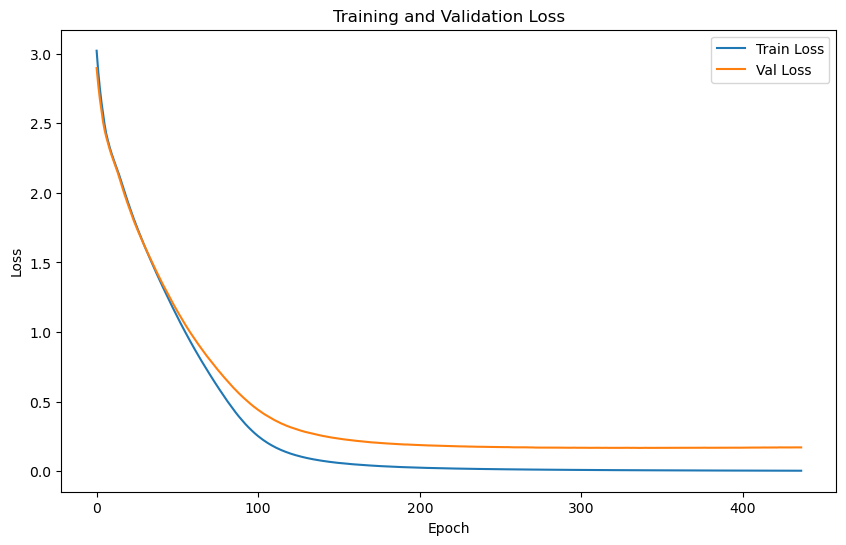

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.4700 | Test Accuracy: 88.69%


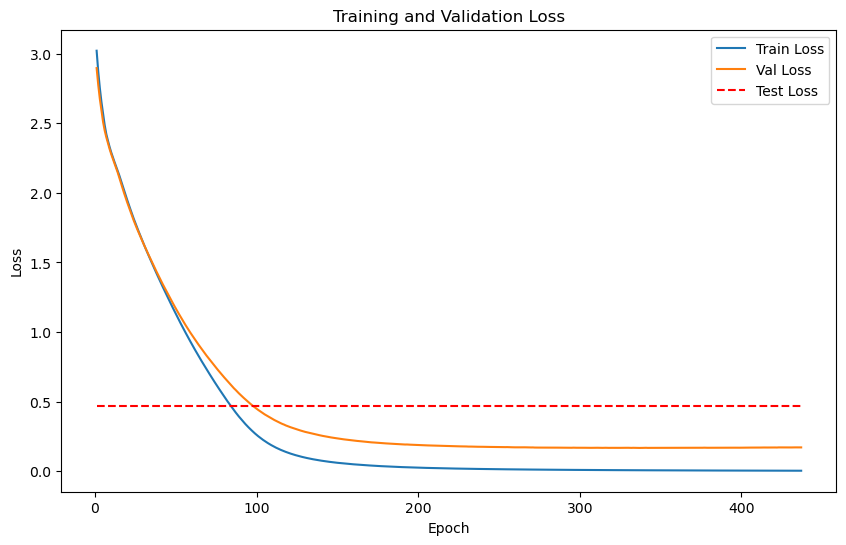

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 560 samples with 64 features each
LOG: Labels shape: (560,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2618 samples with 64 features each
LOG: Labels shape: (2618,)


Train embeddings shape: (560, 64), 
Train labels shape: (560,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (2618, 64), 
Test labels shape: (2618,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}
Training batch size: 280


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 0.4881
    Batch [2/2], Train Loss: 0.4889
LOG: Epoch [1/2000] - Validation


    Batch [1/2], Val Loss: 0.4541
    Batch [2/2], Val Loss: 0.2280
Epoch [1/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.3411

Validation loss improved from inf to 0.3411. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 0.4827


    Batch [2/2], Train Loss: 0.4847
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.4537
    Batch [2/2], Val Loss: 0.2309
Epoch [2/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.3423

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/2], Train Loss: 0.4820
    Batch [2/2], Train Loss: 0.4822
LOG: Epoch [3/2000] - Validation


    Batch [1/2], Val Loss: 0.4532
    Batch [2/2], Val Loss: 0.2361
Epoch [3/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.3447

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 0.4793


    Batch [2/2], Train Loss: 0.4806
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.4532
    Batch [2/2], Val Loss: 0.2419
Epoch [4/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.3476

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training


    Batch [1/2], Train Loss: 0.4779
    Batch [2/2], Train Loss: 0.4784
LOG: Epoch [5/2000] - Validation


    Batch [1/2], Val Loss: 0.4538
    Batch [2/2], Val Loss: 0.2487
Epoch [5/2000], Avg Train Loss: 0.4782, Avg Val Loss: 0.3512

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training
    Batch [1/2], Train Loss: 0.4764


    Batch [2/2], Train Loss: 0.4733
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.4540
    Batch [2/2], Val Loss: 0.2532
Epoch [6/2000], Avg Train Loss: 0.4749, Avg Val Loss: 0.3536

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [7/2000] - Training


    Batch [1/2], Train Loss: 0.4728
    Batch [2/2], Train Loss: 0.4751
LOG: Epoch [7/2000] - Validation


    Batch [1/2], Val Loss: 0.4526
    Batch [2/2], Val Loss: 0.2520
Epoch [7/2000], Avg Train Loss: 0.4739, Avg Val Loss: 0.3523

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [8/2000] - Training
    Batch [1/2], Train Loss: 0.4730


    Batch [2/2], Train Loss: 0.4746
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.4503
    Batch [2/2], Val Loss: 0.2510
Epoch [8/2000], Avg Train Loss: 0.4738, Avg Val Loss: 0.3506

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [9/2000] - Training


    Batch [1/2], Train Loss: 0.4707
    Batch [2/2], Train Loss: 0.4741
LOG: Epoch [9/2000] - Validation


    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.2365
Epoch [9/2000], Avg Train Loss: 0.4724, Avg Val Loss: 0.3424

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [10/2000] - Training


    Batch [1/2], Train Loss: 0.4707
    Batch [2/2], Train Loss: 0.4700
LOG: Epoch [10/2000] - Validation


    Batch [1/2], Val Loss: 0.4473
    Batch [2/2], Val Loss: 0.2218
Epoch [10/2000], Avg Train Loss: 0.4704, Avg Val Loss: 0.3345

Validation loss improved from 0.3411 to 0.3345. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/2], Train Loss: 0.4706


    Batch [2/2], Train Loss: 0.4710
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.4471
    Batch [2/2], Val Loss: 0.2109
Epoch [11/2000], Avg Train Loss: 0.4708, Avg Val Loss: 0.3290

Validation loss improved from 0.3345 to 0.3290. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/2], Train Loss: 0.4638
    Batch [2/2], Train Loss: 0.4656
LOG: Epoch [12/2000] - Validation


    Batch [1/2], Val Loss: 0.4447
    Batch [2/2], Val Loss: 0.1980
Epoch [12/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.3213

Validation loss improved from 0.3290 to 0.3213. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/2], Train Loss: 0.4599


    Batch [2/2], Train Loss: 0.4657
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.4461
    Batch [2/2], Val Loss: 0.1865
Epoch [13/2000], Avg Train Loss: 0.4628, Avg Val Loss: 0.3163

Validation loss improved from 0.3213 to 0.3163. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/2], Train Loss: 0.4631


    Batch [2/2], Train Loss: 0.4585
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.4449
    Batch [2/2], Val Loss: 0.1783
Epoch [14/2000], Avg Train Loss: 0.4608, Avg Val Loss: 0.3116

Validation loss improved from 0.3163 to 0.3116. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/2], Train Loss: 0.4608
    Batch [2/2], Train Loss: 0.4598
LOG: Epoch [15/2000] - Validation


    Batch [1/2], Val Loss: 0.4411
    Batch [2/2], Val Loss: 0.1701
Epoch [15/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.3056

Validation loss improved from 0.3116 to 0.3056. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/2], Train Loss: 0.4591


    Batch [2/2], Train Loss: 0.4573
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.4391
    Batch [2/2], Val Loss: 0.1642
Epoch [16/2000], Avg Train Loss: 0.4582, Avg Val Loss: 0.3017

Validation loss improved from 0.3056 to 0.3017. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/2], Train Loss: 0.4550
    Batch [2/2], Train Loss: 0.4521
LOG: Epoch [17/2000] - Validation


    Batch [1/2], Val Loss: 0.4374
    Batch [2/2], Val Loss: 0.1589
Epoch [17/2000], Avg Train Loss: 0.4536, Avg Val Loss: 0.2981

Validation loss improved from 0.3017 to 0.2981. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/2], Train Loss: 0.4560


    Batch [2/2], Train Loss: 0.4574
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.4364
    Batch [2/2], Val Loss: 0.1549
Epoch [18/2000], Avg Train Loss: 0.4567, Avg Val Loss: 0.2956

Validation loss improved from 0.2981 to 0.2956. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/2], Train Loss: 0.4575
    Batch [2/2], Train Loss: 0.4557
LOG: Epoch [19/2000] - Validation


    Batch [1/2], Val Loss: 0.4353
    Batch [2/2], Val Loss: 0.1533
Epoch [19/2000], Avg Train Loss: 0.4566, Avg Val Loss: 0.2943

Validation loss improved from 0.2956 to 0.2943. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/2], Train Loss: 0.4519


    Batch [2/2], Train Loss: 0.4567
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.4344
    Batch [2/2], Val Loss: 0.1531
Epoch [20/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.2938

Validation loss improved from 0.2943 to 0.2938. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/2], Train Loss: 0.4510
    Batch [2/2], Train Loss: 0.4497
LOG: Epoch [21/2000] - Validation


    Batch [1/2], Val Loss: 0.4339
    Batch [2/2], Val Loss: 0.1540
Epoch [21/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.2940

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [22/2000] - Training
    Batch [1/2], Train Loss: 0.4524


    Batch [2/2], Train Loss: 0.4544
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.4338
    Batch [2/2], Val Loss: 0.1550
Epoch [22/2000], Avg Train Loss: 0.4534, Avg Val Loss: 0.2944

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [23/2000] - Training


    Batch [1/2], Train Loss: 0.4510
    Batch [2/2], Train Loss: 0.4501
LOG: Epoch [23/2000] - Validation


    Batch [1/2], Val Loss: 0.4334
    Batch [2/2], Val Loss: 0.1567
Epoch [23/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.2951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [24/2000] - Training
    Batch [1/2], Train Loss: 0.4473


    Batch [2/2], Train Loss: 0.4476
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.4329
    Batch [2/2], Val Loss: 0.1586
Epoch [24/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.2958

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [25/2000] - Training


    Batch [1/2], Train Loss: 0.4486
    Batch [2/2], Train Loss: 0.4447
LOG: Epoch [25/2000] - Validation


    Batch [1/2], Val Loss: 0.4326
    Batch [2/2], Val Loss: 0.1601
Epoch [25/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.2964

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [26/2000] - Training
    Batch [1/2], Train Loss: 0.4431


    Batch [2/2], Train Loss: 0.4433
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.4326
    Batch [2/2], Val Loss: 0.1618
Epoch [26/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.2972

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [27/2000] - Training


    Batch [1/2], Train Loss: 0.4397
    Batch [2/2], Train Loss: 0.4379
LOG: Epoch [27/2000] - Validation


    Batch [1/2], Val Loss: 0.4325
    Batch [2/2], Val Loss: 0.1637
Epoch [27/2000], Avg Train Loss: 0.4388, Avg Val Loss: 0.2981

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [28/2000] - Training
    Batch [1/2], Train Loss: 0.4441


    Batch [2/2], Train Loss: 0.4386
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.4314
    Batch [2/2], Val Loss: 0.1658
Epoch [28/2000], Avg Train Loss: 0.4413, Avg Val Loss: 0.2986

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [29/2000] - Training


    Batch [1/2], Train Loss: 0.4430
    Batch [2/2], Train Loss: 0.4440
LOG: Epoch [29/2000] - Validation


    Batch [1/2], Val Loss: 0.4293
    Batch [2/2], Val Loss: 0.1682
Epoch [29/2000], Avg Train Loss: 0.4435, Avg Val Loss: 0.2987

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [30/2000] - Training
    Batch [1/2], Train Loss: 0.4424


    Batch [2/2], Train Loss: 0.4352
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.4275
    Batch [2/2], Val Loss: 0.1702
Epoch [30/2000], Avg Train Loss: 0.4388, Avg Val Loss: 0.2988

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [31/2000] - Training


    Batch [1/2], Train Loss: 0.4434
    Batch [2/2], Train Loss: 0.4351
LOG: Epoch [31/2000] - Validation


    Batch [1/2], Val Loss: 0.4252
    Batch [2/2], Val Loss: 0.1723
Epoch [31/2000], Avg Train Loss: 0.4393, Avg Val Loss: 0.2988

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [32/2000] - Training
    Batch [1/2], Train Loss: 0.4394


    Batch [2/2], Train Loss: 0.4398
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.4232
    Batch [2/2], Val Loss: 0.1756
Epoch [32/2000], Avg Train Loss: 0.4396, Avg Val Loss: 0.2994

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [33/2000] - Training


    Batch [1/2], Train Loss: 0.4342
    Batch [2/2], Train Loss: 0.4384
LOG: Epoch [33/2000] - Validation


    Batch [1/2], Val Loss: 0.4215
    Batch [2/2], Val Loss: 0.1788
Epoch [33/2000], Avg Train Loss: 0.4363, Avg Val Loss: 0.3002

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [34/2000] - Training
    Batch [1/2], Train Loss: 0.4379


    Batch [2/2], Train Loss: 0.4373
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.1821
Epoch [34/2000], Avg Train Loss: 0.4376, Avg Val Loss: 0.3010

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [35/2000] - Training


    Batch [1/2], Train Loss: 0.4358
    Batch [2/2], Train Loss: 0.4374
LOG: Epoch [35/2000] - Validation


    Batch [1/2], Val Loss: 0.4183
    Batch [2/2], Val Loss: 0.1848
Epoch [35/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.3016

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 0.4323


    Batch [2/2], Train Loss: 0.4335
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.1872
Epoch [36/2000], Avg Train Loss: 0.4329, Avg Val Loss: 0.3023

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [37/2000] - Training


    Batch [1/2], Train Loss: 0.4337
    Batch [2/2], Train Loss: 0.4347
LOG: Epoch [37/2000] - Validation


    Batch [1/2], Val Loss: 0.4158
    Batch [2/2], Val Loss: 0.1884
Epoch [37/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.3021

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [38/2000] - Training
    Batch [1/2], Train Loss: 0.4343


    Batch [2/2], Train Loss: 0.4308
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4157
    Batch [2/2], Val Loss: 0.1893
Epoch [38/2000], Avg Train Loss: 0.4326, Avg Val Loss: 0.3025

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [39/2000] - Training


    Batch [1/2], Train Loss: 0.4382
    Batch [2/2], Train Loss: 0.4278
LOG: Epoch [39/2000] - Validation


    Batch [1/2], Val Loss: 0.4161
    Batch [2/2], Val Loss: 0.1902
Epoch [39/2000], Avg Train Loss: 0.4330, Avg Val Loss: 0.3032

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [40/2000] - Training
    Batch [1/2], Train Loss: 0.4278


    Batch [2/2], Train Loss: 0.4293
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4169
    Batch [2/2], Val Loss: 0.1887
Epoch [40/2000], Avg Train Loss: 0.4286, Avg Val Loss: 0.3028

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [41/2000] - Training


    Batch [1/2], Train Loss: 0.4233
    Batch [2/2], Train Loss: 0.4356
LOG: Epoch [41/2000] - Validation


    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.1868
Epoch [41/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.3023

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [42/2000] - Training


    Batch [1/2], Train Loss: 0.4242
    Batch [2/2], Train Loss: 0.4330
LOG: Epoch [42/2000] - Validation


    Batch [1/2], Val Loss: 0.4184
    Batch [2/2], Val Loss: 0.1852
Epoch [42/2000], Avg Train Loss: 0.4286, Avg Val Loss: 0.3018

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [43/2000] - Training


    Batch [1/2], Train Loss: 0.4229
    Batch [2/2], Train Loss: 0.4259
LOG: Epoch [43/2000] - Validation


    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.1826
Epoch [43/2000], Avg Train Loss: 0.4244, Avg Val Loss: 0.3002

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [44/2000] - Training


    Batch [1/2], Train Loss: 0.4264
    Batch [2/2], Train Loss: 0.4265
LOG: Epoch [44/2000] - Validation


    Batch [1/2], Val Loss: 0.4167
    Batch [2/2], Val Loss: 0.1809
Epoch [44/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.2988

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [45/2000] - Training
    Batch [1/2], Train Loss: 0.4257


    Batch [2/2], Train Loss: 0.4274
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4153
    Batch [2/2], Val Loss: 0.1802
Epoch [45/2000], Avg Train Loss: 0.4266, Avg Val Loss: 0.2977

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [46/2000] - Training


    Batch [1/2], Train Loss: 0.4277


    Batch [2/2], Train Loss: 0.4231
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.4135
    Batch [2/2], Val Loss: 0.1790
Epoch [46/2000], Avg Train Loss: 0.4254, Avg Val Loss: 0.2962

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [47/2000] - Training


    Batch [1/2], Train Loss: 0.4271
    Batch [2/2], Train Loss: 0.4274
LOG: Epoch [47/2000] - Validation


    Batch [1/2], Val Loss: 0.4094
    Batch [2/2], Val Loss: 0.1726
Epoch [47/2000], Avg Train Loss: 0.4272, Avg Val Loss: 0.2910

Validation loss improved from 0.2938 to 0.2910. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/2], Train Loss: 0.4253


    Batch [2/2], Train Loss: 0.4200
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1668
Epoch [48/2000], Avg Train Loss: 0.4227, Avg Val Loss: 0.2861

Validation loss improved from 0.2910 to 0.2861. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/2], Train Loss: 0.4274
    Batch [2/2], Train Loss: 0.4266
LOG: Epoch [49/2000] - Validation


    Batch [1/2], Val Loss: 0.4022
    Batch [2/2], Val Loss: 0.1623
Epoch [49/2000], Avg Train Loss: 0.4270, Avg Val Loss: 0.2822

Validation loss improved from 0.2861 to 0.2822. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/2], Train Loss: 0.4209


    Batch [2/2], Train Loss: 0.4270
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.3999
    Batch [2/2], Val Loss: 0.1584
Epoch [50/2000], Avg Train Loss: 0.4240, Avg Val Loss: 0.2792

Validation loss improved from 0.2822 to 0.2792. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/2], Train Loss: 0.4252
    Batch [2/2], Train Loss: 0.4207
LOG: Epoch [51/2000] - Validation


    Batch [1/2], Val Loss: 0.3981
    Batch [2/2], Val Loss: 0.1564
Epoch [51/2000], Avg Train Loss: 0.4229, Avg Val Loss: 0.2772

Validation loss improved from 0.2792 to 0.2772. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/2], Train Loss: 0.4186
    Batch [2/2], Train Loss: 0.4208
LOG: Epoch [52/2000] - Validation


    Batch [1/2], Val Loss: 0.3966
    Batch [2/2], Val Loss: 0.1547
Epoch [52/2000], Avg Train Loss: 0.4197, Avg Val Loss: 0.2757

Validation loss improved from 0.2772 to 0.2757. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/2], Train Loss: 0.4245


    Batch [2/2], Train Loss: 0.4202
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.3953
    Batch [2/2], Val Loss: 0.1540
Epoch [53/2000], Avg Train Loss: 0.4224, Avg Val Loss: 0.2746

Validation loss improved from 0.2757 to 0.2746. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/2], Train Loss: 0.4252
    Batch [2/2], Train Loss: 0.4247
LOG: Epoch [54/2000] - Validation


    Batch [1/2], Val Loss: 0.3944
    Batch [2/2], Val Loss: 0.1527
Epoch [54/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.2735

Validation loss improved from 0.2746 to 0.2735. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 0.4234


    Batch [2/2], Train Loss: 0.4222
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.3935
    Batch [2/2], Val Loss: 0.1520
Epoch [55/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.2728

Validation loss improved from 0.2735 to 0.2728. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/2], Train Loss: 0.4177
    Batch [2/2], Train Loss: 0.4134
LOG: Epoch [56/2000] - Validation


    Batch [1/2], Val Loss: 0.3927
    Batch [2/2], Val Loss: 0.1524
Epoch [56/2000], Avg Train Loss: 0.4156, Avg Val Loss: 0.2725

Validation loss improved from 0.2728 to 0.2725. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/2], Train Loss: 0.4235


    Batch [2/2], Train Loss: 0.4144
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.3923
    Batch [2/2], Val Loss: 0.1525
Epoch [57/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.2724

Validation loss improved from 0.2725 to 0.2724. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/2], Train Loss: 0.4157
    Batch [2/2], Train Loss: 0.4198
LOG: Epoch [58/2000] - Validation


    Batch [1/2], Val Loss: 0.3919
    Batch [2/2], Val Loss: 0.1522
Epoch [58/2000], Avg Train Loss: 0.4177, Avg Val Loss: 0.2721

Validation loss improved from 0.2724 to 0.2721. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/2], Train Loss: 0.4122


    Batch [2/2], Train Loss: 0.4243
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.3917
    Batch [2/2], Val Loss: 0.1521
Epoch [59/2000], Avg Train Loss: 0.4182, Avg Val Loss: 0.2719

Validation loss improved from 0.2721 to 0.2719. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/2], Train Loss: 0.4200
    Batch [2/2], Train Loss: 0.4207
LOG: Epoch [60/2000] - Validation


    Batch [1/2], Val Loss: 0.3916
    Batch [2/2], Val Loss: 0.1518
Epoch [60/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.2717

Validation loss improved from 0.2719 to 0.2717. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/2], Train Loss: 0.4276


    Batch [2/2], Train Loss: 0.4192
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.3913
    Batch [2/2], Val Loss: 0.1516
Epoch [61/2000], Avg Train Loss: 0.4234, Avg Val Loss: 0.2714

Validation loss improved from 0.2717 to 0.2714. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/2], Train Loss: 0.4189
    Batch [2/2], Train Loss: 0.4198
LOG: Epoch [62/2000] - Validation


    Batch [1/2], Val Loss: 0.3912
    Batch [2/2], Val Loss: 0.1508
Epoch [62/2000], Avg Train Loss: 0.4194, Avg Val Loss: 0.2710

Validation loss improved from 0.2714 to 0.2710. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/2], Train Loss: 0.4234


    Batch [2/2], Train Loss: 0.4229
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.3911
    Batch [2/2], Val Loss: 0.1506
Epoch [63/2000], Avg Train Loss: 0.4231, Avg Val Loss: 0.2709

Validation loss improved from 0.2710 to 0.2709. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/2], Train Loss: 0.4199
    Batch [2/2], Train Loss: 0.4160
LOG: Epoch [64/2000] - Validation


    Batch [1/2], Val Loss: 0.3910
    Batch [2/2], Val Loss: 0.1507
Epoch [64/2000], Avg Train Loss: 0.4180, Avg Val Loss: 0.2709

Validation loss improved from 0.2709 to 0.2709. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/2], Train Loss: 0.4218


    Batch [2/2], Train Loss: 0.4215
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.3909
    Batch [2/2], Val Loss: 0.1507
Epoch [65/2000], Avg Train Loss: 0.4216, Avg Val Loss: 0.2708

Validation loss improved from 0.2709 to 0.2708. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/2], Train Loss: 0.4192
    Batch [2/2], Train Loss: 0.4197
LOG: Epoch [66/2000] - Validation


    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1507
Epoch [66/2000], Avg Train Loss: 0.4194, Avg Val Loss: 0.2707

Validation loss improved from 0.2708 to 0.2707. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/2], Train Loss: 0.4223


    Batch [2/2], Train Loss: 0.4173
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1504
Epoch [67/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.2705

Validation loss improved from 0.2707 to 0.2705. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/2], Train Loss: 0.4270
    Batch [2/2], Train Loss: 0.4206
LOG: Epoch [68/2000] - Validation


    Batch [1/2], Val Loss: 0.3905
    Batch [2/2], Val Loss: 0.1500
Epoch [68/2000], Avg Train Loss: 0.4238, Avg Val Loss: 0.2702

Validation loss improved from 0.2705 to 0.2702. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/2], Train Loss: 0.4156


    Batch [2/2], Train Loss: 0.4211
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.3903
    Batch [2/2], Val Loss: 0.1500
Epoch [69/2000], Avg Train Loss: 0.4183, Avg Val Loss: 0.2702

Validation loss improved from 0.2702 to 0.2702. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/2], Train Loss: 0.4162
    Batch [2/2], Train Loss: 0.4239
LOG: Epoch [70/2000] - Validation


    Batch [1/2], Val Loss: 0.3904
    Batch [2/2], Val Loss: 0.1501
Epoch [70/2000], Avg Train Loss: 0.4201, Avg Val Loss: 0.2702

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [71/2000] - Training
    Batch [1/2], Train Loss: 0.4185


    Batch [2/2], Train Loss: 0.4175
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.3904
    Batch [2/2], Val Loss: 0.1501
Epoch [71/2000], Avg Train Loss: 0.4180, Avg Val Loss: 0.2703

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [72/2000] - Training


    Batch [1/2], Train Loss: 0.4140
    Batch [2/2], Train Loss: 0.4218
LOG: Epoch [72/2000] - Validation


    Batch [1/2], Val Loss: 0.3902
    Batch [2/2], Val Loss: 0.1504
Epoch [72/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.2703

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [73/2000] - Training
    Batch [1/2], Train Loss: 0.4221


    Batch [2/2], Train Loss: 0.4220
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.3902
    Batch [2/2], Val Loss: 0.1508
Epoch [73/2000], Avg Train Loss: 0.4221, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [74/2000] - Training


    Batch [1/2], Train Loss: 0.4233
    Batch [2/2], Train Loss: 0.4162
LOG: Epoch [74/2000] - Validation


    Batch [1/2], Val Loss: 0.3903
    Batch [2/2], Val Loss: 0.1510
Epoch [74/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [75/2000] - Training
    Batch [1/2], Train Loss: 0.4209


    Batch [2/2], Train Loss: 0.4230
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.3903
    Batch [2/2], Val Loss: 0.1505
Epoch [75/2000], Avg Train Loss: 0.4219, Avg Val Loss: 0.2704

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [76/2000] - Training


    Batch [1/2], Train Loss: 0.4248
    Batch [2/2], Train Loss: 0.4136
LOG: Epoch [76/2000] - Validation


    Batch [1/2], Val Loss: 0.3902
    Batch [2/2], Val Loss: 0.1503
Epoch [76/2000], Avg Train Loss: 0.4192, Avg Val Loss: 0.2702

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [77/2000] - Training


    Batch [1/2], Train Loss: 0.4192
    Batch [2/2], Train Loss: 0.4182
LOG: Epoch [77/2000] - Validation


    Batch [1/2], Val Loss: 0.3900
    Batch [2/2], Val Loss: 0.1504
Epoch [77/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.2702

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [78/2000] - Training
    Batch [1/2], Train Loss: 0.4207


    Batch [2/2], Train Loss: 0.4171
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.3899
    Batch [2/2], Val Loss: 0.1500
Epoch [78/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.2700

Validation loss improved from 0.2702 to 0.2700. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/2], Train Loss: 0.4164
    Batch [2/2], Train Loss: 0.4201
LOG: Epoch [79/2000] - Validation


    Batch [1/2], Val Loss: 0.3900
    Batch [2/2], Val Loss: 0.1494
Epoch [79/2000], Avg Train Loss: 0.4183, Avg Val Loss: 0.2697

Validation loss improved from 0.2700 to 0.2697. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/2], Train Loss: 0.4196


    Batch [2/2], Train Loss: 0.4180
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.3899
    Batch [2/2], Val Loss: 0.1491
Epoch [80/2000], Avg Train Loss: 0.4188, Avg Val Loss: 0.2695

Validation loss improved from 0.2697 to 0.2695. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/2], Train Loss: 0.4166
    Batch [2/2], Train Loss: 0.4203
LOG: Epoch [81/2000] - Validation


    Batch [1/2], Val Loss: 0.3898
    Batch [2/2], Val Loss: 0.1486
Epoch [81/2000], Avg Train Loss: 0.4184, Avg Val Loss: 0.2692

Validation loss improved from 0.2695 to 0.2692. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/2], Train Loss: 0.4182


    Batch [2/2], Train Loss: 0.4226
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.3896
    Batch [2/2], Val Loss: 0.1489
Epoch [82/2000], Avg Train Loss: 0.4204, Avg Val Loss: 0.2692

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [83/2000] - Training


    Batch [1/2], Train Loss: 0.4204
    Batch [2/2], Train Loss: 0.4193
LOG: Epoch [83/2000] - Validation


    Batch [1/2], Val Loss: 0.3896
    Batch [2/2], Val Loss: 0.1488
Epoch [83/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.2692

Validation loss improved from 0.2692 to 0.2692. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/2], Train Loss: 0.4208
    Batch [2/2], Train Loss: 0.4186
LOG: Epoch [84/2000] - Validation


    Batch [1/2], Val Loss: 0.3896
    Batch [2/2], Val Loss: 0.1483
Epoch [84/2000], Avg Train Loss: 0.4197, Avg Val Loss: 0.2690

Validation loss improved from 0.2692 to 0.2690. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/2], Train Loss: 0.4253


    Batch [2/2], Train Loss: 0.4174
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.3898
    Batch [2/2], Val Loss: 0.1481
Epoch [85/2000], Avg Train Loss: 0.4213, Avg Val Loss: 0.2689

Validation loss improved from 0.2690 to 0.2689. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/2], Train Loss: 0.4205
    Batch [2/2], Train Loss: 0.4198
LOG: Epoch [86/2000] - Validation


    Batch [1/2], Val Loss: 0.3898
    Batch [2/2], Val Loss: 0.1482
Epoch [86/2000], Avg Train Loss: 0.4202, Avg Val Loss: 0.2690

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [87/2000] - Training
    Batch [1/2], Train Loss: 0.4150


    Batch [2/2], Train Loss: 0.4156
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.3898
    Batch [2/2], Val Loss: 0.1483
Epoch [87/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.2690

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [88/2000] - Training


    Batch [1/2], Train Loss: 0.4190
    Batch [2/2], Train Loss: 0.4230
LOG: Epoch [88/2000] - Validation


    Batch [1/2], Val Loss: 0.3896
    Batch [2/2], Val Loss: 0.1485
Epoch [88/2000], Avg Train Loss: 0.4210, Avg Val Loss: 0.2690

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [89/2000] - Training
    Batch [1/2], Train Loss: 0.4229


    Batch [2/2], Train Loss: 0.4206
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.3894
    Batch [2/2], Val Loss: 0.1483
Epoch [89/2000], Avg Train Loss: 0.4218, Avg Val Loss: 0.2688

Validation loss improved from 0.2689 to 0.2688. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/2], Train Loss: 0.4159


    Batch [2/2], Train Loss: 0.4223
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.3893
    Batch [2/2], Val Loss: 0.1483
Epoch [90/2000], Avg Train Loss: 0.4191, Avg Val Loss: 0.2688

Validation loss improved from 0.2688 to 0.2688. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/2], Train Loss: 0.4141
    Batch [2/2], Train Loss: 0.4178
LOG: Epoch [91/2000] - Validation


    Batch [1/2], Val Loss: 0.3892
    Batch [2/2], Val Loss: 0.1486
Epoch [91/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.2689

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [92/2000] - Training
    Batch [1/2], Train Loss: 0.4190


    Batch [2/2], Train Loss: 0.4218
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.3893
    Batch [2/2], Val Loss: 0.1489
Epoch [92/2000], Avg Train Loss: 0.4204, Avg Val Loss: 0.2691

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [93/2000] - Training


    Batch [1/2], Train Loss: 0.4159
    Batch [2/2], Train Loss: 0.4179
LOG: Epoch [93/2000] - Validation


    Batch [1/2], Val Loss: 0.3893
    Batch [2/2], Val Loss: 0.1482
Epoch [93/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.2688

Validation loss improved from 0.2688 to 0.2688. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/2], Train Loss: 0.4218
    Batch [2/2], Train Loss: 0.4142
LOG: Epoch [94/2000] - Validation


    Batch [1/2], Val Loss: 0.3891
    Batch [2/2], Val Loss: 0.1479
Epoch [94/2000], Avg Train Loss: 0.4180, Avg Val Loss: 0.2685

Validation loss improved from 0.2688 to 0.2685. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/2], Train Loss: 0.4215


    Batch [2/2], Train Loss: 0.4185
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.3890
    Batch [2/2], Val Loss: 0.1481
Epoch [95/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.2685

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [96/2000] - Training


    Batch [1/2], Train Loss: 0.4167
    Batch [2/2], Train Loss: 0.4175
LOG: Epoch [96/2000] - Validation


    Batch [1/2], Val Loss: 0.3889
    Batch [2/2], Val Loss: 0.1483
Epoch [96/2000], Avg Train Loss: 0.4171, Avg Val Loss: 0.2686

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [97/2000] - Training
    Batch [1/2], Train Loss: 0.4153


    Batch [2/2], Train Loss: 0.4211
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.3887
    Batch [2/2], Val Loss: 0.1485
Epoch [97/2000], Avg Train Loss: 0.4182, Avg Val Loss: 0.2686

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [98/2000] - Training


    Batch [1/2], Train Loss: 0.4187
    Batch [2/2], Train Loss: 0.4183
LOG: Epoch [98/2000] - Validation


    Batch [1/2], Val Loss: 0.3885
    Batch [2/2], Val Loss: 0.1487
Epoch [98/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.2686

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [99/2000] - Training
    Batch [1/2], Train Loss: 0.4205


    Batch [2/2], Train Loss: 0.4151
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.3884
    Batch [2/2], Val Loss: 0.1483
Epoch [99/2000], Avg Train Loss: 0.4178, Avg Val Loss: 0.2683

Validation loss improved from 0.2685 to 0.2683. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/2], Train Loss: 0.4207
    Batch [2/2], Train Loss: 0.4140
LOG: Epoch [100/2000] - Validation


    Batch [1/2], Val Loss: 0.3882
    Batch [2/2], Val Loss: 0.1483
Epoch [100/2000], Avg Train Loss: 0.4174, Avg Val Loss: 0.2682

Validation loss improved from 0.2683 to 0.2682. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/2], Train Loss: 0.4191


    Batch [2/2], Train Loss: 0.4104
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.3881
    Batch [2/2], Val Loss: 0.1477
Epoch [101/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.2679

Validation loss improved from 0.2682 to 0.2679. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/2], Train Loss: 0.4215
    Batch [2/2], Train Loss: 0.4145
LOG: Epoch [102/2000] - Validation


    Batch [1/2], Val Loss: 0.3882
    Batch [2/2], Val Loss: 0.1469
Epoch [102/2000], Avg Train Loss: 0.4180, Avg Val Loss: 0.2676

Validation loss improved from 0.2679 to 0.2676. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/2], Train Loss: 0.4187


    Batch [2/2], Train Loss: 0.4147
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.3883
    Batch [2/2], Val Loss: 0.1466
Epoch [103/2000], Avg Train Loss: 0.4167, Avg Val Loss: 0.2674

Validation loss improved from 0.2676 to 0.2674. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/2], Train Loss: 0.4191
    Batch [2/2], Train Loss: 0.4183
LOG: Epoch [104/2000] - Validation


    Batch [1/2], Val Loss: 0.3883
    Batch [2/2], Val Loss: 0.1467
Epoch [104/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.2675

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [105/2000] - Training
    Batch [1/2], Train Loss: 0.4175


    Batch [2/2], Train Loss: 0.4143
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.3883
    Batch [2/2], Val Loss: 0.1465
Epoch [105/2000], Avg Train Loss: 0.4159, Avg Val Loss: 0.2674

Validation loss improved from 0.2674 to 0.2674. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/2], Train Loss: 0.4230
    Batch [2/2], Train Loss: 0.4143
LOG: Epoch [106/2000] - Validation


    Batch [1/2], Val Loss: 0.3885
    Batch [2/2], Val Loss: 0.1462
Epoch [106/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.2673

Validation loss improved from 0.2674 to 0.2673. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/2], Train Loss: 0.4187


    Batch [2/2], Train Loss: 0.4143
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.3884
    Batch [2/2], Val Loss: 0.1467
Epoch [107/2000], Avg Train Loss: 0.4165, Avg Val Loss: 0.2675

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [108/2000] - Training


    Batch [1/2], Train Loss: 0.4189
    Batch [2/2], Train Loss: 0.4183
LOG: Epoch [108/2000] - Validation


    Batch [1/2], Val Loss: 0.3885
    Batch [2/2], Val Loss: 0.1463
Epoch [108/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.2674

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [109/2000] - Training
    Batch [1/2], Train Loss: 0.4200


    Batch [2/2], Train Loss: 0.4222
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.3889
    Batch [2/2], Val Loss: 0.1452
Epoch [109/2000], Avg Train Loss: 0.4211, Avg Val Loss: 0.2670

Validation loss improved from 0.2673 to 0.2670. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/2], Train Loss: 0.4159
    Batch [2/2], Train Loss: 0.4143
LOG: Epoch [110/2000] - Validation


    Batch [1/2], Val Loss: 0.3887
    Batch [2/2], Val Loss: 0.1455
Epoch [110/2000], Avg Train Loss: 0.4151, Avg Val Loss: 0.2671

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [111/2000] - Training
    Batch [1/2], Train Loss: 0.4138


    Batch [2/2], Train Loss: 0.4183
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.3885
    Batch [2/2], Val Loss: 0.1459
Epoch [111/2000], Avg Train Loss: 0.4161, Avg Val Loss: 0.2672

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [112/2000] - Training


    Batch [1/2], Train Loss: 0.4101
    Batch [2/2], Train Loss: 0.4110
LOG: Epoch [112/2000] - Validation


    Batch [1/2], Val Loss: 0.3885
    Batch [2/2], Val Loss: 0.1460
Epoch [112/2000], Avg Train Loss: 0.4105, Avg Val Loss: 0.2673

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [113/2000] - Training
    Batch [1/2], Train Loss: 0.4176


    Batch [2/2], Train Loss: 0.4174
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.3884
    Batch [2/2], Val Loss: 0.1459
Epoch [113/2000], Avg Train Loss: 0.4175, Avg Val Loss: 0.2672

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [114/2000] - Training


    Batch [1/2], Train Loss: 0.4120
    Batch [2/2], Train Loss: 0.4201
LOG: Epoch [114/2000] - Validation


    Batch [1/2], Val Loss: 0.3882
    Batch [2/2], Val Loss: 0.1464
Epoch [114/2000], Avg Train Loss: 0.4161, Avg Val Loss: 0.2673

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [115/2000] - Training
    Batch [1/2], Train Loss: 0.4197


    Batch [2/2], Train Loss: 0.4199
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.3881
    Batch [2/2], Val Loss: 0.1465
Epoch [115/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.2673

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [116/2000] - Training


    Batch [1/2], Train Loss: 0.4192
    Batch [2/2], Train Loss: 0.4168
LOG: Epoch [116/2000] - Validation


    Batch [1/2], Val Loss: 0.3876
    Batch [2/2], Val Loss: 0.1469
Epoch [116/2000], Avg Train Loss: 0.4180, Avg Val Loss: 0.2673

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [117/2000] - Training
    Batch [1/2], Train Loss: 0.4190


    Batch [2/2], Train Loss: 0.4134
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.3873
    Batch [2/2], Val Loss: 0.1474
Epoch [117/2000], Avg Train Loss: 0.4162, Avg Val Loss: 0.2674

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [118/2000] - Training


    Batch [1/2], Train Loss: 0.4155
    Batch [2/2], Train Loss: 0.4161
LOG: Epoch [118/2000] - Validation


    Batch [1/2], Val Loss: 0.3871
    Batch [2/2], Val Loss: 0.1477
Epoch [118/2000], Avg Train Loss: 0.4158, Avg Val Loss: 0.2674

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [119/2000] - Training
    Batch [1/2], Train Loss: 0.4145


    Batch [2/2], Train Loss: 0.4183
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.3869
    Batch [2/2], Val Loss: 0.1478
Epoch [119/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.2674

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [120/2000] - Training


    Batch [1/2], Train Loss: 0.4161
    Batch [2/2], Train Loss: 0.4163
LOG: Epoch [120/2000] - Validation


    Batch [1/2], Val Loss: 0.3870
    Batch [2/2], Val Loss: 0.1479
Epoch [120/2000], Avg Train Loss: 0.4162, Avg Val Loss: 0.2674

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [121/2000] - Training
    Batch [1/2], Train Loss: 0.4144


    Batch [2/2], Train Loss: 0.4112
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.3870
    Batch [2/2], Val Loss: 0.1473
Epoch [121/2000], Avg Train Loss: 0.4128, Avg Val Loss: 0.2672

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [122/2000] - Training


    Batch [1/2], Train Loss: 0.4117
    Batch [2/2], Train Loss: 0.4128
LOG: Epoch [122/2000] - Validation


    Batch [1/2], Val Loss: 0.3871
    Batch [2/2], Val Loss: 0.1473
Epoch [122/2000], Avg Train Loss: 0.4122, Avg Val Loss: 0.2672

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [123/2000] - Training


    Batch [1/2], Train Loss: 0.4135
    Batch [2/2], Train Loss: 0.4150
LOG: Epoch [123/2000] - Validation


    Batch [1/2], Val Loss: 0.3870
    Batch [2/2], Val Loss: 0.1472
Epoch [123/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.2671

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [124/2000] - Training
    Batch [1/2], Train Loss: 0.4217


    Batch [2/2], Train Loss: 0.4177
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.3871
    Batch [2/2], Val Loss: 0.1470
Epoch [124/2000], Avg Train Loss: 0.4197, Avg Val Loss: 0.2670

Validation loss improved from 0.2670 to 0.2670. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/2], Train Loss: 0.4169
    Batch [2/2], Train Loss: 0.4130
LOG: Epoch [125/2000] - Validation


    Batch [1/2], Val Loss: 0.3873
    Batch [2/2], Val Loss: 0.1464
Epoch [125/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.2669

Validation loss improved from 0.2670 to 0.2669. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/2], Train Loss: 0.4133


    Batch [2/2], Train Loss: 0.4146
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.3873
    Batch [2/2], Val Loss: 0.1470
Epoch [126/2000], Avg Train Loss: 0.4140, Avg Val Loss: 0.2671

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [127/2000] - Training


    Batch [1/2], Train Loss: 0.4177
    Batch [2/2], Train Loss: 0.4110
LOG: Epoch [127/2000] - Validation


    Batch [1/2], Val Loss: 0.3874
    Batch [2/2], Val Loss: 0.1467
Epoch [127/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.2671

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [128/2000] - Training
    Batch [1/2], Train Loss: 0.4183


    Batch [2/2], Train Loss: 0.4176
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.3874
    Batch [2/2], Val Loss: 0.1465
Epoch [128/2000], Avg Train Loss: 0.4180, Avg Val Loss: 0.2670

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [129/2000] - Training


    Batch [1/2], Train Loss: 0.4167
    Batch [2/2], Train Loss: 0.4131
LOG: Epoch [129/2000] - Validation


    Batch [1/2], Val Loss: 0.3871
    Batch [2/2], Val Loss: 0.1467
Epoch [129/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.2669

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [130/2000] - Training
    Batch [1/2], Train Loss: 0.4120


    Batch [2/2], Train Loss: 0.4058
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.3869
    Batch [2/2], Val Loss: 0.1474
Epoch [130/2000], Avg Train Loss: 0.4089, Avg Val Loss: 0.2671

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [131/2000] - Training


    Batch [1/2], Train Loss: 0.4178
    Batch [2/2], Train Loss: 0.4107
LOG: Epoch [131/2000] - Validation


    Batch [1/2], Val Loss: 0.3867
    Batch [2/2], Val Loss: 0.1473
Epoch [131/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.2670

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [132/2000] - Training
    Batch [1/2], Train Loss: 0.4071


    Batch [2/2], Train Loss: 0.4159
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.3866
    Batch [2/2], Val Loss: 0.1474
Epoch [132/2000], Avg Train Loss: 0.4115, Avg Val Loss: 0.2670

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [133/2000] - Training


    Batch [1/2], Train Loss: 0.4153
    Batch [2/2], Train Loss: 0.4117
LOG: Epoch [133/2000] - Validation


    Batch [1/2], Val Loss: 0.3866
    Batch [2/2], Val Loss: 0.1472
Epoch [133/2000], Avg Train Loss: 0.4135, Avg Val Loss: 0.2669

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [134/2000] - Training
    Batch [1/2], Train Loss: 0.4167


    Batch [2/2], Train Loss: 0.4139
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.3865
    Batch [2/2], Val Loss: 0.1468
Epoch [134/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.2667

Validation loss improved from 0.2669 to 0.2667. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/2], Train Loss: 0.4174


    Batch [2/2], Train Loss: 0.4129
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.3865
    Batch [2/2], Val Loss: 0.1463
Epoch [135/2000], Avg Train Loss: 0.4152, Avg Val Loss: 0.2664

Validation loss improved from 0.2667 to 0.2664. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/2], Train Loss: 0.4127


    Batch [2/2], Train Loss: 0.4168
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.3867
    Batch [2/2], Val Loss: 0.1455
Epoch [136/2000], Avg Train Loss: 0.4148, Avg Val Loss: 0.2661

Validation loss improved from 0.2664 to 0.2661. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/2], Train Loss: 0.4129


    Batch [2/2], Train Loss: 0.4119
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.3867
    Batch [2/2], Val Loss: 0.1453
Epoch [137/2000], Avg Train Loss: 0.4124, Avg Val Loss: 0.2660

Validation loss improved from 0.2661 to 0.2660. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/2], Train Loss: 0.4148


    Batch [2/2], Train Loss: 0.4177
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.3867
    Batch [2/2], Val Loss: 0.1445
Epoch [138/2000], Avg Train Loss: 0.4163, Avg Val Loss: 0.2656

Validation loss improved from 0.2660 to 0.2656. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/2], Train Loss: 0.4129


    Batch [2/2], Train Loss: 0.4145
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.3866
    Batch [2/2], Val Loss: 0.1443
Epoch [139/2000], Avg Train Loss: 0.4137, Avg Val Loss: 0.2654

Validation loss improved from 0.2656 to 0.2654. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/2], Train Loss: 0.4123


    Batch [2/2], Train Loss: 0.4075
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.3865
    Batch [2/2], Val Loss: 0.1444
Epoch [140/2000], Avg Train Loss: 0.4099, Avg Val Loss: 0.2655

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [141/2000] - Training


    Batch [1/2], Train Loss: 0.4132


    Batch [2/2], Train Loss: 0.4086
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.3866
    Batch [2/2], Val Loss: 0.1440
Epoch [141/2000], Avg Train Loss: 0.4109, Avg Val Loss: 0.2653

Validation loss improved from 0.2654 to 0.2653. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/2], Train Loss: 0.4110


    Batch [2/2], Train Loss: 0.4216
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.1436
Epoch [142/2000], Avg Train Loss: 0.4163, Avg Val Loss: 0.2650

Validation loss improved from 0.2653 to 0.2650. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/2], Train Loss: 0.4155


    Batch [2/2], Train Loss: 0.4147
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.3862
    Batch [2/2], Val Loss: 0.1435
Epoch [143/2000], Avg Train Loss: 0.4151, Avg Val Loss: 0.2649

Validation loss improved from 0.2650 to 0.2649. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/2], Train Loss: 0.4117


    Batch [2/2], Train Loss: 0.4120
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.3860
    Batch [2/2], Val Loss: 0.1430
Epoch [144/2000], Avg Train Loss: 0.4118, Avg Val Loss: 0.2645

Validation loss improved from 0.2649 to 0.2645. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/2], Train Loss: 0.4156


    Batch [2/2], Train Loss: 0.4148
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.3857
    Batch [2/2], Val Loss: 0.1436
Epoch [145/2000], Avg Train Loss: 0.4152, Avg Val Loss: 0.2647

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [146/2000] - Training


    Batch [1/2], Train Loss: 0.4077
    Batch [2/2], Train Loss: 0.4184
LOG: Epoch [146/2000] - Validation


    Batch [1/2], Val Loss: 0.3853
    Batch [2/2], Val Loss: 0.1445
Epoch [146/2000], Avg Train Loss: 0.4130, Avg Val Loss: 0.2649

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [147/2000] - Training


    Batch [1/2], Train Loss: 0.4150


    Batch [2/2], Train Loss: 0.4144
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.3853
    Batch [2/2], Val Loss: 0.1438
Epoch [147/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.2645

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [148/2000] - Training


    Batch [1/2], Train Loss: 0.4137


    Batch [2/2], Train Loss: 0.4117
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.3852
    Batch [2/2], Val Loss: 0.1440
Epoch [148/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.2646

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [149/2000] - Training


    Batch [1/2], Train Loss: 0.4137
    Batch [2/2], Train Loss: 0.4083
LOG: Epoch [149/2000] - Validation


    Batch [1/2], Val Loss: 0.3852
    Batch [2/2], Val Loss: 0.1443
Epoch [149/2000], Avg Train Loss: 0.4110, Avg Val Loss: 0.2648

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [150/2000] - Training


    Batch [1/2], Train Loss: 0.4133
    Batch [2/2], Train Loss: 0.4108
LOG: Epoch [150/2000] - Validation


    Batch [1/2], Val Loss: 0.3850
    Batch [2/2], Val Loss: 0.1443
Epoch [150/2000], Avg Train Loss: 0.4120, Avg Val Loss: 0.2646

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [151/2000] - Training


    Batch [1/2], Train Loss: 0.4143
    Batch [2/2], Train Loss: 0.4090
LOG: Epoch [151/2000] - Validation


    Batch [1/2], Val Loss: 0.3848
    Batch [2/2], Val Loss: 0.1442
Epoch [151/2000], Avg Train Loss: 0.4117, Avg Val Loss: 0.2645

Validation loss improved from 0.2645 to 0.2645. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/2], Train Loss: 0.4127


    Batch [2/2], Train Loss: 0.4161
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.3845
    Batch [2/2], Val Loss: 0.1444
Epoch [152/2000], Avg Train Loss: 0.4144, Avg Val Loss: 0.2644

Validation loss improved from 0.2645 to 0.2644. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/2], Train Loss: 0.4099


    Batch [2/2], Train Loss: 0.4115
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.3840
    Batch [2/2], Val Loss: 0.1446
Epoch [153/2000], Avg Train Loss: 0.4107, Avg Val Loss: 0.2643

Validation loss improved from 0.2644 to 0.2643. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/2], Train Loss: 0.4111
    Batch [2/2], Train Loss: 0.4116
LOG: Epoch [154/2000] - Validation


    Batch [1/2], Val Loss: 0.3837
    Batch [2/2], Val Loss: 0.1443
Epoch [154/2000], Avg Train Loss: 0.4113, Avg Val Loss: 0.2640

Validation loss improved from 0.2643 to 0.2640. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/2], Train Loss: 0.4171


    Batch [2/2], Train Loss: 0.4150
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.3837
    Batch [2/2], Val Loss: 0.1439
Epoch [155/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.2638

Validation loss improved from 0.2640 to 0.2638. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/2], Train Loss: 0.4122
    Batch [2/2], Train Loss: 0.4185
LOG: Epoch [156/2000] - Validation


    Batch [1/2], Val Loss: 0.3837
    Batch [2/2], Val Loss: 0.1436
Epoch [156/2000], Avg Train Loss: 0.4154, Avg Val Loss: 0.2636

Validation loss improved from 0.2638 to 0.2636. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/2], Train Loss: 0.4092
    Batch [2/2], Train Loss: 0.4109
LOG: Epoch [157/2000] - Validation


    Batch [1/2], Val Loss: 0.3837
    Batch [2/2], Val Loss: 0.1433
Epoch [157/2000], Avg Train Loss: 0.4101, Avg Val Loss: 0.2635

Validation loss improved from 0.2636 to 0.2635. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/2], Train Loss: 0.4101


    Batch [2/2], Train Loss: 0.4147
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.3838
    Batch [2/2], Val Loss: 0.1433
Epoch [158/2000], Avg Train Loss: 0.4124, Avg Val Loss: 0.2636

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [159/2000] - Training


    Batch [1/2], Train Loss: 0.4140
    Batch [2/2], Train Loss: 0.4128
LOG: Epoch [159/2000] - Validation


    Batch [1/2], Val Loss: 0.3840
    Batch [2/2], Val Loss: 0.1431
Epoch [159/2000], Avg Train Loss: 0.4134, Avg Val Loss: 0.2635

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [160/2000] - Training


    Batch [1/2], Train Loss: 0.4134
    Batch [2/2], Train Loss: 0.4157
LOG: Epoch [160/2000] - Validation


    Batch [1/2], Val Loss: 0.3840
    Batch [2/2], Val Loss: 0.1431
Epoch [160/2000], Avg Train Loss: 0.4146, Avg Val Loss: 0.2635

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [161/2000] - Training


    Batch [1/2], Train Loss: 0.4128
    Batch [2/2], Train Loss: 0.4131
LOG: Epoch [161/2000] - Validation


    Batch [1/2], Val Loss: 0.3839
    Batch [2/2], Val Loss: 0.1436
Epoch [161/2000], Avg Train Loss: 0.4130, Avg Val Loss: 0.2637

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [162/2000] - Training
    Batch [1/2], Train Loss: 0.4167


    Batch [2/2], Train Loss: 0.4101
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.3841
    Batch [2/2], Val Loss: 0.1434
Epoch [162/2000], Avg Train Loss: 0.4134, Avg Val Loss: 0.2637

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [163/2000] - Training


    Batch [1/2], Train Loss: 0.4158
    Batch [2/2], Train Loss: 0.4097
LOG: Epoch [163/2000] - Validation


    Batch [1/2], Val Loss: 0.3842
    Batch [2/2], Val Loss: 0.1433
Epoch [163/2000], Avg Train Loss: 0.4128, Avg Val Loss: 0.2637

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [164/2000] - Training


    Batch [1/2], Train Loss: 0.4126
    Batch [2/2], Train Loss: 0.4075
LOG: Epoch [164/2000] - Validation


    Batch [1/2], Val Loss: 0.3842
    Batch [2/2], Val Loss: 0.1434
Epoch [164/2000], Avg Train Loss: 0.4101, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [165/2000] - Training


    Batch [1/2], Train Loss: 0.4081
    Batch [2/2], Train Loss: 0.4082
LOG: Epoch [165/2000] - Validation


    Batch [1/2], Val Loss: 0.3841
    Batch [2/2], Val Loss: 0.1437
Epoch [165/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.2639

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [166/2000] - Training


    Batch [1/2], Train Loss: 0.4134
    Batch [2/2], Train Loss: 0.4149
LOG: Epoch [166/2000] - Validation


    Batch [1/2], Val Loss: 0.3843
    Batch [2/2], Val Loss: 0.1433
Epoch [166/2000], Avg Train Loss: 0.4141, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [167/2000] - Training
    Batch [1/2], Train Loss: 0.4190


    Batch [2/2], Train Loss: 0.4104
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.3842
    Batch [2/2], Val Loss: 0.1431
Epoch [167/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.2636

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [168/2000] - Training


    Batch [1/2], Train Loss: 0.4168
    Batch [2/2], Train Loss: 0.4064
LOG: Epoch [168/2000] - Validation


    Batch [1/2], Val Loss: 0.3843
    Batch [2/2], Val Loss: 0.1430
Epoch [168/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.2637

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [169/2000] - Training
    Batch [1/2], Train Loss: 0.4108


    Batch [2/2], Train Loss: 0.4146
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.3843
    Batch [2/2], Val Loss: 0.1429
Epoch [169/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.2636

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [170/2000] - Training


    Batch [1/2], Train Loss: 0.4126


    Batch [2/2], Train Loss: 0.4110
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.3844
    Batch [2/2], Val Loss: 0.1424
Epoch [170/2000], Avg Train Loss: 0.4118, Avg Val Loss: 0.2634

Validation loss improved from 0.2635 to 0.2634. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/2], Train Loss: 0.4061
    Batch [2/2], Train Loss: 0.4135
LOG: Epoch [171/2000] - Validation


    Batch [1/2], Val Loss: 0.3844
    Batch [2/2], Val Loss: 0.1428
Epoch [171/2000], Avg Train Loss: 0.4098, Avg Val Loss: 0.2636

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [172/2000] - Training
    Batch [1/2], Train Loss: 0.4116


    Batch [2/2], Train Loss: 0.4130
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.3844
    Batch [2/2], Val Loss: 0.1429
Epoch [172/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.2636

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [173/2000] - Training


    Batch [1/2], Train Loss: 0.4157
    Batch [2/2], Train Loss: 0.4063
LOG: Epoch [173/2000] - Validation


    Batch [1/2], Val Loss: 0.3844
    Batch [2/2], Val Loss: 0.1431
Epoch [173/2000], Avg Train Loss: 0.4110, Avg Val Loss: 0.2637

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [174/2000] - Training


    Batch [1/2], Train Loss: 0.4118
    Batch [2/2], Train Loss: 0.4087
LOG: Epoch [174/2000] - Validation


    Batch [1/2], Val Loss: 0.3844
    Batch [2/2], Val Loss: 0.1424
Epoch [174/2000], Avg Train Loss: 0.4103, Avg Val Loss: 0.2634

Validation loss improved from 0.2634 to 0.2634. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/2], Train Loss: 0.4065


    Batch [2/2], Train Loss: 0.4101
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.3844
    Batch [2/2], Val Loss: 0.1423
Epoch [175/2000], Avg Train Loss: 0.4083, Avg Val Loss: 0.2634

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [176/2000] - Training


    Batch [1/2], Train Loss: 0.4081
    Batch [2/2], Train Loss: 0.4077
LOG: Epoch [176/2000] - Validation


    Batch [1/2], Val Loss: 0.3844
    Batch [2/2], Val Loss: 0.1420
Epoch [176/2000], Avg Train Loss: 0.4079, Avg Val Loss: 0.2632

Validation loss improved from 0.2634 to 0.2632. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/2], Train Loss: 0.4083


    Batch [2/2], Train Loss: 0.4111
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.3842
    Batch [2/2], Val Loss: 0.1416
Epoch [177/2000], Avg Train Loss: 0.4097, Avg Val Loss: 0.2629

Validation loss improved from 0.2632 to 0.2629. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/2], Train Loss: 0.4085
    Batch [2/2], Train Loss: 0.4088
LOG: Epoch [178/2000] - Validation


    Batch [1/2], Val Loss: 0.3838
    Batch [2/2], Val Loss: 0.1418
Epoch [178/2000], Avg Train Loss: 0.4086, Avg Val Loss: 0.2628

Validation loss improved from 0.2629 to 0.2628. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/2], Train Loss: 0.4142
    Batch [2/2], Train Loss: 0.4105
LOG: Epoch [179/2000] - Validation


    Batch [1/2], Val Loss: 0.3835
    Batch [2/2], Val Loss: 0.1417
Epoch [179/2000], Avg Train Loss: 0.4124, Avg Val Loss: 0.2626

Validation loss improved from 0.2628 to 0.2626. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/2], Train Loss: 0.4067


    Batch [2/2], Train Loss: 0.4090
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.3833
    Batch [2/2], Val Loss: 0.1417
Epoch [180/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.2625

Validation loss improved from 0.2626 to 0.2625. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/2], Train Loss: 0.4108
    Batch [2/2], Train Loss: 0.4105
LOG: Epoch [181/2000] - Validation


    Batch [1/2], Val Loss: 0.3830
    Batch [2/2], Val Loss: 0.1418
Epoch [181/2000], Avg Train Loss: 0.4107, Avg Val Loss: 0.2624

Validation loss improved from 0.2625 to 0.2624. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/2], Train Loss: 0.4129
    Batch [2/2], Train Loss: 0.4104
LOG: Epoch [182/2000] - Validation


    Batch [1/2], Val Loss: 0.3830
    Batch [2/2], Val Loss: 0.1411
Epoch [182/2000], Avg Train Loss: 0.4117, Avg Val Loss: 0.2620

Validation loss improved from 0.2624 to 0.2620. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/2], Train Loss: 0.4120
    Batch [2/2], Train Loss: 0.4113
LOG: Epoch [183/2000] - Validation


    Batch [1/2], Val Loss: 0.3828
    Batch [2/2], Val Loss: 0.1409
Epoch [183/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.2619

Validation loss improved from 0.2620 to 0.2619. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/2], Train Loss: 0.4171


    Batch [2/2], Train Loss: 0.4128
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.3825
    Batch [2/2], Val Loss: 0.1408
Epoch [184/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.2616

Validation loss improved from 0.2619 to 0.2616. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/2], Train Loss: 0.4043
    Batch [2/2], Train Loss: 0.4128
LOG: Epoch [185/2000] - Validation


    Batch [1/2], Val Loss: 0.3822
    Batch [2/2], Val Loss: 0.1409
Epoch [185/2000], Avg Train Loss: 0.4086, Avg Val Loss: 0.2616

Validation loss improved from 0.2616 to 0.2616. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/2], Train Loss: 0.4157


    Batch [2/2], Train Loss: 0.4077
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.3821
    Batch [2/2], Val Loss: 0.1408
Epoch [186/2000], Avg Train Loss: 0.4117, Avg Val Loss: 0.2614

Validation loss improved from 0.2616 to 0.2614. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/2], Train Loss: 0.4154
    Batch [2/2], Train Loss: 0.4137
LOG: Epoch [187/2000] - Validation


    Batch [1/2], Val Loss: 0.3818
    Batch [2/2], Val Loss: 0.1410
Epoch [187/2000], Avg Train Loss: 0.4145, Avg Val Loss: 0.2614

Validation loss improved from 0.2614 to 0.2614. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/2], Train Loss: 0.4097
    Batch [2/2], Train Loss: 0.4115
LOG: Epoch [188/2000] - Validation


    Batch [1/2], Val Loss: 0.3819
    Batch [2/2], Val Loss: 0.1402
Epoch [188/2000], Avg Train Loss: 0.4106, Avg Val Loss: 0.2611

Validation loss improved from 0.2614 to 0.2611. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/2], Train Loss: 0.4119
    Batch [2/2], Train Loss: 0.4063
LOG: Epoch [189/2000] - Validation


    Batch [1/2], Val Loss: 0.3818
    Batch [2/2], Val Loss: 0.1401
Epoch [189/2000], Avg Train Loss: 0.4091, Avg Val Loss: 0.2609

Validation loss improved from 0.2611 to 0.2609. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/2], Train Loss: 0.4084


    Batch [2/2], Train Loss: 0.4097
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.3816
    Batch [2/2], Val Loss: 0.1408
Epoch [190/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.2612

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [191/2000] - Training


    Batch [1/2], Train Loss: 0.4075
    Batch [2/2], Train Loss: 0.4079
LOG: Epoch [191/2000] - Validation


    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1405
Epoch [191/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.2610

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [192/2000] - Training


    Batch [1/2], Train Loss: 0.4102


    Batch [2/2], Train Loss: 0.4148
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1407
Epoch [192/2000], Avg Train Loss: 0.4125, Avg Val Loss: 0.2611

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [193/2000] - Training


    Batch [1/2], Train Loss: 0.4098
    Batch [2/2], Train Loss: 0.4077
LOG: Epoch [193/2000] - Validation


    Batch [1/2], Val Loss: 0.3817
    Batch [2/2], Val Loss: 0.1405
Epoch [193/2000], Avg Train Loss: 0.4088, Avg Val Loss: 0.2611

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [194/2000] - Training
    Batch [1/2], Train Loss: 0.4076


    Batch [2/2], Train Loss: 0.4059
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.3817
    Batch [2/2], Val Loss: 0.1402
Epoch [194/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.2609

Validation loss improved from 0.2609 to 0.2609. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/2], Train Loss: 0.4077
    Batch [2/2], Train Loss: 0.4091
LOG: Epoch [195/2000] - Validation


    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1401
Epoch [195/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.2608

Validation loss improved from 0.2609 to 0.2608. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/2], Train Loss: 0.4116
    Batch [2/2], Train Loss: 0.4142
LOG: Epoch [196/2000] - Validation


    Batch [1/2], Val Loss: 0.3813
    Batch [2/2], Val Loss: 0.1403
Epoch [196/2000], Avg Train Loss: 0.4129, Avg Val Loss: 0.2608

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [197/2000] - Training


    Batch [1/2], Train Loss: 0.4088
    Batch [2/2], Train Loss: 0.4186
LOG: Epoch [197/2000] - Validation


    Batch [1/2], Val Loss: 0.3810
    Batch [2/2], Val Loss: 0.1401
Epoch [197/2000], Avg Train Loss: 0.4137, Avg Val Loss: 0.2606

Validation loss improved from 0.2608 to 0.2606. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/2], Train Loss: 0.4079


    Batch [2/2], Train Loss: 0.4063
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.3808
    Batch [2/2], Val Loss: 0.1398
Epoch [198/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.2603

Validation loss improved from 0.2606 to 0.2603. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/2], Train Loss: 0.4064
    Batch [2/2], Train Loss: 0.4090
LOG: Epoch [199/2000] - Validation


    Batch [1/2], Val Loss: 0.3807
    Batch [2/2], Val Loss: 0.1400
Epoch [199/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.2603

Validation loss improved from 0.2603 to 0.2603. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/2], Train Loss: 0.4095


    Batch [2/2], Train Loss: 0.4069
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.3805
    Batch [2/2], Val Loss: 0.1401
Epoch [200/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.2603

Validation loss improved from 0.2603 to 0.2603. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/2], Train Loss: 0.4088
    Batch [2/2], Train Loss: 0.4078
LOG: Epoch [201/2000] - Validation


    Batch [1/2], Val Loss: 0.3805
    Batch [2/2], Val Loss: 0.1402
Epoch [201/2000], Avg Train Loss: 0.4083, Avg Val Loss: 0.2603

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [202/2000] - Training
    Batch [1/2], Train Loss: 0.4080


    Batch [2/2], Train Loss: 0.4066
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.3803
    Batch [2/2], Val Loss: 0.1408
Epoch [202/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.2605

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [203/2000] - Training


    Batch [1/2], Train Loss: 0.4040


    Batch [2/2], Train Loss: 0.4082
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.3802
    Batch [2/2], Val Loss: 0.1407
Epoch [203/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.2605

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [204/2000] - Training


    Batch [1/2], Train Loss: 0.4062
    Batch [2/2], Train Loss: 0.4046
LOG: Epoch [204/2000] - Validation


    Batch [1/2], Val Loss: 0.3803
    Batch [2/2], Val Loss: 0.1406
Epoch [204/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.2604

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [205/2000] - Training
    Batch [1/2], Train Loss: 0.4049


    Batch [2/2], Train Loss: 0.4097
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.3802
    Batch [2/2], Val Loss: 0.1401
Epoch [205/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.2602

Validation loss improved from 0.2603 to 0.2602. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/2], Train Loss: 0.4040
    Batch [2/2], Train Loss: 0.4087
LOG: Epoch [206/2000] - Validation


    Batch [1/2], Val Loss: 0.3803
    Batch [2/2], Val Loss: 0.1401
Epoch [206/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2602

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [207/2000] - Training
    Batch [1/2], Train Loss: 0.4118


    Batch [2/2], Train Loss: 0.4088
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.3806
    Batch [2/2], Val Loss: 0.1397
Epoch [207/2000], Avg Train Loss: 0.4103, Avg Val Loss: 0.2602

Validation loss improved from 0.2602 to 0.2602. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/2], Train Loss: 0.4100
    Batch [2/2], Train Loss: 0.4090
LOG: Epoch [208/2000] - Validation


    Batch [1/2], Val Loss: 0.3807
    Batch [2/2], Val Loss: 0.1393
Epoch [208/2000], Avg Train Loss: 0.4095, Avg Val Loss: 0.2600

Validation loss improved from 0.2602 to 0.2600. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/2], Train Loss: 0.4099


    Batch [2/2], Train Loss: 0.4051
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.3806
    Batch [2/2], Val Loss: 0.1391
Epoch [209/2000], Avg Train Loss: 0.4075, Avg Val Loss: 0.2598

Validation loss improved from 0.2600 to 0.2598. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/2], Train Loss: 0.4029
    Batch [2/2], Train Loss: 0.4025
LOG: Epoch [210/2000] - Validation


    Batch [1/2], Val Loss: 0.3804
    Batch [2/2], Val Loss: 0.1392
Epoch [210/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.2598

Validation loss improved from 0.2598 to 0.2598. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/2], Train Loss: 0.4108


    Batch [2/2], Train Loss: 0.4063
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.3805
    Batch [2/2], Val Loss: 0.1390
Epoch [211/2000], Avg Train Loss: 0.4085, Avg Val Loss: 0.2598

Validation loss improved from 0.2598 to 0.2598. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/2], Train Loss: 0.4033


    Batch [2/2], Train Loss: 0.4089
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.3804
    Batch [2/2], Val Loss: 0.1389
Epoch [212/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.2597

Validation loss improved from 0.2598 to 0.2597. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/2], Train Loss: 0.4101
    Batch [2/2], Train Loss: 0.4000
LOG: Epoch [213/2000] - Validation


    Batch [1/2], Val Loss: 0.3801
    Batch [2/2], Val Loss: 0.1396
Epoch [213/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.2599

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [214/2000] - Training
    Batch [1/2], Train Loss: 0.4058


    Batch [2/2], Train Loss: 0.4059
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.3802
    Batch [2/2], Val Loss: 0.1391
Epoch [214/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.2596

Validation loss improved from 0.2597 to 0.2596. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/2], Train Loss: 0.4080
    Batch [2/2], Train Loss: 0.4090
LOG: Epoch [215/2000] - Validation


    Batch [1/2], Val Loss: 0.3802
    Batch [2/2], Val Loss: 0.1391
Epoch [215/2000], Avg Train Loss: 0.4085, Avg Val Loss: 0.2596

Validation loss improved from 0.2596 to 0.2596. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/2], Train Loss: 0.4033


    Batch [2/2], Train Loss: 0.4061
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.3801
    Batch [2/2], Val Loss: 0.1387
Epoch [216/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2594

Validation loss improved from 0.2596 to 0.2594. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/2], Train Loss: 0.4115
    Batch [2/2], Train Loss: 0.4059
LOG: Epoch [217/2000] - Validation


    Batch [1/2], Val Loss: 0.3799
    Batch [2/2], Val Loss: 0.1388
Epoch [217/2000], Avg Train Loss: 0.4087, Avg Val Loss: 0.2593

Validation loss improved from 0.2594 to 0.2593. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/2], Train Loss: 0.4051


    Batch [2/2], Train Loss: 0.4107
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.3797
    Batch [2/2], Val Loss: 0.1388
Epoch [218/2000], Avg Train Loss: 0.4079, Avg Val Loss: 0.2592

Validation loss improved from 0.2593 to 0.2592. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/2], Train Loss: 0.4038
    Batch [2/2], Train Loss: 0.4081
LOG: Epoch [219/2000] - Validation


    Batch [1/2], Val Loss: 0.3794
    Batch [2/2], Val Loss: 0.1386
Epoch [219/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.2590

Validation loss improved from 0.2592 to 0.2590. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/2], Train Loss: 0.4066


    Batch [2/2], Train Loss: 0.4129
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.3794
    Batch [2/2], Val Loss: 0.1385
Epoch [220/2000], Avg Train Loss: 0.4097, Avg Val Loss: 0.2589

Validation loss improved from 0.2590 to 0.2589. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/2], Train Loss: 0.4093
    Batch [2/2], Train Loss: 0.4031
LOG: Epoch [221/2000] - Validation


    Batch [1/2], Val Loss: 0.3793
    Batch [2/2], Val Loss: 0.1386
Epoch [221/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.2589

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [222/2000] - Training
    Batch [1/2], Train Loss: 0.4099


    Batch [2/2], Train Loss: 0.4026
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.3793
    Batch [2/2], Val Loss: 0.1386
Epoch [222/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2590

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [223/2000] - Training


    Batch [1/2], Train Loss: 0.4121
    Batch [2/2], Train Loss: 0.4048
LOG: Epoch [223/2000] - Validation


    Batch [1/2], Val Loss: 0.3792
    Batch [2/2], Val Loss: 0.1383
Epoch [223/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.2588

Validation loss improved from 0.2589 to 0.2588. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/2], Train Loss: 0.4064


    Batch [2/2], Train Loss: 0.3980
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.3788
    Batch [2/2], Val Loss: 0.1393
Epoch [224/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.2591

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [225/2000] - Training


    Batch [1/2], Train Loss: 0.4040
    Batch [2/2], Train Loss: 0.4077
LOG: Epoch [225/2000] - Validation


    Batch [1/2], Val Loss: 0.3787
    Batch [2/2], Val Loss: 0.1392
Epoch [225/2000], Avg Train Loss: 0.4058, Avg Val Loss: 0.2590

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [226/2000] - Training
    Batch [1/2], Train Loss: 0.4061


    Batch [2/2], Train Loss: 0.3999
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.3787
    Batch [2/2], Val Loss: 0.1388
Epoch [226/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.2587

Validation loss improved from 0.2588 to 0.2587. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/2], Train Loss: 0.4089
    Batch [2/2], Train Loss: 0.4060
LOG: Epoch [227/2000] - Validation


    Batch [1/2], Val Loss: 0.3786
    Batch [2/2], Val Loss: 0.1384
Epoch [227/2000], Avg Train Loss: 0.4074, Avg Val Loss: 0.2585

Validation loss improved from 0.2587 to 0.2585. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/2], Train Loss: 0.4029


    Batch [2/2], Train Loss: 0.4083
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.3787
    Batch [2/2], Val Loss: 0.1386
Epoch [228/2000], Avg Train Loss: 0.4056, Avg Val Loss: 0.2586

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [229/2000] - Training


    Batch [1/2], Train Loss: 0.4063
    Batch [2/2], Train Loss: 0.4034
LOG: Epoch [229/2000] - Validation


    Batch [1/2], Val Loss: 0.3783
    Batch [2/2], Val Loss: 0.1390
Epoch [229/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.2587

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [230/2000] - Training
    Batch [1/2], Train Loss: 0.4024


    Batch [2/2], Train Loss: 0.4017
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.3785
    Batch [2/2], Val Loss: 0.1386
Epoch [230/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.2586

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [231/2000] - Training


    Batch [1/2], Train Loss: 0.4096
    Batch [2/2], Train Loss: 0.4010
LOG: Epoch [231/2000] - Validation


    Batch [1/2], Val Loss: 0.3786
    Batch [2/2], Val Loss: 0.1382
Epoch [231/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.2584

Validation loss improved from 0.2585 to 0.2584. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/2], Train Loss: 0.4057


    Batch [2/2], Train Loss: 0.4009
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.3785
    Batch [2/2], Val Loss: 0.1382
Epoch [232/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2583

Validation loss improved from 0.2584 to 0.2583. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/2], Train Loss: 0.4058
    Batch [2/2], Train Loss: 0.3990
LOG: Epoch [233/2000] - Validation


    Batch [1/2], Val Loss: 0.3786
    Batch [2/2], Val Loss: 0.1379
Epoch [233/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2583

Validation loss improved from 0.2583 to 0.2583. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/2], Train Loss: 0.4039


    Batch [2/2], Train Loss: 0.4151
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.3785
    Batch [2/2], Val Loss: 0.1373
Epoch [234/2000], Avg Train Loss: 0.4095, Avg Val Loss: 0.2579

Validation loss improved from 0.2583 to 0.2579. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/2], Train Loss: 0.4049
    Batch [2/2], Train Loss: 0.4103
LOG: Epoch [235/2000] - Validation


    Batch [1/2], Val Loss: 0.3785
    Batch [2/2], Val Loss: 0.1367
Epoch [235/2000], Avg Train Loss: 0.4076, Avg Val Loss: 0.2576

Validation loss improved from 0.2579 to 0.2576. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/2], Train Loss: 0.4107


    Batch [2/2], Train Loss: 0.4053
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.3785
    Batch [2/2], Val Loss: 0.1366
Epoch [236/2000], Avg Train Loss: 0.4080, Avg Val Loss: 0.2575

Validation loss improved from 0.2576 to 0.2575. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/2], Train Loss: 0.4116
    Batch [2/2], Train Loss: 0.4088
LOG: Epoch [237/2000] - Validation


    Batch [1/2], Val Loss: 0.3783
    Batch [2/2], Val Loss: 0.1367
Epoch [237/2000], Avg Train Loss: 0.4102, Avg Val Loss: 0.2575

Validation loss improved from 0.2575 to 0.2575. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/2], Train Loss: 0.4064
    Batch [2/2], Train Loss: 0.4091
LOG: Epoch [238/2000] - Validation


    Batch [1/2], Val Loss: 0.3782
    Batch [2/2], Val Loss: 0.1363
Epoch [238/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.2572

Validation loss improved from 0.2575 to 0.2572. Saving model...
LOG: Epoch [239/2000] - Training
    Batch [1/2], Train Loss: 0.4059


    Batch [2/2], Train Loss: 0.4080
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.3779
    Batch [2/2], Val Loss: 0.1367
Epoch [239/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2573

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [240/2000] - Training


    Batch [1/2], Train Loss: 0.4042
    Batch [2/2], Train Loss: 0.4028
LOG: Epoch [240/2000] - Validation


    Batch [1/2], Val Loss: 0.3777
    Batch [2/2], Val Loss: 0.1372
Epoch [240/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.2575

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [241/2000] - Training
    Batch [1/2], Train Loss: 0.4064


    Batch [2/2], Train Loss: 0.3996
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.3774
    Batch [2/2], Val Loss: 0.1374
Epoch [241/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.2574

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [242/2000] - Training


    Batch [1/2], Train Loss: 0.4049
    Batch [2/2], Train Loss: 0.3987
LOG: Epoch [242/2000] - Validation


    Batch [1/2], Val Loss: 0.3772
    Batch [2/2], Val Loss: 0.1376
Epoch [242/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.2574

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [243/2000] - Training
    Batch [1/2], Train Loss: 0.4045


    Batch [2/2], Train Loss: 0.4100
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.3771
    Batch [2/2], Val Loss: 0.1376
Epoch [243/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.2573

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [244/2000] - Training


    Batch [1/2], Train Loss: 0.4047
    Batch [2/2], Train Loss: 0.3990
LOG: Epoch [244/2000] - Validation


    Batch [1/2], Val Loss: 0.3770
    Batch [2/2], Val Loss: 0.1380
Epoch [244/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.2575

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [245/2000] - Training
    Batch [1/2], Train Loss: 0.4058


    Batch [2/2], Train Loss: 0.4044
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.3771
    Batch [2/2], Val Loss: 0.1375
Epoch [245/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.2573

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [246/2000] - Training


    Batch [1/2], Train Loss: 0.4071
    Batch [2/2], Train Loss: 0.4016
LOG: Epoch [246/2000] - Validation


    Batch [1/2], Val Loss: 0.3768
    Batch [2/2], Val Loss: 0.1371
Epoch [246/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.2569

Validation loss improved from 0.2572 to 0.2569. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/2], Train Loss: 0.4017


    Batch [2/2], Train Loss: 0.4032
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.3767
    Batch [2/2], Val Loss: 0.1369
Epoch [247/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2568

Validation loss improved from 0.2569 to 0.2568. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/2], Train Loss: 0.4029
    Batch [2/2], Train Loss: 0.3986
LOG: Epoch [248/2000] - Validation


    Batch [1/2], Val Loss: 0.3764
    Batch [2/2], Val Loss: 0.1366
Epoch [248/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.2565

Validation loss improved from 0.2568 to 0.2565. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/2], Train Loss: 0.4008


    Batch [2/2], Train Loss: 0.4101
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.3763
    Batch [2/2], Val Loss: 0.1367
Epoch [249/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.2565

Validation loss improved from 0.2565 to 0.2565. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/2], Train Loss: 0.4048
    Batch [2/2], Train Loss: 0.4034
LOG: Epoch [250/2000] - Validation


    Batch [1/2], Val Loss: 0.3763
    Batch [2/2], Val Loss: 0.1364
Epoch [250/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.2564

Validation loss improved from 0.2565 to 0.2564. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/2], Train Loss: 0.4095


    Batch [2/2], Train Loss: 0.4052
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.3762
    Batch [2/2], Val Loss: 0.1363
Epoch [251/2000], Avg Train Loss: 0.4074, Avg Val Loss: 0.2563

Validation loss improved from 0.2564 to 0.2563. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/2], Train Loss: 0.4064
    Batch [2/2], Train Loss: 0.4045
LOG: Epoch [252/2000] - Validation


    Batch [1/2], Val Loss: 0.3764
    Batch [2/2], Val Loss: 0.1355
Epoch [252/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.2560

Validation loss improved from 0.2563 to 0.2560. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/2], Train Loss: 0.4082


    Batch [2/2], Train Loss: 0.4023
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.3762
    Batch [2/2], Val Loss: 0.1359
Epoch [253/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.2561

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [254/2000] - Training


    Batch [1/2], Train Loss: 0.4060
    Batch [2/2], Train Loss: 0.4059
LOG: Epoch [254/2000] - Validation


    Batch [1/2], Val Loss: 0.3761
    Batch [2/2], Val Loss: 0.1362
Epoch [254/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.2562

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [255/2000] - Training
    Batch [1/2], Train Loss: 0.4052


    Batch [2/2], Train Loss: 0.4028
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.3761
    Batch [2/2], Val Loss: 0.1364
Epoch [255/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.2562

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [256/2000] - Training


    Batch [1/2], Train Loss: 0.4015
    Batch [2/2], Train Loss: 0.3989
LOG: Epoch [256/2000] - Validation


    Batch [1/2], Val Loss: 0.3761
    Batch [2/2], Val Loss: 0.1363
Epoch [256/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.2562

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [257/2000] - Training
    Batch [1/2], Train Loss: 0.4004


    Batch [2/2], Train Loss: 0.4026
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.3760
    Batch [2/2], Val Loss: 0.1363
Epoch [257/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.2562

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [258/2000] - Training


    Batch [1/2], Train Loss: 0.4055
    Batch [2/2], Train Loss: 0.4012
LOG: Epoch [258/2000] - Validation


    Batch [1/2], Val Loss: 0.3758
    Batch [2/2], Val Loss: 0.1369
Epoch [258/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.2564

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [259/2000] - Training
    Batch [1/2], Train Loss: 0.4003


    Batch [2/2], Train Loss: 0.4081
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.3757
    Batch [2/2], Val Loss: 0.1372
Epoch [259/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.2564

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [260/2000] - Training


    Batch [1/2], Train Loss: 0.3972
    Batch [2/2], Train Loss: 0.4061
LOG: Epoch [260/2000] - Validation


    Batch [1/2], Val Loss: 0.3756
    Batch [2/2], Val Loss: 0.1368
Epoch [260/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2562

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [261/2000] - Training
    Batch [1/2], Train Loss: 0.3970


    Batch [2/2], Train Loss: 0.4022
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.3755
    Batch [2/2], Val Loss: 0.1366
Epoch [261/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.2560

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [262/2000] - Training


    Batch [1/2], Train Loss: 0.3951
    Batch [2/2], Train Loss: 0.4043
LOG: Epoch [262/2000] - Validation


    Batch [1/2], Val Loss: 0.3754
    Batch [2/2], Val Loss: 0.1367
Epoch [262/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2561

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [263/2000] - Training
    Batch [1/2], Train Loss: 0.4058


    Batch [2/2], Train Loss: 0.4010
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.3755
    Batch [2/2], Val Loss: 0.1362
Epoch [263/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.2558

Validation loss improved from 0.2560 to 0.2558. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/2], Train Loss: 0.4000
    Batch [2/2], Train Loss: 0.4035
LOG: Epoch [264/2000] - Validation


    Batch [1/2], Val Loss: 0.3757
    Batch [2/2], Val Loss: 0.1361
Epoch [264/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [265/2000] - Training
    Batch [1/2], Train Loss: 0.4006


    Batch [2/2], Train Loss: 0.4053
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.3756
    Batch [2/2], Val Loss: 0.1363
Epoch [265/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.2560

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [266/2000] - Training


    Batch [1/2], Train Loss: 0.3999
    Batch [2/2], Train Loss: 0.4030
LOG: Epoch [266/2000] - Validation


    Batch [1/2], Val Loss: 0.3757
    Batch [2/2], Val Loss: 0.1357
Epoch [266/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2557

Validation loss improved from 0.2558 to 0.2557. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/2], Train Loss: 0.4031


    Batch [2/2], Train Loss: 0.4021
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.3757
    Batch [2/2], Val Loss: 0.1350
Epoch [267/2000], Avg Train Loss: 0.4026, Avg Val Loss: 0.2553

Validation loss improved from 0.2557 to 0.2553. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/2], Train Loss: 0.3974
    Batch [2/2], Train Loss: 0.4072
LOG: Epoch [268/2000] - Validation


    Batch [1/2], Val Loss: 0.3754
    Batch [2/2], Val Loss: 0.1348
Epoch [268/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.2551

Validation loss improved from 0.2553 to 0.2551. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/2], Train Loss: 0.3973


    Batch [2/2], Train Loss: 0.4019
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.1354
Epoch [269/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.2552

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [270/2000] - Training


    Batch [1/2], Train Loss: 0.4007
    Batch [2/2], Train Loss: 0.4026
LOG: Epoch [270/2000] - Validation


    Batch [1/2], Val Loss: 0.3749
    Batch [2/2], Val Loss: 0.1355
Epoch [270/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.2552

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [271/2000] - Training
    Batch [1/2], Train Loss: 0.3982


    Batch [2/2], Train Loss: 0.3972
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.3747
    Batch [2/2], Val Loss: 0.1348
Epoch [271/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.2547

Validation loss improved from 0.2551 to 0.2547. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/2], Train Loss: 0.4045
    Batch [2/2], Train Loss: 0.4042
LOG: Epoch [272/2000] - Validation


    Batch [1/2], Val Loss: 0.3744
    Batch [2/2], Val Loss: 0.1346
Epoch [272/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.2545

Validation loss improved from 0.2547 to 0.2545. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/2], Train Loss: 0.4005


    Batch [2/2], Train Loss: 0.4025
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.3744
    Batch [2/2], Val Loss: 0.1338
Epoch [273/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.2541

Validation loss improved from 0.2545 to 0.2541. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/2], Train Loss: 0.4039
    Batch [2/2], Train Loss: 0.4015
LOG: Epoch [274/2000] - Validation


    Batch [1/2], Val Loss: 0.3743
    Batch [2/2], Val Loss: 0.1337
Epoch [274/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.2540

Validation loss improved from 0.2541 to 0.2540. Saving model...
LOG: Epoch [275/2000] - Training
    Batch [1/2], Train Loss: 0.4049


    Batch [2/2], Train Loss: 0.4000
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.3741
    Batch [2/2], Val Loss: 0.1340
Epoch [275/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [276/2000] - Training


    Batch [1/2], Train Loss: 0.4005
    Batch [2/2], Train Loss: 0.4013
LOG: Epoch [276/2000] - Validation


    Batch [1/2], Val Loss: 0.3740
    Batch [2/2], Val Loss: 0.1342
Epoch [276/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.2541

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [277/2000] - Training
    Batch [1/2], Train Loss: 0.3982


    Batch [2/2], Train Loss: 0.3989
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.3738
    Batch [2/2], Val Loss: 0.1344
Epoch [277/2000], Avg Train Loss: 0.3986, Avg Val Loss: 0.2541

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [278/2000] - Training


    Batch [1/2], Train Loss: 0.4002
    Batch [2/2], Train Loss: 0.4070
LOG: Epoch [278/2000] - Validation


    Batch [1/2], Val Loss: 0.3739
    Batch [2/2], Val Loss: 0.1344
Epoch [278/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2541

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [279/2000] - Training
    Batch [1/2], Train Loss: 0.4053


    Batch [2/2], Train Loss: 0.4022
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.3741
    Batch [2/2], Val Loss: 0.1341
Epoch [279/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.2541

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [280/2000] - Training


    Batch [1/2], Train Loss: 0.4029
    Batch [2/2], Train Loss: 0.4051
LOG: Epoch [280/2000] - Validation


    Batch [1/2], Val Loss: 0.3740
    Batch [2/2], Val Loss: 0.1341
Epoch [280/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.2541

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [281/2000] - Training
    Batch [1/2], Train Loss: 0.4036


    Batch [2/2], Train Loss: 0.3994
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.3743
    Batch [2/2], Val Loss: 0.1335
Epoch [281/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.2539

Validation loss improved from 0.2540 to 0.2539. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/2], Train Loss: 0.4018
    Batch [2/2], Train Loss: 0.4004
LOG: Epoch [282/2000] - Validation


    Batch [1/2], Val Loss: 0.3740
    Batch [2/2], Val Loss: 0.1338
Epoch [282/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [283/2000] - Training
    Batch [1/2], Train Loss: 0.4062


    Batch [2/2], Train Loss: 0.3978
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.3741
    Batch [2/2], Val Loss: 0.1337
Epoch [283/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [284/2000] - Training


    Batch [1/2], Train Loss: 0.4022
    Batch [2/2], Train Loss: 0.4042
LOG: Epoch [284/2000] - Validation


    Batch [1/2], Val Loss: 0.3741
    Batch [2/2], Val Loss: 0.1332
Epoch [284/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2536

Validation loss improved from 0.2539 to 0.2536. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/2], Train Loss: 0.4015


    Batch [2/2], Train Loss: 0.3955
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.3740
    Batch [2/2], Val Loss: 0.1333
Epoch [285/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.2537

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [286/2000] - Training


    Batch [1/2], Train Loss: 0.4016
    Batch [2/2], Train Loss: 0.4078
LOG: Epoch [286/2000] - Validation


    Batch [1/2], Val Loss: 0.3740
    Batch [2/2], Val Loss: 0.1333
Epoch [286/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2536

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [287/2000] - Training
    Batch [1/2], Train Loss: 0.3993


    Batch [2/2], Train Loss: 0.3956
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.3738
    Batch [2/2], Val Loss: 0.1333
Epoch [287/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.2536

Validation loss improved from 0.2536 to 0.2536. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/2], Train Loss: 0.3982
    Batch [2/2], Train Loss: 0.3962
LOG: Epoch [288/2000] - Validation


    Batch [1/2], Val Loss: 0.3735
    Batch [2/2], Val Loss: 0.1336
Epoch [288/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.2535

Validation loss improved from 0.2536 to 0.2535. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/2], Train Loss: 0.4000


    Batch [2/2], Train Loss: 0.4027
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.3734
    Batch [2/2], Val Loss: 0.1336
Epoch [289/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.2535

Validation loss improved from 0.2535 to 0.2535. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/2], Train Loss: 0.4012
    Batch [2/2], Train Loss: 0.4023
LOG: Epoch [290/2000] - Validation


    Batch [1/2], Val Loss: 0.3732
    Batch [2/2], Val Loss: 0.1331
Epoch [290/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.2531

Validation loss improved from 0.2535 to 0.2531. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/2], Train Loss: 0.4022


    Batch [2/2], Train Loss: 0.4028
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.3730
    Batch [2/2], Val Loss: 0.1329
Epoch [291/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2530

Validation loss improved from 0.2531 to 0.2530. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/2], Train Loss: 0.4016
    Batch [2/2], Train Loss: 0.4018
LOG: Epoch [292/2000] - Validation


    Batch [1/2], Val Loss: 0.3731
    Batch [2/2], Val Loss: 0.1327
Epoch [292/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2529

Validation loss improved from 0.2530 to 0.2529. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/2], Train Loss: 0.3944


    Batch [2/2], Train Loss: 0.3964
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.3730
    Batch [2/2], Val Loss: 0.1326
Epoch [293/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.2528

Validation loss improved from 0.2529 to 0.2528. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/2], Train Loss: 0.4003
    Batch [2/2], Train Loss: 0.4029
LOG: Epoch [294/2000] - Validation


    Batch [1/2], Val Loss: 0.3730
    Batch [2/2], Val Loss: 0.1324
Epoch [294/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.2527

Validation loss improved from 0.2528 to 0.2527. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/2], Train Loss: 0.4006


    Batch [2/2], Train Loss: 0.3955
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.3731
    Batch [2/2], Val Loss: 0.1320
Epoch [295/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.2525

Validation loss improved from 0.2527 to 0.2525. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/2], Train Loss: 0.3976
    Batch [2/2], Train Loss: 0.3933
LOG: Epoch [296/2000] - Validation


    Batch [1/2], Val Loss: 0.3729
    Batch [2/2], Val Loss: 0.1320
Epoch [296/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.2525

Validation loss improved from 0.2525 to 0.2525. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/2], Train Loss: 0.4022


    Batch [2/2], Train Loss: 0.3994
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.3727
    Batch [2/2], Val Loss: 0.1324
Epoch [297/2000], Avg Train Loss: 0.4008, Avg Val Loss: 0.2526

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [298/2000] - Training


    Batch [1/2], Train Loss: 0.3975
    Batch [2/2], Train Loss: 0.3983
LOG: Epoch [298/2000] - Validation


    Batch [1/2], Val Loss: 0.3725
    Batch [2/2], Val Loss: 0.1328
Epoch [298/2000], Avg Train Loss: 0.3979, Avg Val Loss: 0.2526

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [299/2000] - Training
    Batch [1/2], Train Loss: 0.3946


    Batch [2/2], Train Loss: 0.3983
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.3725
    Batch [2/2], Val Loss: 0.1325
Epoch [299/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.2525

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [300/2000] - Training


    Batch [1/2], Train Loss: 0.3993
    Batch [2/2], Train Loss: 0.3968
LOG: Epoch [300/2000] - Validation


    Batch [1/2], Val Loss: 0.3725
    Batch [2/2], Val Loss: 0.1326
Epoch [300/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.2526

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [301/2000] - Training
    Batch [1/2], Train Loss: 0.3933


    Batch [2/2], Train Loss: 0.4020
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.3723
    Batch [2/2], Val Loss: 0.1329
Epoch [301/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.2526

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [302/2000] - Training


    Batch [1/2], Train Loss: 0.3996
    Batch [2/2], Train Loss: 0.3907
LOG: Epoch [302/2000] - Validation


    Batch [1/2], Val Loss: 0.3722
    Batch [2/2], Val Loss: 0.1330
Epoch [302/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.2526

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [303/2000] - Training
    Batch [1/2], Train Loss: 0.3993


    Batch [2/2], Train Loss: 0.3979
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.3721
    Batch [2/2], Val Loss: 0.1327
Epoch [303/2000], Avg Train Loss: 0.3986, Avg Val Loss: 0.2524

Validation loss improved from 0.2525 to 0.2524. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/2], Train Loss: 0.4014
    Batch [2/2], Train Loss: 0.4043
LOG: Epoch [304/2000] - Validation


    Batch [1/2], Val Loss: 0.3719
    Batch [2/2], Val Loss: 0.1327
Epoch [304/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.2523

Validation loss improved from 0.2524 to 0.2523. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/2], Train Loss: 0.3989


    Batch [2/2], Train Loss: 0.3967
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.3717
    Batch [2/2], Val Loss: 0.1333
Epoch [305/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.2525

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [306/2000] - Training


    Batch [1/2], Train Loss: 0.3977
    Batch [2/2], Train Loss: 0.3952
LOG: Epoch [306/2000] - Validation


    Batch [1/2], Val Loss: 0.3715
    Batch [2/2], Val Loss: 0.1332
Epoch [306/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.2524

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [307/2000] - Training
    Batch [1/2], Train Loss: 0.3980


    Batch [2/2], Train Loss: 0.3934
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.3715
    Batch [2/2], Val Loss: 0.1330
Epoch [307/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.2523

Validation loss improved from 0.2523 to 0.2523. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/2], Train Loss: 0.3923
    Batch [2/2], Train Loss: 0.4070
LOG: Epoch [308/2000] - Validation


    Batch [1/2], Val Loss: 0.3714
    Batch [2/2], Val Loss: 0.1330
Epoch [308/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.2522

Validation loss improved from 0.2523 to 0.2522. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/2], Train Loss: 0.3936


    Batch [2/2], Train Loss: 0.4024
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.3713
    Batch [2/2], Val Loss: 0.1333
Epoch [309/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.2523

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [310/2000] - Training


    Batch [1/2], Train Loss: 0.3977
    Batch [2/2], Train Loss: 0.3967
LOG: Epoch [310/2000] - Validation


    Batch [1/2], Val Loss: 0.3713
    Batch [2/2], Val Loss: 0.1341
Epoch [310/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.2527

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [311/2000] - Training
    Batch [1/2], Train Loss: 0.3970


    Batch [2/2], Train Loss: 0.3941
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.3711
    Batch [2/2], Val Loss: 0.1341
Epoch [311/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.2526

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [312/2000] - Training


    Batch [1/2], Train Loss: 0.3983
    Batch [2/2], Train Loss: 0.4012
LOG: Epoch [312/2000] - Validation


    Batch [1/2], Val Loss: 0.3712
    Batch [2/2], Val Loss: 0.1341
Epoch [312/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2526

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [313/2000] - Training
    Batch [1/2], Train Loss: 0.3929


    Batch [2/2], Train Loss: 0.3951
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.3712
    Batch [2/2], Val Loss: 0.1340
Epoch [313/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.2526

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [314/2000] - Training


    Batch [1/2], Train Loss: 0.3991
    Batch [2/2], Train Loss: 0.3992
LOG: Epoch [314/2000] - Validation


    Batch [1/2], Val Loss: 0.3713
    Batch [2/2], Val Loss: 0.1336
Epoch [314/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.2524

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [315/2000] - Training
    Batch [1/2], Train Loss: 0.3946


    Batch [2/2], Train Loss: 0.3994
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.3713
    Batch [2/2], Val Loss: 0.1340
Epoch [315/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.2526

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [316/2000] - Training


    Batch [1/2], Train Loss: 0.3939
    Batch [2/2], Train Loss: 0.3913
LOG: Epoch [316/2000] - Validation


    Batch [1/2], Val Loss: 0.3714
    Batch [2/2], Val Loss: 0.1339
Epoch [316/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2526

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [317/2000] - Training
    Batch [1/2], Train Loss: 0.3957


    Batch [2/2], Train Loss: 0.3949
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.3715
    Batch [2/2], Val Loss: 0.1332
Epoch [317/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.2524

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [318/2000] - Training


    Batch [1/2], Train Loss: 0.3998
    Batch [2/2], Train Loss: 0.3996
LOG: Epoch [318/2000] - Validation


    Batch [1/2], Val Loss: 0.3714
    Batch [2/2], Val Loss: 0.1330
Epoch [318/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2522

Validation loss improved from 0.2522 to 0.2522. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/2], Train Loss: 0.4000


    Batch [2/2], Train Loss: 0.3945
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.3713
    Batch [2/2], Val Loss: 0.1328
Epoch [319/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.2521

Validation loss improved from 0.2522 to 0.2521. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/2], Train Loss: 0.3973
    Batch [2/2], Train Loss: 0.3948
LOG: Epoch [320/2000] - Validation


    Batch [1/2], Val Loss: 0.3711
    Batch [2/2], Val Loss: 0.1328
Epoch [320/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.2519

Validation loss improved from 0.2521 to 0.2519. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/2], Train Loss: 0.4019


    Batch [2/2], Train Loss: 0.3938
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.3707
    Batch [2/2], Val Loss: 0.1332
Epoch [321/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.2520

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [322/2000] - Training


    Batch [1/2], Train Loss: 0.4046
    Batch [2/2], Train Loss: 0.3988
LOG: Epoch [322/2000] - Validation


    Batch [1/2], Val Loss: 0.3703
    Batch [2/2], Val Loss: 0.1330
Epoch [322/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2517

Validation loss improved from 0.2519 to 0.2517. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/2], Train Loss: 0.3938


    Batch [2/2], Train Loss: 0.3975
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.3704
    Batch [2/2], Val Loss: 0.1324
Epoch [323/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.2514

Validation loss improved from 0.2517 to 0.2514. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/2], Train Loss: 0.3957


    Batch [2/2], Train Loss: 0.3949
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.3702
    Batch [2/2], Val Loss: 0.1327
Epoch [324/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.2515

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [325/2000] - Training


    Batch [1/2], Train Loss: 0.3981
    Batch [2/2], Train Loss: 0.3943
LOG: Epoch [325/2000] - Validation


    Batch [1/2], Val Loss: 0.3700
    Batch [2/2], Val Loss: 0.1326
Epoch [325/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.2513

Validation loss improved from 0.2514 to 0.2513. Saving model...
LOG: Epoch [326/2000] - Training
    Batch [1/2], Train Loss: 0.4014


    Batch [2/2], Train Loss: 0.3964
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.3702
    Batch [2/2], Val Loss: 0.1321
Epoch [326/2000], Avg Train Loss: 0.3989, Avg Val Loss: 0.2511

Validation loss improved from 0.2513 to 0.2511. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/2], Train Loss: 0.3949
    Batch [2/2], Train Loss: 0.3948
LOG: Epoch [327/2000] - Validation


    Batch [1/2], Val Loss: 0.3702
    Batch [2/2], Val Loss: 0.1316
Epoch [327/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.2509

Validation loss improved from 0.2511 to 0.2509. Saving model...
LOG: Epoch [328/2000] - Training
    Batch [1/2], Train Loss: 0.3949


    Batch [2/2], Train Loss: 0.4007
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.3702
    Batch [2/2], Val Loss: 0.1313
Epoch [328/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.2507

Validation loss improved from 0.2509 to 0.2507. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/2], Train Loss: 0.3991
    Batch [2/2], Train Loss: 0.4012
LOG: Epoch [329/2000] - Validation


    Batch [1/2], Val Loss: 0.3701
    Batch [2/2], Val Loss: 0.1310
Epoch [329/2000], Avg Train Loss: 0.4001, Avg Val Loss: 0.2505

Validation loss improved from 0.2507 to 0.2505. Saving model...
LOG: Epoch [330/2000] - Training
    Batch [1/2], Train Loss: 0.3925


    Batch [2/2], Train Loss: 0.3979
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.3699
    Batch [2/2], Val Loss: 0.1304
Epoch [330/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.2501

Validation loss improved from 0.2505 to 0.2501. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/2], Train Loss: 0.3985
    Batch [2/2], Train Loss: 0.4006
LOG: Epoch [331/2000] - Validation


    Batch [1/2], Val Loss: 0.3698
    Batch [2/2], Val Loss: 0.1304
Epoch [331/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.2501

Validation loss improved from 0.2501 to 0.2501. Saving model...
LOG: Epoch [332/2000] - Training
    Batch [1/2], Train Loss: 0.3904


    Batch [2/2], Train Loss: 0.3977
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.3698
    Batch [2/2], Val Loss: 0.1304
Epoch [332/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.2501

Validation loss improved from 0.2501 to 0.2501. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/2], Train Loss: 0.3958
    Batch [2/2], Train Loss: 0.4016
LOG: Epoch [333/2000] - Validation


    Batch [1/2], Val Loss: 0.3698
    Batch [2/2], Val Loss: 0.1307
Epoch [333/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.2503

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [334/2000] - Training
    Batch [1/2], Train Loss: 0.3948


    Batch [2/2], Train Loss: 0.4001
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.3698
    Batch [2/2], Val Loss: 0.1307
Epoch [334/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.2503

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [335/2000] - Training


    Batch [1/2], Train Loss: 0.3932
    Batch [2/2], Train Loss: 0.3943
LOG: Epoch [335/2000] - Validation


    Batch [1/2], Val Loss: 0.3698
    Batch [2/2], Val Loss: 0.1309
Epoch [335/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.2503

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [336/2000] - Training
    Batch [1/2], Train Loss: 0.3988


    Batch [2/2], Train Loss: 0.3948
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.3699
    Batch [2/2], Val Loss: 0.1309
Epoch [336/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.2504

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [337/2000] - Training


    Batch [1/2], Train Loss: 0.3946
    Batch [2/2], Train Loss: 0.3900
LOG: Epoch [337/2000] - Validation


    Batch [1/2], Val Loss: 0.3700
    Batch [2/2], Val Loss: 0.1316
Epoch [337/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2508

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [338/2000] - Training
    Batch [1/2], Train Loss: 0.3945


    Batch [2/2], Train Loss: 0.3954
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.3701
    Batch [2/2], Val Loss: 0.1317
Epoch [338/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.2509

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [339/2000] - Training


    Batch [1/2], Train Loss: 0.3872
    Batch [2/2], Train Loss: 0.3967
LOG: Epoch [339/2000] - Validation


    Batch [1/2], Val Loss: 0.3702
    Batch [2/2], Val Loss: 0.1313
Epoch [339/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2508

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [340/2000] - Training
    Batch [1/2], Train Loss: 0.4015


    Batch [2/2], Train Loss: 0.3946
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.3703
    Batch [2/2], Val Loss: 0.1316
Epoch [340/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.2510

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [341/2000] - Training


    Batch [1/2], Train Loss: 0.4002
    Batch [2/2], Train Loss: 0.3947
LOG: Epoch [341/2000] - Validation


    Batch [1/2], Val Loss: 0.3704
    Batch [2/2], Val Loss: 0.1311
Epoch [341/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.2507

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [342/2000] - Training
    Batch [1/2], Train Loss: 0.3967


    Batch [2/2], Train Loss: 0.3977
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.3707
    Batch [2/2], Val Loss: 0.1308
Epoch [342/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.2508

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [343/2000] - Training


    Batch [1/2], Train Loss: 0.3951
    Batch [2/2], Train Loss: 0.3945
LOG: Epoch [343/2000] - Validation


    Batch [1/2], Val Loss: 0.3708
    Batch [2/2], Val Loss: 0.1305
Epoch [343/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.2506

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [344/2000] - Training
    Batch [1/2], Train Loss: 0.3963


    Batch [2/2], Train Loss: 0.3988
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.3704
    Batch [2/2], Val Loss: 0.1306
Epoch [344/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.2505

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [345/2000] - Training


    Batch [1/2], Train Loss: 0.3930
    Batch [2/2], Train Loss: 0.3924
LOG: Epoch [345/2000] - Validation


    Batch [1/2], Val Loss: 0.3700
    Batch [2/2], Val Loss: 0.1309
Epoch [345/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.2505

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [346/2000] - Training


    Batch [1/2], Train Loss: 0.3939
    Batch [2/2], Train Loss: 0.3883
LOG: Epoch [346/2000] - Validation


    Batch [1/2], Val Loss: 0.3698
    Batch [2/2], Val Loss: 0.1308
Epoch [346/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.2503

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [347/2000] - Training
    Batch [1/2], Train Loss: 0.3936


    Batch [2/2], Train Loss: 0.3942
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.3695
    Batch [2/2], Val Loss: 0.1308
Epoch [347/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [348/2000] - Training


    Batch [1/2], Train Loss: 0.3957
    Batch [2/2], Train Loss: 0.3963
LOG: Epoch [348/2000] - Validation


    Batch [1/2], Val Loss: 0.3693
    Batch [2/2], Val Loss: 0.1308
Epoch [348/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.2500

Validation loss improved from 0.2501 to 0.2500. Saving model...
LOG: Epoch [349/2000] - Training
    Batch [1/2], Train Loss: 0.3946


    Batch [2/2], Train Loss: 0.3957
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.3692
    Batch [2/2], Val Loss: 0.1303
Epoch [349/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.2498

Validation loss improved from 0.2500 to 0.2498. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/2], Train Loss: 0.3917
    Batch [2/2], Train Loss: 0.3931
LOG: Epoch [350/2000] - Validation


    Batch [1/2], Val Loss: 0.3691
    Batch [2/2], Val Loss: 0.1296
Epoch [350/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.2494

Validation loss improved from 0.2498 to 0.2494. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/2], Train Loss: 0.3960
    Batch [2/2], Train Loss: 0.3921
LOG: Epoch [351/2000] - Validation


    Batch [1/2], Val Loss: 0.3689
    Batch [2/2], Val Loss: 0.1296
Epoch [351/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.2493

Validation loss improved from 0.2494 to 0.2493. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/2], Train Loss: 0.3963
    Batch [2/2], Train Loss: 0.3928
LOG: Epoch [352/2000] - Validation


    Batch [1/2], Val Loss: 0.3686
    Batch [2/2], Val Loss: 0.1296
Epoch [352/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.2491

Validation loss improved from 0.2493 to 0.2491. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/2], Train Loss: 0.4015


    Batch [2/2], Train Loss: 0.3977
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.3685
    Batch [2/2], Val Loss: 0.1294
Epoch [353/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.2489

Validation loss improved from 0.2491 to 0.2489. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/2], Train Loss: 0.3940
    Batch [2/2], Train Loss: 0.3934
LOG: Epoch [354/2000] - Validation


    Batch [1/2], Val Loss: 0.3685
    Batch [2/2], Val Loss: 0.1290
Epoch [354/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.2487

Validation loss improved from 0.2489 to 0.2487. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/2], Train Loss: 0.4022
    Batch [2/2], Train Loss: 0.3937
LOG: Epoch [355/2000] - Validation


    Batch [1/2], Val Loss: 0.3683
    Batch [2/2], Val Loss: 0.1288
Epoch [355/2000], Avg Train Loss: 0.3979, Avg Val Loss: 0.2486

Validation loss improved from 0.2487 to 0.2486. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/2], Train Loss: 0.3910


    Batch [2/2], Train Loss: 0.3864
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.3684
    Batch [2/2], Val Loss: 0.1286
Epoch [356/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.2485

Validation loss improved from 0.2486 to 0.2485. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/2], Train Loss: 0.3922
    Batch [2/2], Train Loss: 0.3914
LOG: Epoch [357/2000] - Validation


    Batch [1/2], Val Loss: 0.3684
    Batch [2/2], Val Loss: 0.1285
Epoch [357/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.2485

Validation loss improved from 0.2485 to 0.2485. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/2], Train Loss: 0.3871


    Batch [2/2], Train Loss: 0.3901
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.3683
    Batch [2/2], Val Loss: 0.1289
Epoch [358/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.2486

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [359/2000] - Training


    Batch [1/2], Train Loss: 0.3965
    Batch [2/2], Train Loss: 0.3831
LOG: Epoch [359/2000] - Validation


    Batch [1/2], Val Loss: 0.3680
    Batch [2/2], Val Loss: 0.1294
Epoch [359/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.2487

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [360/2000] - Training


    Batch [1/2], Train Loss: 0.3910


    Batch [2/2], Train Loss: 0.3921
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.3680
    Batch [2/2], Val Loss: 0.1291
Epoch [360/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2485

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [361/2000] - Training


    Batch [1/2], Train Loss: 0.3927
    Batch [2/2], Train Loss: 0.3932
LOG: Epoch [361/2000] - Validation


    Batch [1/2], Val Loss: 0.3678
    Batch [2/2], Val Loss: 0.1295
Epoch [361/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.2487

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [362/2000] - Training
    Batch [1/2], Train Loss: 0.3958


    Batch [2/2], Train Loss: 0.3936
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.3678
    Batch [2/2], Val Loss: 0.1294
Epoch [362/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.2486

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [363/2000] - Training


    Batch [1/2], Train Loss: 0.3916
    Batch [2/2], Train Loss: 0.3870
LOG: Epoch [363/2000] - Validation


    Batch [1/2], Val Loss: 0.3677
    Batch [2/2], Val Loss: 0.1291
Epoch [363/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2484

Validation loss improved from 0.2485 to 0.2484. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/2], Train Loss: 0.3930
    Batch [2/2], Train Loss: 0.4003
LOG: Epoch [364/2000] - Validation


    Batch [1/2], Val Loss: 0.3678
    Batch [2/2], Val Loss: 0.1289
Epoch [364/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.2483

Validation loss improved from 0.2484 to 0.2483. Saving model...
LOG: Epoch [365/2000] - Training
    Batch [1/2], Train Loss: 0.3952


    Batch [2/2], Train Loss: 0.3930
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.3676
    Batch [2/2], Val Loss: 0.1292
Epoch [365/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.2484

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [366/2000] - Training


    Batch [1/2], Train Loss: 0.3948
    Batch [2/2], Train Loss: 0.3908
LOG: Epoch [366/2000] - Validation


    Batch [1/2], Val Loss: 0.3678
    Batch [2/2], Val Loss: 0.1285
Epoch [366/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2482

Validation loss improved from 0.2483 to 0.2482. Saving model...
LOG: Epoch [367/2000] - Training
    Batch [1/2], Train Loss: 0.3935


    Batch [2/2], Train Loss: 0.3909
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.3677
    Batch [2/2], Val Loss: 0.1290
Epoch [367/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2484

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [368/2000] - Training


    Batch [1/2], Train Loss: 0.3860
    Batch [2/2], Train Loss: 0.3977
LOG: Epoch [368/2000] - Validation


    Batch [1/2], Val Loss: 0.3678
    Batch [2/2], Val Loss: 0.1291
Epoch [368/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2484

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [369/2000] - Training
    Batch [1/2], Train Loss: 0.3954


    Batch [2/2], Train Loss: 0.3973
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.3678
    Batch [2/2], Val Loss: 0.1294
Epoch [369/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.2486

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [370/2000] - Training


    Batch [1/2], Train Loss: 0.3974


    Batch [2/2], Train Loss: 0.3934
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.3679
    Batch [2/2], Val Loss: 0.1301
Epoch [370/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.2490

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [371/2000] - Training


    Batch [1/2], Train Loss: 0.3940
    Batch [2/2], Train Loss: 0.3829
LOG: Epoch [371/2000] - Validation


    Batch [1/2], Val Loss: 0.3679
    Batch [2/2], Val Loss: 0.1299
Epoch [371/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.2489

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [372/2000] - Training


    Batch [1/2], Train Loss: 0.3882


    Batch [2/2], Train Loss: 0.3997
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.3679
    Batch [2/2], Val Loss: 0.1294
Epoch [372/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.2487

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [373/2000] - Training


    Batch [1/2], Train Loss: 0.3953
    Batch [2/2], Train Loss: 0.3914
LOG: Epoch [373/2000] - Validation


    Batch [1/2], Val Loss: 0.3679
    Batch [2/2], Val Loss: 0.1292
Epoch [373/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.2486

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [374/2000] - Training
    Batch [1/2], Train Loss: 0.3954


    Batch [2/2], Train Loss: 0.3871
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.3678
    Batch [2/2], Val Loss: 0.1293
Epoch [374/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2485

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [375/2000] - Training


    Batch [1/2], Train Loss: 0.3942


    Batch [2/2], Train Loss: 0.3907
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.3675
    Batch [2/2], Val Loss: 0.1295
Epoch [375/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.2485

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [376/2000] - Training


    Batch [1/2], Train Loss: 0.3869
    Batch [2/2], Train Loss: 0.3915
LOG: Epoch [376/2000] - Validation


    Batch [1/2], Val Loss: 0.3672
    Batch [2/2], Val Loss: 0.1293
Epoch [376/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.2483

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [377/2000] - Training
    Batch [1/2], Train Loss: 0.3911


    Batch [2/2], Train Loss: 0.3935
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.3671
    Batch [2/2], Val Loss: 0.1292
Epoch [377/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2482

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [378/2000] - Training


    Batch [1/2], Train Loss: 0.3868
    Batch [2/2], Train Loss: 0.3904
LOG: Epoch [378/2000] - Validation


    Batch [1/2], Val Loss: 0.3671
    Batch [2/2], Val Loss: 0.1285
Epoch [378/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.2478

Validation loss improved from 0.2482 to 0.2478. Saving model...
LOG: Epoch [379/2000] - Training
    Batch [1/2], Train Loss: 0.3902


    Batch [2/2], Train Loss: 0.3904
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.3669
    Batch [2/2], Val Loss: 0.1288
Epoch [379/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.2479

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [380/2000] - Training


    Batch [1/2], Train Loss: 0.3928


    Batch [2/2], Train Loss: 0.3879
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.3668
    Batch [2/2], Val Loss: 0.1290
Epoch [380/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2479

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [381/2000] - Training


    Batch [1/2], Train Loss: 0.3890
    Batch [2/2], Train Loss: 0.3863
LOG: Epoch [381/2000] - Validation


    Batch [1/2], Val Loss: 0.3666
    Batch [2/2], Val Loss: 0.1289
Epoch [381/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.2477

Validation loss improved from 0.2478 to 0.2477. Saving model...
LOG: Epoch [382/2000] - Training
    Batch [1/2], Train Loss: 0.3931


    Batch [2/2], Train Loss: 0.3888
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.3666
    Batch [2/2], Val Loss: 0.1284
Epoch [382/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.2475

Validation loss improved from 0.2477 to 0.2475. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/2], Train Loss: 0.3984
    Batch [2/2], Train Loss: 0.3878
LOG: Epoch [383/2000] - Validation


    Batch [1/2], Val Loss: 0.3664
    Batch [2/2], Val Loss: 0.1288
Epoch [383/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2476

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [384/2000] - Training


    Batch [1/2], Train Loss: 0.3919
    Batch [2/2], Train Loss: 0.3960
LOG: Epoch [384/2000] - Validation


    Batch [1/2], Val Loss: 0.3665
    Batch [2/2], Val Loss: 0.1280
Epoch [384/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2473

Validation loss improved from 0.2475 to 0.2473. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/2], Train Loss: 0.3917


    Batch [2/2], Train Loss: 0.3882
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.3664
    Batch [2/2], Val Loss: 0.1280
Epoch [385/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2472

Validation loss improved from 0.2473 to 0.2472. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/2], Train Loss: 0.3953


    Batch [2/2], Train Loss: 0.3904
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.3663
    Batch [2/2], Val Loss: 0.1284
Epoch [386/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2474

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [387/2000] - Training


    Batch [1/2], Train Loss: 0.3932
    Batch [2/2], Train Loss: 0.3854
LOG: Epoch [387/2000] - Validation


    Batch [1/2], Val Loss: 0.3665
    Batch [2/2], Val Loss: 0.1282
Epoch [387/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2473

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [388/2000] - Training
    Batch [1/2], Train Loss: 0.3920


    Batch [2/2], Train Loss: 0.3877
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.3664
    Batch [2/2], Val Loss: 0.1290
Epoch [388/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2477

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [389/2000] - Training


    Batch [1/2], Train Loss: 0.3915


    Batch [2/2], Train Loss: 0.3912
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.3663
    Batch [2/2], Val Loss: 0.1289
Epoch [389/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.2476

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [390/2000] - Training


    Batch [1/2], Train Loss: 0.3937
    Batch [2/2], Train Loss: 0.3893
LOG: Epoch [390/2000] - Validation


    Batch [1/2], Val Loss: 0.3662
    Batch [2/2], Val Loss: 0.1291
Epoch [390/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2477

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [391/2000] - Training
    Batch [1/2], Train Loss: 0.3855


    Batch [2/2], Train Loss: 0.3878
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.3662
    Batch [2/2], Val Loss: 0.1287
Epoch [391/2000], Avg Train Loss: 0.3866, Avg Val Loss: 0.2475

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [392/2000] - Training


    Batch [1/2], Train Loss: 0.3870
    Batch [2/2], Train Loss: 0.3868
LOG: Epoch [392/2000] - Validation


    Batch [1/2], Val Loss: 0.3661
    Batch [2/2], Val Loss: 0.1289
Epoch [392/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.2475

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [393/2000] - Training


    Batch [1/2], Train Loss: 0.3960
    Batch [2/2], Train Loss: 0.3949
LOG: Epoch [393/2000] - Validation


    Batch [1/2], Val Loss: 0.3662
    Batch [2/2], Val Loss: 0.1280
Epoch [393/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.2471

Validation loss improved from 0.2472 to 0.2471. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/2], Train Loss: 0.3940
    Batch [2/2], Train Loss: 0.3853
LOG: Epoch [394/2000] - Validation


    Batch [1/2], Val Loss: 0.3662
    Batch [2/2], Val Loss: 0.1277
Epoch [394/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.2469

Validation loss improved from 0.2471 to 0.2469. Saving model...
LOG: Epoch [395/2000] - Training
    Batch [1/2], Train Loss: 0.3913


    Batch [2/2], Train Loss: 0.3964
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.3660
    Batch [2/2], Val Loss: 0.1277
Epoch [395/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.2468

Validation loss improved from 0.2469 to 0.2468. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/2], Train Loss: 0.3961
    Batch [2/2], Train Loss: 0.3889
LOG: Epoch [396/2000] - Validation


    Batch [1/2], Val Loss: 0.3660
    Batch [2/2], Val Loss: 0.1276
Epoch [396/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.2468

Validation loss improved from 0.2468 to 0.2468. Saving model...
LOG: Epoch [397/2000] - Training
    Batch [1/2], Train Loss: 0.3952


    Batch [2/2], Train Loss: 0.3954
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.3660
    Batch [2/2], Val Loss: 0.1275
Epoch [397/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.2467

Validation loss improved from 0.2468 to 0.2467. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/2], Train Loss: 0.3819
    Batch [2/2], Train Loss: 0.3899
LOG: Epoch [398/2000] - Validation


    Batch [1/2], Val Loss: 0.3661
    Batch [2/2], Val Loss: 0.1269
Epoch [398/2000], Avg Train Loss: 0.3859, Avg Val Loss: 0.2465

Validation loss improved from 0.2467 to 0.2465. Saving model...
LOG: Epoch [399/2000] - Training
    Batch [1/2], Train Loss: 0.3883


    Batch [2/2], Train Loss: 0.3879
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.3661
    Batch [2/2], Val Loss: 0.1270
Epoch [399/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.2466

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [400/2000] - Training


    Batch [1/2], Train Loss: 0.3901
    Batch [2/2], Train Loss: 0.3917
LOG: Epoch [400/2000] - Validation


    Batch [1/2], Val Loss: 0.3661
    Batch [2/2], Val Loss: 0.1272
Epoch [400/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.2466

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [401/2000] - Training


    Batch [1/2], Train Loss: 0.3946
    Batch [2/2], Train Loss: 0.3898
LOG: Epoch [401/2000] - Validation


    Batch [1/2], Val Loss: 0.3661
    Batch [2/2], Val Loss: 0.1269
Epoch [401/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2465

Validation loss improved from 0.2465 to 0.2465. Saving model...
LOG: Epoch [402/2000] - Training


    Batch [1/2], Train Loss: 0.3910
    Batch [2/2], Train Loss: 0.3869
LOG: Epoch [402/2000] - Validation


    Batch [1/2], Val Loss: 0.3658
    Batch [2/2], Val Loss: 0.1273
Epoch [402/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.2466

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [403/2000] - Training
    Batch [1/2], Train Loss: 0.3900


    Batch [2/2], Train Loss: 0.3855
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.3659
    Batch [2/2], Val Loss: 0.1268
Epoch [403/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.2464

Validation loss improved from 0.2465 to 0.2464. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/2], Train Loss: 0.3917
    Batch [2/2], Train Loss: 0.3935
LOG: Epoch [404/2000] - Validation


    Batch [1/2], Val Loss: 0.3658
    Batch [2/2], Val Loss: 0.1267
Epoch [404/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2463

Validation loss improved from 0.2464 to 0.2463. Saving model...
LOG: Epoch [405/2000] - Training
    Batch [1/2], Train Loss: 0.3887


    Batch [2/2], Train Loss: 0.3901
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.3658
    Batch [2/2], Val Loss: 0.1264
Epoch [405/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.2461

Validation loss improved from 0.2463 to 0.2461. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/2], Train Loss: 0.3904
    Batch [2/2], Train Loss: 0.3898
LOG: Epoch [406/2000] - Validation


    Batch [1/2], Val Loss: 0.3657
    Batch [2/2], Val Loss: 0.1271
Epoch [406/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.2464

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [407/2000] - Training
    Batch [1/2], Train Loss: 0.3873


    Batch [2/2], Train Loss: 0.3850
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.3659
    Batch [2/2], Val Loss: 0.1269
Epoch [407/2000], Avg Train Loss: 0.3862, Avg Val Loss: 0.2464

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [408/2000] - Training


    Batch [1/2], Train Loss: 0.3854
    Batch [2/2], Train Loss: 0.3893
LOG: Epoch [408/2000] - Validation


    Batch [1/2], Val Loss: 0.3657
    Batch [2/2], Val Loss: 0.1265
Epoch [408/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.2461

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [409/2000] - Training
    Batch [1/2], Train Loss: 0.3904


    Batch [2/2], Train Loss: 0.3895
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.3657
    Batch [2/2], Val Loss: 0.1265
Epoch [409/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2461

Validation loss improved from 0.2461 to 0.2461. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/2], Train Loss: 0.3850
    Batch [2/2], Train Loss: 0.3855
LOG: Epoch [410/2000] - Validation


    Batch [1/2], Val Loss: 0.3657
    Batch [2/2], Val Loss: 0.1265
Epoch [410/2000], Avg Train Loss: 0.3853, Avg Val Loss: 0.2461

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [411/2000] - Training
    Batch [1/2], Train Loss: 0.3928


    Batch [2/2], Train Loss: 0.3853
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.3655
    Batch [2/2], Val Loss: 0.1266
Epoch [411/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.2460

Validation loss improved from 0.2461 to 0.2460. Saving model...
LOG: Epoch [412/2000] - Training


    Batch [1/2], Train Loss: 0.3875
    Batch [2/2], Train Loss: 0.3860
LOG: Epoch [412/2000] - Validation


    Batch [1/2], Val Loss: 0.3655
    Batch [2/2], Val Loss: 0.1264
Epoch [412/2000], Avg Train Loss: 0.3867, Avg Val Loss: 0.2459

Validation loss improved from 0.2460 to 0.2459. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/2], Train Loss: 0.3816
    Batch [2/2], Train Loss: 0.3895
LOG: Epoch [413/2000] - Validation


    Batch [1/2], Val Loss: 0.3653
    Batch [2/2], Val Loss: 0.1261
Epoch [413/2000], Avg Train Loss: 0.3855, Avg Val Loss: 0.2457

Validation loss improved from 0.2459 to 0.2457. Saving model...
LOG: Epoch [414/2000] - Training
    Batch [1/2], Train Loss: 0.3878


    Batch [2/2], Train Loss: 0.3919
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.3651
    Batch [2/2], Val Loss: 0.1264
Epoch [414/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.2457

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [415/2000] - Training


    Batch [1/2], Train Loss: 0.3892
    Batch [2/2], Train Loss: 0.3862
LOG: Epoch [415/2000] - Validation


    Batch [1/2], Val Loss: 0.3650
    Batch [2/2], Val Loss: 0.1261
Epoch [415/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.2455

Validation loss improved from 0.2457 to 0.2455. Saving model...
LOG: Epoch [416/2000] - Training
    Batch [1/2], Train Loss: 0.3914


    Batch [2/2], Train Loss: 0.3884
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.3648
    Batch [2/2], Val Loss: 0.1260
Epoch [416/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2454

Validation loss improved from 0.2455 to 0.2454. Saving model...
LOG: Epoch [417/2000] - Training


    Batch [1/2], Train Loss: 0.3819
    Batch [2/2], Train Loss: 0.3871
LOG: Epoch [417/2000] - Validation


    Batch [1/2], Val Loss: 0.3646
    Batch [2/2], Val Loss: 0.1265
Epoch [417/2000], Avg Train Loss: 0.3845, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [418/2000] - Training
    Batch [1/2], Train Loss: 0.3913


    Batch [2/2], Train Loss: 0.3870
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.3644
    Batch [2/2], Val Loss: 0.1270
Epoch [418/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.2457

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [419/2000] - Training


    Batch [1/2], Train Loss: 0.3840
    Batch [2/2], Train Loss: 0.3940
LOG: Epoch [419/2000] - Validation


    Batch [1/2], Val Loss: 0.3643
    Batch [2/2], Val Loss: 0.1269
Epoch [419/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [420/2000] - Training
    Batch [1/2], Train Loss: 0.3844


    Batch [2/2], Train Loss: 0.3897
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.3643
    Batch [2/2], Val Loss: 0.1265
Epoch [420/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.2454

Validation loss improved from 0.2454 to 0.2454. Saving model...
LOG: Epoch [421/2000] - Training


    Batch [1/2], Train Loss: 0.3865


    Batch [2/2], Train Loss: 0.3884
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.3643
    Batch [2/2], Val Loss: 0.1264
Epoch [421/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.2454

Validation loss improved from 0.2454 to 0.2454. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/2], Train Loss: 0.3878
    Batch [2/2], Train Loss: 0.3886
LOG: Epoch [422/2000] - Validation


    Batch [1/2], Val Loss: 0.3645
    Batch [2/2], Val Loss: 0.1264
Epoch [422/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.2454

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [423/2000] - Training
    Batch [1/2], Train Loss: 0.3874


    Batch [2/2], Train Loss: 0.3835
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.3643
    Batch [2/2], Val Loss: 0.1265
Epoch [423/2000], Avg Train Loss: 0.3854, Avg Val Loss: 0.2454

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [424/2000] - Training


    Batch [1/2], Train Loss: 0.3935


    Batch [2/2], Train Loss: 0.3873
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.3643
    Batch [2/2], Val Loss: 0.1265
Epoch [424/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2454

Validation loss improved from 0.2454 to 0.2454. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/2], Train Loss: 0.3858
    Batch [2/2], Train Loss: 0.3915
LOG: Epoch [425/2000] - Validation


    Batch [1/2], Val Loss: 0.3640
    Batch [2/2], Val Loss: 0.1267
Epoch [425/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.2454

Validation loss improved from 0.2454 to 0.2454. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/2], Train Loss: 0.3876
    Batch [2/2], Train Loss: 0.3857
LOG: Epoch [426/2000] - Validation


    Batch [1/2], Val Loss: 0.3637
    Batch [2/2], Val Loss: 0.1271
Epoch [426/2000], Avg Train Loss: 0.3867, Avg Val Loss: 0.2454

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [427/2000] - Training
    Batch [1/2], Train Loss: 0.3866


    Batch [2/2], Train Loss: 0.3922
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.3637
    Batch [2/2], Val Loss: 0.1270
Epoch [427/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.2454

Validation loss improved from 0.2454 to 0.2454. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/2], Train Loss: 0.3855
    Batch [2/2], Train Loss: 0.3854
LOG: Epoch [428/2000] - Validation


    Batch [1/2], Val Loss: 0.3637
    Batch [2/2], Val Loss: 0.1273
Epoch [428/2000], Avg Train Loss: 0.3854, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [429/2000] - Training
    Batch [1/2], Train Loss: 0.3939


    Batch [2/2], Train Loss: 0.3904
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.3637
    Batch [2/2], Val Loss: 0.1275
Epoch [429/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [430/2000] - Training


    Batch [1/2], Train Loss: 0.3878
    Batch [2/2], Train Loss: 0.3893
LOG: Epoch [430/2000] - Validation


    Batch [1/2], Val Loss: 0.3635
    Batch [2/2], Val Loss: 0.1277
Epoch [430/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [431/2000] - Training
    Batch [1/2], Train Loss: 0.3873


    Batch [2/2], Train Loss: 0.3868
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.3636
    Batch [2/2], Val Loss: 0.1275
Epoch [431/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [432/2000] - Training


    Batch [1/2], Train Loss: 0.3886
    Batch [2/2], Train Loss: 0.3843
LOG: Epoch [432/2000] - Validation


    Batch [1/2], Val Loss: 0.3636
    Batch [2/2], Val Loss: 0.1271
Epoch [432/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.2454

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [433/2000] - Training
    Batch [1/2], Train Loss: 0.3862


    Batch [2/2], Train Loss: 0.3913
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.3635
    Batch [2/2], Val Loss: 0.1275
Epoch [433/2000], Avg Train Loss: 0.3888, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [434/2000] - Training


    Batch [1/2], Train Loss: 0.3894
    Batch [2/2], Train Loss: 0.3906
LOG: Epoch [434/2000] - Validation


    Batch [1/2], Val Loss: 0.3637
    Batch [2/2], Val Loss: 0.1270
Epoch [434/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2453

Validation loss improved from 0.2454 to 0.2453. Saving model...
LOG: Epoch [435/2000] - Training
    Batch [1/2], Train Loss: 0.3842


    Batch [2/2], Train Loss: 0.3846
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.3636
    Batch [2/2], Val Loss: 0.1272
Epoch [435/2000], Avg Train Loss: 0.3844, Avg Val Loss: 0.2454

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [436/2000] - Training


    Batch [1/2], Train Loss: 0.3848
    Batch [2/2], Train Loss: 0.3830
LOG: Epoch [436/2000] - Validation


    Batch [1/2], Val Loss: 0.3633
    Batch [2/2], Val Loss: 0.1268
Epoch [436/2000], Avg Train Loss: 0.3839, Avg Val Loss: 0.2450

Validation loss improved from 0.2453 to 0.2450. Saving model...
LOG: Epoch [437/2000] - Training
    Batch [1/2], Train Loss: 0.3855


    Batch [2/2], Train Loss: 0.3869
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.3632
    Batch [2/2], Val Loss: 0.1264
Epoch [437/2000], Avg Train Loss: 0.3862, Avg Val Loss: 0.2448

Validation loss improved from 0.2450 to 0.2448. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/2], Train Loss: 0.3850
    Batch [2/2], Train Loss: 0.3847
LOG: Epoch [438/2000] - Validation


    Batch [1/2], Val Loss: 0.3632
    Batch [2/2], Val Loss: 0.1260
Epoch [438/2000], Avg Train Loss: 0.3848, Avg Val Loss: 0.2446

Validation loss improved from 0.2448 to 0.2446. Saving model...
LOG: Epoch [439/2000] - Training
    Batch [1/2], Train Loss: 0.3911


    Batch [2/2], Train Loss: 0.3791
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.3630
    Batch [2/2], Val Loss: 0.1260
Epoch [439/2000], Avg Train Loss: 0.3851, Avg Val Loss: 0.2445

Validation loss improved from 0.2446 to 0.2445. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/2], Train Loss: 0.3837
    Batch [2/2], Train Loss: 0.3882
LOG: Epoch [440/2000] - Validation


    Batch [1/2], Val Loss: 0.3629
    Batch [2/2], Val Loss: 0.1259
Epoch [440/2000], Avg Train Loss: 0.3859, Avg Val Loss: 0.2444

Validation loss improved from 0.2445 to 0.2444. Saving model...
LOG: Epoch [441/2000] - Training
    Batch [1/2], Train Loss: 0.3878


    Batch [2/2], Train Loss: 0.3814
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.1260
Epoch [441/2000], Avg Train Loss: 0.3846, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [442/2000] - Training


    Batch [1/2], Train Loss: 0.3891
    Batch [2/2], Train Loss: 0.3868
LOG: Epoch [442/2000] - Validation


    Batch [1/2], Val Loss: 0.3627
    Batch [2/2], Val Loss: 0.1263
Epoch [442/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2445

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [443/2000] - Training
    Batch [1/2], Train Loss: 0.3887


    Batch [2/2], Train Loss: 0.3855
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.1270
Epoch [443/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.2449

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [444/2000] - Training


    Batch [1/2], Train Loss: 0.3826
    Batch [2/2], Train Loss: 0.3821
LOG: Epoch [444/2000] - Validation


    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.1269
Epoch [444/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.2449

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [445/2000] - Training
    Batch [1/2], Train Loss: 0.3863


    Batch [2/2], Train Loss: 0.3829
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.3625
    Batch [2/2], Val Loss: 0.1269
Epoch [445/2000], Avg Train Loss: 0.3846, Avg Val Loss: 0.2447

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [446/2000] - Training


    Batch [1/2], Train Loss: 0.3779
    Batch [2/2], Train Loss: 0.3793
LOG: Epoch [446/2000] - Validation


    Batch [1/2], Val Loss: 0.3622
    Batch [2/2], Val Loss: 0.1270
Epoch [446/2000], Avg Train Loss: 0.3786, Avg Val Loss: 0.2446

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [447/2000] - Training
    Batch [1/2], Train Loss: 0.3840


    Batch [2/2], Train Loss: 0.3844
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.3620
    Batch [2/2], Val Loss: 0.1268
Epoch [447/2000], Avg Train Loss: 0.3842, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [448/2000] - Training


    Batch [1/2], Train Loss: 0.3861
    Batch [2/2], Train Loss: 0.3887
LOG: Epoch [448/2000] - Validation


    Batch [1/2], Val Loss: 0.3620
    Batch [2/2], Val Loss: 0.1268
Epoch [448/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.2444

Validation loss improved from 0.2444 to 0.2444. Saving model...
LOG: Epoch [449/2000] - Training


    Batch [1/2], Train Loss: 0.3899
    Batch [2/2], Train Loss: 0.3862
LOG: Epoch [449/2000] - Validation


    Batch [1/2], Val Loss: 0.3619
    Batch [2/2], Val Loss: 0.1267
Epoch [449/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.2443

Validation loss improved from 0.2444 to 0.2443. Saving model...
LOG: Epoch [450/2000] - Training
    Batch [1/2], Train Loss: 0.3847


    Batch [2/2], Train Loss: 0.3866
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.3619
    Batch [2/2], Val Loss: 0.1263
Epoch [450/2000], Avg Train Loss: 0.3857, Avg Val Loss: 0.2441

Validation loss improved from 0.2443 to 0.2441. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/2], Train Loss: 0.3822
    Batch [2/2], Train Loss: 0.3837
LOG: Epoch [451/2000] - Validation


    Batch [1/2], Val Loss: 0.3619
    Batch [2/2], Val Loss: 0.1261
Epoch [451/2000], Avg Train Loss: 0.3830, Avg Val Loss: 0.2440

Validation loss improved from 0.2441 to 0.2440. Saving model...
LOG: Epoch [452/2000] - Training
    Batch [1/2], Train Loss: 0.3873


    Batch [2/2], Train Loss: 0.3896
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.3619
    Batch [2/2], Val Loss: 0.1258
Epoch [452/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.2439

Validation loss improved from 0.2440 to 0.2439. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/2], Train Loss: 0.3927
    Batch [2/2], Train Loss: 0.3831
LOG: Epoch [453/2000] - Validation


    Batch [1/2], Val Loss: 0.3620
    Batch [2/2], Val Loss: 0.1258
Epoch [453/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2439

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [454/2000] - Training
    Batch [1/2], Train Loss: 0.3884


    Batch [2/2], Train Loss: 0.3831
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.3620
    Batch [2/2], Val Loss: 0.1255
Epoch [454/2000], Avg Train Loss: 0.3857, Avg Val Loss: 0.2438

Validation loss improved from 0.2439 to 0.2438. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/2], Train Loss: 0.3851
    Batch [2/2], Train Loss: 0.3844
LOG: Epoch [455/2000] - Validation


    Batch [1/2], Val Loss: 0.3619
    Batch [2/2], Val Loss: 0.1256
Epoch [455/2000], Avg Train Loss: 0.3848, Avg Val Loss: 0.2438

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [456/2000] - Training
    Batch [1/2], Train Loss: 0.3872


    Batch [2/2], Train Loss: 0.3819
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.3619
    Batch [2/2], Val Loss: 0.1253
Epoch [456/2000], Avg Train Loss: 0.3846, Avg Val Loss: 0.2436

Validation loss improved from 0.2438 to 0.2436. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/2], Train Loss: 0.3793
    Batch [2/2], Train Loss: 0.3777
LOG: Epoch [457/2000] - Validation


    Batch [1/2], Val Loss: 0.3617
    Batch [2/2], Val Loss: 0.1250
Epoch [457/2000], Avg Train Loss: 0.3785, Avg Val Loss: 0.2433

Validation loss improved from 0.2436 to 0.2433. Saving model...
LOG: Epoch [458/2000] - Training
    Batch [1/2], Train Loss: 0.3845


    Batch [2/2], Train Loss: 0.3861
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.3617
    Batch [2/2], Val Loss: 0.1249
Epoch [458/2000], Avg Train Loss: 0.3853, Avg Val Loss: 0.2433

Validation loss improved from 0.2433 to 0.2433. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/2], Train Loss: 0.3884
    Batch [2/2], Train Loss: 0.3885
LOG: Epoch [459/2000] - Validation


    Batch [1/2], Val Loss: 0.3615
    Batch [2/2], Val Loss: 0.1253
Epoch [459/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.2434

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [460/2000] - Training
    Batch [1/2], Train Loss: 0.3884


    Batch [2/2], Train Loss: 0.3815
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.3614
    Batch [2/2], Val Loss: 0.1255
Epoch [460/2000], Avg Train Loss: 0.3850, Avg Val Loss: 0.2434

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [461/2000] - Training


    Batch [1/2], Train Loss: 0.3843


    Batch [2/2], Train Loss: 0.3828
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.3612
    Batch [2/2], Val Loss: 0.1256
Epoch [461/2000], Avg Train Loss: 0.3836, Avg Val Loss: 0.2434

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [462/2000] - Training


    Batch [1/2], Train Loss: 0.3870
    Batch [2/2], Train Loss: 0.3851
LOG: Epoch [462/2000] - Validation


    Batch [1/2], Val Loss: 0.3611
    Batch [2/2], Val Loss: 0.1256
Epoch [462/2000], Avg Train Loss: 0.3861, Avg Val Loss: 0.2433

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [463/2000] - Training


    Batch [1/2], Train Loss: 0.3828
    Batch [2/2], Train Loss: 0.3840
LOG: Epoch [463/2000] - Validation


    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.1256
Epoch [463/2000], Avg Train Loss: 0.3834, Avg Val Loss: 0.2433

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [464/2000] - Training
    Batch [1/2], Train Loss: 0.3831


    Batch [2/2], Train Loss: 0.3846
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.3611
    Batch [2/2], Val Loss: 0.1254
Epoch [464/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.2432

Validation loss improved from 0.2433 to 0.2432. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/2], Train Loss: 0.3852
    Batch [2/2], Train Loss: 0.3798
LOG: Epoch [465/2000] - Validation


    Batch [1/2], Val Loss: 0.3611
    Batch [2/2], Val Loss: 0.1258
Epoch [465/2000], Avg Train Loss: 0.3825, Avg Val Loss: 0.2434

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [466/2000] - Training
    Batch [1/2], Train Loss: 0.3830


    Batch [2/2], Train Loss: 0.3834
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.1260
Epoch [466/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.2435

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [467/2000] - Training


    Batch [1/2], Train Loss: 0.3763
    Batch [2/2], Train Loss: 0.3821
LOG: Epoch [467/2000] - Validation


    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.1259
Epoch [467/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.2435

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [468/2000] - Training
    Batch [1/2], Train Loss: 0.3818


    Batch [2/2], Train Loss: 0.3796
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.1261
Epoch [468/2000], Avg Train Loss: 0.3807, Avg Val Loss: 0.2436

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [469/2000] - Training


    Batch [1/2], Train Loss: 0.3797
    Batch [2/2], Train Loss: 0.3883
LOG: Epoch [469/2000] - Validation


    Batch [1/2], Val Loss: 0.3612
    Batch [2/2], Val Loss: 0.1257
Epoch [469/2000], Avg Train Loss: 0.3840, Avg Val Loss: 0.2434

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [470/2000] - Training
    Batch [1/2], Train Loss: 0.3809


    Batch [2/2], Train Loss: 0.3812
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.1261
Epoch [470/2000], Avg Train Loss: 0.3810, Avg Val Loss: 0.2436

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [471/2000] - Training


    Batch [1/2], Train Loss: 0.3845
    Batch [2/2], Train Loss: 0.3767
LOG: Epoch [471/2000] - Validation


    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.1261
Epoch [471/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.2435

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [472/2000] - Training


    Batch [1/2], Train Loss: 0.3851
    Batch [2/2], Train Loss: 0.3766
LOG: Epoch [472/2000] - Validation


    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.1263
Epoch [472/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.2435

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [473/2000] - Training
    Batch [1/2], Train Loss: 0.3797


    Batch [2/2], Train Loss: 0.3843
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.3607
    Batch [2/2], Val Loss: 0.1264
Epoch [473/2000], Avg Train Loss: 0.3820, Avg Val Loss: 0.2436

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [474/2000] - Training


    Batch [1/2], Train Loss: 0.3816
    Batch [2/2], Train Loss: 0.3781
LOG: Epoch [474/2000] - Validation


    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.1265
Epoch [474/2000], Avg Train Loss: 0.3798, Avg Val Loss: 0.2437

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [475/2000] - Training
    Batch [1/2], Train Loss: 0.3811


    Batch [2/2], Train Loss: 0.3813
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.3611
    Batch [2/2], Val Loss: 0.1266
Epoch [475/2000], Avg Train Loss: 0.3812, Avg Val Loss: 0.2438

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [476/2000] - Training


    Batch [1/2], Train Loss: 0.3771


    Batch [2/2], Train Loss: 0.3881
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.1267
Epoch [476/2000], Avg Train Loss: 0.3826, Avg Val Loss: 0.2440

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [477/2000] - Training


    Batch [1/2], Train Loss: 0.3820
    Batch [2/2], Train Loss: 0.3814
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.1267
Epoch [477/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.2440

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [478/2000] - Training


    Batch [1/2], Train Loss: 0.3828
    Batch [2/2], Train Loss: 0.3888
LOG: Epoch [478/2000] - Validation


    Batch [1/2], Val Loss: 0.3612
    Batch [2/2], Val Loss: 0.1258
Epoch [478/2000], Avg Train Loss: 0.3858, Avg Val Loss: 0.2435

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [479/2000] - Training
    Batch [1/2], Train Loss: 0.3886


    Batch [2/2], Train Loss: 0.3874
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.1254
Epoch [479/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.2432

Validation loss improved from 0.2432 to 0.2432. Saving model...
LOG: Epoch [480/2000] - Training


    Batch [1/2], Train Loss: 0.3810
    Batch [2/2], Train Loss: 0.3798
LOG: Epoch [480/2000] - Validation


    Batch [1/2], Val Loss: 0.3607
    Batch [2/2], Val Loss: 0.1250
Epoch [480/2000], Avg Train Loss: 0.3804, Avg Val Loss: 0.2428

Validation loss improved from 0.2432 to 0.2428. Saving model...
LOG: Epoch [481/2000] - Training
    Batch [1/2], Train Loss: 0.3862


    Batch [2/2], Train Loss: 0.3807
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.1248
Epoch [481/2000], Avg Train Loss: 0.3835, Avg Val Loss: 0.2426

Validation loss improved from 0.2428 to 0.2426. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/2], Train Loss: 0.3814


    Batch [2/2], Train Loss: 0.3837
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.1245
Epoch [482/2000], Avg Train Loss: 0.3826, Avg Val Loss: 0.2424

Validation loss improved from 0.2426 to 0.2424. Saving model...
LOG: Epoch [483/2000] - Training


    Batch [1/2], Train Loss: 0.3832


    Batch [2/2], Train Loss: 0.3801
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.3600
    Batch [2/2], Val Loss: 0.1244
Epoch [483/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.2422

Validation loss improved from 0.2424 to 0.2422. Saving model...
LOG: Epoch [484/2000] - Training


    Batch [1/2], Train Loss: 0.3767
    Batch [2/2], Train Loss: 0.3826
LOG: Epoch [484/2000] - Validation


    Batch [1/2], Val Loss: 0.3597
    Batch [2/2], Val Loss: 0.1239
Epoch [484/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.2418

Validation loss improved from 0.2422 to 0.2418. Saving model...
LOG: Epoch [485/2000] - Training
    Batch [1/2], Train Loss: 0.3830


    Batch [2/2], Train Loss: 0.3855
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.3596
    Batch [2/2], Val Loss: 0.1236
Epoch [485/2000], Avg Train Loss: 0.3842, Avg Val Loss: 0.2416

Validation loss improved from 0.2418 to 0.2416. Saving model...
LOG: Epoch [486/2000] - Training


    Batch [1/2], Train Loss: 0.3777


    Batch [2/2], Train Loss: 0.3750
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.3596
    Batch [2/2], Val Loss: 0.1233
Epoch [486/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.2414

Validation loss improved from 0.2416 to 0.2414. Saving model...
LOG: Epoch [487/2000] - Training


    Batch [1/2], Train Loss: 0.3796
    Batch [2/2], Train Loss: 0.3805
LOG: Epoch [487/2000] - Validation


    Batch [1/2], Val Loss: 0.3594
    Batch [2/2], Val Loss: 0.1231
Epoch [487/2000], Avg Train Loss: 0.3801, Avg Val Loss: 0.2413

Validation loss improved from 0.2414 to 0.2413. Saving model...
LOG: Epoch [488/2000] - Training


    Batch [1/2], Train Loss: 0.3797
    Batch [2/2], Train Loss: 0.3858
LOG: Epoch [488/2000] - Validation


    Batch [1/2], Val Loss: 0.3594
    Batch [2/2], Val Loss: 0.1230
Epoch [488/2000], Avg Train Loss: 0.3828, Avg Val Loss: 0.2412

Validation loss improved from 0.2413 to 0.2412. Saving model...
LOG: Epoch [489/2000] - Training
    Batch [1/2], Train Loss: 0.3842


    Batch [2/2], Train Loss: 0.3785
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.3594
    Batch [2/2], Val Loss: 0.1230
Epoch [489/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.2412

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [490/2000] - Training


    Batch [1/2], Train Loss: 0.3852
    Batch [2/2], Train Loss: 0.3836
LOG: Epoch [490/2000] - Validation


    Batch [1/2], Val Loss: 0.3597
    Batch [2/2], Val Loss: 0.1228
Epoch [490/2000], Avg Train Loss: 0.3844, Avg Val Loss: 0.2412

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [491/2000] - Training


    Batch [1/2], Train Loss: 0.3775
    Batch [2/2], Train Loss: 0.3822
LOG: Epoch [491/2000] - Validation


    Batch [1/2], Val Loss: 0.3597
    Batch [2/2], Val Loss: 0.1230
Epoch [491/2000], Avg Train Loss: 0.3799, Avg Val Loss: 0.2413

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [492/2000] - Training


    Batch [1/2], Train Loss: 0.3805
    Batch [2/2], Train Loss: 0.3837
LOG: Epoch [492/2000] - Validation


    Batch [1/2], Val Loss: 0.3596
    Batch [2/2], Val Loss: 0.1229
Epoch [492/2000], Avg Train Loss: 0.3821, Avg Val Loss: 0.2413

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [493/2000] - Training
    Batch [1/2], Train Loss: 0.3727


    Batch [2/2], Train Loss: 0.3859
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.3596
    Batch [2/2], Val Loss: 0.1228
Epoch [493/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.2412

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [494/2000] - Training


    Batch [1/2], Train Loss: 0.3798
    Batch [2/2], Train Loss: 0.3781
LOG: Epoch [494/2000] - Validation


    Batch [1/2], Val Loss: 0.3595
    Batch [2/2], Val Loss: 0.1232
Epoch [494/2000], Avg Train Loss: 0.3789, Avg Val Loss: 0.2414

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [495/2000] - Training


    Batch [1/2], Train Loss: 0.3780


    Batch [2/2], Train Loss: 0.3797
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.3593
    Batch [2/2], Val Loss: 0.1232
Epoch [495/2000], Avg Train Loss: 0.3788, Avg Val Loss: 0.2412

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [496/2000] - Training


    Batch [1/2], Train Loss: 0.3863
    Batch [2/2], Train Loss: 0.3787
LOG: Epoch [496/2000] - Validation


    Batch [1/2], Val Loss: 0.3592
    Batch [2/2], Val Loss: 0.1234
Epoch [496/2000], Avg Train Loss: 0.3825, Avg Val Loss: 0.2413

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [497/2000] - Training
    Batch [1/2], Train Loss: 0.3810


    Batch [2/2], Train Loss: 0.3742
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.3590
    Batch [2/2], Val Loss: 0.1230
Epoch [497/2000], Avg Train Loss: 0.3776, Avg Val Loss: 0.2410

Validation loss improved from 0.2412 to 0.2410. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/2], Train Loss: 0.3785


    Batch [2/2], Train Loss: 0.3826
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.3591
    Batch [2/2], Val Loss: 0.1224
Epoch [498/2000], Avg Train Loss: 0.3805, Avg Val Loss: 0.2407

Validation loss improved from 0.2410 to 0.2407. Saving model...
LOG: Epoch [499/2000] - Training


    Batch [1/2], Train Loss: 0.3773
    Batch [2/2], Train Loss: 0.3812
LOG: Epoch [499/2000] - Validation


    Batch [1/2], Val Loss: 0.3588
    Batch [2/2], Val Loss: 0.1232
Epoch [499/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.2410

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [500/2000] - Training


    Batch [1/2], Train Loss: 0.3812
    Batch [2/2], Train Loss: 0.3766
LOG: Epoch [500/2000] - Validation


    Batch [1/2], Val Loss: 0.3588
    Batch [2/2], Val Loss: 0.1231
Epoch [500/2000], Avg Train Loss: 0.3789, Avg Val Loss: 0.2409

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [501/2000] - Training


    Batch [1/2], Train Loss: 0.3832


    Batch [2/2], Train Loss: 0.3787
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.3587
    Batch [2/2], Val Loss: 0.1238
Epoch [501/2000], Avg Train Loss: 0.3810, Avg Val Loss: 0.2413

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [502/2000] - Training


    Batch [1/2], Train Loss: 0.3805


    Batch [2/2], Train Loss: 0.3790
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.3584
    Batch [2/2], Val Loss: 0.1245
Epoch [502/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.2415

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [503/2000] - Training


    Batch [1/2], Train Loss: 0.3800


    Batch [2/2], Train Loss: 0.3823
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.3581
    Batch [2/2], Val Loss: 0.1251
Epoch [503/2000], Avg Train Loss: 0.3812, Avg Val Loss: 0.2416

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [504/2000] - Training


    Batch [1/2], Train Loss: 0.3906
    Batch [2/2], Train Loss: 0.3847
LOG: Epoch [504/2000] - Validation


    Batch [1/2], Val Loss: 0.3580
    Batch [2/2], Val Loss: 0.1257
Epoch [504/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.2418

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [505/2000] - Training


    Batch [1/2], Train Loss: 0.3794


    Batch [2/2], Train Loss: 0.3832
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.3580
    Batch [2/2], Val Loss: 0.1247
Epoch [505/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.2414

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [506/2000] - Training


    Batch [1/2], Train Loss: 0.3834
    Batch [2/2], Train Loss: 0.3868
LOG: Epoch [506/2000] - Validation


    Batch [1/2], Val Loss: 0.3580
    Batch [2/2], Val Loss: 0.1246
Epoch [506/2000], Avg Train Loss: 0.3851, Avg Val Loss: 0.2413

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [507/2000] - Training
    Batch [1/2], Train Loss: 0.3783


    Batch [2/2], Train Loss: 0.3783
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.3580
    Batch [2/2], Val Loss: 0.1245
Epoch [507/2000], Avg Train Loss: 0.3783, Avg Val Loss: 0.2412

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [508/2000] - Training


    Batch [1/2], Train Loss: 0.3768
    Batch [2/2], Train Loss: 0.3776
LOG: Epoch [508/2000] - Validation


    Batch [1/2], Val Loss: 0.3579
    Batch [2/2], Val Loss: 0.1246
Epoch [508/2000], Avg Train Loss: 0.3772, Avg Val Loss: 0.2412

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [509/2000] - Training
    Batch [1/2], Train Loss: 0.3783


    Batch [2/2], Train Loss: 0.3849
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.3579
    Batch [2/2], Val Loss: 0.1241
Epoch [509/2000], Avg Train Loss: 0.3816, Avg Val Loss: 0.2410

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [510/2000] - Training


    Batch [1/2], Train Loss: 0.3833
    Batch [2/2], Train Loss: 0.3791
LOG: Epoch [510/2000] - Validation


    Batch [1/2], Val Loss: 0.3577
    Batch [2/2], Val Loss: 0.1237
Epoch [510/2000], Avg Train Loss: 0.3812, Avg Val Loss: 0.2407

Validation loss improved from 0.2407 to 0.2407. Saving model...
LOG: Epoch [511/2000] - Training


    Batch [1/2], Train Loss: 0.3763
    Batch [2/2], Train Loss: 0.3766
LOG: Epoch [511/2000] - Validation


    Batch [1/2], Val Loss: 0.3577
    Batch [2/2], Val Loss: 0.1231
Epoch [511/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.2404

Validation loss improved from 0.2407 to 0.2404. Saving model...
LOG: Epoch [512/2000] - Training
    Batch [1/2], Train Loss: 0.3787


    Batch [2/2], Train Loss: 0.3802
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.3576
    Batch [2/2], Val Loss: 0.1232
Epoch [512/2000], Avg Train Loss: 0.3794, Avg Val Loss: 0.2404

Validation loss improved from 0.2404 to 0.2404. Saving model...
LOG: Epoch [513/2000] - Training


    Batch [1/2], Train Loss: 0.3837


    Batch [2/2], Train Loss: 0.3749
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.3577
    Batch [2/2], Val Loss: 0.1228
Epoch [513/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.2403

Validation loss improved from 0.2404 to 0.2403. Saving model...
LOG: Epoch [514/2000] - Training


    Batch [1/2], Train Loss: 0.3819
    Batch [2/2], Train Loss: 0.3770
LOG: Epoch [514/2000] - Validation


    Batch [1/2], Val Loss: 0.3576
    Batch [2/2], Val Loss: 0.1228
Epoch [514/2000], Avg Train Loss: 0.3795, Avg Val Loss: 0.2402

Validation loss improved from 0.2403 to 0.2402. Saving model...
LOG: Epoch [515/2000] - Training


    Batch [1/2], Train Loss: 0.3761
    Batch [2/2], Train Loss: 0.3805
LOG: Epoch [515/2000] - Validation


    Batch [1/2], Val Loss: 0.3577
    Batch [2/2], Val Loss: 0.1222
Epoch [515/2000], Avg Train Loss: 0.3783, Avg Val Loss: 0.2400

Validation loss improved from 0.2402 to 0.2400. Saving model...
LOG: Epoch [516/2000] - Training


    Batch [1/2], Train Loss: 0.3766
    Batch [2/2], Train Loss: 0.3812
LOG: Epoch [516/2000] - Validation


    Batch [1/2], Val Loss: 0.3577
    Batch [2/2], Val Loss: 0.1223
Epoch [516/2000], Avg Train Loss: 0.3789, Avg Val Loss: 0.2400

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [517/2000] - Training


    Batch [1/2], Train Loss: 0.3828
    Batch [2/2], Train Loss: 0.3804
LOG: Epoch [517/2000] - Validation


    Batch [1/2], Val Loss: 0.3575
    Batch [2/2], Val Loss: 0.1223
Epoch [517/2000], Avg Train Loss: 0.3816, Avg Val Loss: 0.2399

Validation loss improved from 0.2400 to 0.2399. Saving model...
LOG: Epoch [518/2000] - Training


    Batch [1/2], Train Loss: 0.3802
    Batch [2/2], Train Loss: 0.3798
LOG: Epoch [518/2000] - Validation


    Batch [1/2], Val Loss: 0.3575
    Batch [2/2], Val Loss: 0.1218
Epoch [518/2000], Avg Train Loss: 0.3800, Avg Val Loss: 0.2396

Validation loss improved from 0.2399 to 0.2396. Saving model...
LOG: Epoch [519/2000] - Training
    Batch [1/2], Train Loss: 0.3762


    Batch [2/2], Train Loss: 0.3771
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.3573
    Batch [2/2], Val Loss: 0.1227
Epoch [519/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.2400

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [520/2000] - Training


    Batch [1/2], Train Loss: 0.3801


    Batch [2/2], Train Loss: 0.3807
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.3572
    Batch [2/2], Val Loss: 0.1227
Epoch [520/2000], Avg Train Loss: 0.3804, Avg Val Loss: 0.2400

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [521/2000] - Training


    Batch [1/2], Train Loss: 0.3836
    Batch [2/2], Train Loss: 0.3779
LOG: Epoch [521/2000] - Validation


    Batch [1/2], Val Loss: 0.3570
    Batch [2/2], Val Loss: 0.1233
Epoch [521/2000], Avg Train Loss: 0.3808, Avg Val Loss: 0.2401

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [522/2000] - Training


    Batch [1/2], Train Loss: 0.3833
    Batch [2/2], Train Loss: 0.3812
LOG: Epoch [522/2000] - Validation


    Batch [1/2], Val Loss: 0.3571
    Batch [2/2], Val Loss: 0.1228
Epoch [522/2000], Avg Train Loss: 0.3823, Avg Val Loss: 0.2400

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [523/2000] - Training


    Batch [1/2], Train Loss: 0.3798
    Batch [2/2], Train Loss: 0.3820
LOG: Epoch [523/2000] - Validation


    Batch [1/2], Val Loss: 0.3571
    Batch [2/2], Val Loss: 0.1225
Epoch [523/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.2398

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [524/2000] - Training


    Batch [1/2], Train Loss: 0.3767
    Batch [2/2], Train Loss: 0.3791
LOG: Epoch [524/2000] - Validation


    Batch [1/2], Val Loss: 0.3570
    Batch [2/2], Val Loss: 0.1225
Epoch [524/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.2398

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [525/2000] - Training


    Batch [1/2], Train Loss: 0.3764
    Batch [2/2], Train Loss: 0.3762
LOG: Epoch [525/2000] - Validation


    Batch [1/2], Val Loss: 0.3571
    Batch [2/2], Val Loss: 0.1227
Epoch [525/2000], Avg Train Loss: 0.3763, Avg Val Loss: 0.2399

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [526/2000] - Training
    Batch [1/2], Train Loss: 0.3766


    Batch [2/2], Train Loss: 0.3755
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.3570
    Batch [2/2], Val Loss: 0.1231
Epoch [526/2000], Avg Train Loss: 0.3761, Avg Val Loss: 0.2401

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [527/2000] - Training


    Batch [1/2], Train Loss: 0.3811
    Batch [2/2], Train Loss: 0.3788
LOG: Epoch [527/2000] - Validation


    Batch [1/2], Val Loss: 0.3569
    Batch [2/2], Val Loss: 0.1230
Epoch [527/2000], Avg Train Loss: 0.3800, Avg Val Loss: 0.2399

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [528/2000] - Training
    Batch [1/2], Train Loss: 0.3796


    Batch [2/2], Train Loss: 0.3795
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.3567
    Batch [2/2], Val Loss: 0.1237
Epoch [528/2000], Avg Train Loss: 0.3795, Avg Val Loss: 0.2402

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [529/2000] - Training


    Batch [1/2], Train Loss: 0.3750


    Batch [2/2], Train Loss: 0.3771
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.3565
    Batch [2/2], Val Loss: 0.1237
Epoch [529/2000], Avg Train Loss: 0.3760, Avg Val Loss: 0.2401

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [530/2000] - Training


    Batch [1/2], Train Loss: 0.3769


    Batch [2/2], Train Loss: 0.3766
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.3563
    Batch [2/2], Val Loss: 0.1239
Epoch [530/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.2401

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [531/2000] - Training


    Batch [1/2], Train Loss: 0.3802


    Batch [2/2], Train Loss: 0.3809
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.3561
    Batch [2/2], Val Loss: 0.1239
Epoch [531/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.2400

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [532/2000] - Training


    Batch [1/2], Train Loss: 0.3784
    Batch [2/2], Train Loss: 0.3784
LOG: Epoch [532/2000] - Validation


    Batch [1/2], Val Loss: 0.3557
    Batch [2/2], Val Loss: 0.1241
Epoch [532/2000], Avg Train Loss: 0.3784, Avg Val Loss: 0.2399

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [533/2000] - Training


    Batch [1/2], Train Loss: 0.3744
    Batch [2/2], Train Loss: 0.3803
LOG: Epoch [533/2000] - Validation


    Batch [1/2], Val Loss: 0.3555
    Batch [2/2], Val Loss: 0.1239
Epoch [533/2000], Avg Train Loss: 0.3773, Avg Val Loss: 0.2397

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [534/2000] - Training
    Batch [1/2], Train Loss: 0.3768


    Batch [2/2], Train Loss: 0.3756
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.3553
    Batch [2/2], Val Loss: 0.1242
Epoch [534/2000], Avg Train Loss: 0.3762, Avg Val Loss: 0.2398

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [535/2000] - Training


    Batch [1/2], Train Loss: 0.3824
    Batch [2/2], Train Loss: 0.3802
LOG: Epoch [535/2000] - Validation


    Batch [1/2], Val Loss: 0.3552
    Batch [2/2], Val Loss: 0.1240
Epoch [535/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.2396

Validation loss improved from 0.2396 to 0.2396. Saving model...
LOG: Epoch [536/2000] - Training


    Batch [1/2], Train Loss: 0.3764
    Batch [2/2], Train Loss: 0.3782
LOG: Epoch [536/2000] - Validation


    Batch [1/2], Val Loss: 0.3550
    Batch [2/2], Val Loss: 0.1236
Epoch [536/2000], Avg Train Loss: 0.3773, Avg Val Loss: 0.2393

Validation loss improved from 0.2396 to 0.2393. Saving model...
LOG: Epoch [537/2000] - Training
    Batch [1/2], Train Loss: 0.3769


    Batch [2/2], Train Loss: 0.3816
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.3551
    Batch [2/2], Val Loss: 0.1239
Epoch [537/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.2395

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [538/2000] - Training


    Batch [1/2], Train Loss: 0.3734


    Batch [2/2], Train Loss: 0.3806
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.3551
    Batch [2/2], Val Loss: 0.1232
Epoch [538/2000], Avg Train Loss: 0.3770, Avg Val Loss: 0.2392

Validation loss improved from 0.2393 to 0.2392. Saving model...
LOG: Epoch [539/2000] - Training


    Batch [1/2], Train Loss: 0.3725


    Batch [2/2], Train Loss: 0.3749
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.3551
    Batch [2/2], Val Loss: 0.1233
Epoch [539/2000], Avg Train Loss: 0.3737, Avg Val Loss: 0.2392

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [540/2000] - Training


    Batch [1/2], Train Loss: 0.3765
    Batch [2/2], Train Loss: 0.3760
LOG: Epoch [540/2000] - Validation


    Batch [1/2], Val Loss: 0.3551
    Batch [2/2], Val Loss: 0.1228
Epoch [540/2000], Avg Train Loss: 0.3762, Avg Val Loss: 0.2389

Validation loss improved from 0.2392 to 0.2389. Saving model...
LOG: Epoch [541/2000] - Training


    Batch [1/2], Train Loss: 0.3740


    Batch [2/2], Train Loss: 0.3752
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.3551
    Batch [2/2], Val Loss: 0.1220
Epoch [541/2000], Avg Train Loss: 0.3746, Avg Val Loss: 0.2385

Validation loss improved from 0.2389 to 0.2385. Saving model...
LOG: Epoch [542/2000] - Training


    Batch [1/2], Train Loss: 0.3728


    Batch [2/2], Train Loss: 0.3766
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.3551
    Batch [2/2], Val Loss: 0.1215
Epoch [542/2000], Avg Train Loss: 0.3747, Avg Val Loss: 0.2383

Validation loss improved from 0.2385 to 0.2383. Saving model...
LOG: Epoch [543/2000] - Training


    Batch [1/2], Train Loss: 0.3707
    Batch [2/2], Train Loss: 0.3758
LOG: Epoch [543/2000] - Validation


    Batch [1/2], Val Loss: 0.3548
    Batch [2/2], Val Loss: 0.1212
Epoch [543/2000], Avg Train Loss: 0.3733, Avg Val Loss: 0.2380

Validation loss improved from 0.2383 to 0.2380. Saving model...
LOG: Epoch [544/2000] - Training


    Batch [1/2], Train Loss: 0.3824
    Batch [2/2], Train Loss: 0.3774
LOG: Epoch [544/2000] - Validation


    Batch [1/2], Val Loss: 0.3544
    Batch [2/2], Val Loss: 0.1216
Epoch [544/2000], Avg Train Loss: 0.3799, Avg Val Loss: 0.2380

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [545/2000] - Training


    Batch [1/2], Train Loss: 0.3758
    Batch [2/2], Train Loss: 0.3758
LOG: Epoch [545/2000] - Validation


    Batch [1/2], Val Loss: 0.3542
    Batch [2/2], Val Loss: 0.1218
Epoch [545/2000], Avg Train Loss: 0.3758, Avg Val Loss: 0.2380

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [546/2000] - Training
    Batch [1/2], Train Loss: 0.3756


    Batch [2/2], Train Loss: 0.3763
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.3542
    Batch [2/2], Val Loss: 0.1219
Epoch [546/2000], Avg Train Loss: 0.3759, Avg Val Loss: 0.2381

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [547/2000] - Training


    Batch [1/2], Train Loss: 0.3715
    Batch [2/2], Train Loss: 0.3803
LOG: Epoch [547/2000] - Validation


    Batch [1/2], Val Loss: 0.3540
    Batch [2/2], Val Loss: 0.1224
Epoch [547/2000], Avg Train Loss: 0.3759, Avg Val Loss: 0.2382

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [548/2000] - Training


    Batch [1/2], Train Loss: 0.3776
    Batch [2/2], Train Loss: 0.3738
LOG: Epoch [548/2000] - Validation


    Batch [1/2], Val Loss: 0.3542
    Batch [2/2], Val Loss: 0.1213
Epoch [548/2000], Avg Train Loss: 0.3757, Avg Val Loss: 0.2377

Validation loss improved from 0.2380 to 0.2377. Saving model...
LOG: Epoch [549/2000] - Training


    Batch [1/2], Train Loss: 0.3727
    Batch [2/2], Train Loss: 0.3731
LOG: Epoch [549/2000] - Validation


    Batch [1/2], Val Loss: 0.3541
    Batch [2/2], Val Loss: 0.1218
Epoch [549/2000], Avg Train Loss: 0.3729, Avg Val Loss: 0.2380

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [550/2000] - Training
    Batch [1/2], Train Loss: 0.3789


    Batch [2/2], Train Loss: 0.3717
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.3541
    Batch [2/2], Val Loss: 0.1219
Epoch [550/2000], Avg Train Loss: 0.3753, Avg Val Loss: 0.2380

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [551/2000] - Training


    Batch [1/2], Train Loss: 0.3775
    Batch [2/2], Train Loss: 0.3757
LOG: Epoch [551/2000] - Validation


    Batch [1/2], Val Loss: 0.3542
    Batch [2/2], Val Loss: 0.1218
Epoch [551/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.2380

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [552/2000] - Training


    Batch [1/2], Train Loss: 0.3801
    Batch [2/2], Train Loss: 0.3804
LOG: Epoch [552/2000] - Validation


    Batch [1/2], Val Loss: 0.3543
    Batch [2/2], Val Loss: 0.1213
Epoch [552/2000], Avg Train Loss: 0.3803, Avg Val Loss: 0.2378

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [553/2000] - Training
    Batch [1/2], Train Loss: 0.3794


    Batch [2/2], Train Loss: 0.3757
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.3542
    Batch [2/2], Val Loss: 0.1216
Epoch [553/2000], Avg Train Loss: 0.3775, Avg Val Loss: 0.2379

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [554/2000] - Training


    Batch [1/2], Train Loss: 0.3801
    Batch [2/2], Train Loss: 0.3783
LOG: Epoch [554/2000] - Validation


    Batch [1/2], Val Loss: 0.3544
    Batch [2/2], Val Loss: 0.1213
Epoch [554/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.2378

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [555/2000] - Training
    Batch [1/2], Train Loss: 0.3756


    Batch [2/2], Train Loss: 0.3759
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.3545
    Batch [2/2], Val Loss: 0.1210
Epoch [555/2000], Avg Train Loss: 0.3757, Avg Val Loss: 0.2378

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [556/2000] - Training


    Batch [1/2], Train Loss: 0.3733


    Batch [2/2], Train Loss: 0.3778
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.3545
    Batch [2/2], Val Loss: 0.1216
Epoch [556/2000], Avg Train Loss: 0.3755, Avg Val Loss: 0.2381

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [557/2000] - Training


    Batch [1/2], Train Loss: 0.3773


    Batch [2/2], Train Loss: 0.3779
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.3544
    Batch [2/2], Val Loss: 0.1215
Epoch [557/2000], Avg Train Loss: 0.3776, Avg Val Loss: 0.2379

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [558/2000] - Training


    Batch [1/2], Train Loss: 0.3763


    Batch [2/2], Train Loss: 0.3740
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.3546
    Batch [2/2], Val Loss: 0.1217
Epoch [558/2000], Avg Train Loss: 0.3751, Avg Val Loss: 0.2381

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [559/2000] - Training


    Batch [1/2], Train Loss: 0.3750


    Batch [2/2], Train Loss: 0.3718
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.3549
    Batch [2/2], Val Loss: 0.1209
Epoch [559/2000], Avg Train Loss: 0.3734, Avg Val Loss: 0.2379

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [560/2000] - Training


    Batch [1/2], Train Loss: 0.3770
    Batch [2/2], Train Loss: 0.3770
LOG: Epoch [560/2000] - Validation


    Batch [1/2], Val Loss: 0.3549
    Batch [2/2], Val Loss: 0.1209
Epoch [560/2000], Avg Train Loss: 0.3770, Avg Val Loss: 0.2379

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [561/2000] - Training


    Batch [1/2], Train Loss: 0.3770
    Batch [2/2], Train Loss: 0.3740
LOG: Epoch [561/2000] - Validation


    Batch [1/2], Val Loss: 0.3550
    Batch [2/2], Val Loss: 0.1210
Epoch [561/2000], Avg Train Loss: 0.3755, Avg Val Loss: 0.2380

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [562/2000] - Training


    Batch [1/2], Train Loss: 0.3731
    Batch [2/2], Train Loss: 0.3795
LOG: Epoch [562/2000] - Validation


    Batch [1/2], Val Loss: 0.3552
    Batch [2/2], Val Loss: 0.1211
Epoch [562/2000], Avg Train Loss: 0.3763, Avg Val Loss: 0.2381

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [563/2000] - Training
    Batch [1/2], Train Loss: 0.3731


    Batch [2/2], Train Loss: 0.3695
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.3555
    Batch [2/2], Val Loss: 0.1209
Epoch [563/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.2382

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [564/2000] - Training


    Batch [1/2], Train Loss: 0.3744
    Batch [2/2], Train Loss: 0.3744
LOG: Epoch [564/2000] - Validation


    Batch [1/2], Val Loss: 0.3553
    Batch [2/2], Val Loss: 0.1210
Epoch [564/2000], Avg Train Loss: 0.3744, Avg Val Loss: 0.2382

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [565/2000] - Training


    Batch [1/2], Train Loss: 0.3726
    Batch [2/2], Train Loss: 0.3778
LOG: Epoch [565/2000] - Validation


    Batch [1/2], Val Loss: 0.3553
    Batch [2/2], Val Loss: 0.1201
Epoch [565/2000], Avg Train Loss: 0.3752, Avg Val Loss: 0.2377

Validation loss improved from 0.2377 to 0.2377. Saving model...
LOG: Epoch [566/2000] - Training


    Batch [1/2], Train Loss: 0.3758
    Batch [2/2], Train Loss: 0.3679
LOG: Epoch [566/2000] - Validation


    Batch [1/2], Val Loss: 0.3552
    Batch [2/2], Val Loss: 0.1193
Epoch [566/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.2373

Validation loss improved from 0.2377 to 0.2373. Saving model...
LOG: Epoch [567/2000] - Training


    Batch [1/2], Train Loss: 0.3731
    Batch [2/2], Train Loss: 0.3809
LOG: Epoch [567/2000] - Validation


    Batch [1/2], Val Loss: 0.3555
    Batch [2/2], Val Loss: 0.1192
Epoch [567/2000], Avg Train Loss: 0.3770, Avg Val Loss: 0.2373

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [568/2000] - Training
    Batch [1/2], Train Loss: 0.3797


    Batch [2/2], Train Loss: 0.3765
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.3557
    Batch [2/2], Val Loss: 0.1180
Epoch [568/2000], Avg Train Loss: 0.3781, Avg Val Loss: 0.2369

Validation loss improved from 0.2373 to 0.2369. Saving model...
LOG: Epoch [569/2000] - Training


    Batch [1/2], Train Loss: 0.3734
    Batch [2/2], Train Loss: 0.3743
LOG: Epoch [569/2000] - Validation


    Batch [1/2], Val Loss: 0.3556
    Batch [2/2], Val Loss: 0.1180
Epoch [569/2000], Avg Train Loss: 0.3739, Avg Val Loss: 0.2368

Validation loss improved from 0.2369 to 0.2368. Saving model...
LOG: Epoch [570/2000] - Training


    Batch [1/2], Train Loss: 0.3765
    Batch [2/2], Train Loss: 0.3773
LOG: Epoch [570/2000] - Validation


    Batch [1/2], Val Loss: 0.3552
    Batch [2/2], Val Loss: 0.1177
Epoch [570/2000], Avg Train Loss: 0.3769, Avg Val Loss: 0.2365

Validation loss improved from 0.2368 to 0.2365. Saving model...
LOG: Epoch [571/2000] - Training
    Batch [1/2], Train Loss: 0.3698


    Batch [2/2], Train Loss: 0.3764
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.3551
    Batch [2/2], Val Loss: 0.1178
Epoch [571/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.2364

Validation loss improved from 0.2365 to 0.2364. Saving model...
LOG: Epoch [572/2000] - Training


    Batch [1/2], Train Loss: 0.3793


    Batch [2/2], Train Loss: 0.3696
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.3550
    Batch [2/2], Val Loss: 0.1182
Epoch [572/2000], Avg Train Loss: 0.3745, Avg Val Loss: 0.2366

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [573/2000] - Training


    Batch [1/2], Train Loss: 0.3725


    Batch [2/2], Train Loss: 0.3745
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.3547
    Batch [2/2], Val Loss: 0.1182
Epoch [573/2000], Avg Train Loss: 0.3735, Avg Val Loss: 0.2365

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [574/2000] - Training


    Batch [1/2], Train Loss: 0.3829
    Batch [2/2], Train Loss: 0.3743
LOG: Epoch [574/2000] - Validation


    Batch [1/2], Val Loss: 0.3546
    Batch [2/2], Val Loss: 0.1187
Epoch [574/2000], Avg Train Loss: 0.3786, Avg Val Loss: 0.2366

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [575/2000] - Training
    Batch [1/2], Train Loss: 0.3762


    Batch [2/2], Train Loss: 0.3722
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.3546
    Batch [2/2], Val Loss: 0.1190
Epoch [575/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.2368

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [576/2000] - Training


    Batch [1/2], Train Loss: 0.3746
    Batch [2/2], Train Loss: 0.3801
LOG: Epoch [576/2000] - Validation


    Batch [1/2], Val Loss: 0.3544
    Batch [2/2], Val Loss: 0.1190
Epoch [576/2000], Avg Train Loss: 0.3773, Avg Val Loss: 0.2367

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [577/2000] - Training
    Batch [1/2], Train Loss: 0.3784


    Batch [2/2], Train Loss: 0.3721
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.3541
    Batch [2/2], Val Loss: 0.1197
Epoch [577/2000], Avg Train Loss: 0.3752, Avg Val Loss: 0.2369

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [578/2000] - Training


    Batch [1/2], Train Loss: 0.3700
    Batch [2/2], Train Loss: 0.3757
LOG: Epoch [578/2000] - Validation


    Batch [1/2], Val Loss: 0.3539
    Batch [2/2], Val Loss: 0.1194
Epoch [578/2000], Avg Train Loss: 0.3729, Avg Val Loss: 0.2367

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [579/2000] - Training


    Batch [1/2], Train Loss: 0.3771
    Batch [2/2], Train Loss: 0.3766
LOG: Epoch [579/2000] - Validation


    Batch [1/2], Val Loss: 0.3540
    Batch [2/2], Val Loss: 0.1188
Epoch [579/2000], Avg Train Loss: 0.3768, Avg Val Loss: 0.2364

Validation loss improved from 0.2364 to 0.2364. Saving model...
LOG: Epoch [580/2000] - Training
    Batch [1/2], Train Loss: 0.3733


    Batch [2/2], Train Loss: 0.3685
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.3538
    Batch [2/2], Val Loss: 0.1190
Epoch [580/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.2364

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [581/2000] - Training


    Batch [1/2], Train Loss: 0.3712


    Batch [2/2], Train Loss: 0.3817
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.3537
    Batch [2/2], Val Loss: 0.1193
Epoch [581/2000], Avg Train Loss: 0.3765, Avg Val Loss: 0.2365

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [582/2000] - Training


    Batch [1/2], Train Loss: 0.3719
    Batch [2/2], Train Loss: 0.3786
LOG: Epoch [582/2000] - Validation


    Batch [1/2], Val Loss: 0.3539
    Batch [2/2], Val Loss: 0.1191
Epoch [582/2000], Avg Train Loss: 0.3753, Avg Val Loss: 0.2365

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [583/2000] - Training


    Batch [1/2], Train Loss: 0.3746


    Batch [2/2], Train Loss: 0.3722
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.3541
    Batch [2/2], Val Loss: 0.1192
Epoch [583/2000], Avg Train Loss: 0.3734, Avg Val Loss: 0.2367

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [584/2000] - Training


    Batch [1/2], Train Loss: 0.3670


    Batch [2/2], Train Loss: 0.3753
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.3540
    Batch [2/2], Val Loss: 0.1195
Epoch [584/2000], Avg Train Loss: 0.3712, Avg Val Loss: 0.2368

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [585/2000] - Training


    Batch [1/2], Train Loss: 0.3688
    Batch [2/2], Train Loss: 0.3730
LOG: Epoch [585/2000] - Validation


    Batch [1/2], Val Loss: 0.3543
    Batch [2/2], Val Loss: 0.1191
Epoch [585/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.2367

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [586/2000] - Training


    Batch [1/2], Train Loss: 0.3686
    Batch [2/2], Train Loss: 0.3710
LOG: Epoch [586/2000] - Validation


    Batch [1/2], Val Loss: 0.3545
    Batch [2/2], Val Loss: 0.1193
Epoch [586/2000], Avg Train Loss: 0.3698, Avg Val Loss: 0.2369

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [587/2000] - Training
    Batch [1/2], Train Loss: 0.3723


    Batch [2/2], Train Loss: 0.3699
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.3544
    Batch [2/2], Val Loss: 0.1192
Epoch [587/2000], Avg Train Loss: 0.3711, Avg Val Loss: 0.2368

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [588/2000] - Training


    Batch [1/2], Train Loss: 0.3748


    Batch [2/2], Train Loss: 0.3790
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.3542
    Batch [2/2], Val Loss: 0.1191
Epoch [588/2000], Avg Train Loss: 0.3769, Avg Val Loss: 0.2367

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [589/2000] - Training


    Batch [1/2], Train Loss: 0.3702
    Batch [2/2], Train Loss: 0.3714
LOG: Epoch [589/2000] - Validation


    Batch [1/2], Val Loss: 0.3539
    Batch [2/2], Val Loss: 0.1192
Epoch [589/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.2365

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [590/2000] - Training
    Batch [1/2], Train Loss: 0.3741


    Batch [2/2], Train Loss: 0.3685
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.3534
    Batch [2/2], Val Loss: 0.1196
Epoch [590/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.2365

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [591/2000] - Training


    Batch [1/2], Train Loss: 0.3707
    Batch [2/2], Train Loss: 0.3731
LOG: Epoch [591/2000] - Validation


    Batch [1/2], Val Loss: 0.3529
    Batch [2/2], Val Loss: 0.1202
Epoch [591/2000], Avg Train Loss: 0.3719, Avg Val Loss: 0.2366

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [592/2000] - Training
    Batch [1/2], Train Loss: 0.3660


    Batch [2/2], Train Loss: 0.3698
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.3524
    Batch [2/2], Val Loss: 0.1202
Epoch [592/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.2363

Validation loss improved from 0.2364 to 0.2363. Saving model...
LOG: Epoch [593/2000] - Training


    Batch [1/2], Train Loss: 0.3703
    Batch [2/2], Train Loss: 0.3753
LOG: Epoch [593/2000] - Validation


    Batch [1/2], Val Loss: 0.3523
    Batch [2/2], Val Loss: 0.1200
Epoch [593/2000], Avg Train Loss: 0.3728, Avg Val Loss: 0.2362

Validation loss improved from 0.2363 to 0.2362. Saving model...
LOG: Epoch [594/2000] - Training
    Batch [1/2], Train Loss: 0.3679


    Batch [2/2], Train Loss: 0.3720
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.3520
    Batch [2/2], Val Loss: 0.1202
Epoch [594/2000], Avg Train Loss: 0.3699, Avg Val Loss: 0.2361

Validation loss improved from 0.2362 to 0.2361. Saving model...
LOG: Epoch [595/2000] - Training


    Batch [1/2], Train Loss: 0.3734
    Batch [2/2], Train Loss: 0.3686
LOG: Epoch [595/2000] - Validation


    Batch [1/2], Val Loss: 0.3518
    Batch [2/2], Val Loss: 0.1200
Epoch [595/2000], Avg Train Loss: 0.3710, Avg Val Loss: 0.2359

Validation loss improved from 0.2361 to 0.2359. Saving model...
LOG: Epoch [596/2000] - Training


    Batch [1/2], Train Loss: 0.3723


    Batch [2/2], Train Loss: 0.3711
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.3516
    Batch [2/2], Val Loss: 0.1213
Epoch [596/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.2364

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [597/2000] - Training


    Batch [1/2], Train Loss: 0.3712
    Batch [2/2], Train Loss: 0.3731
LOG: Epoch [597/2000] - Validation


    Batch [1/2], Val Loss: 0.3514
    Batch [2/2], Val Loss: 0.1220
Epoch [597/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.2367

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [598/2000] - Training


    Batch [1/2], Train Loss: 0.3749


    Batch [2/2], Train Loss: 0.3646
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.3516
    Batch [2/2], Val Loss: 0.1218
Epoch [598/2000], Avg Train Loss: 0.3697, Avg Val Loss: 0.2367

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [599/2000] - Training


    Batch [1/2], Train Loss: 0.3683


    Batch [2/2], Train Loss: 0.3711
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.3518
    Batch [2/2], Val Loss: 0.1214
Epoch [599/2000], Avg Train Loss: 0.3697, Avg Val Loss: 0.2366

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [600/2000] - Training


    Batch [1/2], Train Loss: 0.3747
    Batch [2/2], Train Loss: 0.3732
LOG: Epoch [600/2000] - Validation


    Batch [1/2], Val Loss: 0.3519
    Batch [2/2], Val Loss: 0.1211
Epoch [600/2000], Avg Train Loss: 0.3739, Avg Val Loss: 0.2365

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [601/2000] - Training


    Batch [1/2], Train Loss: 0.3642
    Batch [2/2], Train Loss: 0.3772
LOG: Epoch [601/2000] - Validation


    Batch [1/2], Val Loss: 0.3520
    Batch [2/2], Val Loss: 0.1210
Epoch [601/2000], Avg Train Loss: 0.3707, Avg Val Loss: 0.2365

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [602/2000] - Training


    Batch [1/2], Train Loss: 0.3692
    Batch [2/2], Train Loss: 0.3744
LOG: Epoch [602/2000] - Validation


    Batch [1/2], Val Loss: 0.3521
    Batch [2/2], Val Loss: 0.1208
Epoch [602/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.2364

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [603/2000] - Training


    Batch [1/2], Train Loss: 0.3668
    Batch [2/2], Train Loss: 0.3718
LOG: Epoch [603/2000] - Validation


    Batch [1/2], Val Loss: 0.3519
    Batch [2/2], Val Loss: 0.1211
Epoch [603/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2365

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [604/2000] - Training
    Batch [1/2], Train Loss: 0.3646


    Batch [2/2], Train Loss: 0.3703
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.3519
    Batch [2/2], Val Loss: 0.1214
Epoch [604/2000], Avg Train Loss: 0.3674, Avg Val Loss: 0.2367

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [605/2000] - Training


    Batch [1/2], Train Loss: 0.3693
    Batch [2/2], Train Loss: 0.3726
LOG: Epoch [605/2000] - Validation


    Batch [1/2], Val Loss: 0.3519
    Batch [2/2], Val Loss: 0.1214
Epoch [605/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.2367

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [606/2000] - Training
    Batch [1/2], Train Loss: 0.3730


    Batch [2/2], Train Loss: 0.3736
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.3520
    Batch [2/2], Val Loss: 0.1205
Epoch [606/2000], Avg Train Loss: 0.3733, Avg Val Loss: 0.2363

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [607/2000] - Training


    Batch [1/2], Train Loss: 0.3741
    Batch [2/2], Train Loss: 0.3722
LOG: Epoch [607/2000] - Validation


    Batch [1/2], Val Loss: 0.3520
    Batch [2/2], Val Loss: 0.1202
Epoch [607/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.2361

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [608/2000] - Training
    Batch [1/2], Train Loss: 0.3697


    Batch [2/2], Train Loss: 0.3773
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.3519
    Batch [2/2], Val Loss: 0.1200
Epoch [608/2000], Avg Train Loss: 0.3735, Avg Val Loss: 0.2359

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [609/2000] - Training


    Batch [1/2], Train Loss: 0.3719
    Batch [2/2], Train Loss: 0.3741
LOG: Epoch [609/2000] - Validation


    Batch [1/2], Val Loss: 0.3516
    Batch [2/2], Val Loss: 0.1202
Epoch [609/2000], Avg Train Loss: 0.3730, Avg Val Loss: 0.2359

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [610/2000] - Training


    Batch [1/2], Train Loss: 0.3708


    Batch [2/2], Train Loss: 0.3699
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.3514
    Batch [2/2], Val Loss: 0.1201
Epoch [610/2000], Avg Train Loss: 0.3704, Avg Val Loss: 0.2357

Validation loss improved from 0.2359 to 0.2357. Saving model...
LOG: Epoch [611/2000] - Training


    Batch [1/2], Train Loss: 0.3713
    Batch [2/2], Train Loss: 0.3785
LOG: Epoch [611/2000] - Validation


    Batch [1/2], Val Loss: 0.3512
    Batch [2/2], Val Loss: 0.1201
Epoch [611/2000], Avg Train Loss: 0.3749, Avg Val Loss: 0.2356

Validation loss improved from 0.2357 to 0.2356. Saving model...
LOG: Epoch [612/2000] - Training


    Batch [1/2], Train Loss: 0.3732
    Batch [2/2], Train Loss: 0.3712
LOG: Epoch [612/2000] - Validation


    Batch [1/2], Val Loss: 0.3508
    Batch [2/2], Val Loss: 0.1200
Epoch [612/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.2354

Validation loss improved from 0.2356 to 0.2354. Saving model...
LOG: Epoch [613/2000] - Training


    Batch [1/2], Train Loss: 0.3731
    Batch [2/2], Train Loss: 0.3662
LOG: Epoch [613/2000] - Validation


    Batch [1/2], Val Loss: 0.3506
    Batch [2/2], Val Loss: 0.1197
Epoch [613/2000], Avg Train Loss: 0.3697, Avg Val Loss: 0.2351

Validation loss improved from 0.2354 to 0.2351. Saving model...
LOG: Epoch [614/2000] - Training


    Batch [1/2], Train Loss: 0.3736
    Batch [2/2], Train Loss: 0.3732
LOG: Epoch [614/2000] - Validation


    Batch [1/2], Val Loss: 0.3505
    Batch [2/2], Val Loss: 0.1197
Epoch [614/2000], Avg Train Loss: 0.3734, Avg Val Loss: 0.2351

Validation loss improved from 0.2351 to 0.2351. Saving model...
LOG: Epoch [615/2000] - Training
    Batch [1/2], Train Loss: 0.3679


    Batch [2/2], Train Loss: 0.3750
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.3505
    Batch [2/2], Val Loss: 0.1194
Epoch [615/2000], Avg Train Loss: 0.3715, Avg Val Loss: 0.2350

Validation loss improved from 0.2351 to 0.2350. Saving model...
LOG: Epoch [616/2000] - Training


    Batch [1/2], Train Loss: 0.3683
    Batch [2/2], Train Loss: 0.3696
LOG: Epoch [616/2000] - Validation


    Batch [1/2], Val Loss: 0.3505
    Batch [2/2], Val Loss: 0.1189
Epoch [616/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2347

Validation loss improved from 0.2350 to 0.2347. Saving model...
LOG: Epoch [617/2000] - Training


    Batch [1/2], Train Loss: 0.3699
    Batch [2/2], Train Loss: 0.3686
LOG: Epoch [617/2000] - Validation


    Batch [1/2], Val Loss: 0.3505
    Batch [2/2], Val Loss: 0.1183
Epoch [617/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.2344

Validation loss improved from 0.2347 to 0.2344. Saving model...
LOG: Epoch [618/2000] - Training


    Batch [1/2], Train Loss: 0.3673
    Batch [2/2], Train Loss: 0.3628
LOG: Epoch [618/2000] - Validation


    Batch [1/2], Val Loss: 0.3505
    Batch [2/2], Val Loss: 0.1183
Epoch [618/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.2344

Validation loss improved from 0.2344 to 0.2344. Saving model...
LOG: Epoch [619/2000] - Training
    Batch [1/2], Train Loss: 0.3714


    Batch [2/2], Train Loss: 0.3697
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.3504
    Batch [2/2], Val Loss: 0.1177
Epoch [619/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.2341

Validation loss improved from 0.2344 to 0.2341. Saving model...
LOG: Epoch [620/2000] - Training


    Batch [1/2], Train Loss: 0.3776
    Batch [2/2], Train Loss: 0.3717
LOG: Epoch [620/2000] - Validation


    Batch [1/2], Val Loss: 0.3504
    Batch [2/2], Val Loss: 0.1176
Epoch [620/2000], Avg Train Loss: 0.3747, Avg Val Loss: 0.2340

Validation loss improved from 0.2341 to 0.2340. Saving model...
LOG: Epoch [621/2000] - Training


    Batch [1/2], Train Loss: 0.3772
    Batch [2/2], Train Loss: 0.3695
LOG: Epoch [621/2000] - Validation


    Batch [1/2], Val Loss: 0.3505
    Batch [2/2], Val Loss: 0.1176
Epoch [621/2000], Avg Train Loss: 0.3734, Avg Val Loss: 0.2341

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [622/2000] - Training


    Batch [1/2], Train Loss: 0.3684
    Batch [2/2], Train Loss: 0.3732
LOG: Epoch [622/2000] - Validation


    Batch [1/2], Val Loss: 0.3507
    Batch [2/2], Val Loss: 0.1175
Epoch [622/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.2341

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [623/2000] - Training


    Batch [1/2], Train Loss: 0.3668
    Batch [2/2], Train Loss: 0.3634
LOG: Epoch [623/2000] - Validation


    Batch [1/2], Val Loss: 0.3507
    Batch [2/2], Val Loss: 0.1181
Epoch [623/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.2344

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [624/2000] - Training


    Batch [1/2], Train Loss: 0.3722
    Batch [2/2], Train Loss: 0.3718
LOG: Epoch [624/2000] - Validation


    Batch [1/2], Val Loss: 0.3507
    Batch [2/2], Val Loss: 0.1174
Epoch [624/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.2340

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [625/2000] - Training


    Batch [1/2], Train Loss: 0.3649


    Batch [2/2], Train Loss: 0.3661
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.3507
    Batch [2/2], Val Loss: 0.1177
Epoch [625/2000], Avg Train Loss: 0.3655, Avg Val Loss: 0.2342

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [626/2000] - Training


    Batch [1/2], Train Loss: 0.3744
    Batch [2/2], Train Loss: 0.3697
LOG: Epoch [626/2000] - Validation


    Batch [1/2], Val Loss: 0.3507
    Batch [2/2], Val Loss: 0.1181
Epoch [626/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.2344

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [627/2000] - Training


    Batch [1/2], Train Loss: 0.3683
    Batch [2/2], Train Loss: 0.3706
LOG: Epoch [627/2000] - Validation


    Batch [1/2], Val Loss: 0.3510
    Batch [2/2], Val Loss: 0.1174
Epoch [627/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.2342

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [628/2000] - Training


    Batch [1/2], Train Loss: 0.3620
    Batch [2/2], Train Loss: 0.3728
LOG: Epoch [628/2000] - Validation


    Batch [1/2], Val Loss: 0.3514
    Batch [2/2], Val Loss: 0.1178
Epoch [628/2000], Avg Train Loss: 0.3674, Avg Val Loss: 0.2346

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [629/2000] - Training


    Batch [1/2], Train Loss: 0.3668


    Batch [2/2], Train Loss: 0.3704
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.3514
    Batch [2/2], Val Loss: 0.1183
Epoch [629/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.2348

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [630/2000] - Training


    Batch [1/2], Train Loss: 0.3724


    Batch [2/2], Train Loss: 0.3614
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.3516
    Batch [2/2], Val Loss: 0.1182
Epoch [630/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.2349

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [631/2000] - Training


    Batch [1/2], Train Loss: 0.3649
    Batch [2/2], Train Loss: 0.3639
LOG: Epoch [631/2000] - Validation


    Batch [1/2], Val Loss: 0.3514
    Batch [2/2], Val Loss: 0.1186
Epoch [631/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.2350

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [632/2000] - Training


    Batch [1/2], Train Loss: 0.3628
    Batch [2/2], Train Loss: 0.3642
LOG: Epoch [632/2000] - Validation


    Batch [1/2], Val Loss: 0.3512
    Batch [2/2], Val Loss: 0.1187
Epoch [632/2000], Avg Train Loss: 0.3635, Avg Val Loss: 0.2349

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [633/2000] - Training
    Batch [1/2], Train Loss: 0.3718


    Batch [2/2], Train Loss: 0.3695
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.3512
    Batch [2/2], Val Loss: 0.1185
Epoch [633/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.2349

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [634/2000] - Training


    Batch [1/2], Train Loss: 0.3608
    Batch [2/2], Train Loss: 0.3685
LOG: Epoch [634/2000] - Validation


    Batch [1/2], Val Loss: 0.3511
    Batch [2/2], Val Loss: 0.1189
Epoch [634/2000], Avg Train Loss: 0.3646, Avg Val Loss: 0.2350

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [635/2000] - Training
    Batch [1/2], Train Loss: 0.3667


    Batch [2/2], Train Loss: 0.3668
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.3509
    Batch [2/2], Val Loss: 0.1194
Epoch [635/2000], Avg Train Loss: 0.3668, Avg Val Loss: 0.2351

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [636/2000] - Training


    Batch [1/2], Train Loss: 0.3681
    Batch [2/2], Train Loss: 0.3570
LOG: Epoch [636/2000] - Validation


    Batch [1/2], Val Loss: 0.3508
    Batch [2/2], Val Loss: 0.1201
Epoch [636/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.2354

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [637/2000] - Training


    Batch [1/2], Train Loss: 0.3712


    Batch [2/2], Train Loss: 0.3726
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.3508
    Batch [2/2], Val Loss: 0.1196
Epoch [637/2000], Avg Train Loss: 0.3719, Avg Val Loss: 0.2352

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [638/2000] - Training


    Batch [1/2], Train Loss: 0.3563
    Batch [2/2], Train Loss: 0.3696
LOG: Epoch [638/2000] - Validation


    Batch [1/2], Val Loss: 0.3508
    Batch [2/2], Val Loss: 0.1191
Epoch [638/2000], Avg Train Loss: 0.3629, Avg Val Loss: 0.2350

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [639/2000] - Training


    Batch [1/2], Train Loss: 0.3630


    Batch [2/2], Train Loss: 0.3715
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.3508
    Batch [2/2], Val Loss: 0.1189
Epoch [639/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.2349

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [640/2000] - Training


    Batch [1/2], Train Loss: 0.3706
    Batch [2/2], Train Loss: 0.3681
LOG: Epoch [640/2000] - Validation


    Batch [1/2], Val Loss: 0.3510
    Batch [2/2], Val Loss: 0.1182
Epoch [640/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2346

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [641/2000] - Training


    Batch [1/2], Train Loss: 0.3731
    Batch [2/2], Train Loss: 0.3657
LOG: Epoch [641/2000] - Validation


    Batch [1/2], Val Loss: 0.3507
    Batch [2/2], Val Loss: 0.1187
Epoch [641/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.2347

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [642/2000] - Training


    Batch [1/2], Train Loss: 0.3673
    Batch [2/2], Train Loss: 0.3672
LOG: Epoch [642/2000] - Validation


    Batch [1/2], Val Loss: 0.3507
    Batch [2/2], Val Loss: 0.1185
Epoch [642/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.2346

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [643/2000] - Training


    Batch [1/2], Train Loss: 0.3726
    Batch [2/2], Train Loss: 0.3746
LOG: Epoch [643/2000] - Validation


    Batch [1/2], Val Loss: 0.3506
    Batch [2/2], Val Loss: 0.1187
Epoch [643/2000], Avg Train Loss: 0.3736, Avg Val Loss: 0.2347

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [644/2000] - Training
    Batch [1/2], Train Loss: 0.3726


    Batch [2/2], Train Loss: 0.3610
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.3506
    Batch [2/2], Val Loss: 0.1189
Epoch [644/2000], Avg Train Loss: 0.3668, Avg Val Loss: 0.2347

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [645/2000] - Training


    Batch [1/2], Train Loss: 0.3687
    Batch [2/2], Train Loss: 0.3669
LOG: Epoch [645/2000] - Validation


    Batch [1/2], Val Loss: 0.3506
    Batch [2/2], Val Loss: 0.1187
Epoch [645/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.2346

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [646/2000] - Training
    Batch [1/2], Train Loss: 0.3635


    Batch [2/2], Train Loss: 0.3630
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.3503
    Batch [2/2], Val Loss: 0.1190
Epoch [646/2000], Avg Train Loss: 0.3633, Avg Val Loss: 0.2347

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [647/2000] - Training


    Batch [1/2], Train Loss: 0.3696
    Batch [2/2], Train Loss: 0.3705
LOG: Epoch [647/2000] - Validation


    Batch [1/2], Val Loss: 0.3500
    Batch [2/2], Val Loss: 0.1189
Epoch [647/2000], Avg Train Loss: 0.3700, Avg Val Loss: 0.2345

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [648/2000] - Training
    Batch [1/2], Train Loss: 0.3688


    Batch [2/2], Train Loss: 0.3581
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.3497
    Batch [2/2], Val Loss: 0.1190
Epoch [648/2000], Avg Train Loss: 0.3635, Avg Val Loss: 0.2343

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [649/2000] - Training


    Batch [1/2], Train Loss: 0.3698


    Batch [2/2], Train Loss: 0.3641
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.3495
    Batch [2/2], Val Loss: 0.1191
Epoch [649/2000], Avg Train Loss: 0.3670, Avg Val Loss: 0.2343

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [650/2000] - Training


    Batch [1/2], Train Loss: 0.3678
    Batch [2/2], Train Loss: 0.3618
LOG: Epoch [650/2000] - Validation


    Batch [1/2], Val Loss: 0.3493
    Batch [2/2], Val Loss: 0.1188
Epoch [650/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.2341

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [651/2000] - Training


    Batch [1/2], Train Loss: 0.3646
    Batch [2/2], Train Loss: 0.3678
LOG: Epoch [651/2000] - Validation


    Batch [1/2], Val Loss: 0.3491
    Batch [2/2], Val Loss: 0.1189
Epoch [651/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.2340

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [652/2000] - Training
    Batch [1/2], Train Loss: 0.3699


    Batch [2/2], Train Loss: 0.3660
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.3491
    Batch [2/2], Val Loss: 0.1184
Epoch [652/2000], Avg Train Loss: 0.3680, Avg Val Loss: 0.2338

Validation loss improved from 0.2340 to 0.2338. Saving model...
LOG: Epoch [653/2000] - Training


    Batch [1/2], Train Loss: 0.3662
    Batch [2/2], Train Loss: 0.3623
LOG: Epoch [653/2000] - Validation


    Batch [1/2], Val Loss: 0.3492
    Batch [2/2], Val Loss: 0.1185
Epoch [653/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.2338

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [654/2000] - Training


    Batch [1/2], Train Loss: 0.3733
    Batch [2/2], Train Loss: 0.3683
LOG: Epoch [654/2000] - Validation


    Batch [1/2], Val Loss: 0.3490
    Batch [2/2], Val Loss: 0.1186
Epoch [654/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.2338

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [655/2000] - Training
    Batch [1/2], Train Loss: 0.3658


    Batch [2/2], Train Loss: 0.3684
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.3490
    Batch [2/2], Val Loss: 0.1186
Epoch [655/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.2338

Validation loss improved from 0.2338 to 0.2338. Saving model...
LOG: Epoch [656/2000] - Training


    Batch [1/2], Train Loss: 0.3685
    Batch [2/2], Train Loss: 0.3687
LOG: Epoch [656/2000] - Validation


    Batch [1/2], Val Loss: 0.3489
    Batch [2/2], Val Loss: 0.1192
Epoch [656/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.2340

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [657/2000] - Training
    Batch [1/2], Train Loss: 0.3687


    Batch [2/2], Train Loss: 0.3621
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.3489
    Batch [2/2], Val Loss: 0.1189
Epoch [657/2000], Avg Train Loss: 0.3654, Avg Val Loss: 0.2339

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [658/2000] - Training


    Batch [1/2], Train Loss: 0.3630
    Batch [2/2], Train Loss: 0.3675
LOG: Epoch [658/2000] - Validation


    Batch [1/2], Val Loss: 0.3486
    Batch [2/2], Val Loss: 0.1193
Epoch [658/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.2340

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [659/2000] - Training


    Batch [1/2], Train Loss: 0.3662
    Batch [2/2], Train Loss: 0.3663
LOG: Epoch [659/2000] - Validation


    Batch [1/2], Val Loss: 0.3487
    Batch [2/2], Val Loss: 0.1191
Epoch [659/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.2339

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [660/2000] - Training
    Batch [1/2], Train Loss: 0.3654


    Batch [2/2], Train Loss: 0.3652
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.3487
    Batch [2/2], Val Loss: 0.1190
Epoch [660/2000], Avg Train Loss: 0.3653, Avg Val Loss: 0.2339

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [661/2000] - Training


    Batch [1/2], Train Loss: 0.3634
    Batch [2/2], Train Loss: 0.3728
LOG: Epoch [661/2000] - Validation


    Batch [1/2], Val Loss: 0.3486
    Batch [2/2], Val Loss: 0.1191
Epoch [661/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.2339

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [662/2000] - Training
    Batch [1/2], Train Loss: 0.3695


    Batch [2/2], Train Loss: 0.3684
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.3487
    Batch [2/2], Val Loss: 0.1191
Epoch [662/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2339

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [663/2000] - Training


    Batch [1/2], Train Loss: 0.3646
    Batch [2/2], Train Loss: 0.3688
LOG: Epoch [663/2000] - Validation


    Batch [1/2], Val Loss: 0.3488
    Batch [2/2], Val Loss: 0.1192
Epoch [663/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.2340

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [664/2000] - Training
    Batch [1/2], Train Loss: 0.3717


    Batch [2/2], Train Loss: 0.3672
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.3488
    Batch [2/2], Val Loss: 0.1189
Epoch [664/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.2339

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [665/2000] - Training


    Batch [1/2], Train Loss: 0.3701


    Batch [2/2], Train Loss: 0.3679
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.3487
    Batch [2/2], Val Loss: 0.1191
Epoch [665/2000], Avg Train Loss: 0.3690, Avg Val Loss: 0.2339

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [666/2000] - Training


    Batch [1/2], Train Loss: 0.3700
    Batch [2/2], Train Loss: 0.3659
LOG: Epoch [666/2000] - Validation


    Batch [1/2], Val Loss: 0.3487
    Batch [2/2], Val Loss: 0.1186
Epoch [666/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.2337

Validation loss improved from 0.2338 to 0.2337. Saving model...
LOG: Epoch [667/2000] - Training
    Batch [1/2], Train Loss: 0.3689


    Batch [2/2], Train Loss: 0.3649
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.3488
    Batch [2/2], Val Loss: 0.1188
Epoch [667/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.2338

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [668/2000] - Training


    Batch [1/2], Train Loss: 0.3700
    Batch [2/2], Train Loss: 0.3645
LOG: Epoch [668/2000] - Validation


    Batch [1/2], Val Loss: 0.3487
    Batch [2/2], Val Loss: 0.1189
Epoch [668/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.2338

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [669/2000] - Training
    Batch [1/2], Train Loss: 0.3693


    Batch [2/2], Train Loss: 0.3693
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.3488
    Batch [2/2], Val Loss: 0.1189
Epoch [669/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2339

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [670/2000] - Training


    Batch [1/2], Train Loss: 0.3650


    Batch [2/2], Train Loss: 0.3683
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.3490
    Batch [2/2], Val Loss: 0.1189
Epoch [670/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.2339

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [671/2000] - Training


    Batch [1/2], Train Loss: 0.3640
    Batch [2/2], Train Loss: 0.3684
LOG: Epoch [671/2000] - Validation


    Batch [1/2], Val Loss: 0.3489
    Batch [2/2], Val Loss: 0.1191
Epoch [671/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.2340

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [672/2000] - Training
    Batch [1/2], Train Loss: 0.3608


    Batch [2/2], Train Loss: 0.3693
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.3488
    Batch [2/2], Val Loss: 0.1193
Epoch [672/2000], Avg Train Loss: 0.3650, Avg Val Loss: 0.2340

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [673/2000] - Training


    Batch [1/2], Train Loss: 0.3693
    Batch [2/2], Train Loss: 0.3633
LOG: Epoch [673/2000] - Validation


    Batch [1/2], Val Loss: 0.3488
    Batch [2/2], Val Loss: 0.1194
Epoch [673/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.2341

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [674/2000] - Training


    Batch [1/2], Train Loss: 0.3710
    Batch [2/2], Train Loss: 0.3653
LOG: Epoch [674/2000] - Validation


    Batch [1/2], Val Loss: 0.3487
    Batch [2/2], Val Loss: 0.1192
Epoch [674/2000], Avg Train Loss: 0.3682, Avg Val Loss: 0.2340

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [675/2000] - Training
    Batch [1/2], Train Loss: 0.3647


    Batch [2/2], Train Loss: 0.3591
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.3488
    Batch [2/2], Val Loss: 0.1191
Epoch [675/2000], Avg Train Loss: 0.3619, Avg Val Loss: 0.2339

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [676/2000] - Training


    Batch [1/2], Train Loss: 0.3644


    Batch [2/2], Train Loss: 0.3604
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.3489
    Batch [2/2], Val Loss: 0.1189
Epoch [676/2000], Avg Train Loss: 0.3624, Avg Val Loss: 0.2339

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [677/2000] - Training


    Batch [1/2], Train Loss: 0.3694
    Batch [2/2], Train Loss: 0.3675
LOG: Epoch [677/2000] - Validation


    Batch [1/2], Val Loss: 0.3488
    Batch [2/2], Val Loss: 0.1184
Epoch [677/2000], Avg Train Loss: 0.3684, Avg Val Loss: 0.2336

Validation loss improved from 0.2337 to 0.2336. Saving model...
LOG: Epoch [678/2000] - Training
    Batch [1/2], Train Loss: 0.3652


    Batch [2/2], Train Loss: 0.3650
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.3487
    Batch [2/2], Val Loss: 0.1187
Epoch [678/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.2337

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [679/2000] - Training


    Batch [1/2], Train Loss: 0.3685
    Batch [2/2], Train Loss: 0.3614
LOG: Epoch [679/2000] - Validation


    Batch [1/2], Val Loss: 0.3488
    Batch [2/2], Val Loss: 0.1185
Epoch [679/2000], Avg Train Loss: 0.3650, Avg Val Loss: 0.2337

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [680/2000] - Training


    Batch [1/2], Train Loss: 0.3660
    Batch [2/2], Train Loss: 0.3665
LOG: Epoch [680/2000] - Validation


    Batch [1/2], Val Loss: 0.3487
    Batch [2/2], Val Loss: 0.1189
Epoch [680/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.2338

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [681/2000] - Training
    Batch [1/2], Train Loss: 0.3676


    Batch [2/2], Train Loss: 0.3710
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.3485
    Batch [2/2], Val Loss: 0.1192
Epoch [681/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2338

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [682/2000] - Training


    Batch [1/2], Train Loss: 0.3707
    Batch [2/2], Train Loss: 0.3667
LOG: Epoch [682/2000] - Validation


    Batch [1/2], Val Loss: 0.3485
    Batch [2/2], Val Loss: 0.1189
Epoch [682/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.2337

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [683/2000] - Training


    Batch [1/2], Train Loss: 0.3630
    Batch [2/2], Train Loss: 0.3644
LOG: Epoch [683/2000] - Validation


    Batch [1/2], Val Loss: 0.3486
    Batch [2/2], Val Loss: 0.1183
Epoch [683/2000], Avg Train Loss: 0.3637, Avg Val Loss: 0.2334

Validation loss improved from 0.2336 to 0.2334. Saving model...
LOG: Epoch [684/2000] - Training


    Batch [1/2], Train Loss: 0.3670


    Batch [2/2], Train Loss: 0.3726
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.3487
    Batch [2/2], Val Loss: 0.1181
Epoch [684/2000], Avg Train Loss: 0.3698, Avg Val Loss: 0.2334

Validation loss improved from 0.2334 to 0.2334. Saving model...
LOG: Epoch [685/2000] - Training


    Batch [1/2], Train Loss: 0.3671


    Batch [2/2], Train Loss: 0.3656
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.3486
    Batch [2/2], Val Loss: 0.1187
Epoch [685/2000], Avg Train Loss: 0.3664, Avg Val Loss: 0.2336

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [686/2000] - Training


    Batch [1/2], Train Loss: 0.3726
    Batch [2/2], Train Loss: 0.3638
LOG: Epoch [686/2000] - Validation


    Batch [1/2], Val Loss: 0.3485
    Batch [2/2], Val Loss: 0.1186
Epoch [686/2000], Avg Train Loss: 0.3682, Avg Val Loss: 0.2335

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [687/2000] - Training
    Batch [1/2], Train Loss: 0.3676


    Batch [2/2], Train Loss: 0.3677
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1190
Epoch [687/2000], Avg Train Loss: 0.3676, Avg Val Loss: 0.2337

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [688/2000] - Training


    Batch [1/2], Train Loss: 0.3602
    Batch [2/2], Train Loss: 0.3632
LOG: Epoch [688/2000] - Validation


    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1193
Epoch [688/2000], Avg Train Loss: 0.3617, Avg Val Loss: 0.2339

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [689/2000] - Training
    Batch [1/2], Train Loss: 0.3702


    Batch [2/2], Train Loss: 0.3716
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1192
Epoch [689/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.2337

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [690/2000] - Training


    Batch [1/2], Train Loss: 0.3744


    Batch [2/2], Train Loss: 0.3652
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.3482
    Batch [2/2], Val Loss: 0.1191
Epoch [690/2000], Avg Train Loss: 0.3698, Avg Val Loss: 0.2336

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [691/2000] - Training


    Batch [1/2], Train Loss: 0.3667
    Batch [2/2], Train Loss: 0.3633
LOG: Epoch [691/2000] - Validation


    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1190
Epoch [691/2000], Avg Train Loss: 0.3650, Avg Val Loss: 0.2337

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [692/2000] - Training


    Batch [1/2], Train Loss: 0.3672
    Batch [2/2], Train Loss: 0.3643
LOG: Epoch [692/2000] - Validation


    Batch [1/2], Val Loss: 0.3485
    Batch [2/2], Val Loss: 0.1187
Epoch [692/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.2336

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [693/2000] - Training


    Batch [1/2], Train Loss: 0.3696
    Batch [2/2], Train Loss: 0.3684
LOG: Epoch [693/2000] - Validation


    Batch [1/2], Val Loss: 0.3487
    Batch [2/2], Val Loss: 0.1181
Epoch [693/2000], Avg Train Loss: 0.3690, Avg Val Loss: 0.2334

Validation loss improved from 0.2334 to 0.2334. Saving model...
LOG: Epoch [694/2000] - Training


    Batch [1/2], Train Loss: 0.3731


    Batch [2/2], Train Loss: 0.3689
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.3488
    Batch [2/2], Val Loss: 0.1179
Epoch [694/2000], Avg Train Loss: 0.3710, Avg Val Loss: 0.2333

Validation loss improved from 0.2334 to 0.2333. Saving model...
LOG: Epoch [695/2000] - Training


    Batch [1/2], Train Loss: 0.3645
    Batch [2/2], Train Loss: 0.3621
LOG: Epoch [695/2000] - Validation


    Batch [1/2], Val Loss: 0.3488
    Batch [2/2], Val Loss: 0.1178
Epoch [695/2000], Avg Train Loss: 0.3633, Avg Val Loss: 0.2333

Validation loss improved from 0.2333 to 0.2333. Saving model...
LOG: Epoch [696/2000] - Training
    Batch [1/2], Train Loss: 0.3704


    Batch [2/2], Train Loss: 0.3620
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.3489
    Batch [2/2], Val Loss: 0.1181
Epoch [696/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.2335

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [697/2000] - Training


    Batch [1/2], Train Loss: 0.3618
    Batch [2/2], Train Loss: 0.3706
LOG: Epoch [697/2000] - Validation


    Batch [1/2], Val Loss: 0.3489
    Batch [2/2], Val Loss: 0.1181
Epoch [697/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.2335

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [698/2000] - Training
    Batch [1/2], Train Loss: 0.3681


    Batch [2/2], Train Loss: 0.3711
LOG: Epoch [698/2000] - Validation
    Batch [1/2], Val Loss: 0.3489
    Batch [2/2], Val Loss: 0.1180
Epoch [698/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.2334

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [699/2000] - Training


    Batch [1/2], Train Loss: 0.3721


    Batch [2/2], Train Loss: 0.3651
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.3486
    Batch [2/2], Val Loss: 0.1186
Epoch [699/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.2336

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [700/2000] - Training


    Batch [1/2], Train Loss: 0.3643
    Batch [2/2], Train Loss: 0.3671
LOG: Epoch [700/2000] - Validation


    Batch [1/2], Val Loss: 0.3488
    Batch [2/2], Val Loss: 0.1181
Epoch [700/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.2334

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [701/2000] - Training


    Batch [1/2], Train Loss: 0.3668
    Batch [2/2], Train Loss: 0.3690
LOG: Epoch [701/2000] - Validation


    Batch [1/2], Val Loss: 0.3488
    Batch [2/2], Val Loss: 0.1176
Epoch [701/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.2332

Validation loss improved from 0.2333 to 0.2332. Saving model...
LOG: Epoch [702/2000] - Training
    Batch [1/2], Train Loss: 0.3694


    Batch [2/2], Train Loss: 0.3622
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.3488
    Batch [2/2], Val Loss: 0.1175
Epoch [702/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.2332

Validation loss improved from 0.2332 to 0.2332. Saving model...
LOG: Epoch [703/2000] - Training


    Batch [1/2], Train Loss: 0.3683
    Batch [2/2], Train Loss: 0.3709
LOG: Epoch [703/2000] - Validation


    Batch [1/2], Val Loss: 0.3487
    Batch [2/2], Val Loss: 0.1178
Epoch [703/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.2333

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [704/2000] - Training


    Batch [1/2], Train Loss: 0.3701


    Batch [2/2], Train Loss: 0.3702
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.3487
    Batch [2/2], Val Loss: 0.1177
Epoch [704/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.2332

Validation loss improved from 0.2332 to 0.2332. Saving model...
LOG: Epoch [705/2000] - Training


    Batch [1/2], Train Loss: 0.3643


    Batch [2/2], Train Loss: 0.3724
LOG: Epoch [705/2000] - Validation
    Batch [1/2], Val Loss: 0.3488
    Batch [2/2], Val Loss: 0.1171
Epoch [705/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.2329

Validation loss improved from 0.2332 to 0.2329. Saving model...
LOG: Epoch [706/2000] - Training


    Batch [1/2], Train Loss: 0.3663
    Batch [2/2], Train Loss: 0.3680
LOG: Epoch [706/2000] - Validation


    Batch [1/2], Val Loss: 0.3487
    Batch [2/2], Val Loss: 0.1172
Epoch [706/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.2329

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [707/2000] - Training


    Batch [1/2], Train Loss: 0.3618
    Batch [2/2], Train Loss: 0.3652
LOG: Epoch [707/2000] - Validation


    Batch [1/2], Val Loss: 0.3485
    Batch [2/2], Val Loss: 0.1179
Epoch [707/2000], Avg Train Loss: 0.3635, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [708/2000] - Training
    Batch [1/2], Train Loss: 0.3645


    Batch [2/2], Train Loss: 0.3669
LOG: Epoch [708/2000] - Validation
    Batch [1/2], Val Loss: 0.3486
    Batch [2/2], Val Loss: 0.1180
Epoch [708/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.2333

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [709/2000] - Training


    Batch [1/2], Train Loss: 0.3676
    Batch [2/2], Train Loss: 0.3591
LOG: Epoch [709/2000] - Validation


    Batch [1/2], Val Loss: 0.3486
    Batch [2/2], Val Loss: 0.1181
Epoch [709/2000], Avg Train Loss: 0.3633, Avg Val Loss: 0.2334

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [710/2000] - Training
    Batch [1/2], Train Loss: 0.3676


    Batch [2/2], Train Loss: 0.3675
LOG: Epoch [710/2000] - Validation
    Batch [1/2], Val Loss: 0.3486
    Batch [2/2], Val Loss: 0.1188
Epoch [710/2000], Avg Train Loss: 0.3676, Avg Val Loss: 0.2337

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [711/2000] - Training


    Batch [1/2], Train Loss: 0.3702


    Batch [2/2], Train Loss: 0.3649
LOG: Epoch [711/2000] - Validation
    Batch [1/2], Val Loss: 0.3486
    Batch [2/2], Val Loss: 0.1186
Epoch [711/2000], Avg Train Loss: 0.3675, Avg Val Loss: 0.2336

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [712/2000] - Training


    Batch [1/2], Train Loss: 0.3686
    Batch [2/2], Train Loss: 0.3630
LOG: Epoch [712/2000] - Validation


    Batch [1/2], Val Loss: 0.3485
    Batch [2/2], Val Loss: 0.1189
Epoch [712/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.2337

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [713/2000] - Training
    Batch [1/2], Train Loss: 0.3641


    Batch [2/2], Train Loss: 0.3709
LOG: Epoch [713/2000] - Validation
    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1186
Epoch [713/2000], Avg Train Loss: 0.3675, Avg Val Loss: 0.2335

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [714/2000] - Training


    Batch [1/2], Train Loss: 0.3734


    Batch [2/2], Train Loss: 0.3656
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1181
Epoch [714/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [715/2000] - Training


    Batch [1/2], Train Loss: 0.3695
    Batch [2/2], Train Loss: 0.3689
LOG: Epoch [715/2000] - Validation


    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1184
Epoch [715/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.2333

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [716/2000] - Training
    Batch [1/2], Train Loss: 0.3716


    Batch [2/2], Train Loss: 0.3666
LOG: Epoch [716/2000] - Validation
    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1179
Epoch [716/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [717/2000] - Training


    Batch [1/2], Train Loss: 0.3690
    Batch [2/2], Train Loss: 0.3695
LOG: Epoch [717/2000] - Validation


    Batch [1/2], Val Loss: 0.3486
    Batch [2/2], Val Loss: 0.1179
Epoch [717/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [718/2000] - Training


    Batch [1/2], Train Loss: 0.3743
    Batch [2/2], Train Loss: 0.3718
LOG: Epoch [718/2000] - Validation


    Batch [1/2], Val Loss: 0.3485
    Batch [2/2], Val Loss: 0.1174
Epoch [718/2000], Avg Train Loss: 0.3730, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [719/2000] - Training
    Batch [1/2], Train Loss: 0.3671


    Batch [2/2], Train Loss: 0.3615
LOG: Epoch [719/2000] - Validation
    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1177
Epoch [719/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [720/2000] - Training


    Batch [1/2], Train Loss: 0.3652
    Batch [2/2], Train Loss: 0.3686
LOG: Epoch [720/2000] - Validation


    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1179
Epoch [720/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [721/2000] - Training


    Batch [1/2], Train Loss: 0.3656
    Batch [2/2], Train Loss: 0.3660
LOG: Epoch [721/2000] - Validation


    Batch [1/2], Val Loss: 0.3485
    Batch [2/2], Val Loss: 0.1182
Epoch [721/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.2334

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [722/2000] - Training


    Batch [1/2], Train Loss: 0.3652
    Batch [2/2], Train Loss: 0.3712
LOG: Epoch [722/2000] - Validation


    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1182
Epoch [722/2000], Avg Train Loss: 0.3682, Avg Val Loss: 0.2333

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [723/2000] - Training
    Batch [1/2], Train Loss: 0.3674


    Batch [2/2], Train Loss: 0.3686
LOG: Epoch [723/2000] - Validation
    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1179
Epoch [723/2000], Avg Train Loss: 0.3680, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [724/2000] - Training


    Batch [1/2], Train Loss: 0.3625
    Batch [2/2], Train Loss: 0.3702
LOG: Epoch [724/2000] - Validation


    Batch [1/2], Val Loss: 0.3488
    Batch [2/2], Val Loss: 0.1172
Epoch [724/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [725/2000] - Training
    Batch [1/2], Train Loss: 0.3599


    Batch [2/2], Train Loss: 0.3625
LOG: Epoch [725/2000] - Validation
    Batch [1/2], Val Loss: 0.3487
    Batch [2/2], Val Loss: 0.1176
Epoch [725/2000], Avg Train Loss: 0.3612, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [726/2000] - Training


    Batch [1/2], Train Loss: 0.3637
    Batch [2/2], Train Loss: 0.3654
LOG: Epoch [726/2000] - Validation


    Batch [1/2], Val Loss: 0.3488
    Batch [2/2], Val Loss: 0.1173
Epoch [726/2000], Avg Train Loss: 0.3646, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [727/2000] - Training
    Batch [1/2], Train Loss: 0.3689


    Batch [2/2], Train Loss: 0.3670
LOG: Epoch [727/2000] - Validation
    Batch [1/2], Val Loss: 0.3487
    Batch [2/2], Val Loss: 0.1170
Epoch [727/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.2328

Validation loss improved from 0.2329 to 0.2328. Saving model...
LOG: Epoch [728/2000] - Training


    Batch [1/2], Train Loss: 0.3612
    Batch [2/2], Train Loss: 0.3769
LOG: Epoch [728/2000] - Validation


    Batch [1/2], Val Loss: 0.3487
    Batch [2/2], Val Loss: 0.1168
Epoch [728/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.2327

Validation loss improved from 0.2328 to 0.2327. Saving model...
LOG: Epoch [729/2000] - Training
    Batch [1/2], Train Loss: 0.3657


    Batch [2/2], Train Loss: 0.3692
LOG: Epoch [729/2000] - Validation
    Batch [1/2], Val Loss: 0.3487
    Batch [2/2], Val Loss: 0.1170
Epoch [729/2000], Avg Train Loss: 0.3675, Avg Val Loss: 0.2328

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [730/2000] - Training


    Batch [1/2], Train Loss: 0.3672
    Batch [2/2], Train Loss: 0.3682
LOG: Epoch [730/2000] - Validation


    Batch [1/2], Val Loss: 0.3485
    Batch [2/2], Val Loss: 0.1175
Epoch [730/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [731/2000] - Training
    Batch [1/2], Train Loss: 0.3711


    Batch [2/2], Train Loss: 0.3720
LOG: Epoch [731/2000] - Validation
    Batch [1/2], Val Loss: 0.3485
    Batch [2/2], Val Loss: 0.1176
Epoch [731/2000], Avg Train Loss: 0.3715, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [732/2000] - Training


    Batch [1/2], Train Loss: 0.3704
    Batch [2/2], Train Loss: 0.3674
LOG: Epoch [732/2000] - Validation


    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1172
Epoch [732/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2328

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [733/2000] - Training


    Batch [1/2], Train Loss: 0.3691
    Batch [2/2], Train Loss: 0.3586
LOG: Epoch [733/2000] - Validation


    Batch [1/2], Val Loss: 0.3486
    Batch [2/2], Val Loss: 0.1168
Epoch [733/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.2327

Validation loss improved from 0.2327 to 0.2327. Saving model...
LOG: Epoch [734/2000] - Training
    Batch [1/2], Train Loss: 0.3730


    Batch [2/2], Train Loss: 0.3612
LOG: Epoch [734/2000] - Validation
    Batch [1/2], Val Loss: 0.3485
    Batch [2/2], Val Loss: 0.1172
Epoch [734/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.2328

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [735/2000] - Training


    Batch [1/2], Train Loss: 0.3688
    Batch [2/2], Train Loss: 0.3690
LOG: Epoch [735/2000] - Validation


    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1174
Epoch [735/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2329

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [736/2000] - Training
    Batch [1/2], Train Loss: 0.3716


    Batch [2/2], Train Loss: 0.3628
LOG: Epoch [736/2000] - Validation
    Batch [1/2], Val Loss: 0.3485
    Batch [2/2], Val Loss: 0.1175
Epoch [736/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [737/2000] - Training


    Batch [1/2], Train Loss: 0.3691
    Batch [2/2], Train Loss: 0.3594
LOG: Epoch [737/2000] - Validation


    Batch [1/2], Val Loss: 0.3485
    Batch [2/2], Val Loss: 0.1178
Epoch [737/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [738/2000] - Training
    Batch [1/2], Train Loss: 0.3649


    Batch [2/2], Train Loss: 0.3621
LOG: Epoch [738/2000] - Validation
    Batch [1/2], Val Loss: 0.3485
    Batch [2/2], Val Loss: 0.1172
Epoch [738/2000], Avg Train Loss: 0.3635, Avg Val Loss: 0.2329

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [739/2000] - Training


    Batch [1/2], Train Loss: 0.3732
    Batch [2/2], Train Loss: 0.3605
LOG: Epoch [739/2000] - Validation


    Batch [1/2], Val Loss: 0.3486
    Batch [2/2], Val Loss: 0.1174
Epoch [739/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [740/2000] - Training
    Batch [1/2], Train Loss: 0.3681


    Batch [2/2], Train Loss: 0.3618
LOG: Epoch [740/2000] - Validation
    Batch [1/2], Val Loss: 0.3485
    Batch [2/2], Val Loss: 0.1177
Epoch [740/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [741/2000] - Training


    Batch [1/2], Train Loss: 0.3758
    Batch [2/2], Train Loss: 0.3662
LOG: Epoch [741/2000] - Validation


    Batch [1/2], Val Loss: 0.3486
    Batch [2/2], Val Loss: 0.1177
Epoch [741/2000], Avg Train Loss: 0.3710, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [742/2000] - Training
    Batch [1/2], Train Loss: 0.3673


    Batch [2/2], Train Loss: 0.3670
LOG: Epoch [742/2000] - Validation
    Batch [1/2], Val Loss: 0.3486
    Batch [2/2], Val Loss: 0.1179
Epoch [742/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [743/2000] - Training


    Batch [1/2], Train Loss: 0.3636
    Batch [2/2], Train Loss: 0.3671
LOG: Epoch [743/2000] - Validation


    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1182
Epoch [743/2000], Avg Train Loss: 0.3653, Avg Val Loss: 0.2333

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [744/2000] - Training
    Batch [1/2], Train Loss: 0.3572


    Batch [2/2], Train Loss: 0.3655
LOG: Epoch [744/2000] - Validation
    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1186
Epoch [744/2000], Avg Train Loss: 0.3613, Avg Val Loss: 0.2334

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [745/2000] - Training


    Batch [1/2], Train Loss: 0.3628
    Batch [2/2], Train Loss: 0.3635
LOG: Epoch [745/2000] - Validation


    Batch [1/2], Val Loss: 0.3481
    Batch [2/2], Val Loss: 0.1186
Epoch [745/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.2334

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [746/2000] - Training
    Batch [1/2], Train Loss: 0.3699


    Batch [2/2], Train Loss: 0.3661
LOG: Epoch [746/2000] - Validation
    Batch [1/2], Val Loss: 0.3481
    Batch [2/2], Val Loss: 0.1183
Epoch [746/2000], Avg Train Loss: 0.3680, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [747/2000] - Training


    Batch [1/2], Train Loss: 0.3658
    Batch [2/2], Train Loss: 0.3600
LOG: Epoch [747/2000] - Validation


    Batch [1/2], Val Loss: 0.3482
    Batch [2/2], Val Loss: 0.1180
Epoch [747/2000], Avg Train Loss: 0.3629, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [748/2000] - Training
    Batch [1/2], Train Loss: 0.3600


    Batch [2/2], Train Loss: 0.3679
LOG: Epoch [748/2000] - Validation
    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1179
Epoch [748/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [749/2000] - Training


    Batch [1/2], Train Loss: 0.3705
    Batch [2/2], Train Loss: 0.3616
LOG: Epoch [749/2000] - Validation


    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1176
Epoch [749/2000], Avg Train Loss: 0.3661, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [750/2000] - Training
    Batch [1/2], Train Loss: 0.3701


    Batch [2/2], Train Loss: 0.3675
LOG: Epoch [750/2000] - Validation
    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1176
Epoch [750/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [751/2000] - Training


    Batch [1/2], Train Loss: 0.3710
    Batch [2/2], Train Loss: 0.3700
LOG: Epoch [751/2000] - Validation


    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1182
Epoch [751/2000], Avg Train Loss: 0.3705, Avg Val Loss: 0.2333

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [752/2000] - Training
    Batch [1/2], Train Loss: 0.3568


    Batch [2/2], Train Loss: 0.3689
LOG: Epoch [752/2000] - Validation
    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1184
Epoch [752/2000], Avg Train Loss: 0.3628, Avg Val Loss: 0.2334

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [753/2000] - Training


    Batch [1/2], Train Loss: 0.3722
    Batch [2/2], Train Loss: 0.3614
LOG: Epoch [753/2000] - Validation


    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1182
Epoch [753/2000], Avg Train Loss: 0.3668, Avg Val Loss: 0.2333

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [754/2000] - Training
    Batch [1/2], Train Loss: 0.3665


    Batch [2/2], Train Loss: 0.3706
LOG: Epoch [754/2000] - Validation
    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1186
Epoch [754/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.2334

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [755/2000] - Training


    Batch [1/2], Train Loss: 0.3676
    Batch [2/2], Train Loss: 0.3731
LOG: Epoch [755/2000] - Validation


    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1186
Epoch [755/2000], Avg Train Loss: 0.3704, Avg Val Loss: 0.2335

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [756/2000] - Training
    Batch [1/2], Train Loss: 0.3695


    Batch [2/2], Train Loss: 0.3628
LOG: Epoch [756/2000] - Validation
    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1182
Epoch [756/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [757/2000] - Training


    Batch [1/2], Train Loss: 0.3632
    Batch [2/2], Train Loss: 0.3621
LOG: Epoch [757/2000] - Validation


    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1177
Epoch [757/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [758/2000] - Training
    Batch [1/2], Train Loss: 0.3610


    Batch [2/2], Train Loss: 0.3672
LOG: Epoch [758/2000] - Validation
    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1178
Epoch [758/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [759/2000] - Training


    Batch [1/2], Train Loss: 0.3625
    Batch [2/2], Train Loss: 0.3635
LOG: Epoch [759/2000] - Validation


    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1176
Epoch [759/2000], Avg Train Loss: 0.3630, Avg Val Loss: 0.2329

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [760/2000] - Training
    Batch [1/2], Train Loss: 0.3670


    Batch [2/2], Train Loss: 0.3638
LOG: Epoch [760/2000] - Validation
    Batch [1/2], Val Loss: 0.3480
    Batch [2/2], Val Loss: 0.1182
Epoch [760/2000], Avg Train Loss: 0.3654, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [761/2000] - Training


    Batch [1/2], Train Loss: 0.3736
    Batch [2/2], Train Loss: 0.3611
LOG: Epoch [761/2000] - Validation


    Batch [1/2], Val Loss: 0.3479
    Batch [2/2], Val Loss: 0.1183
Epoch [761/2000], Avg Train Loss: 0.3674, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [762/2000] - Training


    Batch [1/2], Train Loss: 0.3651
    Batch [2/2], Train Loss: 0.3611
LOG: Epoch [762/2000] - Validation


    Batch [1/2], Val Loss: 0.3477
    Batch [2/2], Val Loss: 0.1186
Epoch [762/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [763/2000] - Training
    Batch [1/2], Train Loss: 0.3709


    Batch [2/2], Train Loss: 0.3702
LOG: Epoch [763/2000] - Validation
    Batch [1/2], Val Loss: 0.3479
    Batch [2/2], Val Loss: 0.1179
Epoch [763/2000], Avg Train Loss: 0.3705, Avg Val Loss: 0.2329

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [764/2000] - Training


    Batch [1/2], Train Loss: 0.3658
    Batch [2/2], Train Loss: 0.3646
LOG: Epoch [764/2000] - Validation


    Batch [1/2], Val Loss: 0.3480
    Batch [2/2], Val Loss: 0.1177
Epoch [764/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.2329

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [765/2000] - Training
    Batch [1/2], Train Loss: 0.3633


    Batch [2/2], Train Loss: 0.3680
LOG: Epoch [765/2000] - Validation
    Batch [1/2], Val Loss: 0.3482
    Batch [2/2], Val Loss: 0.1175
Epoch [765/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.2329

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [766/2000] - Training


    Batch [1/2], Train Loss: 0.3714
    Batch [2/2], Train Loss: 0.3656
LOG: Epoch [766/2000] - Validation


    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1171
Epoch [766/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.2328

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [767/2000] - Training
    Batch [1/2], Train Loss: 0.3699


    Batch [2/2], Train Loss: 0.3660
LOG: Epoch [767/2000] - Validation
    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1169
Epoch [767/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.2326

Validation loss improved from 0.2327 to 0.2326. Saving model...
LOG: Epoch [768/2000] - Training


    Batch [1/2], Train Loss: 0.3730
    Batch [2/2], Train Loss: 0.3658
LOG: Epoch [768/2000] - Validation


    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1170
Epoch [768/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.2327

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [769/2000] - Training
    Batch [1/2], Train Loss: 0.3715


    Batch [2/2], Train Loss: 0.3730
LOG: Epoch [769/2000] - Validation
    Batch [1/2], Val Loss: 0.3485
    Batch [2/2], Val Loss: 0.1171
Epoch [769/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.2328

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [770/2000] - Training


    Batch [1/2], Train Loss: 0.3605
    Batch [2/2], Train Loss: 0.3678
LOG: Epoch [770/2000] - Validation


    Batch [1/2], Val Loss: 0.3485
    Batch [2/2], Val Loss: 0.1174
Epoch [770/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.2329

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [771/2000] - Training
    Batch [1/2], Train Loss: 0.3655


    Batch [2/2], Train Loss: 0.3647
LOG: Epoch [771/2000] - Validation
    Batch [1/2], Val Loss: 0.3482
    Batch [2/2], Val Loss: 0.1180
Epoch [771/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [772/2000] - Training


    Batch [1/2], Train Loss: 0.3671
    Batch [2/2], Train Loss: 0.3711
LOG: Epoch [772/2000] - Validation


    Batch [1/2], Val Loss: 0.3480
    Batch [2/2], Val Loss: 0.1182
Epoch [772/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [773/2000] - Training
    Batch [1/2], Train Loss: 0.3667


    Batch [2/2], Train Loss: 0.3656
LOG: Epoch [773/2000] - Validation
    Batch [1/2], Val Loss: 0.3478
    Batch [2/2], Val Loss: 0.1188
Epoch [773/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.2333

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [774/2000] - Training


    Batch [1/2], Train Loss: 0.3683
    Batch [2/2], Train Loss: 0.3656
LOG: Epoch [774/2000] - Validation


    Batch [1/2], Val Loss: 0.3479
    Batch [2/2], Val Loss: 0.1185
Epoch [774/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [775/2000] - Training
    Batch [1/2], Train Loss: 0.3649


    Batch [2/2], Train Loss: 0.3674
LOG: Epoch [775/2000] - Validation
    Batch [1/2], Val Loss: 0.3480
    Batch [2/2], Val Loss: 0.1182
Epoch [775/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [776/2000] - Training


    Batch [1/2], Train Loss: 0.3716
    Batch [2/2], Train Loss: 0.3699
LOG: Epoch [776/2000] - Validation


    Batch [1/2], Val Loss: 0.3479
    Batch [2/2], Val Loss: 0.1186
Epoch [776/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.2333

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [777/2000] - Training
    Batch [1/2], Train Loss: 0.3652


    Batch [2/2], Train Loss: 0.3645
LOG: Epoch [777/2000] - Validation
    Batch [1/2], Val Loss: 0.3480
    Batch [2/2], Val Loss: 0.1186
Epoch [777/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.2333

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [778/2000] - Training


    Batch [1/2], Train Loss: 0.3645
    Batch [2/2], Train Loss: 0.3708
LOG: Epoch [778/2000] - Validation


    Batch [1/2], Val Loss: 0.3481
    Batch [2/2], Val Loss: 0.1183
Epoch [778/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [779/2000] - Training


    Batch [1/2], Train Loss: 0.3646


    Batch [2/2], Train Loss: 0.3616
LOG: Epoch [779/2000] - Validation
    Batch [1/2], Val Loss: 0.3480
    Batch [2/2], Val Loss: 0.1188
Epoch [779/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.2334

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [780/2000] - Training


    Batch [1/2], Train Loss: 0.3619
    Batch [2/2], Train Loss: 0.3703
LOG: Epoch [780/2000] - Validation


    Batch [1/2], Val Loss: 0.3481
    Batch [2/2], Val Loss: 0.1186
Epoch [780/2000], Avg Train Loss: 0.3661, Avg Val Loss: 0.2333

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [781/2000] - Training
    Batch [1/2], Train Loss: 0.3743


    Batch [2/2], Train Loss: 0.3636
LOG: Epoch [781/2000] - Validation
    Batch [1/2], Val Loss: 0.3480
    Batch [2/2], Val Loss: 0.1185
Epoch [781/2000], Avg Train Loss: 0.3690, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [782/2000] - Training


    Batch [1/2], Train Loss: 0.3683
    Batch [2/2], Train Loss: 0.3656
LOG: Epoch [782/2000] - Validation


    Batch [1/2], Val Loss: 0.3480
    Batch [2/2], Val Loss: 0.1181
Epoch [782/2000], Avg Train Loss: 0.3670, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [783/2000] - Training


    Batch [1/2], Train Loss: 0.3643
    Batch [2/2], Train Loss: 0.3539
LOG: Epoch [783/2000] - Validation


    Batch [1/2], Val Loss: 0.3481
    Batch [2/2], Val Loss: 0.1183
Epoch [783/2000], Avg Train Loss: 0.3591, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [784/2000] - Training
    Batch [1/2], Train Loss: 0.3734


    Batch [2/2], Train Loss: 0.3704
LOG: Epoch [784/2000] - Validation
    Batch [1/2], Val Loss: 0.3481
    Batch [2/2], Val Loss: 0.1182
Epoch [784/2000], Avg Train Loss: 0.3719, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [785/2000] - Training


    Batch [1/2], Train Loss: 0.3687
    Batch [2/2], Train Loss: 0.3657
LOG: Epoch [785/2000] - Validation


    Batch [1/2], Val Loss: 0.3482
    Batch [2/2], Val Loss: 0.1183
Epoch [785/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.2333

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [786/2000] - Training
    Batch [1/2], Train Loss: 0.3693


    Batch [2/2], Train Loss: 0.3677
LOG: Epoch [786/2000] - Validation
    Batch [1/2], Val Loss: 0.3482
    Batch [2/2], Val Loss: 0.1180
Epoch [786/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [787/2000] - Training


    Batch [1/2], Train Loss: 0.3681
    Batch [2/2], Train Loss: 0.3645
LOG: Epoch [787/2000] - Validation


    Batch [1/2], Val Loss: 0.3482
    Batch [2/2], Val Loss: 0.1182
Epoch [787/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [788/2000] - Training
    Batch [1/2], Train Loss: 0.3708


    Batch [2/2], Train Loss: 0.3609
LOG: Epoch [788/2000] - Validation
    Batch [1/2], Val Loss: 0.3482
    Batch [2/2], Val Loss: 0.1182
Epoch [788/2000], Avg Train Loss: 0.3659, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [789/2000] - Training


    Batch [1/2], Train Loss: 0.3661
    Batch [2/2], Train Loss: 0.3636
LOG: Epoch [789/2000] - Validation


    Batch [1/2], Val Loss: 0.3481
    Batch [2/2], Val Loss: 0.1182
Epoch [789/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [790/2000] - Training
    Batch [1/2], Train Loss: 0.3625


    Batch [2/2], Train Loss: 0.3704
LOG: Epoch [790/2000] - Validation
    Batch [1/2], Val Loss: 0.3480
    Batch [2/2], Val Loss: 0.1183
Epoch [790/2000], Avg Train Loss: 0.3664, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [791/2000] - Training


    Batch [1/2], Train Loss: 0.3695
    Batch [2/2], Train Loss: 0.3659
LOG: Epoch [791/2000] - Validation


    Batch [1/2], Val Loss: 0.3481
    Batch [2/2], Val Loss: 0.1181
Epoch [791/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [792/2000] - Training


    Batch [1/2], Train Loss: 0.3708
    Batch [2/2], Train Loss: 0.3665
LOG: Epoch [792/2000] - Validation


    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1176
Epoch [792/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [793/2000] - Training
    Batch [1/2], Train Loss: 0.3657


    Batch [2/2], Train Loss: 0.3693
LOG: Epoch [793/2000] - Validation
    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1176
Epoch [793/2000], Avg Train Loss: 0.3675, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [794/2000] - Training


    Batch [1/2], Train Loss: 0.3676
    Batch [2/2], Train Loss: 0.3691
LOG: Epoch [794/2000] - Validation


    Batch [1/2], Val Loss: 0.3481
    Batch [2/2], Val Loss: 0.1177
Epoch [794/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.2329

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [795/2000] - Training
    Batch [1/2], Train Loss: 0.3615


    Batch [2/2], Train Loss: 0.3670
LOG: Epoch [795/2000] - Validation
    Batch [1/2], Val Loss: 0.3481
    Batch [2/2], Val Loss: 0.1182
Epoch [795/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [796/2000] - Training


    Batch [1/2], Train Loss: 0.3619
    Batch [2/2], Train Loss: 0.3716
LOG: Epoch [796/2000] - Validation


    Batch [1/2], Val Loss: 0.3481
    Batch [2/2], Val Loss: 0.1183
Epoch [796/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [797/2000] - Training
    Batch [1/2], Train Loss: 0.3718


    Batch [2/2], Train Loss: 0.3679
LOG: Epoch [797/2000] - Validation
    Batch [1/2], Val Loss: 0.3481
    Batch [2/2], Val Loss: 0.1181
Epoch [797/2000], Avg Train Loss: 0.3698, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [798/2000] - Training


    Batch [1/2], Train Loss: 0.3691
    Batch [2/2], Train Loss: 0.3619
LOG: Epoch [798/2000] - Validation


    Batch [1/2], Val Loss: 0.3482
    Batch [2/2], Val Loss: 0.1181
Epoch [798/2000], Avg Train Loss: 0.3655, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [799/2000] - Training
    Batch [1/2], Train Loss: 0.3671


    Batch [2/2], Train Loss: 0.3666
LOG: Epoch [799/2000] - Validation
    Batch [1/2], Val Loss: 0.3481
    Batch [2/2], Val Loss: 0.1183
Epoch [799/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [800/2000] - Training


    Batch [1/2], Train Loss: 0.3675
    Batch [2/2], Train Loss: 0.3729
LOG: Epoch [800/2000] - Validation


    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1177
Epoch [800/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [801/2000] - Training
    Batch [1/2], Train Loss: 0.3647


    Batch [2/2], Train Loss: 0.3688
LOG: Epoch [801/2000] - Validation
    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1176
Epoch [801/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.2329

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [802/2000] - Training


    Batch [1/2], Train Loss: 0.3664
    Batch [2/2], Train Loss: 0.3685
LOG: Epoch [802/2000] - Validation


    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1177
Epoch [802/2000], Avg Train Loss: 0.3675, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [803/2000] - Training
    Batch [1/2], Train Loss: 0.3648


    Batch [2/2], Train Loss: 0.3699
LOG: Epoch [803/2000] - Validation
    Batch [1/2], Val Loss: 0.3480
    Batch [2/2], Val Loss: 0.1182
Epoch [803/2000], Avg Train Loss: 0.3674, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [804/2000] - Training


    Batch [1/2], Train Loss: 0.3653
    Batch [2/2], Train Loss: 0.3699
LOG: Epoch [804/2000] - Validation


    Batch [1/2], Val Loss: 0.3481
    Batch [2/2], Val Loss: 0.1182
Epoch [804/2000], Avg Train Loss: 0.3676, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [805/2000] - Training
    Batch [1/2], Train Loss: 0.3756


    Batch [2/2], Train Loss: 0.3623
LOG: Epoch [805/2000] - Validation
    Batch [1/2], Val Loss: 0.3482
    Batch [2/2], Val Loss: 0.1177
Epoch [805/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2329

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [806/2000] - Training


    Batch [1/2], Train Loss: 0.3635
    Batch [2/2], Train Loss: 0.3705
LOG: Epoch [806/2000] - Validation


    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1176
Epoch [806/2000], Avg Train Loss: 0.3670, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [807/2000] - Training
    Batch [1/2], Train Loss: 0.3658


    Batch [2/2], Train Loss: 0.3717
LOG: Epoch [807/2000] - Validation
    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1170
Epoch [807/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.2327

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [808/2000] - Training


    Batch [1/2], Train Loss: 0.3631
    Batch [2/2], Train Loss: 0.3730
LOG: Epoch [808/2000] - Validation


    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1171
Epoch [808/2000], Avg Train Loss: 0.3680, Avg Val Loss: 0.2327

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [809/2000] - Training


    Batch [1/2], Train Loss: 0.3668
    Batch [2/2], Train Loss: 0.3725
LOG: Epoch [809/2000] - Validation


    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1174
Epoch [809/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.2329

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [810/2000] - Training
    Batch [1/2], Train Loss: 0.3582


    Batch [2/2], Train Loss: 0.3631
LOG: Epoch [810/2000] - Validation
    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1177
Epoch [810/2000], Avg Train Loss: 0.3606, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [811/2000] - Training


    Batch [1/2], Train Loss: 0.3690


    Batch [2/2], Train Loss: 0.3677
LOG: Epoch [811/2000] - Validation
    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1174
Epoch [811/2000], Avg Train Loss: 0.3684, Avg Val Loss: 0.2329

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [812/2000] - Training


    Batch [1/2], Train Loss: 0.3671
    Batch [2/2], Train Loss: 0.3677
LOG: Epoch [812/2000] - Validation


    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1179
Epoch [812/2000], Avg Train Loss: 0.3674, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [813/2000] - Training
    Batch [1/2], Train Loss: 0.3617


    Batch [2/2], Train Loss: 0.3641
LOG: Epoch [813/2000] - Validation
    Batch [1/2], Val Loss: 0.3485
    Batch [2/2], Val Loss: 0.1178
Epoch [813/2000], Avg Train Loss: 0.3629, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [814/2000] - Training


    Batch [1/2], Train Loss: 0.3649
    Batch [2/2], Train Loss: 0.3694
LOG: Epoch [814/2000] - Validation


    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1183
Epoch [814/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.2333

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [815/2000] - Training
    Batch [1/2], Train Loss: 0.3650


    Batch [2/2], Train Loss: 0.3645
LOG: Epoch [815/2000] - Validation
    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1184
Epoch [815/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.2334

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [816/2000] - Training


    Batch [1/2], Train Loss: 0.3661
    Batch [2/2], Train Loss: 0.3633
LOG: Epoch [816/2000] - Validation


    Batch [1/2], Val Loss: 0.3486
    Batch [2/2], Val Loss: 0.1182
Epoch [816/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.2334

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [817/2000] - Training
    Batch [1/2], Train Loss: 0.3653


    Batch [2/2], Train Loss: 0.3684
LOG: Epoch [817/2000] - Validation
    Batch [1/2], Val Loss: 0.3485
    Batch [2/2], Val Loss: 0.1179
Epoch [817/2000], Avg Train Loss: 0.3668, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [818/2000] - Training


    Batch [1/2], Train Loss: 0.3658
    Batch [2/2], Train Loss: 0.3675
LOG: Epoch [818/2000] - Validation


    Batch [1/2], Val Loss: 0.3486
    Batch [2/2], Val Loss: 0.1173
Epoch [818/2000], Avg Train Loss: 0.3666, Avg Val Loss: 0.2329

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [819/2000] - Training
    Batch [1/2], Train Loss: 0.3626


    Batch [2/2], Train Loss: 0.3661
LOG: Epoch [819/2000] - Validation
    Batch [1/2], Val Loss: 0.3486
    Batch [2/2], Val Loss: 0.1174
Epoch [819/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [820/2000] - Training


    Batch [1/2], Train Loss: 0.3643
    Batch [2/2], Train Loss: 0.3693
LOG: Epoch [820/2000] - Validation


    Batch [1/2], Val Loss: 0.3488
    Batch [2/2], Val Loss: 0.1167
Epoch [820/2000], Avg Train Loss: 0.3668, Avg Val Loss: 0.2328

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [821/2000] - Training
    Batch [1/2], Train Loss: 0.3647


    Batch [2/2], Train Loss: 0.3626
LOG: Epoch [821/2000] - Validation
    Batch [1/2], Val Loss: 0.3488
    Batch [2/2], Val Loss: 0.1172
Epoch [821/2000], Avg Train Loss: 0.3637, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [822/2000] - Training


    Batch [1/2], Train Loss: 0.3682
    Batch [2/2], Train Loss: 0.3667
LOG: Epoch [822/2000] - Validation


    Batch [1/2], Val Loss: 0.3486
    Batch [2/2], Val Loss: 0.1175
Epoch [822/2000], Avg Train Loss: 0.3674, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [823/2000] - Training
    Batch [1/2], Train Loss: 0.3711


    Batch [2/2], Train Loss: 0.3648
LOG: Epoch [823/2000] - Validation
    Batch [1/2], Val Loss: 0.3486
    Batch [2/2], Val Loss: 0.1175
Epoch [823/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [824/2000] - Training


    Batch [1/2], Train Loss: 0.3671
    Batch [2/2], Train Loss: 0.3595
LOG: Epoch [824/2000] - Validation


    Batch [1/2], Val Loss: 0.3486
    Batch [2/2], Val Loss: 0.1177
Epoch [824/2000], Avg Train Loss: 0.3633, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [825/2000] - Training
    Batch [1/2], Train Loss: 0.3621


    Batch [2/2], Train Loss: 0.3693
LOG: Epoch [825/2000] - Validation
    Batch [1/2], Val Loss: 0.3486
    Batch [2/2], Val Loss: 0.1181
Epoch [825/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.2333

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [826/2000] - Training


    Batch [1/2], Train Loss: 0.3671
    Batch [2/2], Train Loss: 0.3677
LOG: Epoch [826/2000] - Validation


    Batch [1/2], Val Loss: 0.3485
    Batch [2/2], Val Loss: 0.1183
Epoch [826/2000], Avg Train Loss: 0.3674, Avg Val Loss: 0.2334

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [827/2000] - Training
    Batch [1/2], Train Loss: 0.3674


    Batch [2/2], Train Loss: 0.3646
LOG: Epoch [827/2000] - Validation
    Batch [1/2], Val Loss: 0.3485
    Batch [2/2], Val Loss: 0.1184
Epoch [827/2000], Avg Train Loss: 0.3660, Avg Val Loss: 0.2334

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [828/2000] - Training


    Batch [1/2], Train Loss: 0.3695
    Batch [2/2], Train Loss: 0.3649
LOG: Epoch [828/2000] - Validation


    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1186
Epoch [828/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.2335

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [829/2000] - Training


    Batch [1/2], Train Loss: 0.3676
    Batch [2/2], Train Loss: 0.3753
LOG: Epoch [829/2000] - Validation


    Batch [1/2], Val Loss: 0.3481
    Batch [2/2], Val Loss: 0.1189
Epoch [829/2000], Avg Train Loss: 0.3714, Avg Val Loss: 0.2335

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [830/2000] - Training


    Batch [1/2], Train Loss: 0.3711
    Batch [2/2], Train Loss: 0.3692
LOG: Epoch [830/2000] - Validation


    Batch [1/2], Val Loss: 0.3481
    Batch [2/2], Val Loss: 0.1188
Epoch [830/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.2335

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [831/2000] - Training
    Batch [1/2], Train Loss: 0.3732


    Batch [2/2], Train Loss: 0.3661
LOG: Epoch [831/2000] - Validation
    Batch [1/2], Val Loss: 0.3482
    Batch [2/2], Val Loss: 0.1188
Epoch [831/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.2335

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [832/2000] - Training


    Batch [1/2], Train Loss: 0.3624
    Batch [2/2], Train Loss: 0.3665
LOG: Epoch [832/2000] - Validation


    Batch [1/2], Val Loss: 0.3482
    Batch [2/2], Val Loss: 0.1191
Epoch [832/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.2337

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [833/2000] - Training
    Batch [1/2], Train Loss: 0.3685


    Batch [2/2], Train Loss: 0.3721
LOG: Epoch [833/2000] - Validation
    Batch [1/2], Val Loss: 0.3480
    Batch [2/2], Val Loss: 0.1189
Epoch [833/2000], Avg Train Loss: 0.3703, Avg Val Loss: 0.2335

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [834/2000] - Training


    Batch [1/2], Train Loss: 0.3657
    Batch [2/2], Train Loss: 0.3724
LOG: Epoch [834/2000] - Validation


    Batch [1/2], Val Loss: 0.3480
    Batch [2/2], Val Loss: 0.1193
Epoch [834/2000], Avg Train Loss: 0.3690, Avg Val Loss: 0.2337

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [835/2000] - Training


    Batch [1/2], Train Loss: 0.3696
    Batch [2/2], Train Loss: 0.3628
LOG: Epoch [835/2000] - Validation


    Batch [1/2], Val Loss: 0.3481
    Batch [2/2], Val Loss: 0.1192
Epoch [835/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.2336

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [836/2000] - Training


    Batch [1/2], Train Loss: 0.3659
    Batch [2/2], Train Loss: 0.3714
LOG: Epoch [836/2000] - Validation


    Batch [1/2], Val Loss: 0.3479
    Batch [2/2], Val Loss: 0.1193
Epoch [836/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.2336

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [837/2000] - Training
    Batch [1/2], Train Loss: 0.3696


    Batch [2/2], Train Loss: 0.3642
LOG: Epoch [837/2000] - Validation
    Batch [1/2], Val Loss: 0.3478
    Batch [2/2], Val Loss: 0.1195
Epoch [837/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.2337

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [838/2000] - Training


    Batch [1/2], Train Loss: 0.3644
    Batch [2/2], Train Loss: 0.3710
LOG: Epoch [838/2000] - Validation


    Batch [1/2], Val Loss: 0.3478
    Batch [2/2], Val Loss: 0.1194
Epoch [838/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.2336

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [839/2000] - Training
    Batch [1/2], Train Loss: 0.3662


    Batch [2/2], Train Loss: 0.3699
LOG: Epoch [839/2000] - Validation
    Batch [1/2], Val Loss: 0.3479
    Batch [2/2], Val Loss: 0.1184
Epoch [839/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [840/2000] - Training


    Batch [1/2], Train Loss: 0.3712
    Batch [2/2], Train Loss: 0.3663
LOG: Epoch [840/2000] - Validation


    Batch [1/2], Val Loss: 0.3481
    Batch [2/2], Val Loss: 0.1179
Epoch [840/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [841/2000] - Training
    Batch [1/2], Train Loss: 0.3693


    Batch [2/2], Train Loss: 0.3709
LOG: Epoch [841/2000] - Validation
    Batch [1/2], Val Loss: 0.3481
    Batch [2/2], Val Loss: 0.1182
Epoch [841/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [842/2000] - Training


    Batch [1/2], Train Loss: 0.3652
    Batch [2/2], Train Loss: 0.3706
LOG: Epoch [842/2000] - Validation


    Batch [1/2], Val Loss: 0.3482
    Batch [2/2], Val Loss: 0.1188
Epoch [842/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.2335

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [843/2000] - Training
    Batch [1/2], Train Loss: 0.3649


    Batch [2/2], Train Loss: 0.3699
LOG: Epoch [843/2000] - Validation
    Batch [1/2], Val Loss: 0.3480
    Batch [2/2], Val Loss: 0.1190
Epoch [843/2000], Avg Train Loss: 0.3674, Avg Val Loss: 0.2335

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [844/2000] - Training


    Batch [1/2], Train Loss: 0.3666
    Batch [2/2], Train Loss: 0.3647
LOG: Epoch [844/2000] - Validation


    Batch [1/2], Val Loss: 0.3480
    Batch [2/2], Val Loss: 0.1184
Epoch [844/2000], Avg Train Loss: 0.3656, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [845/2000] - Training
    Batch [1/2], Train Loss: 0.3621


    Batch [2/2], Train Loss: 0.3649
LOG: Epoch [845/2000] - Validation
    Batch [1/2], Val Loss: 0.3481
    Batch [2/2], Val Loss: 0.1182
Epoch [845/2000], Avg Train Loss: 0.3635, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [846/2000] - Training


    Batch [1/2], Train Loss: 0.3660
    Batch [2/2], Train Loss: 0.3731
LOG: Epoch [846/2000] - Validation


    Batch [1/2], Val Loss: 0.3482
    Batch [2/2], Val Loss: 0.1177
Epoch [846/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [847/2000] - Training
    Batch [1/2], Train Loss: 0.3636


    Batch [2/2], Train Loss: 0.3566
LOG: Epoch [847/2000] - Validation
    Batch [1/2], Val Loss: 0.3481
    Batch [2/2], Val Loss: 0.1182
Epoch [847/2000], Avg Train Loss: 0.3601, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [848/2000] - Training


    Batch [1/2], Train Loss: 0.3674
    Batch [2/2], Train Loss: 0.3718
LOG: Epoch [848/2000] - Validation


    Batch [1/2], Val Loss: 0.3480
    Batch [2/2], Val Loss: 0.1183
Epoch [848/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [849/2000] - Training
    Batch [1/2], Train Loss: 0.3676


    Batch [2/2], Train Loss: 0.3707
LOG: Epoch [849/2000] - Validation
    Batch [1/2], Val Loss: 0.3479
    Batch [2/2], Val Loss: 0.1184
Epoch [849/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [850/2000] - Training


    Batch [1/2], Train Loss: 0.3691
    Batch [2/2], Train Loss: 0.3640
LOG: Epoch [850/2000] - Validation


    Batch [1/2], Val Loss: 0.3480
    Batch [2/2], Val Loss: 0.1179
Epoch [850/2000], Avg Train Loss: 0.3665, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [851/2000] - Training
    Batch [1/2], Train Loss: 0.3669


    Batch [2/2], Train Loss: 0.3643
LOG: Epoch [851/2000] - Validation
    Batch [1/2], Val Loss: 0.3480
    Batch [2/2], Val Loss: 0.1181
Epoch [851/2000], Avg Train Loss: 0.3656, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [852/2000] - Training


    Batch [1/2], Train Loss: 0.3657
    Batch [2/2], Train Loss: 0.3696
LOG: Epoch [852/2000] - Validation


    Batch [1/2], Val Loss: 0.3479
    Batch [2/2], Val Loss: 0.1189
Epoch [852/2000], Avg Train Loss: 0.3676, Avg Val Loss: 0.2334

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [853/2000] - Training
    Batch [1/2], Train Loss: 0.3720


    Batch [2/2], Train Loss: 0.3662
LOG: Epoch [853/2000] - Validation
    Batch [1/2], Val Loss: 0.3480
    Batch [2/2], Val Loss: 0.1184
Epoch [853/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [854/2000] - Training


    Batch [1/2], Train Loss: 0.3668
    Batch [2/2], Train Loss: 0.3658
LOG: Epoch [854/2000] - Validation


    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1174
Epoch [854/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.2329

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [855/2000] - Training
    Batch [1/2], Train Loss: 0.3585


    Batch [2/2], Train Loss: 0.3703
LOG: Epoch [855/2000] - Validation
    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1176
Epoch [855/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [856/2000] - Training


    Batch [1/2], Train Loss: 0.3715
    Batch [2/2], Train Loss: 0.3700
LOG: Epoch [856/2000] - Validation


    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1179
Epoch [856/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [857/2000] - Training
    Batch [1/2], Train Loss: 0.3659


    Batch [2/2], Train Loss: 0.3688
LOG: Epoch [857/2000] - Validation
    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1177
Epoch [857/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [858/2000] - Training


    Batch [1/2], Train Loss: 0.3601
    Batch [2/2], Train Loss: 0.3661
LOG: Epoch [858/2000] - Validation


    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1179
Epoch [858/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [859/2000] - Training
    Batch [1/2], Train Loss: 0.3655


    Batch [2/2], Train Loss: 0.3679
LOG: Epoch [859/2000] - Validation
    Batch [1/2], Val Loss: 0.3482
    Batch [2/2], Val Loss: 0.1183
Epoch [859/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.2333

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [860/2000] - Training


    Batch [1/2], Train Loss: 0.3659
    Batch [2/2], Train Loss: 0.3721
LOG: Epoch [860/2000] - Validation


    Batch [1/2], Val Loss: 0.3482
    Batch [2/2], Val Loss: 0.1185
Epoch [860/2000], Avg Train Loss: 0.3690, Avg Val Loss: 0.2333

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [861/2000] - Training
    Batch [1/2], Train Loss: 0.3673


    Batch [2/2], Train Loss: 0.3689
LOG: Epoch [861/2000] - Validation
    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1181
Epoch [861/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [862/2000] - Training


    Batch [1/2], Train Loss: 0.3713
    Batch [2/2], Train Loss: 0.3674
LOG: Epoch [862/2000] - Validation


    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1177
Epoch [862/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [863/2000] - Training
    Batch [1/2], Train Loss: 0.3703


    Batch [2/2], Train Loss: 0.3739
LOG: Epoch [863/2000] - Validation
    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1179
Epoch [863/2000], Avg Train Loss: 0.3721, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [864/2000] - Training


    Batch [1/2], Train Loss: 0.3579
    Batch [2/2], Train Loss: 0.3610
LOG: Epoch [864/2000] - Validation


    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1181
Epoch [864/2000], Avg Train Loss: 0.3594, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [865/2000] - Training
    Batch [1/2], Train Loss: 0.3649


    Batch [2/2], Train Loss: 0.3629
LOG: Epoch [865/2000] - Validation
    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1176
Epoch [865/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [866/2000] - Training


    Batch [1/2], Train Loss: 0.3675
    Batch [2/2], Train Loss: 0.3611
LOG: Epoch [866/2000] - Validation


    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1177
Epoch [866/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [867/2000] - Training


    Batch [1/2], Train Loss: 0.3669
    Batch [2/2], Train Loss: 0.3645
LOG: Epoch [867/2000] - Validation


    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1181
Epoch [867/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 867!!
No improvement for 100 epochs


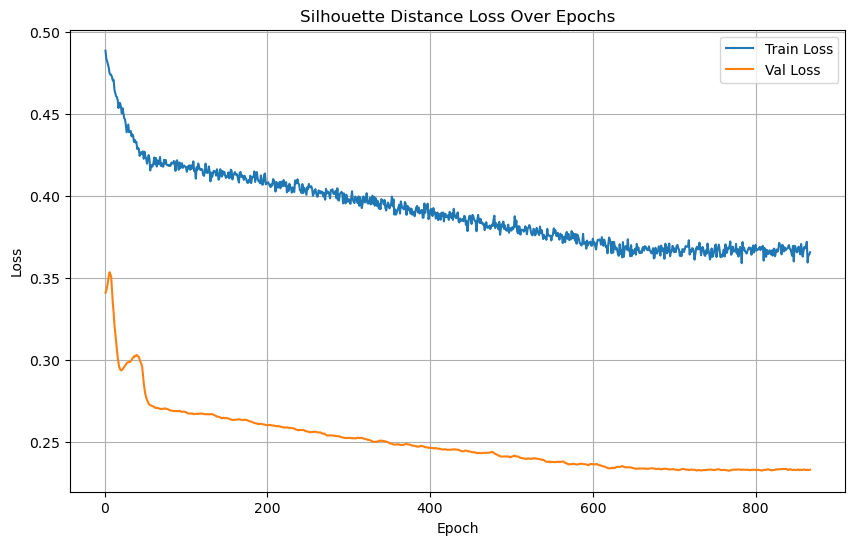

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/41], Loss: 0.2320
Test Batch [20/41], Loss: 0.2090
Test Batch [30/41], Loss: 0.5003


Test Batch [40/41], Loss: 0.1459

Test Loss: 0.2595


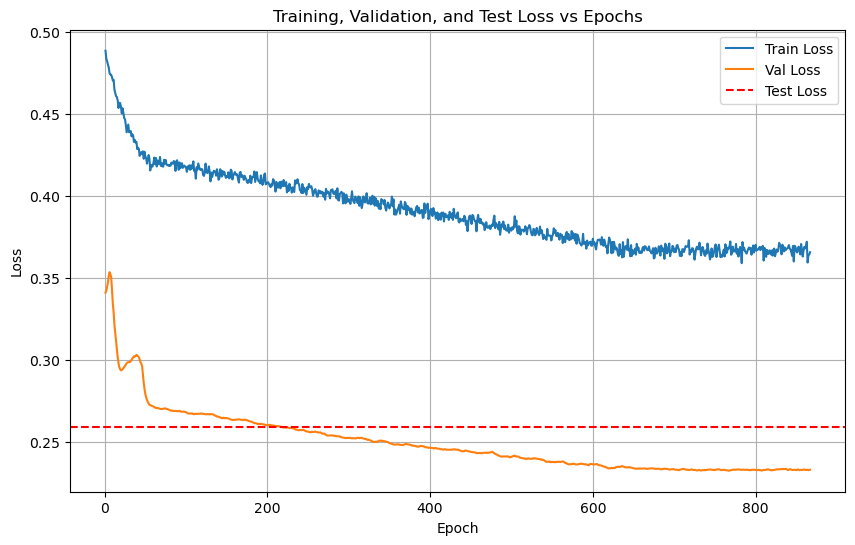

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/41 for test dataset.


  Processed batch 20/41 for test dataset.


  Processed batch 30/41 for test dataset.
  Processed batch 40/41 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (560, 128)
Train labels shape: (560,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2618, 128)
Test labels shape: (2618,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 92.86%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       0.80      0.80      0.80         5
           5       0.75      0.60      0.67         5
           6       1.00      1.00      1.00         5
           7       1.00      0.80      0.89         5
           8       0.83      1.00      0.91         5
           9       0.71      1.00      0.83         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      0.80      0.89         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (560, 128)
Train labels shape: (560,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2618, 128)
Test labels shape: (2618,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6285  |  Val Loss: 2.5976
Validation loss improved from inf to 2.5976.
[Epoch 2/1000] Train Loss: 2.5708  |  Val Loss: 2.5486
Validation loss improved from 2.5976 to 2.5486.
[Epoch 3/1000] Train Loss: 2.5204  |  Val Loss: 2.5020
Validation loss improved from 2.5486 to 2.5020.
[Epoch 4/1000] Train Loss: 2.4705  |  Val Loss: 2.4594
Validation loss improved from 2.5020 to 2.4594.
[Epoch 5/1000] Train Loss: 2.4251  |  Val Loss: 2.4199
Validation loss improved from 2.4594 to 2.4199.


[Epoch 6/1000] Train Loss: 2.3857  |  Val Loss: 2.3813
Validation loss improved from 2.4199 to 2.3813.
[Epoch 7/1000] Train Loss: 2.3436  |  Val Loss: 2.3450
Validation loss improved from 2.3813 to 2.3450.
[Epoch 8/1000] Train Loss: 2.3058  |  Val Loss: 2.3082
Validation loss improved from 2.3450 to 2.3082.
[Epoch 9/1000] Train Loss: 2.2667  |  Val Loss: 2.2716
Validation loss improved from 2.3082 to 2.2716.


[Epoch 10/1000] Train Loss: 2.2293  |  Val Loss: 2.2347
Validation loss improved from 2.2716 to 2.2347.
[Epoch 11/1000] Train Loss: 2.1896  |  Val Loss: 2.1981
Validation loss improved from 2.2347 to 2.1981.


[Epoch 12/1000] Train Loss: 2.1510  |  Val Loss: 2.1611
Validation loss improved from 2.1981 to 2.1611.
[Epoch 13/1000] Train Loss: 2.1120  |  Val Loss: 2.1245
Validation loss improved from 2.1611 to 2.1245.
[Epoch 14/1000] Train Loss: 2.0738  |  Val Loss: 2.0872
Validation loss improved from 2.1245 to 2.0872.
[Epoch 15/1000] Train Loss: 2.0355  |  Val Loss: 2.0503
Validation loss improved from 2.0872 to 2.0503.
[Epoch 16/1000] Train Loss: 1.9981  |  Val Loss: 2.0132
Validation loss improved from 2.0503 to 2.0132.


[Epoch 17/1000] Train Loss: 1.9598  |  Val Loss: 1.9763
Validation loss improved from 2.0132 to 1.9763.
[Epoch 18/1000] Train Loss: 1.9215  |  Val Loss: 1.9398
Validation loss improved from 1.9763 to 1.9398.
[Epoch 19/1000] Train Loss: 1.8833  |  Val Loss: 1.9036
Validation loss improved from 1.9398 to 1.9036.


[Epoch 20/1000] Train Loss: 1.8459  |  Val Loss: 1.8676
Validation loss improved from 1.9036 to 1.8676.
[Epoch 21/1000] Train Loss: 1.8080  |  Val Loss: 1.8321
Validation loss improved from 1.8676 to 1.8321.
[Epoch 22/1000] Train Loss: 1.7708  |  Val Loss: 1.7966
Validation loss improved from 1.8321 to 1.7966.


[Epoch 23/1000] Train Loss: 1.7336  |  Val Loss: 1.7615
Validation loss improved from 1.7966 to 1.7615.
[Epoch 24/1000] Train Loss: 1.6964  |  Val Loss: 1.7267
Validation loss improved from 1.7615 to 1.7267.
[Epoch 25/1000] Train Loss: 1.6597  |  Val Loss: 1.6921
Validation loss improved from 1.7267 to 1.6921.
[Epoch 26/1000] Train Loss: 1.6228  |  Val Loss: 1.6583
Validation loss improved from 1.6921 to 1.6583.
[Epoch 27/1000] Train Loss: 1.5858  |  Val Loss: 1.6249
Validation loss improved from 1.6583 to 1.6249.
[Epoch 28/1000] Train Loss: 1.5488  |  Val Loss: 1.5920
Validation loss improved from 1.6249 to 1.5920.


[Epoch 29/1000] Train Loss: 1.5121  |  Val Loss: 1.5591
Validation loss improved from 1.5920 to 1.5591.


[Epoch 30/1000] Train Loss: 1.4748  |  Val Loss: 1.5261
Validation loss improved from 1.5591 to 1.5261.
[Epoch 31/1000] Train Loss: 1.4383  |  Val Loss: 1.4937
Validation loss improved from 1.5261 to 1.4937.
[Epoch 32/1000] Train Loss: 1.4026  |  Val Loss: 1.4625
Validation loss improved from 1.4937 to 1.4625.
[Epoch 33/1000] Train Loss: 1.3672  |  Val Loss: 1.4322
Validation loss improved from 1.4625 to 1.4322.


[Epoch 34/1000] Train Loss: 1.3330  |  Val Loss: 1.4016
Validation loss improved from 1.4322 to 1.4016.
[Epoch 35/1000] Train Loss: 1.2987  |  Val Loss: 1.3710
Validation loss improved from 1.4016 to 1.3710.
[Epoch 36/1000] Train Loss: 1.2647  |  Val Loss: 1.3411
Validation loss improved from 1.3710 to 1.3411.
[Epoch 37/1000] Train Loss: 1.2313  |  Val Loss: 1.3113
Validation loss improved from 1.3411 to 1.3113.
[Epoch 38/1000] Train Loss: 1.1978  |  Val Loss: 1.2826
Validation loss improved from 1.3113 to 1.2826.
[Epoch 39/1000] Train Loss: 1.1654  |  Val Loss: 1.2529
Validation loss improved from 1.2826 to 1.2529.
[Epoch 40/1000] Train Loss: 1.1323  |  Val Loss: 1.2236
Validation loss improved from 1.2529 to 1.2236.


[Epoch 41/1000] Train Loss: 1.0995  |  Val Loss: 1.1942
Validation loss improved from 1.2236 to 1.1942.
[Epoch 42/1000] Train Loss: 1.0671  |  Val Loss: 1.1661
Validation loss improved from 1.1942 to 1.1661.
[Epoch 43/1000] Train Loss: 1.0351  |  Val Loss: 1.1376
Validation loss improved from 1.1661 to 1.1376.
[Epoch 44/1000] Train Loss: 1.0042  |  Val Loss: 1.1094
Validation loss improved from 1.1376 to 1.1094.
[Epoch 45/1000] Train Loss: 0.9726  |  Val Loss: 1.0820
Validation loss improved from 1.1094 to 1.0820.


[Epoch 46/1000] Train Loss: 0.9417  |  Val Loss: 1.0549
Validation loss improved from 1.0820 to 1.0549.
[Epoch 47/1000] Train Loss: 0.9114  |  Val Loss: 1.0280
Validation loss improved from 1.0549 to 1.0280.
[Epoch 48/1000] Train Loss: 0.8820  |  Val Loss: 1.0013
Validation loss improved from 1.0280 to 1.0013.
[Epoch 49/1000] Train Loss: 0.8524  |  Val Loss: 0.9753
Validation loss improved from 1.0013 to 0.9753.
[Epoch 50/1000] Train Loss: 0.8242  |  Val Loss: 0.9498
Validation loss improved from 0.9753 to 0.9498.
[Epoch 51/1000] Train Loss: 0.7971  |  Val Loss: 0.9257
Validation loss improved from 0.9498 to 0.9257.


[Epoch 52/1000] Train Loss: 0.7699  |  Val Loss: 0.9007
Validation loss improved from 0.9257 to 0.9007.
[Epoch 53/1000] Train Loss: 0.7432  |  Val Loss: 0.8773
Validation loss improved from 0.9007 to 0.8773.
[Epoch 54/1000] Train Loss: 0.7181  |  Val Loss: 0.8539
Validation loss improved from 0.8773 to 0.8539.
[Epoch 55/1000] Train Loss: 0.6937  |  Val Loss: 0.8310
Validation loss improved from 0.8539 to 0.8310.
[Epoch 56/1000] Train Loss: 0.6700  |  Val Loss: 0.8087
Validation loss improved from 0.8310 to 0.8087.
[Epoch 57/1000] Train Loss: 0.6471  |  Val Loss: 0.7886
Validation loss improved from 0.8087 to 0.7886.


[Epoch 58/1000] Train Loss: 0.6249  |  Val Loss: 0.7689
Validation loss improved from 0.7886 to 0.7689.
[Epoch 59/1000] Train Loss: 0.6034  |  Val Loss: 0.7494
Validation loss improved from 0.7689 to 0.7494.
[Epoch 60/1000] Train Loss: 0.5836  |  Val Loss: 0.7302
Validation loss improved from 0.7494 to 0.7302.
[Epoch 61/1000] Train Loss: 0.5642  |  Val Loss: 0.7129
Validation loss improved from 0.7302 to 0.7129.
[Epoch 62/1000] Train Loss: 0.5451  |  Val Loss: 0.6957
Validation loss improved from 0.7129 to 0.6957.


[Epoch 63/1000] Train Loss: 0.5272  |  Val Loss: 0.6802
Validation loss improved from 0.6957 to 0.6802.
[Epoch 64/1000] Train Loss: 0.5103  |  Val Loss: 0.6651
Validation loss improved from 0.6802 to 0.6651.
[Epoch 65/1000] Train Loss: 0.4941  |  Val Loss: 0.6502
Validation loss improved from 0.6651 to 0.6502.
[Epoch 66/1000] Train Loss: 0.4787  |  Val Loss: 0.6359
Validation loss improved from 0.6502 to 0.6359.
[Epoch 67/1000] Train Loss: 0.4637  |  Val Loss: 0.6231
Validation loss improved from 0.6359 to 0.6231.
[Epoch 68/1000] Train Loss: 0.4497  |  Val Loss: 0.6108
Validation loss improved from 0.6231 to 0.6108.
[Epoch 69/1000] Train Loss: 0.4361  |  Val Loss: 0.5992
Validation loss improved from 0.6108 to 0.5992.


[Epoch 70/1000] Train Loss: 0.4236  |  Val Loss: 0.5871
Validation loss improved from 0.5992 to 0.5871.
[Epoch 71/1000] Train Loss: 0.4116  |  Val Loss: 0.5752
Validation loss improved from 0.5871 to 0.5752.
[Epoch 72/1000] Train Loss: 0.4001  |  Val Loss: 0.5649
Validation loss improved from 0.5752 to 0.5649.
[Epoch 73/1000] Train Loss: 0.3886  |  Val Loss: 0.5551
Validation loss improved from 0.5649 to 0.5551.


[Epoch 74/1000] Train Loss: 0.3782  |  Val Loss: 0.5447
Validation loss improved from 0.5551 to 0.5447.
[Epoch 75/1000] Train Loss: 0.3681  |  Val Loss: 0.5365
Validation loss improved from 0.5447 to 0.5365.
[Epoch 76/1000] Train Loss: 0.3578  |  Val Loss: 0.5265
Validation loss improved from 0.5365 to 0.5265.
[Epoch 77/1000] Train Loss: 0.3481  |  Val Loss: 0.5184
Validation loss improved from 0.5265 to 0.5184.
[Epoch 78/1000] Train Loss: 0.3391  |  Val Loss: 0.5093
Validation loss improved from 0.5184 to 0.5093.
[Epoch 79/1000] Train Loss: 0.3304  |  Val Loss: 0.5014
Validation loss improved from 0.5093 to 0.5014.
[Epoch 80/1000] Train Loss: 0.3219  |  Val Loss: 0.4934
Validation loss improved from 0.5014 to 0.4934.


[Epoch 81/1000] Train Loss: 0.3139  |  Val Loss: 0.4864
Validation loss improved from 0.4934 to 0.4864.
[Epoch 82/1000] Train Loss: 0.3062  |  Val Loss: 0.4803
Validation loss improved from 0.4864 to 0.4803.
[Epoch 83/1000] Train Loss: 0.2991  |  Val Loss: 0.4733
Validation loss improved from 0.4803 to 0.4733.
[Epoch 84/1000] Train Loss: 0.2923  |  Val Loss: 0.4664
Validation loss improved from 0.4733 to 0.4664.


[Epoch 85/1000] Train Loss: 0.2864  |  Val Loss: 0.4614
Validation loss improved from 0.4664 to 0.4614.
[Epoch 86/1000] Train Loss: 0.2792  |  Val Loss: 0.4548
Validation loss improved from 0.4614 to 0.4548.
[Epoch 87/1000] Train Loss: 0.2731  |  Val Loss: 0.4486
Validation loss improved from 0.4548 to 0.4486.
[Epoch 88/1000] Train Loss: 0.2670  |  Val Loss: 0.4432
Validation loss improved from 0.4486 to 0.4432.
[Epoch 89/1000] Train Loss: 0.2616  |  Val Loss: 0.4381
Validation loss improved from 0.4432 to 0.4381.
[Epoch 90/1000] Train Loss: 0.2564  |  Val Loss: 0.4342
Validation loss improved from 0.4381 to 0.4342.
[Epoch 91/1000] Train Loss: 0.2509  |  Val Loss: 0.4300
Validation loss improved from 0.4342 to 0.4300.


[Epoch 92/1000] Train Loss: 0.2457  |  Val Loss: 0.4244
Validation loss improved from 0.4300 to 0.4244.
[Epoch 93/1000] Train Loss: 0.2409  |  Val Loss: 0.4197
Validation loss improved from 0.4244 to 0.4197.
[Epoch 94/1000] Train Loss: 0.2361  |  Val Loss: 0.4162
Validation loss improved from 0.4197 to 0.4162.
[Epoch 95/1000] Train Loss: 0.2314  |  Val Loss: 0.4113
Validation loss improved from 0.4162 to 0.4113.


[Epoch 96/1000] Train Loss: 0.2269  |  Val Loss: 0.4074
Validation loss improved from 0.4113 to 0.4074.
[Epoch 97/1000] Train Loss: 0.2226  |  Val Loss: 0.4028
Validation loss improved from 0.4074 to 0.4028.
[Epoch 98/1000] Train Loss: 0.2180  |  Val Loss: 0.3982
Validation loss improved from 0.4028 to 0.3982.
[Epoch 99/1000] Train Loss: 0.2137  |  Val Loss: 0.3955
Validation loss improved from 0.3982 to 0.3955.
[Epoch 100/1000] Train Loss: 0.2096  |  Val Loss: 0.3915
Validation loss improved from 0.3955 to 0.3915.
[Epoch 101/1000] Train Loss: 0.2053  |  Val Loss: 0.3876
Validation loss improved from 0.3915 to 0.3876.
[Epoch 102/1000] Train Loss: 0.2017  |  Val Loss: 0.3833
Validation loss improved from 0.3876 to 0.3833.


[Epoch 103/1000] Train Loss: 0.1980  |  Val Loss: 0.3798
Validation loss improved from 0.3833 to 0.3798.
[Epoch 104/1000] Train Loss: 0.1944  |  Val Loss: 0.3765
Validation loss improved from 0.3798 to 0.3765.
[Epoch 105/1000] Train Loss: 0.1913  |  Val Loss: 0.3741
Validation loss improved from 0.3765 to 0.3741.
[Epoch 106/1000] Train Loss: 0.1881  |  Val Loss: 0.3697
Validation loss improved from 0.3741 to 0.3697.


[Epoch 107/1000] Train Loss: 0.1853  |  Val Loss: 0.3689
Validation loss improved from 0.3697 to 0.3689.
[Epoch 108/1000] Train Loss: 0.1820  |  Val Loss: 0.3652
Validation loss improved from 0.3689 to 0.3652.
[Epoch 109/1000] Train Loss: 0.1792  |  Val Loss: 0.3614
Validation loss improved from 0.3652 to 0.3614.
[Epoch 110/1000] Train Loss: 0.1760  |  Val Loss: 0.3592
Validation loss improved from 0.3614 to 0.3592.
[Epoch 111/1000] Train Loss: 0.1733  |  Val Loss: 0.3570
Validation loss improved from 0.3592 to 0.3570.
[Epoch 112/1000] Train Loss: 0.1704  |  Val Loss: 0.3539
Validation loss improved from 0.3570 to 0.3539.
[Epoch 113/1000] Train Loss: 0.1683  |  Val Loss: 0.3512
Validation loss improved from 0.3539 to 0.3512.
[Epoch 114/1000] Train Loss: 0.1656  |  Val Loss: 0.3471
Validation loss improved from 0.3512 to 0.3471.


[Epoch 115/1000] Train Loss: 0.1629  |  Val Loss: 0.3458
Validation loss improved from 0.3471 to 0.3458.
[Epoch 116/1000] Train Loss: 0.1607  |  Val Loss: 0.3441
Validation loss improved from 0.3458 to 0.3441.
[Epoch 117/1000] Train Loss: 0.1584  |  Val Loss: 0.3429
Validation loss improved from 0.3441 to 0.3429.
[Epoch 118/1000] Train Loss: 0.1562  |  Val Loss: 0.3400
Validation loss improved from 0.3429 to 0.3400.


[Epoch 119/1000] Train Loss: 0.1537  |  Val Loss: 0.3360
Validation loss improved from 0.3400 to 0.3360.
[Epoch 120/1000] Train Loss: 0.1518  |  Val Loss: 0.3347
Validation loss improved from 0.3360 to 0.3347.
[Epoch 121/1000] Train Loss: 0.1500  |  Val Loss: 0.3323
Validation loss improved from 0.3347 to 0.3323.
[Epoch 122/1000] Train Loss: 0.1475  |  Val Loss: 0.3311
Validation loss improved from 0.3323 to 0.3311.
[Epoch 123/1000] Train Loss: 0.1456  |  Val Loss: 0.3296
Validation loss improved from 0.3311 to 0.3296.
[Epoch 124/1000] Train Loss: 0.1438  |  Val Loss: 0.3267
Validation loss improved from 0.3296 to 0.3267.
[Epoch 125/1000] Train Loss: 0.1416  |  Val Loss: 0.3243
Validation loss improved from 0.3267 to 0.3243.


[Epoch 126/1000] Train Loss: 0.1402  |  Val Loss: 0.3226
Validation loss improved from 0.3243 to 0.3226.
[Epoch 127/1000] Train Loss: 0.1382  |  Val Loss: 0.3221
Validation loss improved from 0.3226 to 0.3221.
[Epoch 128/1000] Train Loss: 0.1364  |  Val Loss: 0.3200
Validation loss improved from 0.3221 to 0.3200.


[Epoch 129/1000] Train Loss: 0.1349  |  Val Loss: 0.3181
Validation loss improved from 0.3200 to 0.3181.
[Epoch 130/1000] Train Loss: 0.1331  |  Val Loss: 0.3168
Validation loss improved from 0.3181 to 0.3168.
[Epoch 131/1000] Train Loss: 0.1314  |  Val Loss: 0.3144
Validation loss improved from 0.3168 to 0.3144.
[Epoch 132/1000] Train Loss: 0.1302  |  Val Loss: 0.3134
Validation loss improved from 0.3144 to 0.3134.
[Epoch 133/1000] Train Loss: 0.1285  |  Val Loss: 0.3111
Validation loss improved from 0.3134 to 0.3111.
[Epoch 134/1000] Train Loss: 0.1269  |  Val Loss: 0.3093
Validation loss improved from 0.3111 to 0.3093.
[Epoch 135/1000] Train Loss: 0.1253  |  Val Loss: 0.3079
Validation loss improved from 0.3093 to 0.3079.
[Epoch 136/1000] Train Loss: 0.1238  |  Val Loss: 0.3068
Validation loss improved from 0.3079 to 0.3068.


[Epoch 137/1000] Train Loss: 0.1228  |  Val Loss: 0.3051
Validation loss improved from 0.3068 to 0.3051.
[Epoch 138/1000] Train Loss: 0.1211  |  Val Loss: 0.3048
Validation loss improved from 0.3051 to 0.3048.
[Epoch 139/1000] Train Loss: 0.1196  |  Val Loss: 0.3034
Validation loss improved from 0.3048 to 0.3034.
[Epoch 140/1000] Train Loss: 0.1181  |  Val Loss: 0.3014
Validation loss improved from 0.3034 to 0.3014.


[Epoch 141/1000] Train Loss: 0.1172  |  Val Loss: 0.2998
Validation loss improved from 0.3014 to 0.2998.
[Epoch 142/1000] Train Loss: 0.1157  |  Val Loss: 0.2984
Validation loss improved from 0.2998 to 0.2984.
[Epoch 143/1000] Train Loss: 0.1142  |  Val Loss: 0.2981
Validation loss improved from 0.2984 to 0.2981.
[Epoch 144/1000] Train Loss: 0.1130  |  Val Loss: 0.2974
Validation loss improved from 0.2981 to 0.2974.
[Epoch 145/1000] Train Loss: 0.1118  |  Val Loss: 0.2964
Validation loss improved from 0.2974 to 0.2964.
[Epoch 146/1000] Train Loss: 0.1105  |  Val Loss: 0.2942
Validation loss improved from 0.2964 to 0.2942.
[Epoch 147/1000] Train Loss: 0.1097  |  Val Loss: 0.2926
Validation loss improved from 0.2942 to 0.2926.


[Epoch 148/1000] Train Loss: 0.1081  |  Val Loss: 0.2922
Validation loss improved from 0.2926 to 0.2922.
[Epoch 149/1000] Train Loss: 0.1073  |  Val Loss: 0.2910
Validation loss improved from 0.2922 to 0.2910.
[Epoch 150/1000] Train Loss: 0.1058  |  Val Loss: 0.2906
Validation loss improved from 0.2910 to 0.2906.


[Epoch 151/1000] Train Loss: 0.1047  |  Val Loss: 0.2877
Validation loss improved from 0.2906 to 0.2877.
[Epoch 152/1000] Train Loss: 0.1038  |  Val Loss: 0.2883
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 153/1000] Train Loss: 0.1026  |  Val Loss: 0.2887
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 154/1000] Train Loss: 0.1013  |  Val Loss: 0.2858
Validation loss improved from 0.2877 to 0.2858.
[Epoch 155/1000] Train Loss: 0.1003  |  Val Loss: 0.2843
Validation loss improved from 0.2858 to 0.2843.
[Epoch 156/1000] Train Loss: 0.0995  |  Val Loss: 0.2851
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 157/1000] Train Loss: 0.0981  |  Val Loss: 0.2829
Validation loss improved from 0.2843 to 0.2829.
[Epoch 158/1000] Train Loss: 0.0972  |  Val Loss: 0.2822
Validation loss improved from 0.2829 to 0.2822.
[Epoch 159/1000] Train Loss: 0.0961  |  Val Loss: 0.2825
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 160/1000] Train Loss: 0.0950  |  Val Loss: 0.2815
Validation loss improved from 0.2822 to 0.2815.


[Epoch 161/1000] Train Loss: 0.0943  |  Val Loss: 0.2807
Validation loss improved from 0.2815 to 0.2807.
[Epoch 162/1000] Train Loss: 0.0932  |  Val Loss: 0.2773
Validation loss improved from 0.2807 to 0.2773.
[Epoch 163/1000] Train Loss: 0.0922  |  Val Loss: 0.2772
Validation loss improved from 0.2773 to 0.2772.
[Epoch 164/1000] Train Loss: 0.0913  |  Val Loss: 0.2773
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 165/1000] Train Loss: 0.0901  |  Val Loss: 0.2757
Validation loss improved from 0.2772 to 0.2757.
[Epoch 166/1000] Train Loss: 0.0895  |  Val Loss: 0.2741
Validation loss improved from 0.2757 to 0.2741.
[Epoch 167/1000] Train Loss: 0.0885  |  Val Loss: 0.2757
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 168/1000] Train Loss: 0.0877  |  Val Loss: 0.2745
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 169/1000] Train Loss: 0.0868  |  Val Loss: 0.2727
Validation loss improved from 0.2741 to 0.2727.
[Epoch 170/1000] Train Loss: 0.0860  

[Epoch 172/1000] Train Loss: 0.0841  |  Val Loss: 0.2695
Validation loss improved from 0.2725 to 0.2695.
[Epoch 173/1000] Train Loss: 0.0832  |  Val Loss: 0.2701
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 174/1000] Train Loss: 0.0824  |  Val Loss: 0.2705
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 175/1000] Train Loss: 0.0816  |  Val Loss: 0.2692
Validation loss improved from 0.2695 to 0.2692.
[Epoch 176/1000] Train Loss: 0.0808  |  Val Loss: 0.2676
Validation loss improved from 0.2692 to 0.2676.
[Epoch 177/1000] Train Loss: 0.0801  |  Val Loss: 0.2660
Validation loss improved from 0.2676 to 0.2660.
[Epoch 178/1000] Train Loss: 0.0793  |  Val Loss: 0.2677
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 179/1000] Train Loss: 0.0783  |  Val Loss: 0.2654
Validation loss improved from 0.2660 to 0.2654.
[Epoch 180/1000] Train Loss: 0.0775  |  Val Loss: 0.2654
Validation loss improved from 0.2654 to 0.2654.
[Epoch 181/1000] Train Loss: 0.0767  

[Epoch 183/1000] Train Loss: 0.0751  |  Val Loss: 0.2630
Validation loss improved from 0.2633 to 0.2630.
[Epoch 184/1000] Train Loss: 0.0744  |  Val Loss: 0.2619
Validation loss improved from 0.2630 to 0.2619.
[Epoch 185/1000] Train Loss: 0.0738  |  Val Loss: 0.2624
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 186/1000] Train Loss: 0.0731  |  Val Loss: 0.2629
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 187/1000] Train Loss: 0.0723  |  Val Loss: 0.2597
Validation loss improved from 0.2619 to 0.2597.
[Epoch 188/1000] Train Loss: 0.0716  |  Val Loss: 0.2593
Validation loss improved from 0.2597 to 0.2593.
[Epoch 189/1000] Train Loss: 0.0708  |  Val Loss: 0.2589
Validation loss improved from 0.2593 to 0.2589.
[Epoch 190/1000] Train Loss: 0.0701  |  Val Loss: 0.2594
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 191/1000] Train Loss: 0.0693  |  Val Loss: 0.2588
Validation loss improved from 0.2589 to 0.2588.
[Epoch 192/1000] Train Loss: 0.0687  

[Epoch 196/1000] Train Loss: 0.0663  |  Val Loss: 0.2563
Validation loss improved from 0.2568 to 0.2563.
[Epoch 197/1000] Train Loss: 0.0654  |  Val Loss: 0.2553
Validation loss improved from 0.2563 to 0.2553.
[Epoch 198/1000] Train Loss: 0.0648  |  Val Loss: 0.2545
Validation loss improved from 0.2553 to 0.2545.
[Epoch 199/1000] Train Loss: 0.0642  |  Val Loss: 0.2558
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 200/1000] Train Loss: 0.0635  |  Val Loss: 0.2537
Validation loss improved from 0.2545 to 0.2537.
[Epoch 201/1000] Train Loss: 0.0631  |  Val Loss: 0.2532
Validation loss improved from 0.2537 to 0.2532.
[Epoch 202/1000] Train Loss: 0.0622  |  Val Loss: 0.2539
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 203/1000] Train Loss: 0.0620  |  Val Loss: 0.2524
Validation loss improved from 0.2532 to 0.2524.
[Epoch 204/1000] Train Loss: 0.0614  |  Val Loss: 0.2515
Validation loss improved from 0.2524 to 0.2515.
[Epoch 205/1000] Train Loss: 0.0606  |  Val

[Epoch 207/1000] Train Loss: 0.0594  |  Val Loss: 0.2519
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 208/1000] Train Loss: 0.0589  |  Val Loss: 0.2511
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 209/1000] Train Loss: 0.0583  |  Val Loss: 0.2490
Validation loss improved from 0.2507 to 0.2490.
[Epoch 210/1000] Train Loss: 0.0579  |  Val Loss: 0.2492
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 211/1000] Train Loss: 0.0572  |  Val Loss: 0.2492
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 212/1000] Train Loss: 0.0573  |  Val Loss: 0.2458
Validation loss improved from 0.2490 to 0.2458.
[Epoch 213/1000] Train Loss: 0.0562  |  Val Loss: 0.2482
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 214/1000] Train Loss: 0.0559  |  Val Loss: 0.2482
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 215/1000] Train Loss: 0.0553  |  Val Loss: 0.2480
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 216/10

[Epoch 219/1000] Train Loss: 0.0531  |  Val Loss: 0.2461
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 220/1000] Train Loss: 0.0527  |  Val Loss: 0.2454
Validation loss improved from 0.2458 to 0.2454.
[Epoch 221/1000] Train Loss: 0.0520  |  Val Loss: 0.2455
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 222/1000] Train Loss: 0.0517  |  Val Loss: 0.2452
Validation loss improved from 0.2454 to 0.2452.
[Epoch 223/1000] Train Loss: 0.0510  |  Val Loss: 0.2455
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 224/1000] Train Loss: 0.0507  |  Val Loss: 0.2435
Validation loss improved from 0.2452 to 0.2435.
[Epoch 225/1000] Train Loss: 0.0502  |  Val Loss: 0.2448
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 226/1000] Train Loss: 0.0498  |  Val Loss: 0.2432
Validation loss improved from 0.2435 to 0.2432.
[Epoch 227/1000] Train Loss: 0.0491  |  Val Loss: 0.2430
Validation loss improved from 0.2432 to 0.2430.
[Epoch 228/1000] Train Loss: 0.

[Epoch 230/1000] Train Loss: 0.0478  |  Val Loss: 0.2417
Validation loss improved from 0.2430 to 0.2417.
[Epoch 231/1000] Train Loss: 0.0475  |  Val Loss: 0.2412
Validation loss improved from 0.2417 to 0.2412.
[Epoch 232/1000] Train Loss: 0.0471  |  Val Loss: 0.2421
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 233/1000] Train Loss: 0.0467  |  Val Loss: 0.2439
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 234/1000] Train Loss: 0.0462  |  Val Loss: 0.2426
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 235/1000] Train Loss: 0.0458  |  Val Loss: 0.2413
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 236/1000] Train Loss: 0.0453  |  Val Loss: 0.2407
Validation loss improved from 0.2412 to 0.2407.
[Epoch 237/1000] Train Loss: 0.0447  |  Val Loss: 0.2423
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 238/1000] Train Loss: 0.0444  |  Val Loss: 0.2419
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 239/1000] Tr

[Epoch 241/1000] Train Loss: 0.0431  |  Val Loss: 0.2411
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 242/1000] Train Loss: 0.0429  |  Val Loss: 0.2411
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 243/1000] Train Loss: 0.0425  |  Val Loss: 0.2400
Validation loss improved from 0.2406 to 0.2400.
[Epoch 244/1000] Train Loss: 0.0421  |  Val Loss: 0.2417
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 245/1000] Train Loss: 0.0418  |  Val Loss: 0.2403
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 246/1000] Train Loss: 0.0412  |  Val Loss: 0.2415
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 247/1000] Train Loss: 0.0409  |  Val Loss: 0.2412
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 248/1000] Train Loss: 0.0408  |  Val Loss: 0.2388
Validation loss improved from 0.2400 to 0.2388.
[Epoch 249/1000] Train Loss: 0.0403  |  Val Loss: 0.2404
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 250/10

[Epoch 252/1000] Train Loss: 0.0392  |  Val Loss: 0.2386
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 253/1000] Train Loss: 0.0387  |  Val Loss: 0.2379
Validation loss improved from 0.2381 to 0.2379.
[Epoch 254/1000] Train Loss: 0.0384  |  Val Loss: 0.2381
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 255/1000] Train Loss: 0.0380  |  Val Loss: 0.2377
Validation loss improved from 0.2379 to 0.2377.
[Epoch 256/1000] Train Loss: 0.0377  |  Val Loss: 0.2376
Validation loss improved from 0.2377 to 0.2376.
[Epoch 257/1000] Train Loss: 0.0373  |  Val Loss: 0.2374
Validation loss improved from 0.2376 to 0.2374.
[Epoch 258/1000] Train Loss: 0.0369  |  Val Loss: 0.2372
Validation loss improved from 0.2374 to 0.2372.
[Epoch 259/1000] Train Loss: 0.0367  |  Val Loss: 0.2383
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 260/1000] Train Loss: 0.0367  |  Val Loss: 0.2374
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 261/1000] Train Loss: 0.

[Epoch 263/1000] Train Loss: 0.0353  |  Val Loss: 0.2353
Validation loss improved from 0.2366 to 0.2353.
[Epoch 264/1000] Train Loss: 0.0351  |  Val Loss: 0.2351
Validation loss improved from 0.2353 to 0.2351.
[Epoch 265/1000] Train Loss: 0.0349  |  Val Loss: 0.2381
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 266/1000] Train Loss: 0.0343  |  Val Loss: 0.2364
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 267/1000] Train Loss: 0.0341  |  Val Loss: 0.2358
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 268/1000] Train Loss: 0.0339  |  Val Loss: 0.2350
Validation loss improved from 0.2351 to 0.2350.
[Epoch 269/1000] Train Loss: 0.0336  |  Val Loss: 0.2379
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 270/1000] Train Loss: 0.0331  |  Val Loss: 0.2374
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 271/1000] Train Loss: 0.0328  |  Val Loss: 0.2360
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 272/1000] Tr

[Epoch 274/1000] Train Loss: 0.0319  |  Val Loss: 0.2364
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 275/1000] Train Loss: 0.0316  |  Val Loss: 0.2359
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 276/1000] Train Loss: 0.0313  |  Val Loss: 0.2365
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 277/1000] Train Loss: 0.0309  |  Val Loss: 0.2350
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 278/1000] Train Loss: 0.0309  |  Val Loss: 0.2348
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 279/1000] Train Loss: 0.0304  |  Val Loss: 0.2346
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 280/1000] Train Loss: 0.0301  |  Val Loss: 0.2349
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 281/1000] Train Loss: 0.0300  |  Val Loss: 0.2367
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 282/1000] Train Loss: 0.0297  |  Val Loss: 0.2373
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 285/1000] Train Loss: 0.0289  |  Val Loss: 0.2353
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 286/1000] Train Loss: 0.0285  |  Val Loss: 0.2349
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 287/1000] Train Loss: 0.0283  |  Val Loss: 0.2341
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 288/1000] Train Loss: 0.0280  |  Val Loss: 0.2345
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 289/1000] Train Loss: 0.0277  |  Val Loss: 0.2351
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 290/1000] Train Loss: 0.0275  |  Val Loss: 0.2341
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 291/1000] Train Loss: 0.0272  |  Val Loss: 0.2343
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 292/1000] Train Loss: 0.0273  |  Val Loss: 0.2352
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 293/1000] Train Loss: 0.0268  |  Val Loss: 0.2355
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 296/1000] Train Loss: 0.0260  |  Val Loss: 0.2341
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 297/1000] Train Loss: 0.0257  |  Val Loss: 0.2344
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 298/1000] Train Loss: 0.0254  |  Val Loss: 0.2342
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 299/1000] Train Loss: 0.0253  |  Val Loss: 0.2344
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 300/1000] Train Loss: 0.0250  |  Val Loss: 0.2352
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 301/1000] Train Loss: 0.0248  |  Val Loss: 0.2347
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 302/1000] Train Loss: 0.0246  |  Val Loss: 0.2347
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 303/1000] Train Loss: 0.0244  |  Val Loss: 0.2340
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 304/1000] Train Loss: 0.0242  |  Val Loss: 0.2360
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 307/1000] Train Loss: 0.0235  |  Val Loss: 0.2357
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 308/1000] Train Loss: 0.0233  |  Val Loss: 0.2365
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 309/1000] Train Loss: 0.0231  |  Val Loss: 0.2354
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 310/1000] Train Loss: 0.0231  |  Val Loss: 0.2339
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 311/1000] Train Loss: 0.0228  |  Val Loss: 0.2358
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 312/1000] Train Loss: 0.0225  |  Val Loss: 0.2349
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 313/1000] Train Loss: 0.0223  |  Val Loss: 0.2354
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 314/1000] Train Loss: 0.0221  |  Val Loss: 0.2351
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 315/1000] Train Loss: 0.0219  |  Val Loss: 0.2357
!! Validation loss did NOT improve !! Patience:

[Epoch 318/1000] Train Loss: 0.0214  |  Val Loss: 0.2350
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 319/1000] Train Loss: 0.0212  |  Val Loss: 0.2359
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 320/1000] Train Loss: 0.0211  |  Val Loss: 0.2364
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 321/1000] Train Loss: 0.0207  |  Val Loss: 0.2356
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 322/1000] Train Loss: 0.0207  |  Val Loss: 0.2356
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 323/1000] Train Loss: 0.0205  |  Val Loss: 0.2340
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 324/1000] Train Loss: 0.0203  |  Val Loss: 0.2336
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 325/1000] Train Loss: 0.0202  |  Val Loss: 0.2359
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 326/1000] Train Loss: 0.0199  |  Val Loss: 0.2358
!! Validation loss did NOT improve !! Patience:

[Epoch 330/1000] Train Loss: 0.0193  |  Val Loss: 0.2343
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 331/1000] Train Loss: 0.0191  |  Val Loss: 0.2369
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 332/1000] Train Loss: 0.0189  |  Val Loss: 0.2363
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 333/1000] Train Loss: 0.0187  |  Val Loss: 0.2365
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 334/1000] Train Loss: 0.0186  |  Val Loss: 0.2362
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 335/1000] Train Loss: 0.0184  |  Val Loss: 0.2357
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 336/1000] Train Loss: 0.0183  |  Val Loss: 0.2358
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 337/1000] Train Loss: 0.0180  |  Val Loss: 0.2364
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 338/1000] Train Loss: 0.0179  |  Val Loss: 0.2366
!! Validation loss did NOT improve !! Patience:

[Epoch 341/1000] Train Loss: 0.0175  |  Val Loss: 0.2372
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 342/1000] Train Loss: 0.0173  |  Val Loss: 0.2376
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 343/1000] Train Loss: 0.0172  |  Val Loss: 0.2372
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 344/1000] Train Loss: 0.0170  |  Val Loss: 0.2372
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 345/1000] Train Loss: 0.0169  |  Val Loss: 0.2372
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 346/1000] Train Loss: 0.0167  |  Val Loss: 0.2381
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 347/1000] Train Loss: 0.0166  |  Val Loss: 0.2384
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 348/1000] Train Loss: 0.0164  |  Val Loss: 0.2385
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 349/1000] Train Loss: 0.0163  |  Val Loss: 0.2374
!! Validation loss did NOT improve !! Patience:

[Epoch 352/1000] Train Loss: 0.0159  |  Val Loss: 0.2389
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 353/1000] Train Loss: 0.0158  |  Val Loss: 0.2378
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 354/1000] Train Loss: 0.0156  |  Val Loss: 0.2382
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 355/1000] Train Loss: 0.0155  |  Val Loss: 0.2389
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 356/1000] Train Loss: 0.0153  |  Val Loss: 0.2398
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 357/1000] Train Loss: 0.0152  |  Val Loss: 0.2388
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 358/1000] Train Loss: 0.0150  |  Val Loss: 0.2391
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 359/1000] Train Loss: 0.0149  |  Val Loss: 0.2391
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 360/1000] Train Loss: 0.0149  |  Val Loss: 0.2393
!! Validation loss did NOT improve !! Patience:

[Epoch 363/1000] Train Loss: 0.0145  |  Val Loss: 0.2390
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 364/1000] Train Loss: 0.0143  |  Val Loss: 0.2387
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 365/1000] Train Loss: 0.0144  |  Val Loss: 0.2409
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 366/1000] Train Loss: 0.0141  |  Val Loss: 0.2418
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 367/1000] Train Loss: 0.0140  |  Val Loss: 0.2403
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 368/1000] Train Loss: 0.0138  |  Val Loss: 0.2406
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 369/1000] Train Loss: 0.0138  |  Val Loss: 0.2406
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 370/1000] Train Loss: 0.0136  |  Val Loss: 0.2406
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 371/1000] Train Loss: 0.0135  |  Val Loss: 0.2407
!! Validation loss did NOT improve !! Patience:

[Epoch 375/1000] Train Loss: 0.0131  |  Val Loss: 0.2422
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 376/1000] Train Loss: 0.0130  |  Val Loss: 0.2409
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 377/1000] Train Loss: 0.0128  |  Val Loss: 0.2414
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 378/1000] Train Loss: 0.0127  |  Val Loss: 0.2425
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 379/1000] Train Loss: 0.0127  |  Val Loss: 0.2433
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 380/1000] Train Loss: 0.0125  |  Val Loss: 0.2442
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 381/1000] Train Loss: 0.0124  |  Val Loss: 0.2438
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 382/1000] Train Loss: 0.0123  |  Val Loss: 0.2432
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 383/1000] Train Loss: 0.0122  |  Val Loss: 0.2439
!! Validation loss did NOT improve !! Patience:

[Epoch 386/1000] Train Loss: 0.0119  |  Val Loss: 0.2440
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 387/1000] Train Loss: 0.0119  |  Val Loss: 0.2441
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 388/1000] Train Loss: 0.0118  |  Val Loss: 0.2437
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 389/1000] Train Loss: 0.0117  |  Val Loss: 0.2445
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 390/1000] Train Loss: 0.0115  |  Val Loss: 0.2451
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 391/1000] Train Loss: 0.0114  |  Val Loss: 0.2459
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 392/1000] Train Loss: 0.0113  |  Val Loss: 0.2453
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 393/1000] Train Loss: 0.0113  |  Val Loss: 0.2454
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 394/1000] Train Loss: 0.0112  |  Val Loss: 0.2466
!! Validation loss did NOT improve !! Patience:

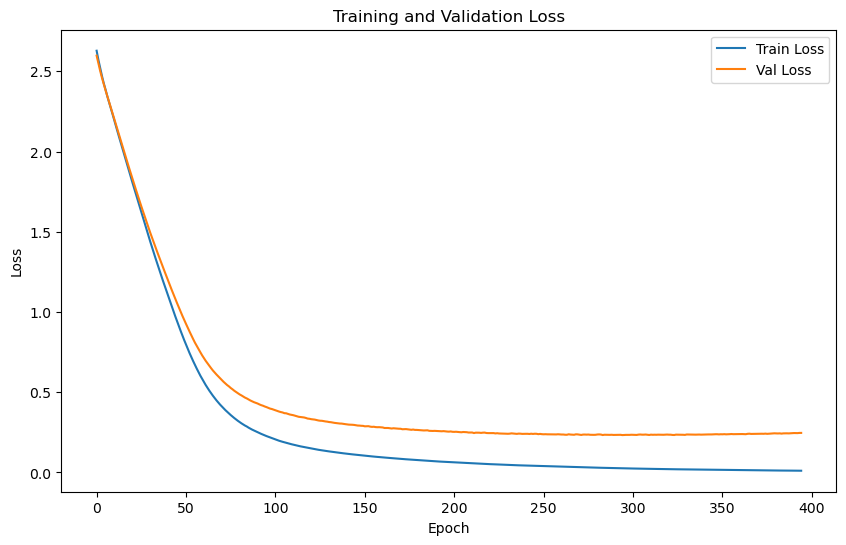

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.3427 | Test Accuracy: 89.00%


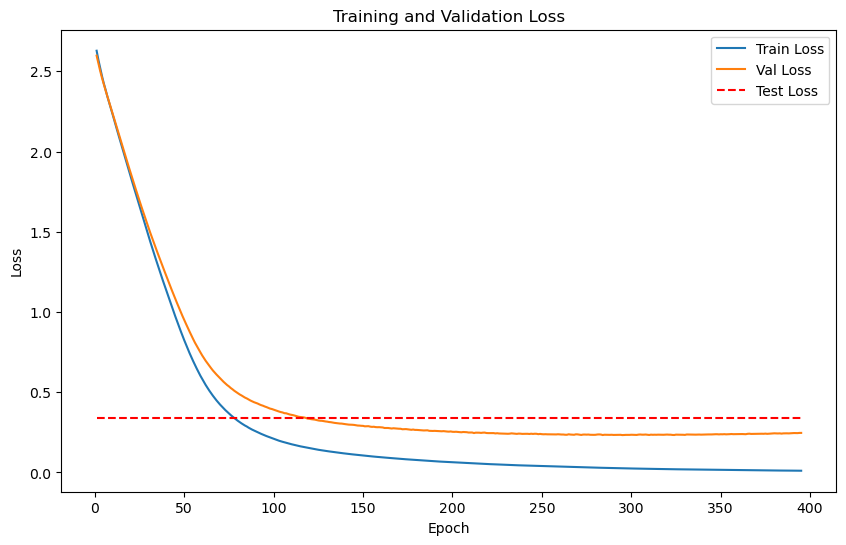

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


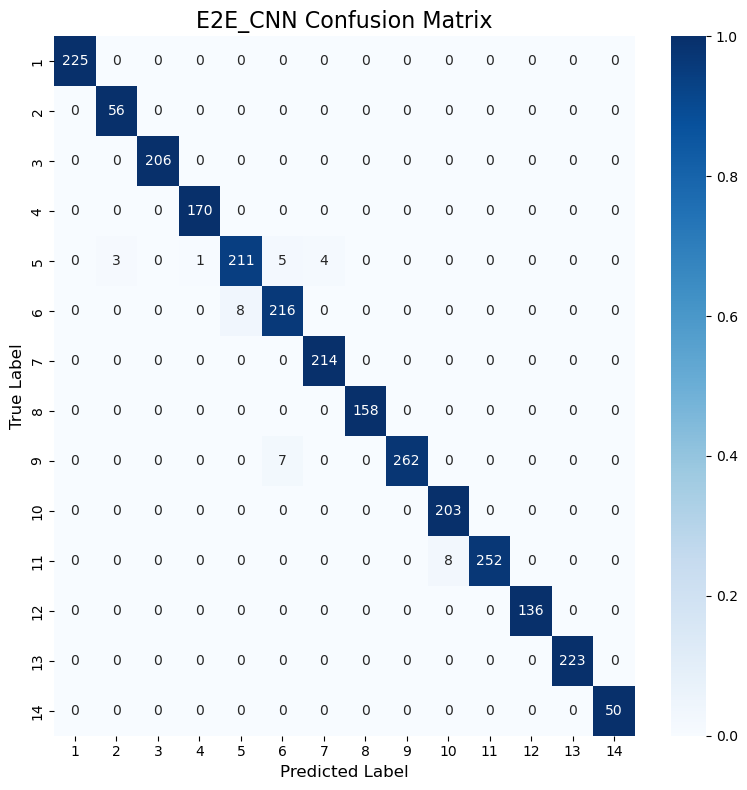

Classification Accuracy: 98.62%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


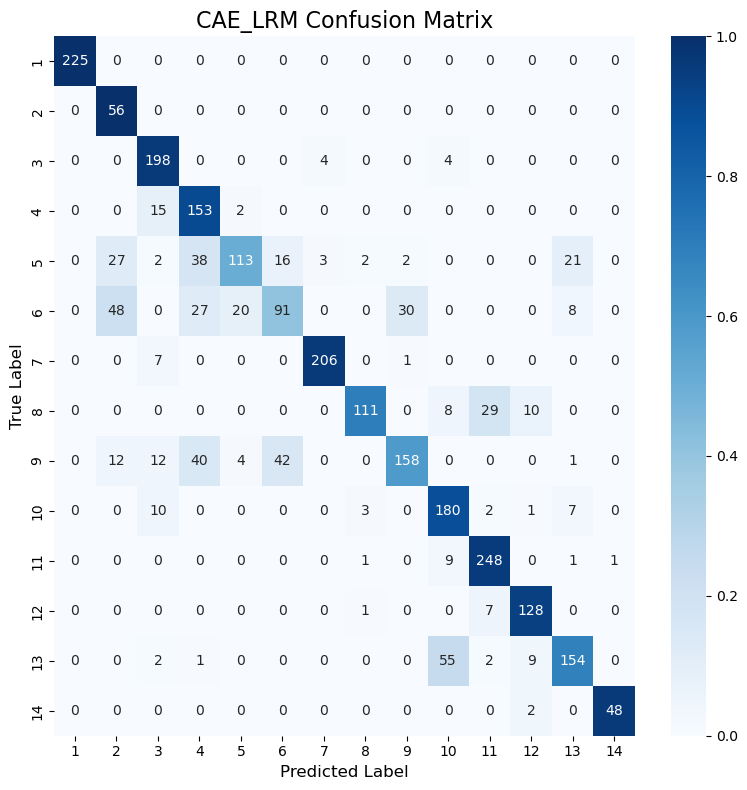

Classification Accuracy: 79.03%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


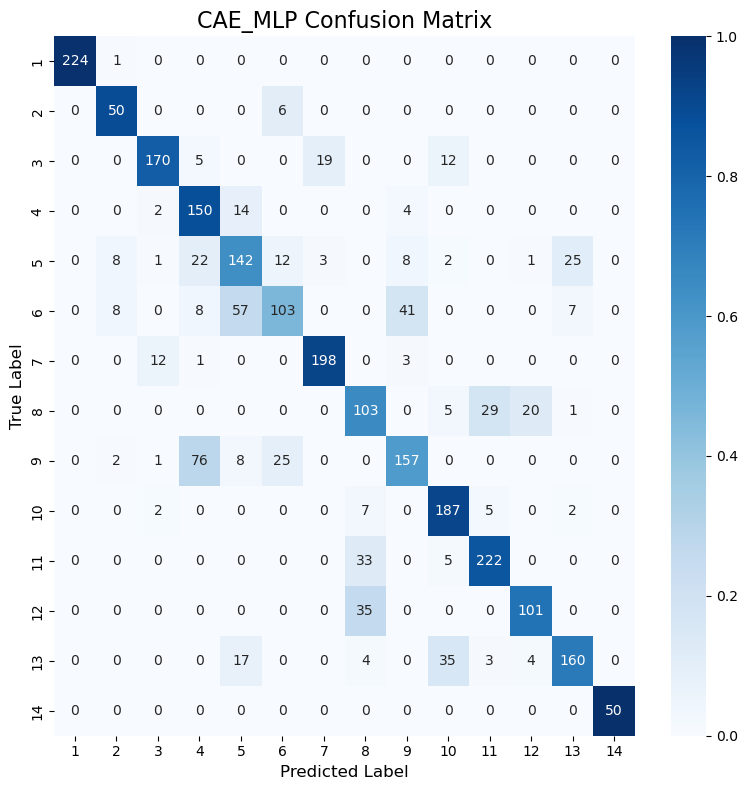

Classification Accuracy: 77.04%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


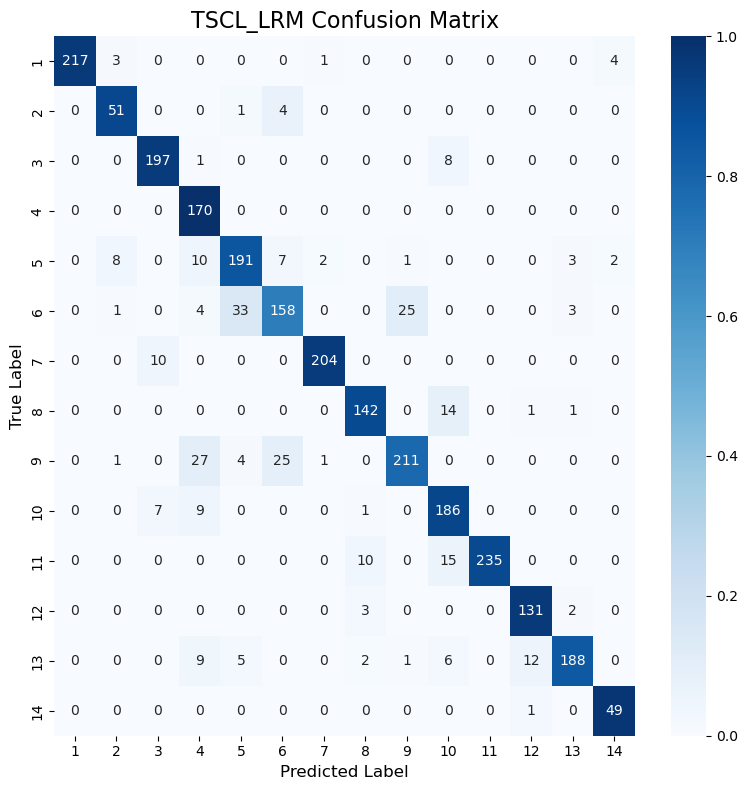

Classification Accuracy: 89.00%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


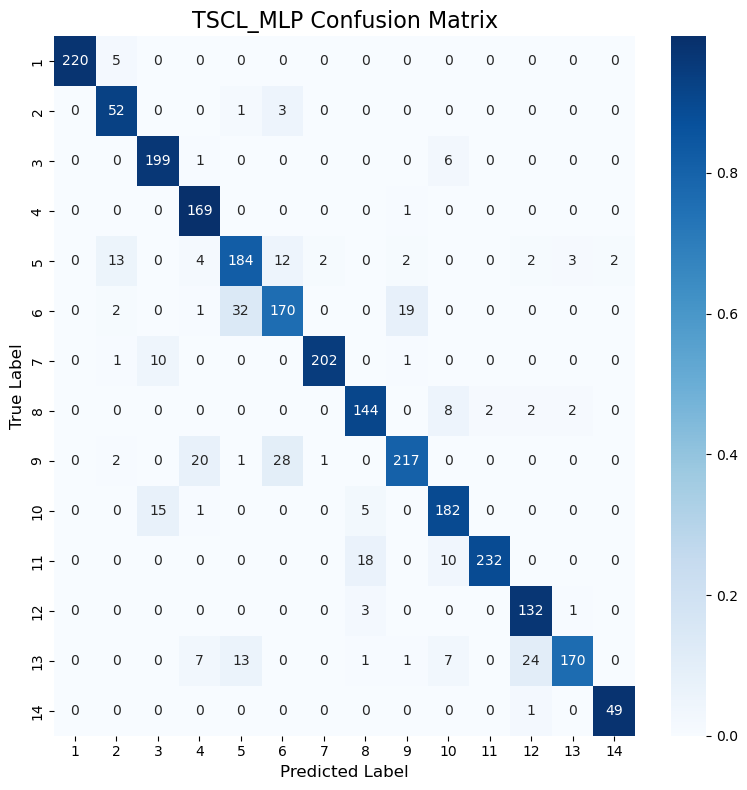

Classification Accuracy: 88.69%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


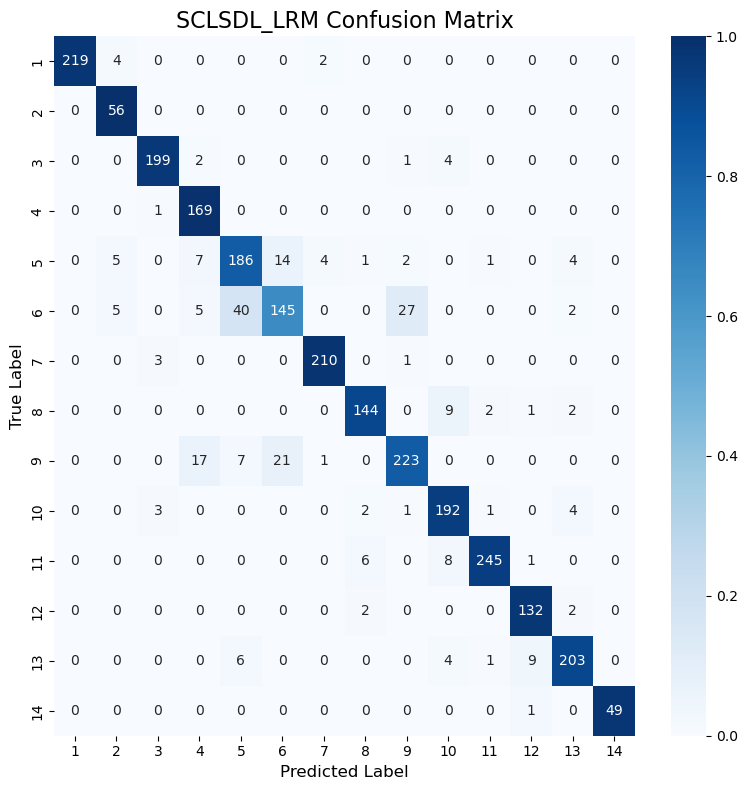

Classification Accuracy: 90.60%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


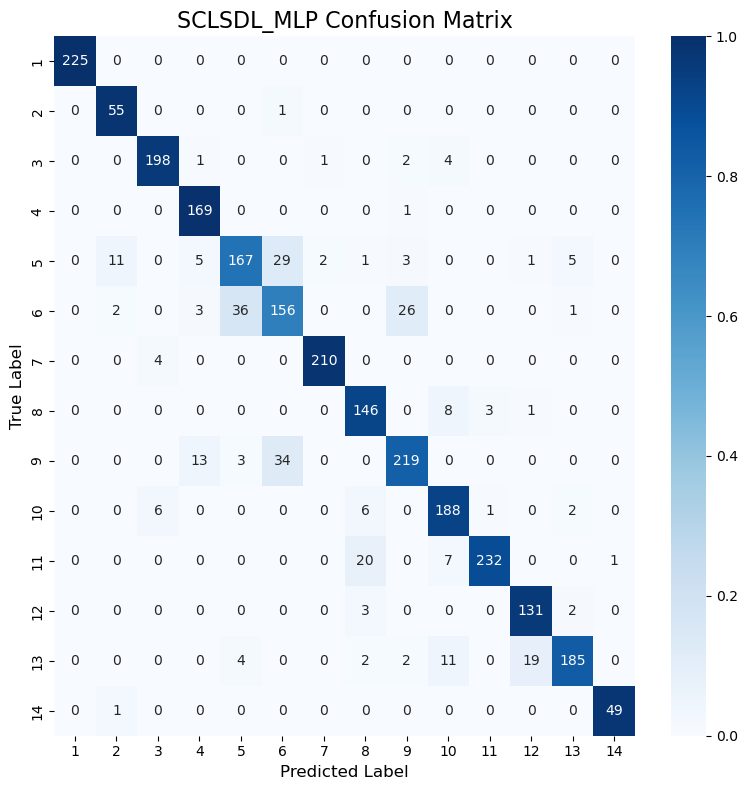

Classification Accuracy: 89.00%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          98.62
1    LRM (CAE)          79.03
2    MLP (CAE)          77.04
3     TSCL LRM          89.00
4     TSCL MLP          88.69
5  SCL_SDL LRM          90.60
6  SCL_SDL MLP          89.00

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          98.62
5  SCL_SDL LRM          90.60
3     TSCL LRM          89.00
6  SCL_SDL MLP          89.00
4     TSCL MLP          88.69
1    LRM (CAE)          79.03
2    MLP (CAE)          77.04
